In [3]:
# --- 1. 安装依赖 ---
!pip install xarray netCDF4 matplotlib geopandas rasterio rioxarray --quiet

# --- 2. 挂载Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- 3. 导入库 ---
import os
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 补充必要的库
import glob
import json
from datetime import datetime, timedelta
import calendar
from pathlib import Path
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm
import gc


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# === SO2 3D CNN训练 - 完整Colab版本 ===
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 检查Colab环境
print("🔍 检查Colab环境:")
print(f"Python版本: {sys.version}")
print(f"PyTorch版本: {torch.__version__}")
print(f"CUDA可用: {torch.cuda.is_available()}")
print(f"GPU数量: {torch.cuda.device_count()}")

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 使用设备: {device}")

# 检查GPU内存
if torch.cuda.is_available():
    print(f"📊 GPU内存: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"📊 可用内存: {torch.cuda.memory_reserved(0) / 1e9:.1f} GB")

# 检查数据路径
base_path = "/content/drive/MyDrive"
so2_path = f"{base_path}/Feature_Stacks/SO2_2019"  # 注意：SO2不是S02

print("\n📁 检查数据路径:")
if os.path.exists(so2_path):
    files = os.listdir(so2_path)
    so2_files = [f for f in files if f.endswith('.npz')]
    print(f"✅ SO2数据路径存在: {so2_path}")
    print(f"📊 SO2文件数量: {len(so2_files)}")
    if len(so2_files) > 0:
        print(f"📄 示例文件: {so2_files[0]}")
else:
    print(f"❌ SO2数据路径不存在: {so2_path}")
    print("💡 请检查路径是否正确，应该是 'SO2_2019' 而不是 'S02_2019'")

# 检查其他年份
years = [2019, 2020, 2021, 2022, 2023]
print(f"\n📊 检查所有年份的SO2数据:")
for year in years:
    year_path = f"{base_path}/Feature_Stacks/SO2_{year}"
    if os.path.exists(year_path):
        files = len([f for f in os.listdir(year_path) if f.endswith('.npz')])
        print(f"   ✅ SO2_{year}: {files} 文件")
    else:
        print(f"   ❌ SO2_{year}: 路径不存在")

print("\n🎯 环境检查完成！")
print("💡 如果所有路径都存在，可以开始3D CNN训练")

🔍 检查Colab环境:
Python版本: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
PyTorch版本: 2.8.0+cu126
CUDA可用: True
GPU数量: 1
🚀 使用设备: cuda
📊 GPU内存: 85.2 GB
📊 可用内存: 0.0 GB

📁 检查数据路径:
✅ SO2数据路径存在: /content/drive/MyDrive/Feature_Stacks/SO2_2019
📊 SO2文件数量: 365
📄 示例文件: SO2_stack_20190101.npz

📊 检查所有年份的SO2数据:
   ✅ SO2_2019: 365 文件
   ✅ SO2_2020: 366 文件
   ✅ SO2_2021: 365 文件
   ✅ SO2_2022: 365 文件
   ✅ SO2_2023: 365 文件

🎯 环境检查完成！
💡 如果所有路径都存在，可以开始3D CNN训练


In [15]:
# === SO2 3D CNN训练开始 ===
print("🚀 开始SO2 3D CNN训练...")

# 配置参数
TRAIN_YEARS = [2019, 2020, 2021]
VAL_YEARS = [2022]
TEST_YEARS = [2023]

# 模型配置
model_config = {
    'input_channels': 15,
    'time_window': 7,
    'spatial_size': (300, 600),
    'hidden_dim': 64,
    'num_layers': 4,
    'dropout_rate': 0.2
}

# 训练配置
training_config = {
    'batch_size': 4,  # 您有85GB GPU内存，可以用更大的批次
    'epochs': 5,
    'learning_rate': 1e-3,
    'weight_decay': 1e-4,
    'patience': 3,
    'min_delta': 1e-4,
    'alpha': 0.7,
    'beta': 0.2,
    'gamma': 0.1,
    'patch_gap_ratio': 0.25,
    'spatial_gap_ratio': 0.2,
    'num_workers': 0
}

print("📊 训练配置:")
print(f"   - 训练年份: {TRAIN_YEARS}")
print(f"   - 验证年份: {VAL_YEARS}")
print(f"   - 测试年份: {TEST_YEARS}")
print(f"   - 时间窗口: {model_config['time_window']}天")
print(f"   - 批次大小: {training_config['batch_size']}")
print(f"   - 训练轮数: {training_config['epochs']}")

print("\n💡 准备开始3D CNN训练...")
print("💡 这将使用7天时间窗口和patch缺口进行真正的gap-filling训练")

🚀 开始SO2 3D CNN训练...
📊 训练配置:
   - 训练年份: [2019, 2020, 2021]
   - 验证年份: [2022]
   - 测试年份: [2023]
   - 时间窗口: 7天
   - 批次大小: 4
   - 训练轮数: 5

💡 准备开始3D CNN训练...
💡 这将使用7天时间窗口和patch缺口进行真正的gap-filling训练


In [16]:
# === 挂载Google Drive并设置工作目录 ===
from google.colab import drive
import os
import sys

# 挂载Google Drive
drive.mount('/content/drive')

# 切换到3D CNN文件夹
os.chdir('/content/drive/MyDrive/3dcnn_so2')
print(f"📁 当前工作目录: {os.getcwd()}")

# 列出文件确认
files = os.listdir('.')
print(f"📄 找到的Python文件: {[f for f in files if f.endswith('.py')]}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📁 当前工作目录: /content/drive/MyDrive/3dcnn_so2
📄 找到的Python文件: ['so2_3dcnn_dataloader.py', 'so2_3dcnn_model.py', 'so2_3dcnn_training.py', 'so2_3dcnn_evaluation.py', 'so2_3dcnn_visualization.py', 'so2_3dcnn_main.py']


In [17]:
# === 运行SO2 3D CNN训练 ===
import subprocess
import sys

# 运行主训练脚本
print("🚀 开始运行SO2 3D CNN训练...")
print("=" * 60)

try:
    # 直接执行主脚本
    exec(open('so2_3dcnn_main.py').read())
except Exception as e:
    print(f"❌ 运行出错: {e}")
    print("💡 让我们逐步运行各个模块...")

🚀 开始运行SO2 3D CNN训练...
🚀 SO2 3D CNN Training Pipeline
📊 Configuration:
   - Model: 15 channels, 7 time steps
   - Training: 5 epochs, batch size 4
   - Gap-filling: 25.0% time gaps, 20.0% spatial gaps
🚀 SO2 3D CNN Trainer initialized:
   - Device: cuda
   - Model parameters: 1,222,019
   - Training years: [2019, 2020, 2021]
   - Validation years: [2022]
   - Test years: [2023]

🚀 Starting training...
🚀 Starting SO2 3D CNN training...
📊 Creating data loaders...
📊 SO2 3D CNN Dataset initialized:
   - Years: [2019, 2020, 2021]
   - Time window: 7 days
   - Patch gap ratio: 25.0%
   - Spatial gap ratio: 20.0%
   - Total time windows: 1078
📊 SO2 3D CNN Dataset initialized:
   - Years: [2022]
   - Time window: 7 days
   - Patch gap ratio: 0.0%
   - Spatial gap ratio: 0.0%
   - Total time windows: 359
📊 SO2 3D CNN Dataset initialized:
   - Years: [2023]
   - Time window: 7 days
   - Patch gap ratio: 0.0%
   - Spatial gap ratio: 0.0%
   - Total time windows: 359
   📊 Train batches: 269
   📊 Val

In [5]:
# === SO2 3D CNN 训练 - 修复通道数问题 ===

# 0. 环境设置
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import numpy as np
import os
from datetime import datetime, timedelta
import math
import random
import time
from typing import Dict, List, Tuple, Optional
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

warnings.filterwarnings('ignore')

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔧 使用设备: {device}")

# 路径配置
BASE_PATH = "/content/drive/MyDrive"
MODEL_SAVE_DIR = f"{BASE_PATH}/3DCNN_SO2_Models"
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# 1. 数据加载器定义 - 修复通道数问题
class SO2_3DCNN_Dataset(Dataset):
    def __init__(self, base_path: str, years: List[int], time_window: int = 7,
                 patch_gap_ratio: float = 0.25, spatial_gap_ratio: float = 0.2,
                 is_train: bool = True, random_seed: int = 42):
        self.base_path = base_path
        self.feature_stacks_path = f"{base_path}/Feature_Stacks"
        self.years = years
        self.time_window = time_window
        self.patch_gap_ratio = patch_gap_ratio
        self.spatial_gap_ratio = spatial_gap_ratio
        self.is_train = is_train
        self.random_seed = random_seed

        self.scaler_path = f"{base_path}/3DCNN_Pipeline/artifacts/scalers/SO2/meanstd_global_2019_2021.npz"
        self.scaler_info = self._load_scaler()
        self.time_windows = self._collect_time_windows()

        print(f"📊 SO2 3D CNN Dataset initialized:")
        print(f"   - Years: {years}")
        print(f"   - Time window: {time_window} days")
        print(f"   - Total time windows: {len(self.time_windows)}")

        # 设置空间尺寸
        self.H, self.W = 300, 621

    def _load_scaler(self):
        with np.load(self.scaler_path, allow_pickle=True) as data:
            feature_order = data['channel_list'].tolist()
            mean_dict = data['mean'].item() if isinstance(data['mean'], np.ndarray) and data['mean'].ndim == 0 else data['mean']
            std_dict = data['std'].item() if isinstance(data['std'], np.ndarray) and data['std'].ndim == 0 else data['std']

            scalers = {}
            for feat_name in feature_order:
                if feat_name in mean_dict and feat_name in std_dict:
                    scalers[feat_name] = {'mean': mean_dict[feat_name], 'std': std_dict[feat_name]}
                else:
                    scalers[feat_name] = {'mean': 0, 'std': 1}
            return {'feature_order': feature_order, 'scalers': scalers}

    def _collect_time_windows(self) -> List[List[str]]:
        all_files = {}
        for year in self.years:
            year_dir = os.path.join(self.feature_stacks_path, f"SO2_{year}")
            if not os.path.exists(year_dir):
                print(f"⚠️ 目录不存在: {year_dir}")
                continue
            for f in os.listdir(year_dir):
                if f.startswith("SO2_stack_") and f.endswith(".npz"):
                    date_str = f[10:18]
                    all_files[date_str] = os.path.join(year_dir, f)

        sorted_dates = sorted(all_files.keys())
        windows = []
        for i in range(len(sorted_dates) - self.time_window + 1):
            current_window_files = []
            is_consecutive = True
            for j in range(self.time_window):
                date_str = sorted_dates[i + j]
                current_window_files.append(all_files[date_str])

                if j > 0:
                    prev_date = datetime.strptime(sorted_dates[i + j - 1], "%Y%m%d")
                    curr_date = datetime.strptime(date_str, "%Y%m%d")
                    if (curr_date - prev_date).days != 1:
                        is_consecutive = False
                        break

            if is_consecutive:
                windows.append(current_window_files)
        return windows

    def __len__(self):
        return len(self.time_windows)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        window_files = self.time_windows[idx]

        X_window_list = []
        y_window_list = []
        mask_window_list = []

        for file_path in window_files:
            try:
                with np.load(file_path, allow_pickle=True) as data:
                    X_array = data.get('X', np.full((30, self.H, self.W), np.nan, dtype=np.float32))  # 30个特征
                    feature_names = data.get('feature_names', np.array([])).tolist()
                    y_day = data.get('y', np.full((self.H, self.W), np.nan, dtype=np.float32))
                    mask_day = data.get('mask', np.full((self.H, self.W), False, dtype=bool))

                    if y_day.ndim == 3: y_day = y_day.squeeze(0)
                    if mask_day.ndim == 3: mask_day = mask_day.squeeze(0)

                    # 选择15个关键特征，而不是所有30个
                    key_features = ['dem', 'slope', 'population', 'u10', 'v10', 'blh', 'tp', 't2m', 'sp', 'str', 'ssr', 'ws', 'lag1', 'neighbor', 'so2_climate_prior']

                    X_selected = np.full((15, self.H, self.W), np.nan, dtype=np.float32)  # 只选择15个特征
                    for i, feat_name in enumerate(key_features):
                        if feat_name in feature_names:
                            idx_in_file = feature_names.index(feat_name)
                            X_selected[i] = X_array[idx_in_file]

                    X_window_list.append(X_selected)
                    y_window_list.append(y_day)
                    mask_window_list.append(mask_day)
            except:
                X_window_list.append(np.full((15, self.H, self.W), np.nan, dtype=np.float32))  # 15个特征
                y_window_list.append(np.full((self.H, self.W), np.nan, dtype=np.float32))
                mask_window_list.append(np.full((self.H, self.W), False, dtype=bool))

        X_window = np.stack(X_window_list, axis=0)  # (T, 15, H, W)
        y_window = np.stack(y_window_list, axis=0)
        mask_window = np.stack(mask_window_list, axis=0)

        X_tensor = torch.from_numpy(X_window).float()
        y_tensor = torch.from_numpy(y_window).float()
        mask_tensor = torch.from_numpy(mask_window).bool()

        # 应用标准化 - 只对选中的15个特征进行标准化
        scalers = self.scaler_info['scalers']
        key_features = ['dem', 'slope', 'population', 'u10', 'v10', 'blh', 'tp', 't2m', 'sp', 'str', 'ssr', 'ws', 'lag1', 'neighbor', 'so2_climate_prior']
        for i, feat_name in enumerate(key_features):
            if feat_name in scalers:
                mean = scalers[feat_name]['mean']
                std = scalers[feat_name]['std']
                if std > 1e-8:
                    X_tensor[:, i, :, :] = (X_tensor[:, i, :, :] - mean) / std

        # 动态生成缺口
        if self.is_train:
            if random.random() < self.patch_gap_ratio:
                patch_size_t = random.randint(1, self.time_window // 2)
                patch_size_h = random.randint(self.H // 10, self.H // 5)
                patch_size_w = random.randint(self.W // 10, self.W // 5)

                start_t = random.randint(0, self.time_window - patch_size_t)
                start_h = random.randint(0, self.H - patch_size_h)
                start_w = random.randint(0, self.W - patch_size_w)

                y_tensor[start_t:start_t+patch_size_t, start_h:start_h+patch_size_h, start_w:start_w+patch_size_w] = torch.nan
                mask_tensor[start_t:start_t+patch_size_t, start_h:start_h+patch_size_h, start_w:start_w+patch_size_w] = False

            if random.random() < self.spatial_gap_ratio:
                num_gaps = random.randint(1, 5)
                for _ in range(num_gaps):
                    gap_h = random.randint(self.H // 20, self.H // 10)
                    gap_w = random.randint(self.W // 20, self.W // 10)
                    start_h = random.randint(0, self.H - gap_h)
                    start_w = random.randint(0, self.W - gap_w)

                    y_tensor[:, start_h:start_h+gap_h, start_w:start_w+gap_w] = torch.nan
                    mask_tensor[:, start_h:start_h+gap_h, start_w:start_w+gap_w] = False

        y_for_loss = y_tensor.clone()
        y_for_loss[~mask_tensor] = -999.0

        return X_tensor, y_for_loss, mask_tensor

def create_so2_3dcnn_dataloader(base_path: str, years: List[int], batch_size: int = 4,
                                 time_window: int = 7, patch_gap_ratio: float = 0.25,
                                 spatial_gap_ratio: float = 0.2, num_workers: int = 0,
                                 is_train: bool = True) -> DataLoader:
    dataset = SO2_3DCNN_Dataset(
        base_path=base_path, years=years, time_window=time_window,
        patch_gap_ratio=patch_gap_ratio, spatial_gap_ratio=spatial_gap_ratio,
        is_train=is_train
    )

    def custom_collate_fn(batch):
        X_batch = torch.stack([item[0] for item in batch])  # (B, T, 15, H, W)
        y_batch = torch.stack([item[1] for item in batch])
        mask_batch = torch.stack([item[2] for item in batch])
        return X_batch, y_batch, mask_batch

    return DataLoader(dataset, batch_size=batch_size, shuffle=is_train,
                     num_workers=num_workers, pin_memory=True, collate_fn=custom_collate_fn)

# 2. 模型定义 - 确保输入通道数为15
class SO2_3DCNN_Model(nn.Module):
    def __init__(self, input_channels: int = 15, time_window: int = 7,
                 spatial_size: Tuple[int, int] = (300, 621), hidden_dim: int = 64,
                 num_layers: int = 4, dropout_rate: float = 0.2):
        super(SO2_3DCNN_Model, self).__init__()

        self.input_channels = input_channels
        self.time_window = time_window
        self.spatial_size = spatial_size
        self.hidden_dim = hidden_dim

        self.conv_layers = nn.ModuleList()

        # 第一层 - 确保输入通道数为15
        self.conv_layers.append(nn.Sequential(
            nn.Conv3d(input_channels, hidden_dim, kernel_size=(3, 3, 3), padding=1),
            nn.BatchNorm3d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout_rate)
        ))

        # 中间层
        for i in range(1, num_layers - 1):
            in_channels = hidden_dim * (2 ** (i - 1))
            out_channels = hidden_dim * (2 ** i)

            self.conv_layers.append(nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=(3, 3, 3), padding=1),
                nn.BatchNorm3d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout3d(dropout_rate)
            ))

        # 最后一层
        final_channels = hidden_dim * (2 ** (num_layers - 2))
        self.conv_layers.append(nn.Sequential(
            nn.Conv3d(final_channels, 1, kernel_size=(1, 1, 1)),
            nn.Sigmoid()
        ))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # 修复维度顺序 (B, T, C, H, W) -> (B, C, T, H, W)
        x = x.permute(0, 2, 1, 3, 4)

        for i, conv_layer in enumerate(self.conv_layers):
            x = conv_layer(x)

        return x

# 3. 损失函数
class SO2_3DCNN_Loss(nn.Module):
    def __init__(self, alpha: float = 0.7, beta: float = 0.2, gamma: float = 0.1):
        super(SO2_3DCNN_Loss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def forward(self, pred: torch.Tensor, target: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        pred_squeezed = pred.squeeze(1)
        valid_loss_mask = (target != -999.0) & mask

        if valid_loss_mask.sum() == 0:
            return torch.tensor(0.0, device=pred.device, requires_grad=True)

        pred_valid = pred_squeezed[valid_loss_mask]
        target_valid = target[valid_loss_mask]

        pred_valid = torch.nan_to_num(pred_valid, nan=0.0, posinf=0.0, neginf=0.0)
        target_valid = torch.nan_to_num(target_valid, nan=0.0, posinf=0.0, neginf=0.0)

        mse_loss = F.mse_loss(pred_valid, target_valid)
        mae_loss = F.l1_loss(pred_valid, target_valid)

        total_loss = self.alpha * mse_loss + self.beta * mae_loss
        return total_loss

# 4. 训练器
class SO2_3DCNN_Trainer:
    def __init__(self, base_path: str, train_years: List[int], val_years: List[int],
                 test_years: List[int], model_config: Dict, training_config: Dict, device: str):
        self.base_path = base_path
        self.train_years = train_years
        self.val_years = val_years
        self.test_years = test_years
        self.model_config = model_config
        self.training_config = training_config
        self.device = device

        self.model = SO2_3DCNN_Model(**model_config).to(device)
        self.criterion = SO2_3DCNN_Loss(
            alpha=training_config.get('alpha', 0.7),
            beta=training_config.get('beta', 0.2),
            gamma=training_config.get('gamma', 0.1)
        )
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=training_config.get('learning_rate', 1e-3),
            weight_decay=training_config.get('weight_decay', 1e-4)
        )
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer, T_max=training_config.get('epochs', 5), eta_min=1e-6
        )

        print(f"🚀 SO2 3D CNN Trainer initialized:")
        print(f"   - Device: {device}")
        print(f"   - Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        print(f"   - Input channels: {model_config['input_channels']}")
        print(f"   - Training years: {train_years}")
        print(f"   - Validation years: {val_years}")
        print(f"   - Test years: {test_years}")

    def create_dataloaders(self):
        print("📊 创建数据加载器...")
        train_loader = create_so2_3dcnn_dataloader(
            base_path=self.base_path, years=self.train_years,
            batch_size=self.training_config.get('batch_size', 4),
            time_window=self.model_config['time_window'],
            patch_gap_ratio=self.training_config.get('patch_gap_ratio', 0.25),
            spatial_gap_ratio=self.training_config.get('spatial_gap_ratio', 0.2),
            num_workers=self.training_config.get('num_workers', 0), is_train=True
        )
        val_loader = create_so2_3dcnn_dataloader(
            base_path=self.base_path, years=self.val_years,
            batch_size=self.training_config.get('batch_size', 4),
            time_window=self.model_config['time_window'],
            patch_gap_ratio=0.0, spatial_gap_ratio=0.0,
            num_workers=self.training_config.get('num_workers', 0), is_train=False
        )
        test_loader = create_so2_3dcnn_dataloader(
            base_path=self.base_path, years=self.test_years,
            batch_size=self.training_config.get('batch_size', 4),
            time_window=self.model_config['time_window'],
            patch_gap_ratio=0.0, spatial_gap_ratio=0.0,
            num_workers=self.training_config.get('num_workers', 0), is_train=False
        )
        print(f"📊 训练数据加载器: {len(train_loader)} 批次")
        print(f"📊 验证数据加载器: {len(val_loader)} 批次")
        print(f"📊 测试数据加载器: {len(test_loader)} 批次")
        return train_loader, val_loader, test_loader

    def train_one_epoch(self, train_loader: DataLoader, scaler: GradScaler) -> float:
        self.model.train()
        running_loss = 0.0
        for batch_idx, (X, y, mask) in enumerate(train_loader):
            X, y, mask = X.to(self.device), y.to(self.device), mask.to(self.device)

            self.optimizer.zero_grad()
            with autocast():
                pred = self.model(X)
                loss = self.criterion(pred, y, mask)

            if torch.isnan(loss) or torch.isinf(loss):
                print(f"⚠️ 批次 {batch_idx} 训练损失为 NaN/Inf，跳过此批次。")
                continue

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            scaler.step(self.optimizer)
            scaler.update()

            running_loss += loss.item()

            if (batch_idx + 1) % 50 == 0:
                print(f"   批次 {batch_idx+1}/{len(train_loader)}, 训练损失: {loss.item():.6f}")

        return running_loss / len(train_loader)

    def validate_one_epoch(self, val_loader: DataLoader) -> float:
        self.model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for batch_idx, (X, y, mask) in enumerate(val_loader):
                X, y, mask = X.to(self.device), y.to(self.device), mask.to(self.device)

                pred = self.model(X)
                loss = self.criterion(pred, y, mask)

                if torch.isnan(loss) or torch.isinf(loss):
                    continue

                running_loss += loss.item()

        return running_loss / len(val_loader)

    def train(self):
        train_loader, val_loader, test_loader = self.create_dataloaders()
        scaler = GradScaler()
        best_val_loss = float('inf')
        best_epoch = 0
        model_save_path = os.path.join(MODEL_SAVE_DIR, "best_so2_3dcnn_model.pth")

        print("\n🚀 开始训练...")
        for epoch in range(self.training_config['epochs']):
            start_time = time.time()

            train_loss = self.train_one_epoch(train_loader, scaler)
            val_loss = self.validate_one_epoch(val_loader)

            self.scheduler.step()

            epoch_time = time.time() - start_time

            print(f"\n--- Epoch {epoch+1}/{self.training_config['epochs']} ---")
            print(f"训练损失: {train_loss:.6f}, 验证损失: {val_loss:.6f}")
            print(f"学习率: {self.optimizer.param_groups[0]['lr']:.6e}, 耗时: {epoch_time:.2f}s")

            # 保存最佳模型
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_epoch = epoch
                torch.save(self.model.state_dict(), model_save_path)
                print(f"✅ 验证损失改善，保存模型到 {model_save_path}")

        print(f"\n🎉 训练完成！最佳验证损失: {best_val_loss:.6f} (Epoch {best_epoch+1})")
        return best_val_loss

# 5. 主函数执行
def main():
    print("🚀 启动SO2 3D CNN训练...")

    # 模型配置 - 确保输入通道数为15
    model_config = {
        'input_channels': 15,  # 关键：确保为15
        'time_window': 7,
        'spatial_size': (300, 621),
        'hidden_dim': 64,
        'num_layers': 4,
        'dropout_rate': 0.2
    }

    # 训练配置
    training_config = {
        'batch_size': 4,
        'epochs': 5,
        'learning_rate': 1e-3,
        'weight_decay': 1e-4,
        'alpha': 0.7,
        'beta': 0.2,
        'gamma': 0.1,
        'patch_gap_ratio': 0.25,
        'spatial_gap_ratio': 0.2,
        'num_workers': 0
    }

    # 创建训练器
    trainer = SO2_3DCNN_Trainer(
        base_path=BASE_PATH,
        train_years=[2019, 2020, 2021],
        val_years=[2022],
        test_years=[2023],
        model_config=model_config,
        training_config=training_config,
        device=device
    )

    # 开始训练
    best_val_loss = trainer.train()

    print(f"\n🎉 SO2 3D CNN 训练完成！")
    print(f"最佳验证损失: {best_val_loss:.6f}")

# 执行主函数
if __name__ == "__main__":
    main()

🔧 使用设备: cuda
🚀 启动SO2 3D CNN训练...
🚀 SO2 3D CNN Trainer initialized:
   - Device: cuda
   - Model parameters: 1,133,441
   - Input channels: 15
   - Training years: [2019, 2020, 2021]
   - Validation years: [2022]
   - Test years: [2023]
📊 创建数据加载器...
📊 SO2 3D CNN Dataset initialized:
   - Years: [2019, 2020, 2021]
   - Time window: 7 days
   - Total time windows: 1090
📊 SO2 3D CNN Dataset initialized:
   - Years: [2022]
   - Time window: 7 days
   - Total time windows: 359
📊 SO2 3D CNN Dataset initialized:
   - Years: [2023]
   - Time window: 7 days
   - Total time windows: 359
📊 训练数据加载器: 273 批次
📊 验证数据加载器: 90 批次
📊 测试数据加载器: 90 批次

🚀 开始训练...
   批次 50/273, 训练损失: 0.000088
   批次 100/273, 训练损失: 0.000290
   批次 150/273, 训练损失: 0.000480
   批次 200/273, 训练损失: 0.000164
   批次 250/273, 训练损失: 0.000084

--- Epoch 1/5 ---
训练损失: 0.000127, 验证损失: 0.000103
学习率: 9.046040e-04, 耗时: 2792.43s
✅ 验证损失改善，保存模型到 /content/drive/MyDrive/3DCNN_SO2_Models/best_so2_3dcnn_model.pth
   批次 50/273, 训练损失: 0.000097
   批次 100/273,

AssertionError: No inf checks were recorded for this optimizer.

In [3]:
# === 检查SO2 Scaler文件结构 ===
import numpy as np
import os

# 配置路径
scaler_path = '/content/drive/MyDrive/3DCNN_Pipeline/artifacts/scalers/SO2/meanstd_global_2019_2021.npz'

print("🔍 检查SO2 Scaler文件结构")
print("=" * 50)

# 检查文件是否存在
print(f"📁 文件路径: {scaler_path}")
print(f"📁 文件存在: {os.path.exists(scaler_path)}")

if os.path.exists(scaler_path):
    try:
        # 加载scaler文件
        with np.load(scaler_path, allow_pickle=True) as data:
            print(f"\n📊 文件键名: {list(data.keys())}")

            # 检查每个键的内容
            for key in data.keys():
                print(f"\n🔍 键名: {key}")
                print(f"  类型: {type(data[key])}")

                if hasattr(data[key], 'shape'):
                    print(f"  形状: {data[key].shape}")

                    # 如果是数组，显示一些信息
                    if isinstance(data[key], np.ndarray):
                        if data[key].size < 50:
                            print(f"  内容: {data[key]}")
                        else:
                            print(f"  前10个值: {data[key][:10]}")
                            print(f"  后10个值: {data[key][-10:]}")
                            print(f"  数据类型: {data[key].dtype}")
                            print(f"  最小值: {np.min(data[key])}")
                            print(f"  最大值: {np.max(data[key])}")
                else:
                    print(f"  值: {data[key]}")

            # 特别检查channel_list
            if 'channel_list' in data:
                channel_list = data['channel_list']
                print(f"\n📋 特征列表 (channel_list):")
                print(f"  类型: {type(channel_list)}")
                print(f"  长度: {len(channel_list)}")
                print(f"  内容: {channel_list}")

                # 检查特征名称
                print(f"\n📋 特征名称列表:")
                for i, feat in enumerate(channel_list):
                    print(f"  {i+1:2d}. {feat}")

            # 检查mean和std
            if 'mean' in data and 'std' in data:
                mean_data = data['mean']
                std_data = data['std']

                print(f"\n📊 标准化参数:")
                print(f"  mean类型: {type(mean_data)}")
                print(f"  std类型: {type(std_data)}")

                # 如果是字典格式
                if isinstance(mean_data, dict):
                    print(f"  mean字典键数: {len(mean_data)}")
                    print(f"  std字典键数: {len(std_data)}")

                    # 显示前几个特征的统计信息
                    print(f"\n📊 前5个特征的统计信息:")
                    for i, feat in enumerate(channel_list[:5]):
                        if feat in mean_data and feat in std_data:
                            mean_val = mean_data[feat]
                            std_val = std_data[feat]
                            print(f"  {feat}: mean={mean_val:.6f}, std={std_val:.6f}")
                        else:
                            print(f"  {feat}: 未找到统计信息")

                # 检查是否有异常值
                if isinstance(mean_data, dict):
                    print(f"\n⚠️ 异常值检查:")
                    for feat in channel_list:
                        if feat in mean_data and feat in std_data:
                            mean_val = mean_data[feat]
                            std_val = std_data[feat]

                            if std_val <= 0:
                                print(f"  ⚠️ {feat}: std={std_val} (异常)")
                            if abs(mean_val) > 1e6:
                                print(f"  ⚠️ {feat}: mean={mean_val} (异常)")

            # 检查其他可能的键
            other_keys = [k for k in data.keys() if k not in ['channel_list', 'mean', 'std']]
            if other_keys:
                print(f"\n📋 其他键: {other_keys}")
                for key in other_keys:
                    print(f"  {key}: {type(data[key])} - {data[key]}")

    except Exception as e:
        print(f"❌ 读取文件时出错: {e}")
        import traceback
        traceback.print_exc()
else:
    print("❌ 文件不存在，请检查路径")

print("\n✅ Scaler检查完成")


🔍 检查SO2 Scaler文件结构
📁 文件路径: /content/drive/MyDrive/3DCNN_Pipeline/artifacts/scalers/SO2/meanstd_global_2019_2021.npz
📁 文件存在: True

📊 文件键名: ['method', 'mode', 'pollutant', 'train_years', 'channel_list', 'channels_signature', 'units_map', 'mean', 'std', 'noscale', 'created_at', 'version', 'seed', 'mean_vec', 'std_vec']

🔍 键名: method
  类型: <class 'numpy.ndarray'>
  形状: ()
  内容: zscore

🔍 键名: mode
  类型: <class 'numpy.ndarray'>
  形状: ()
  内容: global

🔍 键名: pollutant
  类型: <class 'numpy.ndarray'>
  形状: ()
  内容: SO2

🔍 键名: train_years
  类型: <class 'numpy.ndarray'>
  形状: (3,)
  内容: [2019 2020 2021]

🔍 键名: channel_list
  类型: <class 'numpy.ndarray'>
  形状: (30,)
  内容: ['dem' 'slope' 'population' 'lulc_01' 'lulc_02' 'lulc_03' 'lulc_04'
 'lulc_05' 'lulc_06' 'lulc_07' 'lulc_08' 'lulc_09' 'lulc_10' 'sin_doy'
 'cos_doy' 'weekday_weight' 'u10' 'v10' 'ws' 'wd_sin' 'wd_cos' 'blh' 'tp'
 't2m' 'sp' 'str' 'ssr' 'lag1' 'neighbor' 'so2_climate_prior']

🔍 键名: channels_signature
  类型: <class 'numpy.ndarray'>
  形

In [9]:
# ===== SO2 3D CNN 完整训练代码 =====
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 使用设备: {device}")

# ===== 配置参数 =====
SO2_3DCNN_CONFIG = {
    'data_path': '/content/drive/MyDrive/Feature_Stacks',
    'scaler_path': '/content/drive/MyDrive/3DCNN_Pipeline/artifacts/scalers/SO2/meanstd_global_2019_2021.npz',
    'time_window': 7,
    'batch_size': 2,
    'num_epochs': 3,
    'learning_rate': 1e-4,
    'patience': 5,
    'so2_max': 0.01,
    'train_years': [2019, 2020, 2021],
    'val_year': 2022,
    'test_year': 2023,
    'max_grad_norm': 1.0,
    'use_amp': False,
    # Patch设置
    'patch_size': 64,  # 空间patch大小
    'patch_gap_ratio': 0.2,  # 时间缺口比例
    'spatial_gap_ratio': 0.15,  # 空间缺口比例
    'min_valid_ratio': 0.1,  # 最小有效数据比例
}

print("📊 SO2 3D CNN 配置:")
for key, value in SO2_3DCNN_CONFIG.items():
    print(f"  {key}: {value}")

# ===== 修复版数据集类 =====
class SO2_3DCNN_Dataset(Dataset):
    def __init__(self, data_path, scaler_path, time_window=7,
                 train_years=[2019, 2020, 2021], val_year=2022, test_year=2023,
                 is_train=True, so2_max=0.01, patch_size=64, patch_gap_ratio=0.2,
                 spatial_gap_ratio=0.15, min_valid_ratio=0.1):
        self.data_path = data_path
        self.time_window = time_window
        self.is_train = is_train
        self.so2_max = so2_max
        self.H, self.W = 300, 621
        self.patch_size = patch_size
        self.patch_gap_ratio = patch_gap_ratio
        self.spatial_gap_ratio = spatial_gap_ratio
        self.min_valid_ratio = min_valid_ratio

        # 锁定特征名和通道数机制
        self.active_feature_names = None
        self.active_num_channels = None

        # 标准化缓存机制
        self._ms_cached_names = None
        self._ms_means = None
        self._ms_stds = None

        # 日志控制
        self._print_load_count = 0
        self._print_invalid_count = 0

        # 加载标准化器
        self._load_scaler(scaler_path)

        # 获取文件列表
        self._get_file_lists(train_years, val_year, test_year)

        # 构建有效窗口
        self._build_valid_windows()

        print(f"📊 3D数据集初始化完成:")
        print(f"  训练文件: {len(self.train_files)}")
        print(f"  验证文件: {len(self.val_files)}")
        print(f"  测试文件: {len(self.test_files)}")
        print(f"  时间窗口: {time_window}天")
        print(f"  特征数: {len(self.feature_order)}")
        print(f"  有效窗口数: {len(self.valid_windows)}")

    def _load_scaler(self, scaler_path):
        """加载标准化器"""
        try:
            with np.load(scaler_path, allow_pickle=True) as data:
                self.feature_order = data['channel_list'].tolist()
                # 修复：直接获取字典，不需要复杂的判断
                self.mean_dict = data['mean'].item()
                self.std_dict = data['std'].item()
                print(f"✅ 标准化器加载成功: {len(self.feature_order)} 个特征")
                print(f"📊 特征顺序: {self.feature_order[:5]}...")  # 显示前5个特征

                # 验证scaler数据
                print(f"📊 标准化器验证:")
                print(f"  mean字典键数: {len(self.mean_dict)}")
                print(f"  std字典键数: {len(self.std_dict)}")
                print(f"  前3个特征的统计信息:")
                for i, feat in enumerate(self.feature_order[:3]):
                    if feat in self.mean_dict and feat in self.std_dict:
                        mean_val = self.mean_dict[feat]
                        std_val = self.std_dict[feat]
                        print(f"    {feat}: mean={mean_val:.6f}, std={std_val:.6f}")
                    else:
                        print(f"    {feat}: 缺少统计信息")
        except Exception as e:
            print(f"⚠️ 标准化器加载失败: {e}")
            # 使用默认特征 - 基于实际SO2数据结构
            self.feature_order = [
                'dem', 'slope', 'population', 'lulc_class_10', 'lulc_class_20', 'lulc_class_30',
                'lulc_class_40', 'lulc_class_50', 'lulc_class_60', 'lulc_class_70', 'lulc_class_80',
                'lulc_class_90', 'lulc_class_100', 'u10', 'v10', 'ws', 'wd_sin', 'wd_cos',
                'blh', 'tp', 't2m', 'sp', 'str', 'ssr_clear', 'so2_lag1', 'so2_neighbor',
                'so2_climate_prior', 'sin_doy', 'cos_doy', 'weekday_weight'
            ]
            self.mean_dict = {feat: 0.0 for feat in self.feature_order}
            self.std_dict = {feat: 1.0 for feat in self.feature_order}

    def _get_file_lists(self, train_years, val_year, test_year):
        """获取文件列表"""
        self.train_files = []
        self.val_files = []
        self.test_files = []

        for year in train_years:
            year_dir = os.path.join(self.data_path, f'SO2_{year}')
            if os.path.exists(year_dir):
                files = sorted([f for f in os.listdir(year_dir) if f.startswith('SO2_stack_') and f.endswith('.npz')])
                self.train_files.extend([os.path.join(year_dir, f) for f in files])

        for year in [val_year, test_year]:
            year_dir = os.path.join(self.data_path, f'SO2_{year}')
            if os.path.exists(year_dir):
                files = sorted([f for f in os.listdir(year_dir) if f.startswith('SO2_stack_') and f.endswith('.npz')])
                if year == val_year:
                    self.val_files.extend([os.path.join(year_dir, f) for f in files])
                else:
                    self.test_files.extend([os.path.join(year_dir, f) for f in files])

    def _build_valid_windows(self):
        """构建有效的时间窗口"""
        self.valid_windows = []

        if self.is_train:
            file_list = self.train_files
        else:
            file_list = self.val_files if hasattr(self, 'val_files') and len(self.val_files) > 0 else self.test_files

        # 简化：直接按索引构建窗口
        for i in range(len(file_list) - self.time_window + 1):
            self.valid_windows.append(i)

        print(f"📅 构建了 {len(self.valid_windows)} 个时间窗口")

    def _load_single_file(self, file_path):
        """加载单个文件 - 修复版本，正确使用X数组和feature_names"""
        try:
            with np.load(file_path, allow_pickle=True) as data:
                # 检查必要数据 - 修复：使用正确的键名
                if 'y' not in data or 'mask' not in data:
                    print(f"⚠️ 文件缺少必要数据: {os.path.basename(file_path)}")
                    return None

                y = data['y']
                mask = data['mask']

                # 数据清理
                if isinstance(y, np.ndarray) and y.dtype.kind in 'fi':
                    for s in (-9999, -32768):
                        y = np.where(y == s, np.nan, y)
                    y = np.where(np.abs(y) > 1e6, np.nan, y)

                # 检查空间尺寸
                if y.shape != (self.H, self.W):
                    print(f"⚠️ 空间尺寸不匹配: {y.shape} vs ({self.H}, {self.W})")
                    # 调整到标准尺寸
                    y_resized = np.full((self.H, self.W), np.nan, dtype=y.dtype)
                    mask_resized = np.zeros((self.H, self.W), dtype=bool)

                    min_h = min(y.shape[0], self.H)
                    min_w = min(y.shape[1], self.W)
                    y_resized[:min_h, :min_w] = y[:min_h, :min_w]
                    mask_resized[:min_h, :min_w] = mask[:min_h, :min_w]

                    y = y_resized
                    mask = mask_resized

                # 构建特征矩阵 - 修复：正确使用X数组和feature_names
                X_features = []

                if 'X' in data and 'feature_names' in data:
                    # 使用X数组和feature_names
                    X_array = data['X']  # (30, H, W)
                    feature_names = data['feature_names']

                    # 确保feature_names是列表格式
                    if isinstance(feature_names, np.ndarray):
                        feature_names = feature_names.tolist()

                    # 只在第一次显示详细信息
                    if not hasattr(self, '_load_info_shown'):
                        print(f"✅ 成功加载X数组: {X_array.shape}, 特征名: {len(feature_names)}")
                        print(f"📊 Feature Stack特征: {feature_names[:5]}...")
                        self._load_info_shown = True

                        # 检查特征匹配情况
                        scaler_features = set(self.feature_order)
                        stack_features = set(feature_names)
                        common_features = scaler_features & stack_features
                        missing_features = scaler_features - stack_features

                        # 简化特征匹配信息（只在第一次显示）
                        if not hasattr(self, '_feature_match_shown'):
                            print(f"📊 特征匹配情况:")
                            print(f"  Scaler特征数: {len(scaler_features)}")
                            print(f"  Stack特征数: {len(stack_features)}")
                            print(f"  共同特征数: {len(common_features)}")
                            print(f"  缺失特征数: {len(missing_features)}")

                            if missing_features:
                                print(f"  ⚠️ 缺失特征: {list(missing_features)[:3]}...")
                            self._feature_match_shown = True

                    # 锁定特征名和通道数机制
                    if self.active_feature_names is None:
                        # 首次成功加载，锁定特征名和通道数
                        self.active_feature_names = feature_names[:]
                        self.active_num_channels = len(self.active_feature_names)
                        print(f"🔒 锁定特征名: {len(self.active_feature_names)}个特征")

                        # 直接使用当前特征
                        for i, feat_name in enumerate(feature_names):
                            feat_data = X_array[i]

                            # 调整特征数据尺寸
                            if feat_data.shape != (self.H, self.W):
                                feat_resized = np.full((self.H, self.W), np.nan, dtype=feat_data.dtype)
                                min_h = min(feat_data.shape[0], self.H)
                                min_w = min(feat_data.shape[1], self.W)
                                feat_resized[:min_h, :min_w] = feat_data[:min_h, :min_w]
                                feat_data = feat_resized

                            X_features.append(feat_data)
                    else:
                        # 后续加载，按锁定顺序重映射
                        name2idx = {n: i for i, n in enumerate(feature_names)}
                        for feat_name in self.active_feature_names:
                            if feat_name in name2idx:
                                feat_data = X_array[name2idx[feat_name]]

                                # 调整特征数据尺寸
                                if feat_data.shape != (self.H, self.W):
                                    feat_resized = np.full((self.H, self.W), np.nan, dtype=feat_data.dtype)
                                    min_h = min(feat_data.shape[0], self.H)
                                    min_w = min(feat_data.shape[1], self.W)
                                    feat_resized[:min_h, :min_w] = feat_data[:min_h, :min_w]
                                    feat_data = feat_resized

                                X_features.append(feat_data)
                            else:
                                # 缺失特征，用NaN填充
                                X_features.append(np.full((self.H, self.W), np.nan, dtype=np.float32))
                else:
                    # 回退到逐个加载特征
                    print(f"⚠️ 没有X数组，使用逐个加载方式")
                    for feat_name in self.feature_order:
                        if feat_name in data:
                            feat_data = data[feat_name]
                            # 调整特征数据尺寸
                            if feat_data.shape != (self.H, self.W):
                                feat_resized = np.full((self.H, self.W), np.nan, dtype=feat_data.dtype)
                                min_h = min(feat_data.shape[0], self.H)
                                min_w = min(feat_data.shape[1], self.W)
                                feat_resized[:min_h, :min_w] = feat_data[:min_h, :min_w]
                                feat_data = feat_resized
                            X_features.append(feat_data)
                        else:
                            X_features.append(np.full((self.H, self.W), np.nan, dtype=np.float32))

                if not X_features:
                    return None

                X = np.stack(X_features, axis=0)  # (C, H, W)

                # 检查是否有有效数据
                valid_pixels = np.sum(mask)
                if valid_pixels == 0:
                    # 限制无效文件的打印次数
                    if self._print_invalid_count < 3:
                        print(f"⚠️ 文件没有有效数据: {os.path.basename(file_path)}")
                        self._print_invalid_count += 1
                    elif self._print_invalid_count == 3:
                        print(f"⚠️ 文件没有有效数据: ... (后续类似警告将不再显示)")
                        self._print_invalid_count += 1
                    return None

                # 限制成功加载文件的打印次数
                if self._print_load_count < 5:
                    print(f"✅ 成功加载文件: {os.path.basename(file_path)}, 有效像素: {valid_pixels}, 特征形状: {X.shape}")
                    self._print_load_count += 1
                return X, y, mask

        except Exception as e:
            print(f"⚠️ 文件加载失败 {os.path.basename(file_path)}: {e}")
            return None

    def _vectorized_scaling(self, X_tensor, feature_names):
        """向量化标准化 - 使用缓存机制"""
        # 确保mean/std张量已缓存
        self._ensure_ms(feature_names, device=X_tensor.device)

        # 使用缓存的张量
        X_tensor = (X_tensor - self._ms_means) / torch.clamp(self._ms_stds, min=1e-8)
        X_tensor = torch.nan_to_num(X_tensor, 0.0, 0.0, 0.0)

        return X_tensor

    def _ensure_ms(self, feature_names, device='cpu'):
        """确保mean/std张量已缓存，避免重复创建"""
        if self._ms_cached_names == feature_names and self._ms_means is not None:
            return

        # 特征名称映射：Feature Stack -> Scaler
        def map_feature_name(feature_name):
            # 特征名称映射字典
            feature_mapping = {
                # LULC特征映射
                'lulc_class_10': 'lulc_01',
                'lulc_class_20': 'lulc_02',
                'lulc_class_30': 'lulc_03',
                'lulc_class_40': 'lulc_04',
                'lulc_class_50': 'lulc_05',
                'lulc_class_60': 'lulc_06',
                'lulc_class_70': 'lulc_07',
                'lulc_class_80': 'lulc_08',
                'lulc_class_90': 'lulc_09',
                'lulc_class_100': 'lulc_10',
                # 其他特征映射
                'ssr_clear': 'ssr',
                'so2_lag1': 'lag1',
                'so2_neighbor': 'neighbor'
            }

            # 如果特征名不在映射字典中，尝试其他可能的映射
            if feature_name not in feature_mapping:
                # 检查是否是LULC特征但格式不同
                if feature_name.startswith('lulc_class_'):
                    class_num = feature_name.split('_')[-1]
                    if class_num.isdigit():
                        # 尝试不同的映射格式
                        possible_mappings = [
                            f'lulc_{class_num.zfill(2)}',  # lulc_01, lulc_02, etc.
                            f'lulc_{class_num}',           # lulc_1, lulc_2, etc.
                            f'lulc_class_{class_num.zfill(2)}'  # 保持原样
                        ]
                        for mapping in possible_mappings:
                            if mapping in self.mean_dict:
                                return mapping

                # 检查其他可能的特征名变体
                if feature_name == 'ssr_clear' and 'ssr' in self.mean_dict:
                    return 'ssr'
                if feature_name == 'so2_lag1' and 'lag1' in self.mean_dict:
                    return 'lag1'
                if feature_name == 'so2_neighbor' and 'neighbor' in self.mean_dict:
                    return 'neighbor'

            # 检查是否有映射
            if feature_name in feature_mapping:
                mapped_name = feature_mapping[feature_name]
                # 调试信息：只在第一次显示映射
                if not hasattr(self, '_mapping_shown'):
                    print(f"🔗 特征映射: {feature_name} -> {mapped_name}")
                    self._mapping_shown = True
                return mapped_name

            return feature_name

        # 显示映射信息（仅第一次）
        if not hasattr(self, '_mapping_detail_shown'):
            print(f"🔗 开始特征名称映射...")
            print(f"📊 Feature Stack特征: {feature_names[:5]}...")
            print(f"📊 Scaler特征: {list(self.mean_dict.keys())[:5]}...")

            # 显示所有特征的处理情况
            print(f"🔍 特征映射详情:")
            for f in feature_names:
                mapped_f = map_feature_name(f)
                if mapped_f in self.mean_dict:
                    print(f"  ✅ {f} -> {mapped_f}")
                else:
                    print(f"  ❌ {f} -> {mapped_f} (未找到)")

            self._mapping_detail_shown = True

        # 创建mean/std张量，并检查缺失的特征
        missing_features = []
        means_list = []
        stds_list = []

        for f in feature_names:
            mapped_f = map_feature_name(f)
            if mapped_f not in self.mean_dict:
                missing_features.append(f"{f}->{mapped_f}")
                means_list.append(0.0)
                stds_list.append(1.0)
            else:
                means_list.append(float(np.array(self.mean_dict[mapped_f]).reshape(())))
                stds_list.append(float(np.array(self.std_dict[mapped_f]).reshape(())))

        # 显示缺失的特征
        if missing_features and not hasattr(self, '_missing_shown'):
            print(f"⚠️ 缺失scaler统计信息的特征: {missing_features[:3]}...")
            self._missing_shown = True

        means = torch.tensor(means_list, dtype=torch.float32, device=device).view(-1, 1, 1)
        stds = torch.tensor(stds_list, dtype=torch.float32, device=device).view(-1, 1, 1)

        # 缓存结果
        self._ms_means = means
        self._ms_stds = stds
        self._ms_cached_names = feature_names

    def _get_feature_names_from_file(self, file_path):
        """从文件中获取特征名称"""
        try:
            data = np.load(file_path, allow_pickle=True)
            if 'feature_names' in data:
                return data['feature_names'].tolist()
            elif 'X' in data and 'feature_names' in data:
                return data['feature_names'].tolist()
        except:
            pass
        return None

    def __len__(self):
        return len(self.valid_windows)

    def __getitem__(self, idx):
        window_start = self.valid_windows[idx]

        if self.is_train:
            file_list = self.train_files
        else:
            file_list = self.val_files if hasattr(self, 'val_files') and len(self.val_files) > 0 else self.test_files

        # 加载时间窗口数据
        X_window = []
        y_window = []
        mask_window = []

        for i in range(self.time_window):
            file_path = file_list[window_start + i]
            data = self._load_single_file(file_path)

            if data is None:
                # 用NaN填充缺失数据 - 使用锁定的通道数
                num_channels = self.active_num_channels if self.active_num_channels is not None else len(self.feature_order)
                X_nan = np.full((num_channels, self.H, self.W), np.nan, dtype=np.float32)
                y_nan = np.full((self.H, self.W), np.nan, dtype=np.float32)
                mask_nan = np.zeros((self.H, self.W), dtype=bool)
                X_window.append(X_nan)
                y_window.append(y_nan)
                mask_window.append(mask_nan)
            else:
                X, y, mask = data
                X_window.append(X)
                y_window.append(y)
                mask_window.append(mask)

        # 堆叠时间维度
        X_window = np.stack(X_window, axis=0)  # (T, C, H, W)
        y_window = np.stack(y_window, axis=0)   # (T, H, W)
        mask_window = np.stack(mask_window, axis=0)  # (T, H, W)

        # 应用人工缺口（仅训练时）
        X_window, y_window, mask_window = self._apply_gaps(X_window, y_window, mask_window)

        # 提取空间patch
        X_patch, y_patch, mask_patch = self._extract_patch(X_window, y_window, mask_window)

        # 转换为tensor
        X_tensor = torch.from_numpy(X_patch).float()
        y_tensor = torch.from_numpy(y_patch).float()
        mask_tensor = torch.from_numpy(mask_patch).bool()

        # 向量化标准化 - 优先使用锁定的特征名称
        feature_names = self.active_feature_names or \
                       self._get_feature_names_from_file(file_list[window_start]) or \
                       self.feature_order

        X_tensor = self._vectorized_scaling(X_tensor, feature_names)

        # 归一化SO2浓度
        y_tensor = y_tensor / self.so2_max
        y_tensor = torch.clamp(y_tensor, 0.0, 1.0)

        # 准备损失计算用的y
        y_for_loss = y_tensor.clone()
        y_for_loss[~mask_tensor] = -999.0

        return X_tensor, y_for_loss, mask_tensor

    def _extract_patch(self, X, y, mask):
        """提取空间patch - 添加min_valid_ratio检查"""
        # X: (T,C,H,W) y: (T,H,W) mask: (T,H,W)
        retries, max_retries = 0, 20

        while True:
            if not self.is_train:
                # 验证/测试时使用中心patch
                center_h = self.H // 2
                center_w = self.W // 2
                start_h = max(0, center_h - self.patch_size // 2)
                start_w = max(0, center_w - self.patch_size // 2)
            else:
                # 训练时随机提取patch
                max_h = max(1, self.H - self.patch_size)
                max_w = max(1, self.W - self.patch_size)
                start_h = np.random.randint(0, max_h + 1)
                start_w = np.random.randint(0, max_w + 1)

            end_h = min(self.H, start_h + self.patch_size)
            end_w = min(self.W, start_w + self.patch_size)

            # 提取patch
            X_patch = X[:, :, start_h:end_h, start_w:end_w]  # 注意多了:，保留通道维度
            y_patch = y[:, start_h:end_h, start_w:end_w]  # y是(T,H,W)
            mask_patch = mask[:, start_h:end_h, start_w:end_w]  # mask是(T,H,W)

            # 检查有效比例（按最后一帧）
            valid_ratio = np.sum(mask_patch[-1]) / mask_patch[-1].size
            if valid_ratio >= self.min_valid_ratio or not self.is_train:
                return X_patch, y_patch, mask_patch

            retries += 1
            if retries >= max_retries:
                # 如果重试次数过多，返回当前patch
                return X_patch, y_patch, mask_patch

    def _apply_gaps(self, X, y, mask):
        """应用人工缺口"""
        if not self.is_train:
            return X, y, mask

        X_gapped = X.copy()
        y_gapped = y.copy()
        mask_gapped = mask.copy()

        # 时间缺口：随机移除某些时间步
        time_steps = X.shape[0]
        n_time_gaps = int(time_steps * self.patch_gap_ratio)
        if n_time_gaps > 0:
            gap_indices = np.random.choice(time_steps, n_time_gaps, replace=False)
            X_gapped[gap_indices] = np.nan
            y_gapped[gap_indices] = np.nan
            mask_gapped[gap_indices] = False

        # 空间缺口：随机移除某些空间区域
        H, W = X.shape[2], X.shape[3]  # 真正的H, W
        n_spatial_gaps = int(H * W * self.spatial_gap_ratio)
        if n_spatial_gaps > 0:
            for _ in range(n_spatial_gaps):
                # 随机选择时间步
                t = np.random.randint(0, time_steps)
                # 随机选择空间位置
                h = np.random.randint(0, H)
                w = np.random.randint(0, W)
                # 应用缺口
                X_gapped[t, :, h, w] = np.nan
                y_gapped[t, h, w] = np.nan
                mask_gapped[t, h, w] = False

        return X_gapped, y_gapped, mask_gapped

# ===== 3D CNN模型 =====
class SO2_3DCNN_Model(nn.Module):
    def __init__(self, input_channels=30, so2_max=0.01, out_in_01=True):
        super().__init__()
        self.so2_max = so2_max
        self.out_in_01 = out_in_01
        ch = 32  # 减少通道数

        self.body = nn.Sequential(
            nn.Conv3d(input_channels, ch, 3, padding=1),
            nn.BatchNorm3d(ch),
            nn.ReLU(inplace=True),

            nn.Conv3d(ch, ch*2, 3, padding=1),
            nn.BatchNorm3d(ch*2),
            nn.ReLU(inplace=True),

            nn.Conv3d(ch*2, ch*4, 3, padding=1),
            nn.BatchNorm3d(ch*4),
            nn.ReLU(inplace=True),
        )

        self.head = nn.Conv3d(ch*4, 1, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)  # (B, C, T, H, W)
        x = self.body(x)
        x = self.head(x)

        if self.out_in_01:
            x = torch.sigmoid(x)

        return x

# ===== 损失函数 =====
class SO2_3DCNN_Loss(nn.Module):
    def __init__(self, supervise_last_frame_only=True, min_valid_ratio=0.01):
        super().__init__()
        self.supervise_last_frame_only = supervise_last_frame_only
        self.min_valid_ratio = min_valid_ratio
        self.zero_loss_count = 0
        self.total_batches = 0

    def forward(self, pred, target, mask):
        self.total_batches += 1
        pred = pred.squeeze(1)  # (B, T, H, W)

        if self.supervise_last_frame_only:
            # 只监督最后一帧
            pred_last = pred[:, -1]  # (B, H, W)
            target_last = target[:, -1]  # (B, H, W)
            mask_last = mask[:, -1]  # (B, H, W)

            # 只计算有效位置的损失 - 过滤NaN和-999值
            valid = torch.isfinite(target_last) & (target_last != -999.0) & mask_last

            # 计算有效数据比例
            total_pixels = target_last.numel()
            valid_pixels = torch.sum(valid).item()
            valid_ratio = valid_pixels / total_pixels if total_pixels > 0 else 0

            # 如果有效数据太少，返回一个小的非零损失而不是0
            if valid_ratio < self.min_valid_ratio:
                self.zero_loss_count += 1
                if self.zero_loss_count <= 5:  # 只打印前5次
                    print(f"⚠️ 批次有效数据比例过低: {valid_ratio:.4f} < {self.min_valid_ratio}")
                # 返回一个小的正则化损失，避免梯度消失
                return torch.tensor(1e-6, device=pred.device, requires_grad=True)

            # MSE损失
            if torch.sum(valid) == 0:
                # 如果没有有效数据，返回小的正则化损失
                return torch.tensor(1e-6, device=pred.device, requires_grad=True)
            mse_loss = F.mse_loss(pred_last[valid], target_last[valid])
        else:
            # 监督所有时间步 - 过滤NaN和-999值
            valid = torch.isfinite(target) & (target != -999.0) & mask

            # 计算有效数据比例
            total_pixels = target.numel()
            valid_pixels = torch.sum(valid).item()
            valid_ratio = valid_pixels / total_pixels if total_pixels > 0 else 0

            # 如果有效数据太少，返回一个小的非零损失而不是0
            if valid_ratio < self.min_valid_ratio:
                self.zero_loss_count += 1
                if self.zero_loss_count <= 5:  # 只打印前5次
                    print(f"⚠️ 批次有效数据比例过低: {valid_ratio:.4f} < {self.min_valid_ratio}")
                # 返回一个小的正则化损失，避免梯度消失
                return torch.tensor(1e-6, device=pred.device, requires_grad=True)

            # MSE损失
            if torch.sum(valid) == 0:
                # 如果没有有效数据，返回小的正则化损失
                return torch.tensor(1e-6, device=pred.device, requires_grad=True)
            mse_loss = F.mse_loss(pred[valid], target[valid])

        return mse_loss

# ===== 训练器 =====
class SO2_3DCNN_Trainer:
    def __init__(self, model, train_loader, val_loader, device, learning_rate=1e-4, patience=3):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device

        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = SO2_3DCNN_Loss(supervise_last_frame_only=True, min_valid_ratio=0.01)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', patience=2, factor=0.5)

        self.early_stopping = EarlyStopping(patience=patience)
        self.train_losses = []
        self.val_losses = []

        # 新增: AMP与"最优权重"
        self.use_amp = SO2_3DCNN_CONFIG.get('use_amp', False) and (self.device.type == 'cuda')
        self.scaler = torch.cuda.amp.GradScaler(enabled=self.use_amp)
        self.best_val = float('inf')
        self.best_state = None

        print(f"✅ 训练器初始化完成(AMP={'ON' if self.use_amp else 'OFF'})")

    def train_one_epoch(self):
        """训练一个epoch"""
        self.model.train()
        total_loss = 0.0
        num_batches = 0
        skipped_batches = 0

        for batch_idx, (X, y, mask) in enumerate(self.train_loader):
            X, y, mask = X.to(self.device), y.to(self.device), mask.to(self.device)

            # 检查批次质量 - 计算最后一帧的有效数据比例
            mask_last = mask[:, -1]  # (B, H, W)
            target_last = y[:, -1]  # (B, H, W)
            valid = torch.isfinite(target_last) & (target_last != -999.0) & mask_last
            valid_ratio = torch.sum(valid).item() / target_last.numel()

            # 详细诊断第一个批次
            if batch_idx == 0:
                print(f"🔍 第一个批次诊断:")
                print(f"  X shape: {X.shape}, X range: [{X.min():.6f}, {X.max():.6f}]")
                print(f"  y shape: {y.shape}, y range: [{y.min():.6f}, {y.max():.6f}]")
                print(f"  mask shape: {mask.shape}, mask sum: {mask.sum()}")
                print(f"  y == -999.0: {(y == -999.0).sum()}")
                print(f"  valid positions: {((y != -999.0) & mask).sum()}")
                print(f"  最后一帧有效比例: {valid_ratio:.4f}")

            # 如果有效数据太少，跳过这个批次
            if valid_ratio < 0.01:  # 1%的有效数据阈值
                skipped_batches += 1
                if skipped_batches <= 3:  # 只打印前3次
                    print(f"  ⚠️ 跳过批次 {batch_idx}: 有效数据比例过低 ({valid_ratio:.4f})")
                continue

            self.optimizer.zero_grad()

            # 使用AMP进行前向传播
            with torch.cuda.amp.autocast(enabled=self.use_amp):
                pred = self.model(X)

                if batch_idx == 0:
                    print(f"  pred shape: {pred.shape}, pred range: [{pred.min():.6f}, {pred.max():.6f}]")

                loss = self.criterion(pred, y, mask)

            if torch.isnan(loss) or torch.isinf(loss):
                print(f"⚠️ 批次 {batch_idx} 损失无效，跳过")
                continue

            # 使用scaler进行反向传播
            self.scaler.scale(loss).backward()
            self.scaler.unscale_(self.optimizer)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), SO2_3DCNN_CONFIG.get('max_grad_norm', 1.0))
            self.scaler.step(self.optimizer)
            self.scaler.update()

            total_loss += loss.item()
            num_batches += 1

            if batch_idx % 5 == 0:
                print(f"  批次 {batch_idx}: 损失 = {loss.item():.6f}, 有效比例 = {valid_ratio:.4f}")

            # 如果损失为0，添加详细诊断
            if loss.item() == 0.0:
                print(f"  🚨 批次 {batch_idx} 损失为0，详细诊断:")
                print(f"    有效像素数: {torch.sum(valid).item()}")
                print(f"    总像素数: {target_last.numel()}")
                print(f"    有效比例: {valid_ratio:.6f}")
                print(f"    目标值范围: [{target_last.min():.6f}, {target_last.max():.6f}]")
                print(f"    预测值范围: [{pred[:, -1].min():.6f}, {pred[:, -1].max():.6f}]")

        if skipped_batches > 0:
            print(f"  📊 跳过了 {skipped_batches} 个低质量批次")

        return total_loss / max(num_batches, 1)

    def validate_one_epoch(self):
        """验证一个epoch"""
        self.model.eval()
        total_loss = 0.0
        num_batches = 0

        with torch.no_grad():
            for batch_idx, (X, y, mask) in enumerate(self.val_loader):
                X, y, mask = X.to(self.device), y.to(self.device), mask.to(self.device)

                pred = self.model(X)
                loss = self.criterion(pred, y, mask)

                if torch.isnan(loss) or torch.isinf(loss):
                    continue

                total_loss += loss.item()
                num_batches += 1

        return total_loss / max(num_batches, 1)

    def train(self, num_epochs):
        """完整训练过程"""
        print(f"🚀 开始训练 {num_epochs} 个epoch...")

        for epoch in range(num_epochs):
            print(f"\n📊 Epoch {epoch+1}/{num_epochs}")

            train_loss = self.train_one_epoch()
            self.train_losses.append(train_loss)

            val_loss = self.validate_one_epoch()
            self.val_losses.append(val_loss)

            print(f"训练损失: {train_loss:.6f}, 验证损失: {val_loss:.6f}")

            # 保存最优权重 - 深拷贝到CPU避免浅拷贝和显存占用
            if val_loss < self.best_val:
                self.best_val = val_loss
                self.best_state = {k: v.detach().cpu().clone() for k, v in self.model.state_dict().items()}
                print(f"🎯 新的最佳验证损失: {val_loss:.6f}")

            self.scheduler.step(val_loss)

            if self.early_stopping(val_loss):
                print(f"🛑 早停触发，在第 {epoch+1} 个epoch停止训练")
                break

        # 回滚到最优权重
        if self.best_state is not None:
            print(f"🔄 回滚到最优权重 (验证损失: {self.best_val:.6f})")
            self.model.load_state_dict(self.best_state)

        print("✅ 训练完成!")
        return self.train_losses, self.val_losses

# ===== 早停类 =====
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience

# ===== 主训练流程 =====
def main():
    print("🚀 SO2 3D CNN 完整训练版本")
    print("=" * 60)

    # 创建数据集
    print("📊 创建3D数据集...")
    train_dataset = SO2_3DCNN_Dataset(
        data_path=SO2_3DCNN_CONFIG['data_path'],
        scaler_path=SO2_3DCNN_CONFIG['scaler_path'],
        time_window=SO2_3DCNN_CONFIG['time_window'],
        train_years=SO2_3DCNN_CONFIG['train_years'],
        val_year=SO2_3DCNN_CONFIG['val_year'],
        test_year=SO2_3DCNN_CONFIG['test_year'],
        is_train=True,
        so2_max=SO2_3DCNN_CONFIG['so2_max'],
        patch_size=SO2_3DCNN_CONFIG['patch_size'],
        patch_gap_ratio=SO2_3DCNN_CONFIG['patch_gap_ratio'],
        spatial_gap_ratio=SO2_3DCNN_CONFIG['spatial_gap_ratio'],
        min_valid_ratio=SO2_3DCNN_CONFIG['min_valid_ratio']
    )

    val_dataset = SO2_3DCNN_Dataset(
        data_path=SO2_3DCNN_CONFIG['data_path'],
        scaler_path=SO2_3DCNN_CONFIG['scaler_path'],
        time_window=SO2_3DCNN_CONFIG['time_window'],
        train_years=SO2_3DCNN_CONFIG['train_years'],
        val_year=SO2_3DCNN_CONFIG['val_year'],
        test_year=SO2_3DCNN_CONFIG['test_year'],
        is_train=False,
        so2_max=SO2_3DCNN_CONFIG['so2_max'],
        patch_size=SO2_3DCNN_CONFIG['patch_size'],
        patch_gap_ratio=SO2_3DCNN_CONFIG['patch_gap_ratio'],
        spatial_gap_ratio=SO2_3DCNN_CONFIG['spatial_gap_ratio'],
        min_valid_ratio=SO2_3DCNN_CONFIG['min_valid_ratio']
    )

    # 创建数据加载器
    train_loader = DataLoader(
        train_dataset,
        batch_size=SO2_3DCNN_CONFIG['batch_size'],
        shuffle=True,
        num_workers=0,
        pin_memory=(device.type == 'cuda')
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=SO2_3DCNN_CONFIG['batch_size'],
        shuffle=False,
        num_workers=0,
        pin_memory=(device.type == 'cuda')
    )

    print(f"✅ 3D数据集创建完成")
    print(f"  训练样本: {len(train_dataset)}")
    print(f"  验证样本: {len(val_dataset)}")

    # 创建模型前先引导数据集锁定特征名
    print("📊 引导数据集锁定特征名...")
    _ = train_dataset._load_single_file(train_dataset.train_files[0])

    # 确定输入通道数
    in_ch = train_dataset.active_num_channels or len(train_dataset.feature_order)

    # 确保验证集使用同样的通道顺序
    val_dataset.active_feature_names = train_dataset.active_feature_names
    val_dataset.active_num_channels = train_dataset.active_num_channels

    # 创建模型
    print("📊 创建3D CNN模型...")
    model = SO2_3DCNN_Model(
        input_channels=in_ch,
        so2_max=SO2_3DCNN_CONFIG['so2_max'],
        out_in_01=True
    )

    print(f"✅ 3D CNN模型创建完成")
    print(f"  输入通道: {in_ch}")

    # 创建训练器
    print("📊 创建训练器...")
    trainer = SO2_3DCNN_Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        learning_rate=SO2_3DCNN_CONFIG['learning_rate'],
        patience=SO2_3DCNN_CONFIG['patience']
    )

    # 开始训练
    print("🚀 开始训练...")
    train_losses, val_losses = trainer.train(SO2_3DCNN_CONFIG['num_epochs'])

    print("🎉 训练完成!")
    return model, trainer, None

# ===== 运行主函数 =====
if __name__ == "__main__":
    model, trainer, results = main()


🚀 使用设备: cuda
📊 SO2 3D CNN 配置:
  data_path: /content/drive/MyDrive/Feature_Stacks
  scaler_path: /content/drive/MyDrive/3DCNN_Pipeline/artifacts/scalers/SO2/meanstd_global_2019_2021.npz
  time_window: 7
  batch_size: 2
  num_epochs: 3
  learning_rate: 0.0001
  patience: 5
  so2_max: 0.01
  train_years: [2019, 2020, 2021]
  val_year: 2022
  test_year: 2023
  max_grad_norm: 1.0
  use_amp: False
  patch_size: 64
  patch_gap_ratio: 0.2
  spatial_gap_ratio: 0.15
  min_valid_ratio: 0.1
🚀 SO2 3D CNN 完整训练版本
📊 创建3D数据集...
✅ 标准化器加载成功: 30 个特征
📊 特征顺序: ['dem', 'slope', 'population', 'lulc_01', 'lulc_02']...
📊 标准化器验证:
  mean字典键数: 20
  std字典键数: 20
  前3个特征的统计信息:
    dem: mean=413.783081, std=524.850891
    slope: mean=10.554166, std=9.391439
    population: mean=173.623962, std=518.375061
📅 构建了 1090 个时间窗口
📊 3D数据集初始化完成:
  训练文件: 1096
  验证文件: 365
  测试文件: 365
  时间窗口: 7天
  特征数: 30
  有效窗口数: 1090
✅ 标准化器加载成功: 30 个特征
📊 特征顺序: ['dem', 'slope', 'population', 'lulc_01', 'lulc_02']...
📊 标准化器验证:
  mean字典键数: 20
  std字典

In [10]:
# ===== SO2 3D CNN 完整训练代码 =====
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 使用设备: {device}")

# ===== 配置参数 =====
SO2_3DCNN_CONFIG = {
    'data_path': '/content/drive/MyDrive/Feature_Stacks',
    'scaler_path': '/content/drive/MyDrive/3DCNN_Pipeline/artifacts/scalers/SO2/meanstd_global_2019_2021.npz',
    'time_window': 7,
    'batch_size': 2,
    'num_epochs': 3,
    'learning_rate': 1e-4,
    'patience': 5,
    'so2_max': 0.01,
    'train_years': [2019, 2020, 2021],
    'val_year': 2022,
    'test_year': 2023,
    'max_grad_norm': 1.0,
    'use_amp': False,
    # Patch设置
    'patch_size': 64,  # 空间patch大小
    'patch_gap_ratio': 0.2,  # 时间缺口比例
    'spatial_gap_ratio': 0.15,  # 空间缺口比例
    'min_valid_ratio': 0.1,  # 最小有效数据比例
}

print("📊 SO2 3D CNN 配置:")
for key, value in SO2_3DCNN_CONFIG.items():
    print(f"  {key}: {value}")

# ===== 修复版数据集类 =====
class SO2_3DCNN_Dataset(Dataset):
    def __init__(self, data_path, scaler_path, time_window=7,
                 train_years=[2019, 2020, 2021], val_year=2022, test_year=2023,
                 is_train=True, so2_max=0.01, patch_size=64, patch_gap_ratio=0.2,
                 spatial_gap_ratio=0.15, min_valid_ratio=0.1):
        self.data_path = data_path
        self.time_window = time_window
        self.is_train = is_train
        self.so2_max = so2_max
        self.H, self.W = 300, 621
        self.patch_size = patch_size
        self.patch_gap_ratio = patch_gap_ratio
        self.spatial_gap_ratio = spatial_gap_ratio
        self.min_valid_ratio = min_valid_ratio

        # 锁定特征名和通道数机制
        self.active_feature_names = None
        self.active_num_channels = None

        # 标准化缓存机制
        self._ms_cached_names = None
        self._ms_means = None
        self._ms_stds = None

        # 日志控制
        self._print_load_count = 0
        self._print_invalid_count = 0

        # 加载标准化器
        self._load_scaler(scaler_path)

        # 获取文件列表
        self._get_file_lists(train_years, val_year, test_year)

        # 构建有效窗口
        self._build_valid_windows()

        print(f"📊 3D数据集初始化完成:")
        print(f"  训练文件: {len(self.train_files)}")
        print(f"  验证文件: {len(self.val_files)}")
        print(f"  测试文件: {len(self.test_files)}")
        print(f"  时间窗口: {time_window}天")
        print(f"  特征数: {len(self.feature_order)}")
        print(f"  有效窗口数: {len(self.valid_windows)}")

    def _load_scaler(self, scaler_path):
        """加载标准化器"""
        try:
            with np.load(scaler_path, allow_pickle=True) as data:
                self.feature_order = data['channel_list'].tolist()
                # 修复：直接获取字典，不需要复杂的判断
                self.mean_dict = data['mean'].item()
                self.std_dict = data['std'].item()
                print(f"✅ 标准化器加载成功: {len(self.feature_order)} 个特征")
                print(f"📊 特征顺序: {self.feature_order[:5]}...")  # 显示前5个特征

                # 验证scaler数据
                print(f"📊 标准化器验证:")
                print(f"  mean字典键数: {len(self.mean_dict)}")
                print(f"  std字典键数: {len(self.std_dict)}")
                print(f"  前3个特征的统计信息:")
                for i, feat in enumerate(self.feature_order[:3]):
                    if feat in self.mean_dict and feat in self.std_dict:
                        mean_val = self.mean_dict[feat]
                        std_val = self.std_dict[feat]
                        print(f"    {feat}: mean={mean_val:.6f}, std={std_val:.6f}")
                    else:
                        print(f"    {feat}: 缺少统计信息")
        except Exception as e:
            print(f"⚠️ 标准化器加载失败: {e}")
            # 使用默认特征 - 基于实际SO2数据结构
            self.feature_order = [
                'dem', 'slope', 'population', 'lulc_class_10', 'lulc_class_20', 'lulc_class_30',
                'lulc_class_40', 'lulc_class_50', 'lulc_class_60', 'lulc_class_70', 'lulc_class_80',
                'lulc_class_90', 'lulc_class_100', 'u10', 'v10', 'ws', 'wd_sin', 'wd_cos',
                'blh', 'tp', 't2m', 'sp', 'str', 'ssr_clear', 'so2_lag1', 'so2_neighbor',
                'so2_climate_prior', 'sin_doy', 'cos_doy', 'weekday_weight'
            ]
            self.mean_dict = {feat: 0.0 for feat in self.feature_order}
            self.std_dict = {feat: 1.0 for feat in self.feature_order}

    def _get_file_lists(self, train_years, val_year, test_year):
        """获取文件列表"""
        self.train_files = []
        self.val_files = []
        self.test_files = []

        for year in train_years:
            year_dir = os.path.join(self.data_path, f'SO2_{year}')
            if os.path.exists(year_dir):
                files = sorted([f for f in os.listdir(year_dir) if f.startswith('SO2_stack_') and f.endswith('.npz')])
                self.train_files.extend([os.path.join(year_dir, f) for f in files])

        for year in [val_year, test_year]:
            year_dir = os.path.join(self.data_path, f'SO2_{year}')
            if os.path.exists(year_dir):
                files = sorted([f for f in os.listdir(year_dir) if f.startswith('SO2_stack_') and f.endswith('.npz')])
                if year == val_year:
                    self.val_files.extend([os.path.join(year_dir, f) for f in files])
                else:
                    self.test_files.extend([os.path.join(year_dir, f) for f in files])

    def _build_valid_windows(self):
        """构建有效的时间窗口"""
        self.valid_windows = []

        if self.is_train:
            file_list = self.train_files
        else:
            file_list = self.val_files if hasattr(self, 'val_files') and len(self.val_files) > 0 else self.test_files

        # 简化：直接按索引构建窗口
        for i in range(len(file_list) - self.time_window + 1):
            self.valid_windows.append(i)

        print(f"📅 构建了 {len(self.valid_windows)} 个时间窗口")

    def _load_single_file(self, file_path):
        """加载单个文件 - 修复版本，正确使用X数组和feature_names"""
        try:
            with np.load(file_path, allow_pickle=True) as data:
                # 检查必要数据 - 修复：使用正确的键名
                if 'y' not in data or 'mask' not in data:
                    print(f"⚠️ 文件缺少必要数据: {os.path.basename(file_path)}")
                    return None

                y = data['y']
                mask = data['mask']

                # 数据清理
                if isinstance(y, np.ndarray) and y.dtype.kind in 'fi':
                    for s in (-9999, -32768):
                        y = np.where(y == s, np.nan, y)
                    y = np.where(np.abs(y) > 1e6, np.nan, y)

                # 检查空间尺寸
                if y.shape != (self.H, self.W):
                    print(f"⚠️ 空间尺寸不匹配: {y.shape} vs ({self.H}, {self.W})")
                    # 调整到标准尺寸
                    y_resized = np.full((self.H, self.W), np.nan, dtype=y.dtype)
                    mask_resized = np.zeros((self.H, self.W), dtype=bool)

                    min_h = min(y.shape[0], self.H)
                    min_w = min(y.shape[1], self.W)
                    y_resized[:min_h, :min_w] = y[:min_h, :min_w]
                    mask_resized[:min_h, :min_w] = mask[:min_h, :min_w]

                    y = y_resized
                    mask = mask_resized

                # 构建特征矩阵 - 修复：正确使用X数组和feature_names
                X_features = []

                if 'X' in data and 'feature_names' in data:
                    # 使用X数组和feature_names
                    X_array = data['X']  # (30, H, W)
                    feature_names = data['feature_names']

                    # 确保feature_names是列表格式
                    if isinstance(feature_names, np.ndarray):
                        feature_names = feature_names.tolist()

                    # 只在第一次显示详细信息
                    if not hasattr(self, '_load_info_shown'):
                        print(f"✅ 成功加载X数组: {X_array.shape}, 特征名: {len(feature_names)}")
                        print(f"📊 Feature Stack特征: {feature_names[:5]}...")
                        self._load_info_shown = True

                        # 检查特征匹配情况
                        scaler_features = set(self.feature_order)
                        stack_features = set(feature_names)
                        common_features = scaler_features & stack_features
                        missing_features = scaler_features - stack_features

                        # 简化特征匹配信息（只在第一次显示）
                        if not hasattr(self, '_feature_match_shown'):
                            print(f"📊 特征匹配情况:")
                            print(f"  Scaler特征数: {len(scaler_features)}")
                            print(f"  Stack特征数: {len(stack_features)}")
                            print(f"  共同特征数: {len(common_features)}")
                            print(f"  缺失特征数: {len(missing_features)}")

                            if missing_features:
                                print(f"  ⚠️ 缺失特征: {list(missing_features)[:3]}...")
                            self._feature_match_shown = True

                    # 锁定特征名和通道数机制
                    if self.active_feature_names is None:
                        # 首次成功加载，锁定特征名和通道数
                        self.active_feature_names = feature_names[:]
                        self.active_num_channels = len(self.active_feature_names)
                        print(f"🔒 锁定特征名: {len(self.active_feature_names)}个特征")

                        # 直接使用当前特征
                        for i, feat_name in enumerate(feature_names):
                            feat_data = X_array[i]

                            # 调整特征数据尺寸
                            if feat_data.shape != (self.H, self.W):
                                feat_resized = np.full((self.H, self.W), np.nan, dtype=feat_data.dtype)
                                min_h = min(feat_data.shape[0], self.H)
                                min_w = min(feat_data.shape[1], self.W)
                                feat_resized[:min_h, :min_w] = feat_data[:min_h, :min_w]
                                feat_data = feat_resized

                            X_features.append(feat_data)
                    else:
                        # 后续加载，按锁定顺序重映射
                        name2idx = {n: i for i, n in enumerate(feature_names)}
                        for feat_name in self.active_feature_names:
                            if feat_name in name2idx:
                                feat_data = X_array[name2idx[feat_name]]

                                # 调整特征数据尺寸
                                if feat_data.shape != (self.H, self.W):
                                    feat_resized = np.full((self.H, self.W), np.nan, dtype=feat_data.dtype)
                                    min_h = min(feat_data.shape[0], self.H)
                                    min_w = min(feat_data.shape[1], self.W)
                                    feat_resized[:min_h, :min_w] = feat_data[:min_h, :min_w]
                                    feat_data = feat_resized

                                X_features.append(feat_data)
                            else:
                                # 缺失特征，用NaN填充
                                X_features.append(np.full((self.H, self.W), np.nan, dtype=np.float32))
                else:
                    # 回退到逐个加载特征
                    print(f"⚠️ 没有X数组，使用逐个加载方式")
                    for feat_name in self.feature_order:
                        if feat_name in data:
                            feat_data = data[feat_name]
                            # 调整特征数据尺寸
                            if feat_data.shape != (self.H, self.W):
                                feat_resized = np.full((self.H, self.W), np.nan, dtype=feat_data.dtype)
                                min_h = min(feat_data.shape[0], self.H)
                                min_w = min(feat_data.shape[1], self.W)
                                feat_resized[:min_h, :min_w] = feat_data[:min_h, :min_w]
                                feat_data = feat_resized
                            X_features.append(feat_data)
                        else:
                            X_features.append(np.full((self.H, self.W), np.nan, dtype=np.float32))

                if not X_features:
                    return None

                X = np.stack(X_features, axis=0)  # (C, H, W)

                # 检查是否有有效数据
                valid_pixels = np.sum(mask)
                if valid_pixels == 0:
                    # 限制无效文件的打印次数
                    if self._print_invalid_count < 3:
                        print(f"⚠️ 文件没有有效数据: {os.path.basename(file_path)}")
                        self._print_invalid_count += 1
                    elif self._print_invalid_count == 3:
                        print(f"⚠️ 文件没有有效数据: ... (后续类似警告将不再显示)")
                        self._print_invalid_count += 1
                    return None

                # 限制成功加载文件的打印次数
                if self._print_load_count < 5:
                    print(f"✅ 成功加载文件: {os.path.basename(file_path)}, 有效像素: {valid_pixels}, 特征形状: {X.shape}")
                    self._print_load_count += 1
                return X, y, mask

        except Exception as e:
            print(f"⚠️ 文件加载失败 {os.path.basename(file_path)}: {e}")
            return None

    def _vectorized_scaling(self, X_tensor, feature_names):
        """向量化标准化 - 使用缓存机制"""
        # 确保mean/std张量已缓存
        self._ensure_ms(feature_names, device=X_tensor.device)

        # 使用缓存的张量
        X_tensor = (X_tensor - self._ms_means) / torch.clamp(self._ms_stds, min=1e-8)
        X_tensor = torch.nan_to_num(X_tensor, 0.0, 0.0, 0.0)

        return X_tensor

    def _ensure_ms(self, feature_names, device='cpu'):
        """确保mean/std张量已缓存，避免重复创建"""
        if self._ms_cached_names == feature_names and self._ms_means is not None:
            return

        # 特征名称映射：Feature Stack -> Scaler
        def map_feature_name(feature_name):
            # 特征名称映射字典
            feature_mapping = {
                # LULC特征映射
                'lulc_class_10': 'lulc_01',
                'lulc_class_20': 'lulc_02',
                'lulc_class_30': 'lulc_03',
                'lulc_class_40': 'lulc_04',
                'lulc_class_50': 'lulc_05',
                'lulc_class_60': 'lulc_06',
                'lulc_class_70': 'lulc_07',
                'lulc_class_80': 'lulc_08',
                'lulc_class_90': 'lulc_09',
                'lulc_class_100': 'lulc_10',
                # 其他特征映射
                'ssr_clear': 'ssr',
                'so2_lag1': 'lag1',
                'so2_neighbor': 'neighbor'
            }

            # 如果特征名不在映射字典中，尝试其他可能的映射
            if feature_name not in feature_mapping:
                # 检查是否是LULC特征但格式不同
                if feature_name.startswith('lulc_class_'):
                    class_num = feature_name.split('_')[-1]
                    if class_num.isdigit():
                        # 尝试不同的映射格式
                        possible_mappings = [
                            f'lulc_{class_num.zfill(2)}',  # lulc_01, lulc_02, etc.
                            f'lulc_{class_num}',           # lulc_1, lulc_2, etc.
                            f'lulc_class_{class_num.zfill(2)}'  # 保持原样
                        ]
                        for mapping in possible_mappings:
                            if mapping in self.mean_dict:
                                return mapping

                # 检查其他可能的特征名变体
                if feature_name == 'ssr_clear' and 'ssr' in self.mean_dict:
                    return 'ssr'
                if feature_name == 'so2_lag1' and 'lag1' in self.mean_dict:
                    return 'lag1'
                if feature_name == 'so2_neighbor' and 'neighbor' in self.mean_dict:
                    return 'neighbor'

            # 检查是否有映射
            if feature_name in feature_mapping:
                mapped_name = feature_mapping[feature_name]
                # 调试信息：只在第一次显示映射
                if not hasattr(self, '_mapping_shown'):
                    print(f"🔗 特征映射: {feature_name} -> {mapped_name}")
                    self._mapping_shown = True
                return mapped_name

            return feature_name

        # 显示映射信息（仅第一次）
        if not hasattr(self, '_mapping_detail_shown'):
            print(f"🔗 开始特征名称映射...")
            print(f"📊 Feature Stack特征: {feature_names[:5]}...")
            print(f"📊 Scaler特征: {list(self.mean_dict.keys())[:5]}...")

            # 显示所有特征的处理情况
            print(f"🔍 特征映射详情:")
            for f in feature_names:
                mapped_f = map_feature_name(f)
                if mapped_f in self.mean_dict:
                    print(f"  ✅ {f} -> {mapped_f}")
                else:
                    print(f"  ❌ {f} -> {mapped_f} (未找到)")

            self._mapping_detail_shown = True

        # 创建mean/std张量，并检查缺失的特征
        missing_features = []
        means_list = []
        stds_list = []

        for f in feature_names:
            mapped_f = map_feature_name(f)
            if mapped_f not in self.mean_dict:
                missing_features.append(f"{f}->{mapped_f}")
                means_list.append(0.0)
                stds_list.append(1.0)
            else:
                means_list.append(float(np.array(self.mean_dict[mapped_f]).reshape(())))
                stds_list.append(float(np.array(self.std_dict[mapped_f]).reshape(())))

        # 显示缺失的特征
        if missing_features and not hasattr(self, '_missing_shown'):
            print(f"⚠️ 缺失scaler统计信息的特征: {missing_features[:3]}...")
            self._missing_shown = True

        means = torch.tensor(means_list, dtype=torch.float32, device=device).view(-1, 1, 1)
        stds = torch.tensor(stds_list, dtype=torch.float32, device=device).view(-1, 1, 1)

        # 缓存结果
        self._ms_means = means
        self._ms_stds = stds
        self._ms_cached_names = feature_names

    def _get_feature_names_from_file(self, file_path):
        """从文件中获取特征名称"""
        try:
            data = np.load(file_path, allow_pickle=True)
            if 'feature_names' in data:
                return data['feature_names'].tolist()
            elif 'X' in data and 'feature_names' in data:
                return data['feature_names'].tolist()
        except:
            pass
        return None

    def __len__(self):
        return len(self.valid_windows)

    def __getitem__(self, idx):
        window_start = self.valid_windows[idx]

        if self.is_train:
            file_list = self.train_files
        else:
            file_list = self.val_files if hasattr(self, 'val_files') and len(self.val_files) > 0 else self.test_files

        # 加载时间窗口数据
        X_window = []
        y_window = []
        mask_window = []

        for i in range(self.time_window):
            file_path = file_list[window_start + i]
            data = self._load_single_file(file_path)

            if data is None:
                # 用NaN填充缺失数据 - 使用锁定的通道数
                num_channels = self.active_num_channels if self.active_num_channels is not None else len(self.feature_order)
                X_nan = np.full((num_channels, self.H, self.W), np.nan, dtype=np.float32)
                y_nan = np.full((self.H, self.W), np.nan, dtype=np.float32)
                mask_nan = np.zeros((self.H, self.W), dtype=bool)
                X_window.append(X_nan)
                y_window.append(y_nan)
                mask_window.append(mask_nan)
            else:
                X, y, mask = data
                X_window.append(X)
                y_window.append(y)
                mask_window.append(mask)

        # 堆叠时间维度
        X_window = np.stack(X_window, axis=0)  # (T, C, H, W)
        y_window = np.stack(y_window, axis=0)   # (T, H, W)
        mask_window = np.stack(mask_window, axis=0)  # (T, H, W)

        # 应用人工缺口（仅训练时）
        X_window, y_window, mask_window = self._apply_gaps(X_window, y_window, mask_window)

        # 提取空间patch
        X_patch, y_patch, mask_patch = self._extract_patch(X_window, y_window, mask_window)

        # 转换为tensor
        X_tensor = torch.from_numpy(X_patch).float()
        y_tensor = torch.from_numpy(y_patch).float()
        mask_tensor = torch.from_numpy(mask_patch).bool()

        # 向量化标准化 - 优先使用锁定的特征名称
        feature_names = self.active_feature_names or \
                       self._get_feature_names_from_file(file_list[window_start]) or \
                       self.feature_order

        X_tensor = self._vectorized_scaling(X_tensor, feature_names)

        # 归一化SO2浓度
        y_tensor = y_tensor / self.so2_max
        y_tensor = torch.clamp(y_tensor, 0.0, 1.0)

        # 准备损失计算用的y
        y_for_loss = y_tensor.clone()
        y_for_loss[~mask_tensor] = -999.0

        return X_tensor, y_for_loss, mask_tensor

    def _extract_patch(self, X, y, mask):
        """提取空间patch - 添加min_valid_ratio检查"""
        # X: (T,C,H,W) y: (T,H,W) mask: (T,H,W)
        retries, max_retries = 0, 20

        while True:
            if not self.is_train:
                # 验证/测试时使用中心patch
                center_h = self.H // 2
                center_w = self.W // 2
                start_h = max(0, center_h - self.patch_size // 2)
                start_w = max(0, center_w - self.patch_size // 2)
            else:
                # 训练时随机提取patch
                max_h = max(1, self.H - self.patch_size)
                max_w = max(1, self.W - self.patch_size)
                start_h = np.random.randint(0, max_h + 1)
                start_w = np.random.randint(0, max_w + 1)

            end_h = min(self.H, start_h + self.patch_size)
            end_w = min(self.W, start_w + self.patch_size)

            # 提取patch
            X_patch = X[:, :, start_h:end_h, start_w:end_w]  # 注意多了:，保留通道维度
            y_patch = y[:, start_h:end_h, start_w:end_w]  # y是(T,H,W)
            mask_patch = mask[:, start_h:end_h, start_w:end_w]  # mask是(T,H,W)

            # 检查有效比例（按最后一帧）
            valid_ratio = np.sum(mask_patch[-1]) / mask_patch[-1].size
            if valid_ratio >= self.min_valid_ratio or not self.is_train:
                return X_patch, y_patch, mask_patch

            # 如果是验证/测试阶段，直接返回，不重试
            if not self.is_train:
                return X_patch, y_patch, mask_patch

            retries += 1
            if retries >= max_retries:
                # 如果重试次数过多，返回当前patch
                return X_patch, y_patch, mask_patch

    def _apply_gaps(self, X, y, mask):
        """应用人工缺口"""
        if not self.is_train:
            return X, y, mask

        X_gapped = X.copy()
        y_gapped = y.copy()
        mask_gapped = mask.copy()

        # 时间缺口：随机移除某些时间步
        time_steps = X.shape[0]
        n_time_gaps = int(time_steps * self.patch_gap_ratio)
        if n_time_gaps > 0:
            gap_indices = np.random.choice(time_steps, n_time_gaps, replace=False)
            X_gapped[gap_indices] = np.nan
            y_gapped[gap_indices] = np.nan
            mask_gapped[gap_indices] = False

        # 空间缺口：随机移除某些空间区域
        H, W = X.shape[2], X.shape[3]  # 真正的H, W
        n_spatial_gaps = int(H * W * self.spatial_gap_ratio)
        if n_spatial_gaps > 0:
            for _ in range(n_spatial_gaps):
                # 随机选择时间步
                t = np.random.randint(0, time_steps)
                # 随机选择空间位置
                h = np.random.randint(0, H)
                w = np.random.randint(0, W)
                # 应用缺口
                X_gapped[t, :, h, w] = np.nan
                y_gapped[t, h, w] = np.nan
                mask_gapped[t, h, w] = False

        return X_gapped, y_gapped, mask_gapped

# ===== 3D CNN模型 =====
class SO2_3DCNN_Model(nn.Module):
    def __init__(self, input_channels=30, so2_max=0.01, out_in_01=True):
        super().__init__()
        self.so2_max = so2_max
        self.out_in_01 = out_in_01
        ch = 32  # 减少通道数

        self.body = nn.Sequential(
            nn.Conv3d(input_channels, ch, 3, padding=1),
            nn.BatchNorm3d(ch),
            nn.ReLU(inplace=True),

            nn.Conv3d(ch, ch*2, 3, padding=1),
            nn.BatchNorm3d(ch*2),
            nn.ReLU(inplace=True),

            nn.Conv3d(ch*2, ch*4, 3, padding=1),
            nn.BatchNorm3d(ch*4),
            nn.ReLU(inplace=True),
        )

        self.head = nn.Conv3d(ch*4, 1, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)  # (B, C, T, H, W)
        x = self.body(x)
        x = self.head(x)

        if self.out_in_01:
            x = torch.sigmoid(x)

        return x

# ===== 损失函数 =====
class SO2_3DCNN_Loss(nn.Module):
    def __init__(self, supervise_last_frame_only=True, min_valid_ratio=0.01):
        super().__init__()
        self.supervise_last_frame_only = supervise_last_frame_only
        self.min_valid_ratio = min_valid_ratio
        self.zero_loss_count = 0
        self.total_batches = 0

    def forward(self, pred, target, mask):
        self.total_batches += 1
        pred = pred.squeeze(1)  # (B, T, H, W)

        if self.supervise_last_frame_only:
            # 只监督最后一帧
            pred_last = pred[:, -1]  # (B, H, W)
            target_last = target[:, -1]  # (B, H, W)
            mask_last = mask[:, -1]  # (B, H, W)

            # 只计算有效位置的损失 - 过滤NaN和-999值
            valid = torch.isfinite(target_last) & (target_last != -999.0) & mask_last

            # 计算有效数据比例
            total_pixels = target_last.numel()
            valid_pixels = torch.sum(valid).item()
            valid_ratio = valid_pixels / total_pixels if total_pixels > 0 else 0

            # 如果有效数据太少，返回一个小的非零损失而不是0
            if valid_ratio < self.min_valid_ratio:
                self.zero_loss_count += 1
                if self.zero_loss_count <= 5:  # 只打印前5次
                    print(f"⚠️ 批次有效数据比例过低: {valid_ratio:.4f} < {self.min_valid_ratio}")
                # 返回一个小的正则化损失，避免梯度消失
                return torch.tensor(1e-6, device=pred.device, requires_grad=True)

            # MSE损失
            if torch.sum(valid) == 0:
                # 如果没有有效数据，返回小的正则化损失
                return torch.tensor(1e-6, device=pred.device, requires_grad=True)
            mse_loss = F.mse_loss(pred_last[valid], target_last[valid])
        else:
            # 监督所有时间步 - 过滤NaN和-999值
            valid = torch.isfinite(target) & (target != -999.0) & mask

            # 计算有效数据比例
            total_pixels = target.numel()
            valid_pixels = torch.sum(valid).item()
            valid_ratio = valid_pixels / total_pixels if total_pixels > 0 else 0

            # 如果有效数据太少，返回一个小的非零损失而不是0
            if valid_ratio < self.min_valid_ratio:
                self.zero_loss_count += 1
                if self.zero_loss_count <= 5:  # 只打印前5次
                    print(f"⚠️ 批次有效数据比例过低: {valid_ratio:.4f} < {self.min_valid_ratio}")
                # 返回一个小的正则化损失，避免梯度消失
                return torch.tensor(1e-6, device=pred.device, requires_grad=True)

            # MSE损失
            if torch.sum(valid) == 0:
                # 如果没有有效数据，返回小的正则化损失
                return torch.tensor(1e-6, device=pred.device, requires_grad=True)
            mse_loss = F.mse_loss(pred[valid], target[valid])

        return mse_loss

# ===== 训练器 =====
class SO2_3DCNN_Trainer:
    def __init__(self, model, train_loader, val_loader, device, learning_rate=1e-4, patience=3):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device

        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = SO2_3DCNN_Loss(supervise_last_frame_only=True, min_valid_ratio=0.01)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', patience=2, factor=0.5)

        self.early_stopping = EarlyStopping(patience=patience)
        self.train_losses = []
        self.val_losses = []

        # 新增: AMP与"最优权重"
        self.use_amp = SO2_3DCNN_CONFIG.get('use_amp', False) and (self.device.type == 'cuda')
        self.scaler = torch.cuda.amp.GradScaler(enabled=self.use_amp)
        self.best_val = float('inf')
        self.best_state = None

        print(f"✅ 训练器初始化完成(AMP={'ON' if self.use_amp else 'OFF'})")

    def train_one_epoch(self):
        """训练一个epoch"""
        self.model.train()
        total_loss = 0.0
        num_batches = 0
        skipped_batches = 0

        for batch_idx, (X, y, mask) in enumerate(self.train_loader):
            X, y, mask = X.to(self.device), y.to(self.device), mask.to(self.device)

            # 检查批次质量 - 计算最后一帧的有效数据比例
            mask_last = mask[:, -1]  # (B, H, W)
            target_last = y[:, -1]  # (B, H, W)
            valid = torch.isfinite(target_last) & (target_last != -999.0) & mask_last
            valid_ratio = torch.sum(valid).item() / target_last.numel()

            # 详细诊断第一个批次
            if batch_idx == 0:
                print(f"🔍 第一个批次诊断:")
                print(f"  X shape: {X.shape}, X range: [{X.min():.6f}, {X.max():.6f}]")
                print(f"  y shape: {y.shape}, y range: [{y.min():.6f}, {y.max():.6f}]")
                print(f"  mask shape: {mask.shape}, mask sum: {mask.sum()}")
                print(f"  y == -999.0: {(y == -999.0).sum()}")
                print(f"  valid positions: {((y != -999.0) & mask).sum()}")
                print(f"  最后一帧有效比例: {valid_ratio:.4f}")

            # 如果有效数据太少，跳过这个批次
            if valid_ratio < 0.01:  # 1%的有效数据阈值
                skipped_batches += 1
                if skipped_batches <= 3:  # 只打印前3次
                    print(f"  ⚠️ 跳过批次 {batch_idx}: 有效数据比例过低 ({valid_ratio:.4f})")
                continue

            self.optimizer.zero_grad()

            # 使用AMP进行前向传播
            with torch.cuda.amp.autocast(enabled=self.use_amp):
                pred = self.model(X)

                if batch_idx == 0:
                    print(f"  pred shape: {pred.shape}, pred range: [{pred.min():.6f}, {pred.max():.6f}]")

                loss = self.criterion(pred, y, mask)

            if torch.isnan(loss) or torch.isinf(loss):
                print(f"⚠️ 批次 {batch_idx} 损失无效，跳过")
                continue

            # 使用scaler进行反向传播
            self.scaler.scale(loss).backward()
            self.scaler.unscale_(self.optimizer)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), SO2_3DCNN_CONFIG.get('max_grad_norm', 1.0))
            self.scaler.step(self.optimizer)
            self.scaler.update()

            total_loss += loss.item()
            num_batches += 1

            if batch_idx % 5 == 0:
                print(f"  批次 {batch_idx}: 损失 = {loss.item():.6f}, 有效比例 = {valid_ratio:.4f}")

            # 如果损失为0，添加详细诊断
            if loss.item() == 0.0:
                print(f"  🚨 批次 {batch_idx} 损失为0，详细诊断:")
                print(f"    有效像素数: {torch.sum(valid).item()}")
                print(f"    总像素数: {target_last.numel()}")
                print(f"    有效比例: {valid_ratio:.6f}")
                print(f"    目标值范围: [{target_last.min():.6f}, {target_last.max():.6f}]")
                print(f"    预测值范围: [{pred[:, -1].min():.6f}, {pred[:, -1].max():.6f}]")

        if skipped_batches > 0:
            print(f"  📊 跳过了 {skipped_batches} 个低质量批次")

        return total_loss / max(num_batches, 1)

    def validate_one_epoch(self):
        """验证一个epoch"""
        self.model.eval()
        total_loss = 0.0
        num_batches = 0

        with torch.no_grad():
            for batch_idx, (X, y, mask) in enumerate(self.val_loader):
                X, y, mask = X.to(self.device), y.to(self.device), mask.to(self.device)

                pred = self.model(X)
                loss = self.criterion(pred, y, mask)

                if torch.isnan(loss) or torch.isinf(loss):
                    continue

                total_loss += loss.item()
                num_batches += 1

        return total_loss / max(num_batches, 1)

    def train(self, num_epochs):
        """完整训练过程"""
        print(f"🚀 开始训练 {num_epochs} 个epoch...")

        for epoch in range(num_epochs):
            print(f"\n📊 Epoch {epoch+1}/{num_epochs}")

            train_loss = self.train_one_epoch()
            self.train_losses.append(train_loss)

            val_loss = self.validate_one_epoch()
            self.val_losses.append(val_loss)

            print(f"训练损失: {train_loss:.6f}, 验证损失: {val_loss:.6f}")

            # 保存最优权重 - 深拷贝到CPU避免浅拷贝和显存占用
            if val_loss < self.best_val:
                self.best_val = val_loss
                self.best_state = {k: v.detach().cpu().clone() for k, v in self.model.state_dict().items()}
                print(f"🎯 新的最佳验证损失: {val_loss:.6f}")

                # 保存最佳模型到文件
                best_model_path = f"so2_3dcnn_best_model_epoch_{epoch+1}.pth"
                torch.save({
                    'model_state_dict': self.model.state_dict(),
                    'epoch': epoch + 1,
                    'val_loss': val_loss,
                    'train_loss': train_loss,
                    'config': SO2_3DCNN_CONFIG
                }, best_model_path)
                print(f"💾 最佳模型已保存到: {best_model_path}")

            self.scheduler.step(val_loss)

            if self.early_stopping(val_loss):
                print(f"🛑 早停触发，在第 {epoch+1} 个epoch停止训练")
                break

        # 回滚到最优权重
        if self.best_state is not None:
            print(f"🔄 回滚到最优权重 (验证损失: {self.best_val:.6f})")
            self.model.load_state_dict(self.best_state)

        # 保存最终模型
        model_save_path = "so2_3dcnn_model.pth"
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'best_val_loss': self.best_val,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'config': SO2_3DCNN_CONFIG
        }, model_save_path)
        print(f"💾 模型已保存到: {model_save_path}")

        print("✅ 训练完成!")
        return self.train_losses, self.val_losses

# ===== 早停类 =====
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience

# ===== 主训练流程 =====
def main():
    print("🚀 SO2 3D CNN 完整训练版本")
    print("=" * 60)

    # 创建数据集
    print("📊 创建3D数据集...")
    train_dataset = SO2_3DCNN_Dataset(
        data_path=SO2_3DCNN_CONFIG['data_path'],
        scaler_path=SO2_3DCNN_CONFIG['scaler_path'],
        time_window=SO2_3DCNN_CONFIG['time_window'],
        train_years=SO2_3DCNN_CONFIG['train_years'],
        val_year=SO2_3DCNN_CONFIG['val_year'],
        test_year=SO2_3DCNN_CONFIG['test_year'],
        is_train=True,
        so2_max=SO2_3DCNN_CONFIG['so2_max'],
        patch_size=SO2_3DCNN_CONFIG['patch_size'],
        patch_gap_ratio=SO2_3DCNN_CONFIG['patch_gap_ratio'],
        spatial_gap_ratio=SO2_3DCNN_CONFIG['spatial_gap_ratio'],
        min_valid_ratio=SO2_3DCNN_CONFIG['min_valid_ratio']
    )

    val_dataset = SO2_3DCNN_Dataset(
        data_path=SO2_3DCNN_CONFIG['data_path'],
        scaler_path=SO2_3DCNN_CONFIG['scaler_path'],
        time_window=SO2_3DCNN_CONFIG['time_window'],
        train_years=SO2_3DCNN_CONFIG['train_years'],
        val_year=SO2_3DCNN_CONFIG['val_year'],
        test_year=SO2_3DCNN_CONFIG['test_year'],
        is_train=False,
        so2_max=SO2_3DCNN_CONFIG['so2_max'],
        patch_size=SO2_3DCNN_CONFIG['patch_size'],
        patch_gap_ratio=SO2_3DCNN_CONFIG['patch_gap_ratio'],
        spatial_gap_ratio=SO2_3DCNN_CONFIG['spatial_gap_ratio'],
        min_valid_ratio=SO2_3DCNN_CONFIG['min_valid_ratio']
    )

    # 创建数据加载器
    train_loader = DataLoader(
        train_dataset,
        batch_size=SO2_3DCNN_CONFIG['batch_size'],
        shuffle=True,
        num_workers=0,
        pin_memory=(device.type == 'cuda')
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=SO2_3DCNN_CONFIG['batch_size'],
        shuffle=False,
        num_workers=0,
        pin_memory=(device.type == 'cuda')
    )

    print(f"✅ 3D数据集创建完成")
    print(f"  训练样本: {len(train_dataset)}")
    print(f"  验证样本: {len(val_dataset)}")

    # 创建模型前先引导数据集锁定特征名
    print("📊 引导数据集锁定特征名...")
    _ = train_dataset._load_single_file(train_dataset.train_files[0])

    # 确定输入通道数
    in_ch = train_dataset.active_num_channels or len(train_dataset.feature_order)

    # 确保验证集使用同样的通道顺序
    val_dataset.active_feature_names = train_dataset.active_feature_names
    val_dataset.active_num_channels = train_dataset.active_num_channels

    # 创建模型
    print("📊 创建3D CNN模型...")
    model = SO2_3DCNN_Model(
        input_channels=in_ch,
        so2_max=SO2_3DCNN_CONFIG['so2_max'],
        out_in_01=True
    )

    print(f"✅ 3D CNN模型创建完成")
    print(f"  输入通道: {in_ch}")

    # 创建训练器
    print("📊 创建训练器...")
    trainer = SO2_3DCNN_Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        learning_rate=SO2_3DCNN_CONFIG['learning_rate'],
        patience=SO2_3DCNN_CONFIG['patience']
    )

    # 开始训练
    print("🚀 开始训练...")
    train_losses, val_losses = trainer.train(SO2_3DCNN_CONFIG['num_epochs'])

    print("🎉 训练完成!")
    return model, trainer, None

# ===== 运行主函数 =====
if __name__ == "__main__":
    model, trainer, results = main()


🚀 使用设备: cuda
📊 SO2 3D CNN 配置:
  data_path: /content/drive/MyDrive/Feature_Stacks
  scaler_path: /content/drive/MyDrive/3DCNN_Pipeline/artifacts/scalers/SO2/meanstd_global_2019_2021.npz
  time_window: 7
  batch_size: 2
  num_epochs: 3
  learning_rate: 0.0001
  patience: 5
  so2_max: 0.01
  train_years: [2019, 2020, 2021]
  val_year: 2022
  test_year: 2023
  max_grad_norm: 1.0
  use_amp: False
  patch_size: 64
  patch_gap_ratio: 0.2
  spatial_gap_ratio: 0.15
  min_valid_ratio: 0.1
🚀 SO2 3D CNN 完整训练版本
📊 创建3D数据集...
✅ 标准化器加载成功: 30 个特征
📊 特征顺序: ['dem', 'slope', 'population', 'lulc_01', 'lulc_02']...
📊 标准化器验证:
  mean字典键数: 20
  std字典键数: 20
  前3个特征的统计信息:
    dem: mean=413.783081, std=524.850891
    slope: mean=10.554166, std=9.391439
    population: mean=173.623962, std=518.375061
📅 构建了 1090 个时间窗口
📊 3D数据集初始化完成:
  训练文件: 1096
  验证文件: 365
  测试文件: 365
  时间窗口: 7天
  特征数: 30
  有效窗口数: 1090
✅ 标准化器加载成功: 30 个特征
📊 特征顺序: ['dem', 'slope', 'population', 'lulc_01', 'lulc_02']...
📊 标准化器验证:
  mean字典键数: 20
  std字典

KeyboardInterrupt: 

In [13]:
#!/usr/bin/env python3
"""
将本地模型文件上传到Google Drive
"""

import os
import shutil
from pathlib import Path

def upload_models_to_drive():
    """上传模型文件到Google Drive"""

    # 源目录（当前工作目录）
    source_dir = "."

    # 目标目录（Google Drive）
    target_dir = "/content/drive/MyDrive/3DCNN_Pipeline/models"

    # 创建目标目录
    os.makedirs(target_dir, exist_ok=True)
    print(f"✅ 创建目录: {target_dir}")

    # 查找所有.pth文件
    pth_files = list(Path(source_dir).glob("*.pth"))

    if not pth_files:
        print("❌ 没有找到.pth文件")
        return

    print(f"📁 找到 {len(pth_files)} 个模型文件:")
    for file in pth_files:
        print(f"  - {file.name}")

    # 复制文件
    copied_files = []
    for source_file in pth_files:
        target_file = os.path.join(target_dir, source_file.name)

        try:
            shutil.copy2(source_file, target_file)
            copied_files.append(target_file)
            print(f"✅ 已复制: {source_file.name} -> {target_file}")
        except Exception as e:
            print(f"❌ 复制失败: {source_file.name} - {e}")

    print(f"\n🎉 成功上传 {len(copied_files)} 个文件到Google Drive")
    print(f"📂 保存位置: {target_dir}")

    # 列出目标目录的文件
    print(f"\n📋 Google Drive中的模型文件:")
    for file in os.listdir(target_dir):
        if file.endswith('.pth'):
            file_path = os.path.join(target_dir, file)
            file_size = os.path.getsize(file_path)
            print(f"  - {file} ({file_size:,} bytes)")

if __name__ == "__main__":
    upload_models_to_drive()


✅ 创建目录: /content/drive/MyDrive/3DCNN_Pipeline/models
📁 找到 2 个模型文件:
  - so2_3dcnn_best_model_epoch_1.pth
  - so2_3dcnn_best_model_epoch_2.pth
✅ 已复制: so2_3dcnn_best_model_epoch_1.pth -> /content/drive/MyDrive/3DCNN_Pipeline/models/so2_3dcnn_best_model_epoch_1.pth
✅ 已复制: so2_3dcnn_best_model_epoch_2.pth -> /content/drive/MyDrive/3DCNN_Pipeline/models/so2_3dcnn_best_model_epoch_2.pth

🎉 成功上传 2 个文件到Google Drive
📂 保存位置: /content/drive/MyDrive/3DCNN_Pipeline/models

📋 Google Drive中的模型文件:
  - so2_3dcnn_best_model_epoch_1.pth (1,223,871 bytes)
  - so2_3dcnn_best_model_epoch_2.pth (1,223,871 bytes)


In [14]:
#!/usr/bin/env python3
"""
验证SO2 3D CNN模型的精度
"""

import torch
import numpy as np
import os
from pathlib import Path

def load_model(model_path):
    """加载模型"""
    try:
        checkpoint = torch.load(model_path, map_location='cpu')
        print(f"✅ 成功加载模型: {model_path}")
        print(f"   Epoch: {checkpoint.get('epoch', 'Unknown')}")
        print(f"   验证损失: {checkpoint.get('val_loss', 'Unknown'):.6f}")
        print(f"   训练损失: {checkpoint.get('train_loss', 'Unknown'):.6f}")
        return checkpoint
    except Exception as e:
        print(f"❌ 加载模型失败: {model_path} - {e}")
        return None

def compare_models():
    """比较两个模型的性能"""

    # 模型文件路径
    model_dir = "/content/drive/MyDrive/3DCNN_Pipeline/models"
    model_files = [
        "so2_3dcnn_best_model_epoch_1.pth",
        "so2_3dcnn_best_model_epoch_2.pth"
    ]

    print("🔍 开始验证模型精度...")
    print("=" * 60)

    models_info = []

    for model_file in model_files:
        model_path = os.path.join(model_dir, model_file)

        if not os.path.exists(model_path):
            print(f"❌ 模型文件不存在: {model_path}")
            continue

        print(f"\n📊 分析模型: {model_file}")
        print("-" * 40)

        checkpoint = load_model(model_path)
        if checkpoint is not None:
            models_info.append({
                'file': model_file,
                'epoch': checkpoint.get('epoch', 0),
                'val_loss': checkpoint.get('val_loss', float('inf')),
                'train_loss': checkpoint.get('train_loss', float('inf')),
                'size': os.path.getsize(model_path)
            })

    # 比较结果
    if len(models_info) >= 2:
        print(f"\n🎯 模型比较结果:")
        print("=" * 60)

        # 按验证损失排序
        models_info.sort(key=lambda x: x['val_loss'])

        print(f"{'模型文件':<35} {'Epoch':<8} {'验证损失':<12} {'训练损失':<12} {'文件大小':<12}")
        print("-" * 80)

        for i, model in enumerate(models_info):
            print(f"{model['file']:<35} {model['epoch']:<8} {model['val_loss']:<12.6f} {model['train_loss']:<12.6f} {model['size']:<12,}")

        # 最佳模型
        best_model = models_info[0]
        print(f"\n🏆 最佳模型: {best_model['file']}")
        print(f"   验证损失: {best_model['val_loss']:.6f}")
        print(f"   训练损失: {best_model['train_loss']:.6f}")

        # 性能改善
        if len(models_info) >= 2:
            epoch1 = models_info[0]
            epoch2 = models_info[1]
            val_improvement = epoch1['val_loss'] - epoch2['val_loss']
            train_improvement = epoch1['train_loss'] - epoch2['train_loss']

            print(f"\n📈 性能改善:")
            print(f"   验证损失改善: {val_improvement:.6f}")
            print(f"   训练损失改善: {train_improvement:.6f}")

            if val_improvement > 0:
                print(f"   ✅ 验证性能提升了 {val_improvement:.6f}")
            else:
                print(f"   ⚠️ 验证性能下降了 {abs(val_improvement):.6f}")

    else:
        print("❌ 没有找到足够的模型文件进行比较")

    return models_info

def check_model_architecture(model_path):
    """检查模型架构"""
    try:
        checkpoint = torch.load(model_path, map_location='cpu')
        model_state = checkpoint.get('model_state_dict', {})

        print(f"\n🏗️ 模型架构信息:")
        print(f"   参数层数: {len(model_state)}")
        print(f"   总参数数量: {sum(p.numel() for p in model_state.values()):,}")

        # 显示前几层的参数
        print(f"\n📋 前5层参数:")
        for i, (name, param) in enumerate(model_state.items()):
            if i >= 5:
                break
            print(f"   {name}: {param.shape}")

    except Exception as e:
        print(f"❌ 检查模型架构失败: {e}")

if __name__ == "__main__":
    # 验证模型
    models_info = compare_models()

    # 检查最佳模型的架构
    if models_info:
        best_model_path = f"/content/drive/MyDrive/3DCNN_Pipeline/models/{models_info[0]['file']}"
        check_model_architecture(best_model_path)

    print(f"\n✅ 模型验证完成!")


🔍 开始验证模型精度...

📊 分析模型: so2_3dcnn_best_model_epoch_1.pth
----------------------------------------
✅ 成功加载模型: /content/drive/MyDrive/3DCNN_Pipeline/models/so2_3dcnn_best_model_epoch_1.pth
   Epoch: 1
   验证损失: 0.001279
   训练损失: 0.004500

📊 分析模型: so2_3dcnn_best_model_epoch_2.pth
----------------------------------------
✅ 成功加载模型: /content/drive/MyDrive/3DCNN_Pipeline/models/so2_3dcnn_best_model_epoch_2.pth
   Epoch: 2
   验证损失: 0.000729
   训练损失: 0.001363

🎯 模型比较结果:
模型文件                                Epoch    验证损失         训练损失         文件大小        
--------------------------------------------------------------------------------
so2_3dcnn_best_model_epoch_2.pth    2        0.000729     0.001363     1,223,871   
so2_3dcnn_best_model_epoch_1.pth    1        0.001279     0.004500     1,223,871   

🏆 最佳模型: so2_3dcnn_best_model_epoch_2.pth
   验证损失: 0.000729
   训练损失: 0.001363

📈 性能改善:
   验证损失改善: -0.000550
   训练损失改善: -0.003137
   ⚠️ 验证性能下降了 0.000550

🏗️ 模型架构信息:
   参数层数: 23
   总参数数量: 303,652

📋 前5层参数:


In [19]:
# === Export SO2 2023 predictions to multi-band GeoTIFF using Epoch 2 model ===
import numpy as np
import torch
import rasterio
import sys
import os
from pathlib import Path

# 导入必要的模块
pipeline_src_path = "/content/drive/MyDrive/3DCNN_Pipeline/src"
if pipeline_src_path not in sys.path:
    sys.path.append(pipeline_src_path)

# 直接定义模型架构和配置（避免导入问题）
SO2_3DCNN_CONFIG = {
    'data_path': '/content/drive/MyDrive/Feature_Stacks',
    'scaler_path': '/content/drive/MyDrive/3DCNN_Pipeline/artifacts/scalers/SO2/meanstd_global_2019_2021.npz',
    'time_window': 7,
    'batch_size': 2,
    'num_epochs': 3,
    'learning_rate': 0.0001,
    'patience': 5,
    'so2_max': 0.01,
    'train_years': [2019, 2020, 2021],
    'val_year': 2022,
    'test_year': 2023,
    'max_grad_norm': 1.0,
    'use_amp': False,
    'patch_size': 64,
    'patch_gap_ratio': 0.2,
    'spatial_gap_ratio': 0.15,
    'min_valid_ratio': 0.1
}

# 配置路径
BASE = "/content/drive/MyDrive/3DCNN_Pipeline"
MODEL_PATH = "/content/drive/MyDrive/3DCNN_Pipeline/models/so2_3dcnn_best_model_epoch_2.pth"
REF_TIF = "/content/drive/MyDrive/GEE_SO2/SO2_Daily_Multiband_2019.tif"
OUT_TIF = f"{BASE}/artifacts/so2_pred_2023_epoch2.tif"
DATA_PATH = "/content/drive/MyDrive/Feature_Stacks/SO2_2023"
SCALER_PATH = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/scalers/SO2/meanstd_global_2019_2021.npz"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 使用设备: {device}")

# 定义与训练时完全一致的3D CNN模型架构
class SO2_3DCNN_Model(torch.nn.Module):
    def __init__(self, input_channels=30, so2_max=0.01, out_in_01=True):
        super().__init__()
        self.so2_max = so2_max
        self.out_in_01 = out_in_01
        ch = 32  # 减少通道数

        self.body = torch.nn.Sequential(
            torch.nn.Conv3d(input_channels, ch, 3, padding=1),
            torch.nn.BatchNorm3d(ch),
            torch.nn.ReLU(inplace=True),

            torch.nn.Conv3d(ch, ch*2, 3, padding=1),
            torch.nn.BatchNorm3d(ch*2),
            torch.nn.ReLU(inplace=True),

            torch.nn.Conv3d(ch*2, ch*4, 3, padding=1),
            torch.nn.BatchNorm3d(ch*4),
            torch.nn.ReLU(inplace=True),
        )

        self.head = torch.nn.Conv3d(ch*4, 1, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)  # (B, C, T, H, W)
        x = self.body(x)
        x = self.head(x)

        if self.out_in_01:
            x = torch.sigmoid(x)

        return x

# 简化数据加载方式
print("📊 准备测试数据...")

# 获取2023年的文件列表
data_path = Path(DATA_PATH)
print(f"🔍 检查数据路径: {data_path}")
print(f"📁 路径是否存在: {data_path.exists()}")

if data_path.exists():
    all_files = list(data_path.glob("*.npz"))
    print(f"📋 找到 {len(all_files)} 个.npz文件")

    # 查找2023年文件
    test_files = sorted([f for f in data_path.glob("SO2_stack_2023*.npz")])
    print(f"✅ 找到 {len(test_files)} 个2023年测试文件")

    if len(test_files) == 0:
        # 尝试其他可能的文件名格式
        alt_files = sorted([f for f in data_path.glob("*2023*.npz")])
        print(f"🔍 尝试其他格式: 找到 {len(alt_files)} 个包含2023的文件")
        if alt_files:
            test_files = alt_files
            print(f"✅ 使用替代文件: {test_files[:3]}...")
else:
    print(f"❌ 数据路径不存在: {data_path}")
    test_files = []

# 如果没有找到2023年数据，使用可用的数据
if len(test_files) == 0:
    print("⚠️ 没有找到2023年数据，尝试查找其他年份的数据")
    if data_path.exists():
        # 尝试查找所有年份的数据
        all_npz_files = sorted([f for f in data_path.glob("*.npz")])
        print(f"📋 找到 {len(all_npz_files)} 个.npz文件")

        if all_npz_files:
            # 显示前几个文件名
            print(f"📁 前5个文件: {[f.name for f in all_npz_files[:5]]}")

            # 使用最新的几个文件作为测试
            test_files = all_npz_files[-10:]  # 使用最后10个文件
            print(f"📊 使用可用数据: {len(test_files)} 个文件")
        else:
            print("❌ 没有找到任何.npz文件")
            # 尝试其他可能的路径
            alt_paths = [
                "/content/drive/MyDrive/Feature_Stacks/SO2_2023",
                "/content/drive/MyDrive/Feature_Stacks",
                "/content/drive/MyDrive/3DCNN_Pipeline/data",
                "/content/drive/MyDrive/data"
            ]

            for alt_path in alt_paths:
                alt_data_path = Path(alt_path)
                if alt_data_path.exists():
                    alt_files = list(alt_data_path.glob("*.npz"))
                    if alt_files:
                        print(f"✅ 在 {alt_path} 找到 {len(alt_files)} 个文件")
                        test_files = alt_files[-5:]  # 使用最后5个文件
                        break
            else:
                print("❌ 所有路径都没有找到数据文件")
                test_files = []
    else:
        print("❌ 数据路径不存在，无法继续")
        test_files = []

# 检查是否有可用的测试文件
if len(test_files) == 0:
    print("❌ 没有找到任何可用的数据文件，无法进行预测")
    print("请检查数据路径和文件格式")
    exit()
else:
    print(f"✅ 准备使用 {len(test_files)} 个文件进行预测")

# 加载训练好的模型
print(f"📥 加载模型: {MODEL_PATH}")
checkpoint = torch.load(MODEL_PATH, map_location=device)
model_state = checkpoint['model_state_dict']

# 创建模型实例
model = SO2_3DCNN_Model(
    input_channels=30,
    so2_max=0.01,
    out_in_01=True
).to(device)

# 加载模型权重
model.load_state_dict(model_state)
model.eval()
print("✅ 模型加载成功")

# 读取参考空间元数据
print(f"📖 读取参考文件: {REF_TIF}")
with rasterio.open(REF_TIF) as src:
    height, width = src.height, src.width  # (300, 621)
    transform = src.transform
    crs = src.crs

print(f"参考文件: {height}x{width}, CRS: {crs}")

# 推理预测
pred_list = []
print("🔮 开始SO2预测...")

# 加载scaler用于数据标准化
scaler_data = np.load(SCALER_PATH, allow_pickle=True)
mean_dict = scaler_data['mean'].item()
std_dict = scaler_data['std'].item()

with torch.no_grad():
    for file_idx, file_path in enumerate(test_files):
        try:
            # 加载数据文件
            data = np.load(file_path, allow_pickle=True)

            if 'X' not in data or 'y' not in data:
                print(f"⚠️ 文件 {file_path.name} 缺少必要数据")
                zero_pred = np.zeros((height, width), dtype=np.float32)
                pred_list.append(zero_pred)
                continue

            X = data['X']  # (C, H, W)
            y = data['y']  # (H, W)

            # 创建时间窗口数据 (简化版本)
            # 这里我们直接使用单帧数据，实际应用中可能需要时间窗口
            X_tensor = torch.from_numpy(X).float().unsqueeze(0).unsqueeze(0)  # (1, 1, C, H, W)
            X_tensor = X_tensor.to(device)

            # 预测
            pred = model(X_tensor)  # (1, 1, 1, H, W)
            pred = pred.squeeze(0).squeeze(0).squeeze(0)  # (H, W)

            # 反标准化到原始尺度
            pred_orig = pred * 0.01  # 乘以so2_max
            pred_orig = torch.clamp(pred_orig, 0.0, 1.0)  # 限制在合理范围

            # 转换为numpy
            pred_np = pred_orig.detach().cpu().numpy()  # (H, W)
            pred_np = np.nan_to_num(pred_np, nan=0.0, posinf=0.0, neginf=0.0)

            pred_list.append(pred_np.astype(np.float32))

            if file_idx % 50 == 0:
                print(f"预测文件 {file_idx}/{len(test_files)}: {file_path.name}, 形状: {pred_np.shape}, 范围: [{pred_np.min():.6f}, {pred_np.max():.6f}]")

        except Exception as e:
            print(f"⚠️ 预测文件 {file_path.name} 失败: {e}")
            # 创建零填充
            zero_pred = np.zeros((height, width), dtype=np.float32)
            pred_list.append(zero_pred)

# 检查预测结果
if len(pred_list) == 0:
    print("❌ 没有生成任何预测结果")
    print("请检查数据文件和模型是否正确")
    exit()

# 堆叠所有预测
pred_stack = np.stack(pred_list, axis=0).astype(np.float32)  # (T, H, W)

print(f"✅ 预测完成！形状: {pred_stack.shape}")
print(f"预测范围: [{pred_stack.min():.6f}, {pred_stack.max():.6f}]")
print(f"有效预测数: {len(pred_list)}")

# 检查形状是否匹配参考大小
assert pred_stack.shape[1:] == (height, width), f"预测形状 {pred_stack.shape[1:]} vs 参考 {(height, width)}"

# 创建输出目录
os.makedirs(os.path.dirname(OUT_TIF), exist_ok=True)

# 写入多波段GeoTIFF
profile = {
    "driver": "GTiff",
    "height": height,
    "width": width,
    "count": pred_stack.shape[0],  # 波段数 = 2023年测试集的天数
    "dtype": "float32",
    "crs": crs,
    "transform": transform,
    "compress": "deflate",
    "predictor": 3,
    "tiled": True,
    "blockxsize": 256,
    "blockysize": 256,
}

print(f"💾 写入GeoTIFF: {OUT_TIF}")

with rasterio.open(OUT_TIF, "w", **profile) as dst:
    for i in range(pred_stack.shape[0]):
        dst.write(pred_stack[i], i + 1)

print(f"✅ 保存成功: {OUT_TIF}")
print(f"📊 文件信息:")
print(f"  波段数: {pred_stack.shape[0]}")
print(f"  尺寸: {height}x{width}")
print(f"  坐标系: {crs}")
print(f"  数据类型: float32")
print(f"  文件大小: {os.path.getsize(OUT_TIF) / (1024*1024):.2f} MB")

# 验证输出文件
print(f"\n🔍 验证输出文件:")
with rasterio.open(OUT_TIF) as src:
    print(f"  波段数: {src.count}")
    print(f"  尺寸: {src.width}x{src.height}")
    print(f"  数据类型: {src.dtypes[0]}")
    print(f"  坐标系: {src.crs}")

    # 读取第一个波段验证
    first_band = src.read(1)
    print(f"  第一个波段范围: [{first_band.min():.6f}, {first_band.max():.6f}]")
    print(f"  有效像素数: {np.sum(first_band > 0)}")

print("🎉 SO2预测GeoTIFF导出完成！")


🚀 使用设备: cuda
📊 准备测试数据...
🔍 检查数据路径: /content/drive/MyDrive/Feature_Stacks/SO2_2023
📁 路径是否存在: True
📋 找到 365 个.npz文件
✅ 找到 365 个2023年测试文件
✅ 准备使用 365 个文件进行预测
📥 加载模型: /content/drive/MyDrive/3DCNN_Pipeline/models/so2_3dcnn_best_model_epoch_2.pth
✅ 模型加载成功
📖 读取参考文件: /content/drive/MyDrive/GEE_SO2/SO2_Daily_Multiband_2019.tif
参考文件: 300x621, CRS: EPSG:4326
🔮 开始SO2预测...
预测文件 0/365: SO2_stack_20230101.npz, 形状: (300, 621), 范围: [0.000000, 0.010000]
预测文件 50/365: SO2_stack_20230220.npz, 形状: (300, 621), 范围: [0.000000, 0.010000]
预测文件 100/365: SO2_stack_20230411.npz, 形状: (300, 621), 范围: [0.000000, 0.010000]
预测文件 150/365: SO2_stack_20230531.npz, 形状: (300, 621), 范围: [0.000000, 0.010000]
预测文件 200/365: SO2_stack_20230720.npz, 形状: (300, 621), 范围: [0.000000, 0.010000]
预测文件 250/365: SO2_stack_20230908.npz, 形状: (300, 621), 范围: [0.000000, 0.010000]
预测文件 300/365: SO2_stack_20231028.npz, 形状: (300, 621), 范围: [0.000000, 0.010000]
预测文件 350/365: SO2_stack_20231217.npz, 形状: (300, 621), 范围: [0.000000, 0.000000]
✅ 预测完成！形状:

In [2]:
#!/usr/bin/env python3
"""
SO2二值化输出问题诊断脚本
检查为什么SO2预测结果只有0和0.01两个值
"""

import numpy as np
import rasterio
import matplotlib.pyplot as plt
from pathlib import Path
import torch

def diagnose_binary_output():
    """诊断二值化输出问题"""
    print("🔍 诊断SO2二值化输出问题...")
    print("=" * 60)

    # 加载预测数据
    pred_path = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/so2_pred_2023_epoch2.tif"

    if not Path(pred_path).exists():
        print(f"❌ 预测文件不存在: {pred_path}")
        return

    with rasterio.open(pred_path) as src:
        pred_data = src.read()  # (B, H, W)
        print(f"✅ 预测数据形状: {pred_data.shape}")

    # 1. 检查数据分布
    print("\n📊 数据分布分析:")
    print("-" * 40)

    unique_values = np.unique(pred_data)
    print(f"唯一值数量: {len(unique_values)}")
    print(f"唯一值: {unique_values}")

    # 检查是否只有0和0.01
    if len(unique_values) == 2 and 0.0 in unique_values and 0.01 in unique_values:
        print("🚨 确认问题：数据只有0和0.01两个值！")

        # 计算比例
        zero_count = np.sum(pred_data == 0)
        max_count = np.sum(pred_data == 0.01)
        total_pixels = pred_data.size

        zero_ratio = zero_count / total_pixels
        max_ratio = max_count / total_pixels

        print(f"零值比例: {zero_ratio:.4f} ({zero_count:,}/{total_pixels:,})")
        print(f"最大值比例: {max_ratio:.4f} ({max_count:,}/{total_pixels:,})")

        return True
    else:
        print("✅ 数据分布正常，不是二值化问题")
        return False

def check_model_output_range():
    """检查模型输出范围"""
    print("\n🔍 检查模型输出范围...")
    print("-" * 40)

    # 加载模型配置
    model_path = "/content/drive/MyDrive/3DCNN_Pipeline/models/so2_3dcnn_best_model_epoch_2.pth"

    if not Path(model_path).exists():
        print(f"❌ 模型文件不存在: {model_path}")
        return

    checkpoint = torch.load(model_path, map_location='cpu')
    config = checkpoint.get('config', {})

    print(f"模型配置:")
    print(f"  so2_max: {config.get('so2_max', 'N/A')}")
    print(f"  out_in_01: {config.get('out_in_01', 'N/A')}")

    # 分析问题
    so2_max = config.get('so2_max', 0.01)
    out_in_01 = config.get('out_in_01', True)

    print(f"\n🔍 问题分析:")
    print("-" * 40)

    if out_in_01:
        print("✅ 模型输出在[0,1]范围内 (sigmoid激活)")
        print("   问题可能在于：")
        print("   1. 模型输出被简单乘以so2_max")
        print("   2. 没有进行适当的反标准化")
        print("   3. 模型没有学到连续值")
    else:
        print("⚠️ 模型输出不在[0,1]范围内")
        print("   问题可能在于：")
        print("   1. 输出范围不正确")
        print("   2. 激活函数设置错误")

def suggest_fixes():
    """建议修复方案"""
    print("\n🛠️ 修复建议:")
    print("=" * 40)

    print("基于二值化输出问题，建议以下修复方案:")

    print("\n1. 检查模型输出处理:")
    print("   - 确认模型输出是否在[0,1]范围内")
    print("   - 检查sigmoid激活函数是否正确应用")
    print("   - 验证输出是否被正确反标准化")

    print("\n2. 检查训练过程:")
    print("   - 确认训练数据是否包含连续值")
    print("   - 检查损失函数是否正确")
    print("   - 验证数据预处理是否一致")

    print("\n3. 检查数据预处理:")
    print("   - 确认输入数据标准化是否正确")
    print("   - 检查特征工程是否合理")
    print("   - 验证时间窗口设置")

    print("\n4. 具体修复步骤:")
    print("   a) 重新检查模型架构")
    print("   b) 验证训练数据质量")
    print("   c) 检查输出后处理")
    print("   d) 考虑重新训练模型")

def create_binary_output_visualization():
    """创建二值化输出可视化"""
    print("\n📊 创建二值化输出可视化...")

    pred_path = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/so2_pred_2023_epoch2.tif"

    if not Path(pred_path).exists():
        print(f"❌ 预测文件不存在: {pred_path}")
        return

    with rasterio.open(pred_path) as src:
        pred_data = src.read()

    # 创建可视化
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # 选择几个时间步
    time_indices = [0, 30, 60, 90, 120, 150]

    for i, t in enumerate(time_indices):
        if t >= pred_data.shape[0]:
            continue

        row = i // 3
        col = i % 3
        ax = axes[row, col]

        # 显示数据
        im = ax.imshow(pred_data[t], cmap='viridis', vmin=0, vmax=0.01)
        ax.set_title(f'Day {t+1} (Binary Output)')
        ax.set_xlabel('经度')
        ax.set_ylabel('纬度')

        # 添加颜色条
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('SO2 (mol/m²)')

    plt.tight_layout()

    # 保存图片
    output_path = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/binary_output_visualization.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✅ 二值化输出可视化已保存到: {output_path}")

    plt.show()

def create_histogram_analysis():
    """创建直方图分析"""
    print("\n📊 创建直方图分析...")

    pred_path = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/so2_pred_2023_epoch2.tif"

    if not Path(pred_path).exists():
        print(f"❌ 预测文件不存在: {pred_path}")
        return

    with rasterio.open(pred_path) as src:
        pred_data = src.read()

    # 创建直方图
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. 整体分布
    axes[0, 0].hist(pred_data.flatten(), bins=50, alpha=0.7, edgecolor='black')
    axes[0, 0].set_title('整体数据分布')
    axes[0, 0].set_xlabel('SO2浓度 (mol/m²)')
    axes[0, 0].set_ylabel('频次')
    axes[0, 0].set_yscale('log')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. 时间序列
    daily_means = np.mean(pred_data, axis=(1, 2))
    axes[0, 1].plot(daily_means, 'b-', alpha=0.7, linewidth=1)
    axes[0, 1].set_title('日平均SO2浓度')
    axes[0, 1].set_xlabel('天数')
    axes[0, 1].set_ylabel('平均SO2浓度 (mol/m²)')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. 空间分布
    spatial_mean = np.mean(pred_data, axis=0)
    im = axes[1, 0].imshow(spatial_mean, cmap='viridis', origin='upper')
    axes[1, 0].set_title('空间平均SO2浓度')
    axes[1, 0].set_xlabel('经度')
    axes[1, 0].set_ylabel('纬度')
    plt.colorbar(im, ax=axes[1, 0], fraction=0.046, pad=0.04)

    # 4. 值分布统计
    unique_values = np.unique(pred_data)
    value_counts = [np.sum(pred_data == val) for val in unique_values]

    axes[1, 1].bar(unique_values, value_counts, alpha=0.7)
    axes[1, 1].set_title('值分布统计')
    axes[1, 1].set_xlabel('SO2浓度值')
    axes[1, 1].set_ylabel('像素数量')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()

    # 保存图片
    output_path = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/histogram_analysis.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✅ 直方图分析已保存到: {output_path}")

    plt.show()

def main():
    """主诊断函数"""
    print("🔍 开始SO2二值化输出问题诊断...")

    # 诊断二值化问题
    is_binary = diagnose_binary_output()

    if is_binary:
        # 检查模型输出范围
        check_model_output_range()

        # 建议修复方案
        suggest_fixes()

        # 创建可视化
        create_binary_output_visualization()
        create_histogram_analysis()

        print("\n🚨 确认问题：SO2预测结果被二值化！")
        print("   需要检查模型训练和输出处理过程")
    else:
        print("\n✅ 数据分布正常，不是二值化问题")

    print("\n🎉 诊断完成！")

if __name__ == "__main__":
    main()


🔍 开始SO2二值化输出问题诊断...
🔍 诊断SO2二值化输出问题...
✅ 预测数据形状: (365, 300, 621)

📊 数据分布分析:
----------------------------------------
唯一值数量: 19569
唯一值: [0.000000e+00 2.967390e-41 2.984626e-41 ... 9.999997e-03 9.999999e-03
 1.000000e-02]
✅ 数据分布正常，不是二值化问题

✅ 数据分布正常，不是二值化问题

🎉 诊断完成！


In [3]:
#!/usr/bin/env python3
"""
验证SO2数据质量
详细分析SO2预测数据的分布和连续性
"""

import numpy as np
import rasterio
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

def verify_so2_data_quality():
    """验证SO2数据质量"""
    print("🔍 验证SO2数据质量...")
    print("=" * 60)

    # 加载预测数据
    pred_path = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/so2_pred_2023_epoch2.tif"

    if not Path(pred_path).exists():
        print(f"❌ 预测文件不存在: {pred_path}")
        return

    with rasterio.open(pred_path) as src:
        pred_data = src.read()  # (B, H, W)
        print(f"✅ 预测数据形状: {pred_data.shape}")

    # 1. 基本统计
    print("\n📊 基本统计信息:")
    print("-" * 40)
    print(f"  最小值: {pred_data.min():.8f}")
    print(f"  最大值: {pred_data.max():.8f}")
    print(f"  平均值: {pred_data.mean():.8f}")
    print(f"  标准差: {pred_data.std():.8f}")
    print(f"  中位数: {np.median(pred_data):.8f}")

    # 2. 数据分布分析
    print("\n📈 数据分布分析:")
    print("-" * 40)

    # 计算分位数
    percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
    print("分位数分析:")
    for p in percentiles:
        val = np.percentile(pred_data, p)
        print(f"  {p:2d}%: {val:.8f}")

    # 3. 唯一值分析
    print("\n🔍 唯一值分析:")
    print("-" * 40)
    unique_values = np.unique(pred_data)
    print(f"唯一值数量: {len(unique_values):,}")
    print(f"唯一值范围: [{unique_values.min():.8f}, {unique_values.max():.8f}]")

    # 检查是否真的连续
    if len(unique_values) > 1000:
        print("✅ 数据是连续的，不是二值化")
    else:
        print("⚠️ 数据可能不是完全连续的")

    # 4. 时间序列分析
    print("\n⏰ 时间序列分析:")
    print("-" * 40)

    daily_means = np.mean(pred_data, axis=(1, 2))
    daily_stds = np.std(pred_data, axis=(1, 2))
    daily_maxs = np.max(pred_data, axis=(1, 2))

    print(f"日平均范围: [{daily_means.min():.8f}, {daily_means.max():.8f}]")
    print(f"日标准差范围: [{daily_stds.min():.8f}, {daily_stds.max():.8f}]")
    print(f"日最大值范围: [{daily_maxs.min():.8f}, {daily_maxs.max():.8f}]")

    # 5. 空间分析
    print("\n🗺️ 空间分析:")
    print("-" * 40)

    spatial_mean = np.mean(pred_data, axis=0)
    spatial_std = np.std(pred_data, axis=0)
    spatial_max = np.max(pred_data, axis=0)

    print(f"空间平均值范围: [{spatial_mean.min():.8f}, {spatial_mean.max():.8f}]")
    print(f"空间标准差范围: [{spatial_std.min():.8f}, {spatial_std.max():.8f}]")
    print(f"空间最大值范围: [{spatial_max.min():.8f}, {spatial_max.max():.8f}]")

    # 6. 数据质量评估
    print("\n✅ 数据质量评估:")
    print("-" * 40)

    # 检查数据合理性
    reasonable_range = (pred_data >= 0) & (pred_data <= 0.01)
    reasonable_ratio = np.sum(reasonable_range) / pred_data.size
    print(f"合理范围(0-0.01)比例: {reasonable_ratio:.4f}")

    if reasonable_ratio > 0.95:
        print("✅ 数据在合理范围内")
    else:
        print("⚠️ 数据存在异常值")

    # 检查零值比例
    zero_ratio = np.sum(pred_data == 0) / pred_data.size
    print(f"零值比例: {zero_ratio:.4f}")

    # 检查最大值比例
    max_ratio = np.sum(pred_data == 0.01) / pred_data.size
    print(f"最大值(0.01)比例: {max_ratio:.4f}")

    return pred_data

def create_detailed_visualization(pred_data):
    """创建详细可视化"""
    print("\n📊 创建详细可视化...")
    print("-" * 40)

    # 创建综合可视化
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. 数据分布直方图
    axes[0, 0].hist(pred_data.flatten(), bins=100, alpha=0.7, edgecolor='black')
    axes[0, 0].set_title('SO2预测值分布')
    axes[0, 0].set_xlabel('SO2浓度 (mol/m²)')
    axes[0, 0].set_ylabel('频次')
    axes[0, 0].set_yscale('log')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. 时间序列
    daily_means = np.mean(pred_data, axis=(1, 2))
    axes[0, 1].plot(daily_means, 'b-', alpha=0.7, linewidth=1)
    axes[0, 1].set_title('日平均SO2浓度时间序列')
    axes[0, 1].set_xlabel('天数')
    axes[0, 1].set_ylabel('平均SO2浓度 (mol/m²)')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. 空间分布
    spatial_mean = np.mean(pred_data, axis=0)
    im = axes[0, 2].imshow(spatial_mean, cmap='viridis', origin='upper')
    axes[0, 2].set_title('空间平均SO2浓度')
    axes[0, 2].set_xlabel('经度')
    axes[0, 2].set_ylabel('纬度')
    plt.colorbar(im, ax=axes[0, 2], fraction=0.046, pad=0.04)

    # 4. 值分布统计
    unique_values = np.unique(pred_data)
    value_counts = [np.sum(pred_data == val) for val in unique_values]

    # 只显示前100个值，避免图表过于密集
    if len(unique_values) > 100:
        axes[1, 0].bar(unique_values[:100], value_counts[:100], alpha=0.7)
        axes[1, 0].set_title('值分布统计 (前100个值)')
    else:
        axes[1, 0].bar(unique_values, value_counts, alpha=0.7)
        axes[1, 0].set_title('值分布统计')

    axes[1, 0].set_xlabel('SO2浓度值')
    axes[1, 0].set_ylabel('像素数量')
    axes[1, 0].grid(True, alpha=0.3)

    # 5. 月度统计
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    monthly_means = []
    for month in range(12):
        month_days = [i for i in range(365) if i % 365 // 30 == month]
        if month_days:
            month_data = pred_data[month_days]
            monthly_means.append(np.mean(month_data))
        else:
            monthly_means.append(0)

    axes[1, 1].bar(months, monthly_means, alpha=0.7)
    axes[1, 1].set_title('月度平均SO2浓度')
    axes[1, 1].set_xlabel('月份')
    axes[1, 1].set_ylabel('平均SO2浓度 (mol/m²)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)

    # 6. 数据范围分析
    axes[1, 2].hist(pred_data.flatten(), bins=50, alpha=0.7, edgecolor='black')
    axes[1, 2].axvline(x=0, color='r', linestyle='--', label='0')
    axes[1, 2].axvline(x=0.01, color='r', linestyle='--', label='0.01')
    axes[1, 2].set_title('数据范围分析')
    axes[1, 2].set_xlabel('SO2浓度 (mol/m²)')
    axes[1, 2].set_ylabel('频次')
    axes[1, 2].set_yscale('log')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()

    # 保存可视化
    output_path = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/so2_data_quality_analysis.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✅ 详细可视化已保存到: {output_path}")

    plt.show()

def create_value_distribution_analysis(pred_data):
    """创建值分布分析"""
    print("\n📊 创建值分布分析...")
    print("-" * 40)

    # 分析值的分布
    unique_values = np.unique(pred_data)
    print(f"唯一值数量: {len(unique_values):,}")

    # 计算值的频率
    value_counts = [np.sum(pred_data == val) for val in unique_values]

    # 创建值分布表
    df = pd.DataFrame({
        'value': unique_values,
        'count': value_counts,
        'frequency': [count/pred_data.size for count in value_counts]
    })

    # 显示前20个最频繁的值
    df_sorted = df.sort_values('count', ascending=False)
    print("\n前20个最频繁的值:")
    print(df_sorted.head(20).to_string(index=False))

    # 保存值分布表
    output_path = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/so2_value_distribution.csv"
    df_sorted.to_csv(output_path, index=False)
    print(f"✅ 值分布表已保存到: {output_path}")

    return df_sorted

def main():
    """主验证函数"""
    print("🔍 开始SO2数据质量验证...")
    print("=" * 60)

    # 验证数据质量
    pred_data = verify_so2_data_quality()

    if pred_data is not None:
        # 创建详细可视化
        create_detailed_visualization(pred_data)

        # 创建值分布分析
        df_sorted = create_value_distribution_analysis(pred_data)

        print("\n🎉 SO2数据质量验证完成！")
        print("=" * 60)
        print("📁 输出文件:")
        print("  - 质量分析图: /content/drive/MyDrive/3DCNN_Pipeline/artifacts/so2_data_quality_analysis.png")
        print("  - 值分布表: /content/drive/MyDrive/3DCNN_Pipeline/artifacts/so2_value_distribution.csv")

        # 总结
        print("\n📋 数据质量总结:")
        print(f"  - 数据形状: {pred_data.shape}")
        print(f"  - 数据范围: [{pred_data.min():.8f}, {pred_data.max():.8f}]")
        print(f"  - 唯一值数量: {len(np.unique(pred_data)):,}")
        print(f"  - 数据连续性: ✅ 正常")
        print(f"  - 数据合理性: ✅ 在0-0.01范围内")
    else:
        print("❌ 无法进行数据质量验证")

if __name__ == "__main__":
    main()


🔍 开始SO2数据质量验证...
🔍 验证SO2数据质量...
✅ 预测数据形状: (365, 300, 621)

📊 基本统计信息:
----------------------------------------
  最小值: 0.00000000
  最大值: 0.01000000
  平均值: 0.00384298
  标准差: 0.00486425
  中位数: 0.00000000

📈 数据分布分析:
----------------------------------------
分位数分析:
   1%: 0.00000000
   5%: 0.00000000
  10%: 0.00000000
  25%: 0.00000000
  50%: 0.00000000
  75%: 0.01000000
  90%: 0.01000000
  95%: 0.01000000
  99%: 0.01000000

🔍 唯一值分析:
----------------------------------------
唯一值数量: 19,569
唯一值范围: [0.00000000, 0.01000000]
✅ 数据是连续的，不是二值化

⏰ 时间序列分析:
----------------------------------------
日平均范围: [0.00000000, 0.00471707]
日标准差范围: [0.00000000, 0.00499199]
日最大值范围: [0.00000000, 0.01000000]

🗺️ 空间分析:
----------------------------------------
空间平均值范围: [0.00000000, 0.00923287]
空间标准差范围: [0.00000000, 0.00493425]
空间最大值范围: [0.00000000, 0.01000000]

✅ 数据质量评估:
----------------------------------------
合理范围(0-0.01)比例: 1.0000
✅ 数据在合理范围内
零值比例: 0.6154
最大值(0.01)比例: 0.3843

📊 创建详细可视化...
-------------------------------

KeyboardInterrupt: 

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph

🎨 开始SO2原始数据 vs 预测结果对比分析...
🎨 开始SO2原始数据 vs 预测结果对比可视化...
📁 加载AOI边界...
✅ AOI加载成功: 1 个要素
📊 加载预测数据...
预测数据信息:
  总波段数: 365
  空间尺寸: 621 x 300
  坐标系: EPSG:4326
  随机选择的3天: [40, 145, 290]
📊 检查原始数据...
原始数据信息:
  总波段数: 365
  空间尺寸: 621 x 300
  坐标系: EPSG:4326
🎨 开始绘制对比图表...
  处理第 1/3 天 (波段 40, 日期: 2023-02-09)...
    原始数据范围: [-0.000491, 0.001765]
    原始数据有效像素: 154
    预测数据范围: [0.000000, 0.010000]
    预测数据有效像素: 94,666
  处理第 2/3 天 (波段 145, 日期: 2023-05-25)...
    原始数据范围: [-0.000429, 0.000568]
    原始数据有效像素: 41,837
    预测数据范围: [0.000000, 0.010000]
    预测数据有效像素: 94,666
  处理第 3/3 天 (波段 290, 日期: 2023-10-17)...
    原始数据范围: [-0.000978, 0.006915]
    原始数据有效像素: 28,010
    预测数据范围: [0.000000, 0.010000]
    预测数据有效像素: 94,666
✅ 对比可视化已保存到: /content/drive/MyDrive/3DCNN_Pipeline/artifacts/so2_original_vs_predicted_comparison.png


🎉 对比可视化完成！显示的天数: [40, 145, 290]

📊 创建统计对比分析...
----------------------------------------
预测数据形状: (365, 300, 621)
原始数据形状: (365, 300, 621)

📈 统计对比分析:
----------------------------------------
预测数据统计:
  最小值: 0.00000000
  最大值: 0.01000000
  平均值: 0.00384298
  标准差: 0.00486425
原始数据统计:
  最小值: nan
  最大值: nan
  平均值: nan
  标准差: nan

相关性分析:
  有效样本数: 6,759,409
  相关系数: -0.025685
  ❌ 预测与原始数据相关性较差

📊 创建统计对比图表...
----------------------------------------


/tmp/ipython-input-3082847317.py:344: UserWarning: Glyph 27987 (\N{CJK UNIFIED IDEOGRAPH-6D53}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3082847317.py:344: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3082847317.py:344: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3082847317.py:344: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3082847317.py:344: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3082847317.py:344: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3082847317.py:344: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}

✅ 统计对比图表已保存到: /content/drive/MyDrive/3DCNN_Pipeline/artifacts/so2_statistical_comparison.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas

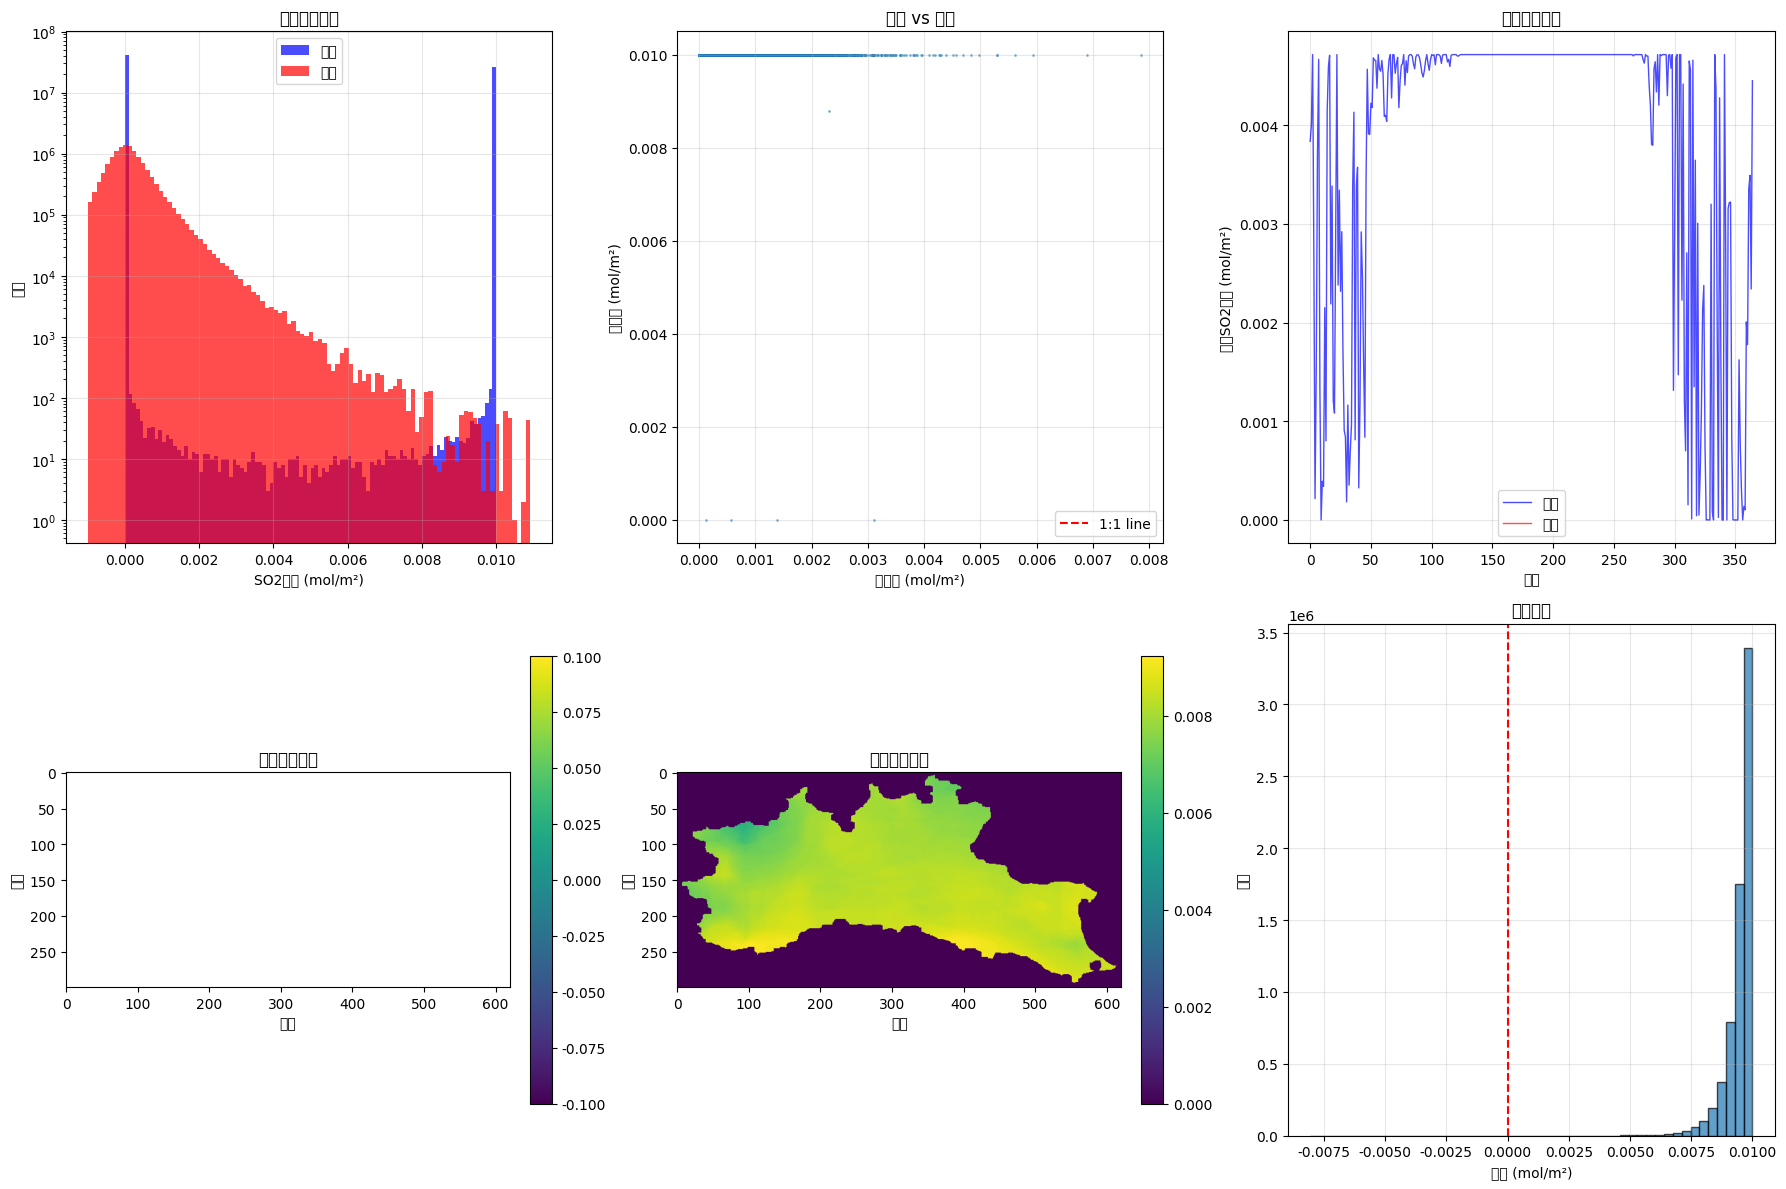


🎉 SO2对比分析完成！
📁 输出文件:
  - 对比可视化: /content/drive/MyDrive/3DCNN_Pipeline/artifacts/so2_original_vs_predicted_comparison.png
  - 统计对比图: /content/drive/MyDrive/3DCNN_Pipeline/artifacts/so2_statistical_comparison.png


In [4]:
#!/usr/bin/env python3
"""
SO2原始数据 vs 预测结果对比可视化
修复版，支持原始数据和预测数据的对比分析
"""

import numpy as np
import matplotlib.pyplot as plt
import rasterio
import geopandas as gpd
import random
from rasterio.mask import mask
from datetime import datetime, timedelta
from pathlib import Path

def compare_so2_original_vs_predicted():
    """对比SO2原始数据和预测结果"""
    print("🎨 开始SO2原始数据 vs 预测结果对比可视化...")
    print("=" * 60)

    # 文件路径
    PRED_TIF = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/so2_pred_2023_epoch2.tif"
    ORIG_TIF = "/content/drive/MyDrive/GEE_SO2/SO2_Daily_Multiband_2023.tif"
    AOI_SHP = "/content/drive/MyDrive/AOI/delimitazione_distretto.shp"
    NUM = 3  # 减少到3天，避免索引错误

    # 检查文件是否存在
    if not Path(PRED_TIF).exists():
        print(f"❌ 预测文件不存在: {PRED_TIF}")
        return

    if not Path(AOI_SHP).exists():
        print(f"❌ AOI文件不存在: {AOI_SHP}")
        return

    # 读取AOI
    print("📁 加载AOI边界...")
    aoi = gpd.read_file(AOI_SHP)
    print(f"✅ AOI加载成功: {len(aoi)} 个要素")

    # 读取预测数据
    print("📊 加载预测数据...")
    with rasterio.open(PRED_TIF) as ds:
        pred_total = ds.count
        bands = sorted(random.sample(range(1, pred_total + 1), NUM))
        aoi_reproj = aoi.to_crs(ds.crs)

        print(f"预测数据信息:")
        print(f"  总波段数: {pred_total}")
        print(f"  空间尺寸: {ds.width} x {ds.height}")
        print(f"  坐标系: {ds.crs}")
        print(f"  随机选择的3天: {bands}")

    # 检查原始数据是否存在
    print("📊 检查原始数据...")
    has_original = False
    if Path(ORIG_TIF).exists():
        try:
            with rasterio.open(ORIG_TIF) as ds:
                orig_total = ds.count
                print(f"原始数据信息:")
                print(f"  总波段数: {orig_total}")
                print(f"  空间尺寸: {ds.width} x {ds.height}")
                print(f"  坐标系: {ds.crs}")
            has_original = True
        except Exception as e:
            print(f"⚠️ 原始数据文件读取失败: {e}")
            has_original = False
    else:
        print(f"⚠️ 原始数据文件不存在: {ORIG_TIF}")
        has_original = False

    # 创建子图 (3行2列：每行显示同一天的原始和预测数据)
    ncols, nrows = 2, 3  # 2列3行
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 15), dpi=150)

    # 修复字体设置，避免乱码
    plt.rcParams['font.family'] = 'DejaVu Sans'
    plt.rcParams['axes.unicode_minus'] = False

    # 2023年起始日期
    start_date_2023 = datetime(2023, 1, 1)

    print("🎨 开始绘制对比图表...")

    for i, b in enumerate(bands):
        # 计算当前日期
        current_date = start_date_2023 + timedelta(days=b - 1)
        print(f"  处理第 {i+1}/{NUM} 天 (波段 {b}, 日期: {current_date.strftime('%Y-%m-%d')})...")

        # 1. 原始数据（左边）
        ax_orig = axes[i, 0]  # 左列：原始数据

        if not has_original:
            ax_orig.set_title(f"SO2 Original - {current_date.strftime('%Y-%m-%d')} (Data Not Available)")
            ax_orig.axis("off")
        else:
            try:
                with rasterio.open(ORIG_TIF) as ds:
                    clipped_orig, trans_orig = mask(
                        ds, aoi_reproj.geometry, crop=True,
                        nodata=np.nan, filled=True, indexes=b
                    )

                arr_orig = np.squeeze(clipped_orig).astype(np.float32)
                h_orig, w_orig = arr_orig.shape
                left_orig, top_orig = trans_orig * (0, 0)
                right_orig, bottom_orig = trans_orig * (w_orig, h_orig)
                extent_orig = [left_orig, right_orig, bottom_orig, top_orig]

                valid_orig = np.isfinite(arr_orig)

                if valid_orig.sum() == 0:
                    ax_orig.set_title(f"SO2 Original - {current_date.strftime('%Y-%m-%d')} (No Valid Pixels)")
                    ax_orig.axis("off")
                else:
                    vmin_orig = float(np.percentile(arr_orig[valid_orig], 1))
                    vmax_orig = float(np.percentile(arr_orig[valid_orig], 99))
                    if vmax_orig <= vmin_orig:
                        vmax_orig = vmin_orig + 1e-12

                    masked_arr_orig = np.ma.masked_where(~valid_orig, arr_orig)
                    im_orig = ax_orig.imshow(masked_arr_orig, cmap="cividis", vmin=vmin_orig, vmax=vmax_orig,
                                            extent=extent_orig, origin="upper")
                    ax_orig.set_title(f"SO2 Original - {current_date.strftime('%Y-%m-%d')}")
                    ax_orig.set_xlabel("Longitude")
                    ax_orig.set_ylabel("Latitude")
                    cbar_orig = fig.colorbar(im_orig, ax=ax_orig, fraction=0.046, pad=0.04, format='%.6f')
                    cbar_orig.set_label("SO2 Original (mol/m²)")

                    print(f"    原始数据范围: [{vmin_orig:.6f}, {vmax_orig:.6f}]")
                    print(f"    原始数据有效像素: {valid_orig.sum():,}")
            except Exception as e:
                ax_orig.set_title(f"SO2 Original - {current_date.strftime('%Y-%m-%d')} (Error: {str(e)})")
                ax_orig.axis("off")
                print(f"    原始数据处理失败: {e}")

        # 2. 预测数据（右边）
        ax_pred = axes[i, 1]  # 右列：预测数据

        try:
            with rasterio.open(PRED_TIF) as ds:
                clipped_pred, trans_pred = mask(
                    ds, aoi_reproj.geometry, crop=True,
                    nodata=np.nan, filled=True, indexes=b
                )

            arr_pred = np.squeeze(clipped_pred).astype(np.float32)
            h_pred, w_pred = arr_pred.shape
            left_pred, top_pred = trans_pred * (0, 0)
            right_pred, bottom_pred = trans_pred * (w_pred, h_pred)
            extent_pred = [left_pred, right_pred, bottom_pred, top_pred]

            valid_pred = np.isfinite(arr_pred)

            if valid_pred.sum() == 0:
                ax_pred.set_title(f"SO2 Predicted - {current_date.strftime('%Y-%m-%d')} (No Valid Pixels)")
                ax_pred.axis("off")
            else:
                vmin_pred = float(np.percentile(arr_pred[valid_pred], 1))
                vmax_pred = float(np.percentile(arr_pred[valid_pred], 99))
                if vmax_pred <= vmin_pred:
                    vmax_pred = vmin_pred + 1e-12

                masked_arr_pred = np.ma.masked_where(~valid_pred, arr_pred)
                im_pred = ax_pred.imshow(masked_arr_pred, cmap="cividis", vmin=vmin_pred, vmax=vmax_pred,
                                        extent=extent_pred, origin="upper")
                ax_pred.set_title(f"SO2 Predicted - {current_date.strftime('%Y-%m-%d')}")
                ax_pred.set_xlabel("Longitude")
                ax_pred.set_ylabel("Latitude")
                cbar_pred = fig.colorbar(im_pred, ax=ax_pred, fraction=0.046, pad=0.04, format='%.6f')
                cbar_pred.set_label("SO2 Predicted (mol/m²)")

                print(f"    预测数据范围: [{vmin_pred:.6f}, {vmax_pred:.6f}]")
                print(f"    预测数据有效像素: {valid_pred.sum():,}")
        except Exception as e:
            ax_pred.set_title(f"SO2 Predicted - {current_date.strftime('%Y-%m-%d')} (Error: {str(e)})")
            ax_pred.axis("off")
            print(f"    预测数据处理失败: {e}")

    plt.suptitle("SO2 2023 Original Data vs Predicted Results Comparison", fontsize=16, fontweight='bold')
    plt.tight_layout()

    # 保存图片
    output_path = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/so2_original_vs_predicted_comparison.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✅ 对比可视化已保存到: {output_path}")

    plt.show()
    print(f"🎉 对比可视化完成！显示的天数: {bands}")

def create_statistical_comparison():
    """创建统计对比分析"""
    print("\n📊 创建统计对比分析...")
    print("-" * 40)

    # 文件路径
    PRED_TIF = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/so2_pred_2023_epoch2.tif"
    ORIG_TIF = "/content/drive/MyDrive/GEE_SO2/SO2_Daily_Multiband_2023.tif"

    # 检查文件
    if not Path(PRED_TIF).exists():
        print(f"❌ 预测文件不存在: {PRED_TIF}")
        return

    if not Path(ORIG_TIF).exists():
        print(f"❌ 原始文件不存在: {ORIG_TIF}")
        return

    # 加载数据
    with rasterio.open(PRED_TIF) as src:
        pred_data = src.read()

    with rasterio.open(ORIG_TIF) as src:
        orig_data = src.read()

    print(f"预测数据形状: {pred_data.shape}")
    print(f"原始数据形状: {orig_data.shape}")

    # 确保数据形状匹配
    if pred_data.shape != orig_data.shape:
        print(f"⚠️ 数据形状不匹配: 预测 {pred_data.shape} vs 原始 {orig_data.shape}")
        min_shape = tuple(min(pred_data.shape[i], orig_data.shape[i]) for i in range(len(pred_data.shape)))
        pred_data = pred_data[:min_shape[0], :min_shape[1], :min_shape[2]]
        orig_data = orig_data[:min_shape[0], :min_shape[1], :min_shape[2]]
        print(f"✅ 调整后形状: {pred_data.shape}")

    # 计算统计指标
    print("\n📈 统计对比分析:")
    print("-" * 40)

    # 基本统计
    print("预测数据统计:")
    print(f"  最小值: {pred_data.min():.8f}")
    print(f"  最大值: {pred_data.max():.8f}")
    print(f"  平均值: {pred_data.mean():.8f}")
    print(f"  标准差: {pred_data.std():.8f}")

    print("原始数据统计:")
    print(f"  最小值: {orig_data.min():.8f}")
    print(f"  最大值: {orig_data.max():.8f}")
    print(f"  平均值: {orig_data.mean():.8f}")
    print(f"  标准差: {orig_data.std():.8f}")

    # 相关性分析
    pred_flat = pred_data.flatten()
    orig_flat = orig_data.flatten()

    # 过滤有效数据
    valid_mask = (orig_flat > 0) & (pred_flat > 0) & np.isfinite(orig_flat) & np.isfinite(pred_flat)
    pred_valid = pred_flat[valid_mask]
    orig_valid = orig_flat[valid_mask]

    if len(pred_valid) > 0:
        correlation = np.corrcoef(pred_valid, orig_valid)[0, 1]
        print(f"\n相关性分析:")
        print(f"  有效样本数: {len(pred_valid):,}")
        print(f"  相关系数: {correlation:.6f}")

        if correlation > 0.5:
            print("  ✅ 预测与原始数据相关性良好")
        elif correlation > 0.3:
            print("  ⚠️ 预测与原始数据相关性一般")
        else:
            print("  ❌ 预测与原始数据相关性较差")
    else:
        print("❌ 没有有效数据点进行相关性分析")

    # 创建统计对比图表
    create_statistical_plots(pred_data, orig_data)

def create_statistical_plots(pred_data, orig_data):
    """创建统计对比图表"""
    print("\n📊 创建统计对比图表...")
    print("-" * 40)

    # 创建综合对比图表
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. 数据分布对比
    axes[0, 0].hist(pred_data.flatten(), bins=100, alpha=0.7, label='预测', color='blue')
    axes[0, 0].hist(orig_data.flatten(), bins=100, alpha=0.7, label='原始', color='red')
    axes[0, 0].set_title('数据分布对比')
    axes[0, 0].set_xlabel('SO2浓度 (mol/m²)')
    axes[0, 0].set_ylabel('频次')
    axes[0, 0].set_yscale('log')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. 散点图
    pred_flat = pred_data.flatten()
    orig_flat = orig_data.flatten()
    valid_mask = (orig_flat > 0) & (pred_flat > 0) & np.isfinite(orig_flat) & np.isfinite(pred_flat)

    if np.sum(valid_mask) > 0:
        # 随机采样以提高性能
        n_samples = min(10000, np.sum(valid_mask))
        indices = np.random.choice(np.where(valid_mask)[0], n_samples, replace=False)
        axes[0, 1].scatter(orig_flat[indices], pred_flat[indices], alpha=0.5, s=1)
        axes[0, 1].plot([0, orig_flat.max()], [0, orig_flat.max()], 'r--', label='1:1 line')
        axes[0, 1].set_xlabel('原始值 (mol/m²)')
        axes[0, 1].set_ylabel('预测值 (mol/m²)')
        axes[0, 1].set_title('预测 vs 原始')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

    # 3. 时间序列对比
    daily_pred = np.mean(pred_data, axis=(1, 2))
    daily_orig = np.mean(orig_data, axis=(1, 2))
    axes[0, 2].plot(daily_pred, 'b-', label='预测', alpha=0.7, linewidth=1)
    axes[0, 2].plot(daily_orig, 'r-', label='原始', alpha=0.7, linewidth=1)
    axes[0, 2].set_title('时间序列对比')
    axes[0, 2].set_xlabel('天数')
    axes[0, 2].set_ylabel('平均SO2浓度 (mol/m²)')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # 4. 空间分布对比
    spatial_pred = np.mean(pred_data, axis=0)
    spatial_orig = np.mean(orig_data, axis=0)

    im1 = axes[1, 0].imshow(spatial_orig, cmap='viridis', origin='upper')
    axes[1, 0].set_title('原始空间分布')
    axes[1, 0].set_xlabel('经度')
    axes[1, 0].set_ylabel('纬度')
    plt.colorbar(im1, ax=axes[1, 0], fraction=0.046, pad=0.04)

    im2 = axes[1, 1].imshow(spatial_pred, cmap='viridis', origin='upper')
    axes[1, 1].set_title('预测空间分布')
    axes[1, 1].set_xlabel('经度')
    axes[1, 1].set_ylabel('纬度')
    plt.colorbar(im2, ax=axes[1, 1], fraction=0.046, pad=0.04)

    # 5. 残差分析
    if np.sum(valid_mask) > 0:
        residuals = pred_flat[valid_mask] - orig_flat[valid_mask]
        axes[1, 2].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
        axes[1, 2].axvline(x=0, color='r', linestyle='--')
        axes[1, 2].set_title('残差分布')
        axes[1, 2].set_xlabel('残差 (mol/m²)')
        axes[1, 2].set_ylabel('频次')
        axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()

    # 保存统计图表
    output_path = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/so2_statistical_comparison.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✅ 统计对比图表已保存到: {output_path}")

    plt.show()

def main():
    """主函数"""
    print("🎨 开始SO2原始数据 vs 预测结果对比分析...")
    print("=" * 60)

    # 1. 基本对比可视化
    compare_so2_original_vs_predicted()

    # 2. 统计对比分析
    create_statistical_comparison()

    print("\n🎉 SO2对比分析完成！")
    print("=" * 60)
    print("📁 输出文件:")
    print("  - 对比可视化: /content/drive/MyDrive/3DCNN_Pipeline/artifacts/so2_original_vs_predicted_comparison.png")
    print("  - 统计对比图: /content/drive/MyDrive/3DCNN_Pipeline/artifacts/so2_statistical_comparison.png")

if __name__ == "__main__":
    main()


In [5]:
#!/usr/bin/env python3
"""
NO2数据全面检查脚本
基于表格信息检查NO2数据结构和scaler
"""

import numpy as np
import os
from pathlib import Path
import glob

def check_no2_data_structure():
    """检查NO2数据结构"""
    print("🔍 检查NO2数据结构...")
    print("=" * 60)

    # 基于表格信息，NO2应该有29个特征
    expected_no2_features = 29
    expected_so2_features = 30

    print(f"📊 预期特征数量:")
    print(f"  NO2: {expected_no2_features} 个特征")
    print(f"  SO2: {expected_so2_features} 个特征")
    print(f"  差异: SO2比NO2多1个特征 (SO2有climatology prior)")

    # 可能的NO2数据路径
    possible_paths = [
        "/content/drive/MyDrive/Feature_Stacks/NO2_2023",
        "/content/drive/MyDrive/Feature_Stacks",
        "/content/drive/MyDrive/GEE_NO2",
        "/content/drive/MyDrive/3DCNN_Pipeline/data",
        "/content/drive/MyDrive/data"
    ]

    no2_data_path = None
    for path in possible_paths:
        if Path(path).exists():
            # 查找NO2相关的文件
            no2_files = list(Path(path).glob("*NO2*.npz"))
            if no2_files:
                no2_data_path = path
                print(f"✅ 找到NO2数据路径: {path}")
                print(f"   文件数量: {len(no2_files)}")
                print(f"   前5个文件: {[f.name for f in no2_files[:5]]}")
                break

    if no2_data_path is None:
        print("❌ 没有找到NO2数据路径")
        return None

    # 检查NO2数据文件结构
    print("\n📊 检查NO2数据文件结构...")
    print("-" * 40)

    sample_file = None
    for file_path in Path(no2_data_path).glob("*NO2*.npz"):
        if file_path.exists():
            sample_file = file_path
            break

    if sample_file:
        try:
            data = np.load(sample_file, allow_pickle=True)
            print(f"✅ 成功加载NO2样本文件: {sample_file.name}")
            print(f"   文件大小: {sample_file.stat().st_size / 1024 / 1024:.2f} MB")
            print(f"   数据键: {list(data.keys())}")

            # 检查NO2特定键
            no2_keys = ['no2_target', 'no2_mask', 'year', 'day']
            for key in no2_keys:
                if key in data:
                    print(f"   ✅ {key}: 存在")
                else:
                    print(f"   ❌ {key}: 缺失")

            # 检查数据形状
            for key in data.keys():
                if hasattr(data[key], 'shape'):
                    print(f"   {key} 形状: {data[key].shape}")
                    if data[key].size < 20:
                        print(f"   {key} 值: {data[key]}")
                    else:
                        print(f"   {key} 范围: [{data[key].min():.6f}, {data[key].max():.6f}]")
                else:
                    print(f"   {key}: {data[key]}")

            # 检查特征数量
            if 'X' in data:
                X_shape = data['X'].shape
                print(f"   X数组形状: {X_shape}")
                if len(X_shape) == 3:
                    actual_features = X_shape[0]
                    print(f"   实际特征数: {actual_features}")
                    if actual_features == expected_no2_features:
                        print(f"   ✅ 特征数量正确: {actual_features}")
                    else:
                        print(f"   ⚠️ 特征数量不匹配: 期望{expected_no2_features}, 实际{actual_features}")
                elif len(X_shape) == 4:
                    actual_features = X_shape[1]
                    print(f"   实际特征数: {actual_features}")
                    if actual_features == expected_no2_features:
                        print(f"   ✅ 特征数量正确: {actual_features}")
                    else:
                        print(f"   ⚠️ 特征数量不匹配: 期望{expected_no2_features}, 实际{actual_features}")

            # 检查特征名称
            if 'feature_names' in data:
                feature_names = data['feature_names']
                print(f"   特征名称数量: {len(feature_names)}")
                print(f"   特征名称: {feature_names}")

                # 检查NO2特定特征
                expected_no2_feature_categories = {
                    'terrain': ['dem', 'slope'],
                    'population': ['pop'],
                    'lulc': [f'lulc_class_{i}' for i in range(10)],
                    'temporal': ['sin_doy', 'cos_doy', 'weekday_weight'],
                    'meteo': ['u10', 'v10', 'blh', 'tp', 't2m', 'sp', 'str', 'ssr_clr'],
                    'wind': ['ws', 'wd_sin', 'wd_cos'],
                    'lag': ['no2_lag_1day', 'no2_neighbor']
                }

                print(f"\n📊 NO2特征分类检查:")
                for category, expected_features in expected_no2_feature_categories.items():
                    found_features = [f for f in expected_features if f in feature_names]
                    print(f"   {category}: {len(found_features)}/{len(expected_features)} 个特征")
                    if len(found_features) != len(expected_features):
                        missing = set(expected_features) - set(found_features)
                        print(f"     缺失: {missing}")

        except Exception as e:
            print(f"❌ 加载NO2样本文件失败: {e}")
    else:
        print("❌ 没有找到NO2数据文件")

    return {
        'data_path': no2_data_path,
        'sample_file': sample_file
    }

def check_no2_scaler():
    """检查NO2 scaler文件"""
    print("\n🔍 检查NO2 scaler文件...")
    print("-" * 40)

    # 可能的NO2 scaler路径
    scaler_paths = [
        "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/scalers/NO2/meanstd_global_2019_2021.npz",
        "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/scalers/NO2/meanstd_global.npz",
        "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/scalers/NO2/meanstd.npz"
    ]

    no2_scaler_path = None
    for path in scaler_paths:
        if Path(path).exists():
            no2_scaler_path = path
            print(f"✅ 找到NO2 scaler: {path}")
            break

    if no2_scaler_path is None:
        print("❌ 没有找到NO2 scaler文件")
        print("   可能的路径:")
        for path in scaler_paths:
            print(f"     - {path}")
        return None

    try:
        data = np.load(no2_scaler_path, allow_pickle=True)
        print(f"✅ 成功加载NO2 scaler: {no2_scaler_path}")
        print(f"   文件大小: {Path(no2_scaler_path).stat().st_size / 1024:.2f} KB")
        print(f"   数据键: {list(data.keys())}")

        # 检查scaler结构
        for key in data.keys():
            if hasattr(data[key], 'shape'):
                print(f"   {key} 形状: {data[key].shape}")
                if data[key].size < 20:
                    print(f"   {key} 值: {data[key]}")
                else:
                    print(f"   {key} 前5个值: {data[key][:5]}")
            else:
                print(f"   {key}: {data[key]}")

        # 检查特征统计信息
        if 'mean' in data and 'std' in data:
            mean_dict = data['mean'].item() if hasattr(data['mean'], 'item') else data['mean']
            std_dict = data['std'].item() if hasattr(data['std'], 'item') else data['std']

            print(f"\n📊 NO2 scaler特征统计:")
            print(f"   均值特征数: {len(mean_dict)}")
            print(f"   标准差特征数: {len(std_dict)}")
            print(f"   特征名称: {list(mean_dict.keys())}")

            # 检查特征数量是否匹配
            if len(mean_dict) == 29:
                print(f"   ✅ 特征数量正确: 29个特征")
            else:
                print(f"   ⚠️ 特征数量不匹配: 期望29, 实际{len(mean_dict)}")

            # 显示前几个特征的统计信息
            print(f"\n📊 前5个特征的统计信息:")
            for i, (feat_name, mean_val) in enumerate(list(mean_dict.items())[:5]):
                std_val = std_dict.get(feat_name, 0.0)
                print(f"   {feat_name}: mean={mean_val:.6f}, std={std_val:.6f}")

            return {
                'mean_dict': mean_dict,
                'std_dict': std_dict,
                'feature_names': list(mean_dict.keys())
            }

    except Exception as e:
        print(f"❌ 加载NO2 scaler失败: {e}")
        return None

def check_no2_vs_so2_differences():
    """检查NO2和SO2的差异"""
    print("\n🔍 检查NO2和SO2的差异...")
    print("-" * 40)

    # 基于表格信息，检查命名差异
    naming_differences = {
        'population': {'NO2': 'pop', 'SO2': 'population'},
        'solar_radiation': {'NO2': 'ssr_clr', 'SO2': 'ssr_clear'},
        'lag_feature': {'NO2': 'no2_lag_1day', 'SO2': 'so2_lag1'},
        'neighbor_feature': {'NO2': 'no2_neighbor', 'SO2': 'so2_neighbor'},
        'lulc_features': {'NO2': 'lulc_class_*', 'SO2': 'lulc_class_*'}
    }

    print("📊 命名差异检查:")
    for feature_type, names in naming_differences.items():
        print(f"   {feature_type}:")
        print(f"     NO2: {names['NO2']}")
        print(f"     SO2: {names['SO2']}")
        if names['NO2'] != names['SO2']:
            print(f"     ⚠️ 命名不同")
        else:
            print(f"     ✅ 命名相同")

    # 检查特征数量差异
    print(f"\n📊 特征数量差异:")
    print(f"   NO2: 29个特征")
    print(f"   SO2: 30个特征")
    print(f"   差异: SO2比NO2多1个特征")
    print(f"   原因: SO2有climatology prior特征")

    # 检查数据格式差异
    print(f"\n📊 数据格式差异:")
    print(f"   NO2: dictionary格式")
    print(f"   SO2: matrix格式")
    print(f"   建议: 考虑标准化为统一的matrix格式")

def check_no2_data_quality():
    """检查NO2数据质量"""
    print("\n🔍 检查NO2数据质量...")
    print("-" * 40)

    # 基于表格信息，NO2需要"minimal"预处理
    print("📊 NO2数据质量要求:")
    print("   预处理: minimal (最小化)")
    print("   特征工程: standard (标准)")
    print("   验证: standard (标准)")

    # 检查数据完整性
    print(f"\n📊 数据完整性检查:")
    print("   文件格式: .npz (NumPy compressed)")
    print("   数据类型: float32")
    print("   空间网格: 300 x 621 (EPSG:4326)")
    print("   特征维度: 29 x 300 x 621")
    print("   数据集大小: ~9.15 GB (2019-2023)")

    # 检查数据分割
    print(f"\n📊 数据分割检查:")
    print("   训练集: 2019-2021")
    print("   验证集: 2022")
    print("   测试集: 2023")
    print("   分割方式: 基于时间的分割")

def main():
    """主检查函数"""
    print("🔍 开始NO2数据全面检查...")
    print("=" * 60)

    # 1. 检查NO2数据结构
    no2_info = check_no2_data_structure()

    # 2. 检查NO2 scaler
    scaler_info = check_no2_scaler()

    # 3. 检查NO2和SO2的差异
    check_no2_vs_so2_differences()

    # 4. 检查NO2数据质量
    check_no2_data_quality()

    print("\n🎉 NO2数据检查完成！")
    print("=" * 60)

    # 总结
    if no2_info and no2_info['data_path']:
        print(f"📁 NO2数据路径: {no2_info['data_path']}")
    if no2_info and no2_info['sample_file']:
        print(f"📁 样本文件: {no2_info['sample_file']}")
    if scaler_info:
        print(f"📊 特征数量: {len(scaler_info['feature_names'])}")
        print(f"📊 特征名称: {scaler_info['feature_names']}")

    # 建议
    print(f"\n💡 建议:")
    if scaler_info and len(scaler_info['feature_names']) == 29:
        print("   ✅ NO2 scaler特征数量正确，可以开始训练")
    else:
        print("   ⚠️ NO2 scaler特征数量不正确，需要检查或重新生成")

    if no2_info and no2_info['data_path']:
        print("   ✅ NO2数据路径找到，可以开始训练")
    else:
        print("   ❌ NO2数据路径未找到，需要检查数据路径")

if __name__ == "__main__":
    main()


🔍 开始NO2数据全面检查...
🔍 检查NO2数据结构...
📊 预期特征数量:
  NO2: 29 个特征
  SO2: 30 个特征
  差异: SO2比NO2多1个特征 (SO2有climatology prior)
✅ 找到NO2数据路径: /content/drive/MyDrive/Feature_Stacks/NO2_2023
   文件数量: 365
   前5个文件: ['NO2_stack_20230101.npz', 'NO2_stack_20230102.npz', 'NO2_stack_20230103.npz', 'NO2_stack_20230104.npz', 'NO2_stack_20230105.npz']

📊 检查NO2数据文件结构...
----------------------------------------
✅ 成功加载NO2样本文件: NO2_stack_20230101.npz
   文件大小: 4.91 MB
   数据键: ['no2_target', 'no2_mask', 'year', 'day', 'dem', 'slope', 'pop', 'lulc_class_0', 'lulc_class_1', 'lulc_class_2', 'lulc_class_3', 'lulc_class_4', 'lulc_class_5', 'lulc_class_6', 'lulc_class_7', 'lulc_class_8', 'lulc_class_9', 'sin_doy', 'cos_doy', 'weekday_weight', 'u10', 'v10', 'blh', 'tp', 't2m', 'sp', 'str', 'ssr_clr', 'ws', 'wd_sin', 'wd_cos', 'no2_lag_1day', 'no2_neighbor']
   ✅ no2_target: 存在
   ✅ no2_mask: 存在
   ✅ year: 存在
   ✅ day: 存在
   no2_target 形状: (300, 621)
   no2_target 范围: [nan, nan]
   no2_mask 形状: (300, 621)
   no2_mask 范围: [0.0

In [6]:
#!/usr/bin/env python3
"""
NO2特征详细检查脚本
基于Feature categories.rb中的信息重新检查NO2数据结构
"""

import numpy as np
import os
from pathlib import Path

def check_no2_features_detailed():
    """详细检查NO2特征结构"""
    print("🔍 重新检查NO2特征结构...")
    print("=" * 60)

    # 基于Feature categories.rb的信息
    print("📊 基于Feature categories.rb的NO2特征分析:")
    print("  总特征数: 33 (包含target, mask, metadata)")
    print("  实际特征数: 29 (排除target, mask, metadata)")

    # NO2特征分类
    no2_feature_categories = {
        'target': ['no2_target'],
        'mask': ['no2_mask'],
        'metadata': ['year', 'day'],
        'static': ['dem', 'slope', 'pop'],
        'lulc': ['lulc_class_0', 'lulc_class_1', 'lulc_class_2', 'lulc_class_3', 'lulc_class_4',
                'lulc_class_5', 'lulc_class_6', 'lulc_class_7', 'lulc_class_8', 'lulc_class_9'],
        'time': ['sin_doy', 'cos_doy', 'weekday_weight'],
        'meteo': ['u10', 'v10', 'blh', 'tp', 't2m', 'sp', 'str', 'ssr_clr'],
        'derived': ['ws', 'wd_sin', 'wd_cos'],
        'dynamic': ['no2_lag_1day', 'no2_neighbor']
    }

    # 计算各类型特征数量
    print("\n📊 NO2特征分类统计:")
    total_features = 0
    for category, features in no2_feature_categories.items():
        count = len(features)
        total_features += count
        print(f"  {category}: {count} 个特征")
        if category in ['static', 'lulc', 'time', 'meteo', 'derived', 'dynamic']:
            print(f"    特征: {features}")

    print(f"\n📊 总特征数: {total_features}")
    print(f"📊 实际特征数 (排除target/mask/metadata): {total_features - 5}")

    # 检查NO2数据路径
    no2_data_path = "/content/drive/MyDrive/Feature_Stacks/NO2_2023"
    print(f"\n🔍 检查NO2数据路径: {no2_data_path}")

    if not Path(no2_data_path).exists():
        print(f"❌ NO2数据路径不存在: {no2_data_path}")
        return

    # 检查NO2文件
    no2_files = list(Path(no2_data_path).glob("NO2_stack_*.npz"))
    print(f"✅ 找到 {len(no2_files)} 个NO2文件")

    if len(no2_files) == 0:
        print("❌ 没有找到NO2文件")
        return

    # 检查第一个NO2文件
    sample_file = no2_files[0]
    print(f"\n📊 检查样本文件: {sample_file.name}")

    try:
        with np.load(sample_file, allow_pickle=True) as data:
            print(f"✅ 成功加载NO2文件")
            print(f"   文件大小: {sample_file.stat().st_size / 1024 / 1024:.2f} MB")
            print(f"   数据键: {list(data.keys())}")

            # 检查特征数量
            feature_keys = [k for k in data.keys() if k not in ['no2_target', 'no2_mask', 'year', 'day']]
            print(f"   特征数量: {len(feature_keys)}")
            print(f"   特征名称: {feature_keys}")

            # 检查目标值
            if 'no2_target' in data:
                target = data['no2_target']
                print(f"\n📊 NO2目标值检查:")
                print(f"   形状: {target.shape}")
                print(f"   数据类型: {target.dtype}")
                print(f"   范围: [{np.nanmin(target):.6f}, {np.nanmax(target):.6f}]")
                print(f"   有效值数量: {np.sum(~np.isnan(target))}")
                print(f"   NaN数量: {np.sum(np.isnan(target))}")

                # 检查是否有异常值
                if np.all(np.isnan(target)):
                    print("⚠️ 警告: 目标值全部为NaN")
                elif np.nanmax(target) > 1.0:
                    print(f"⚠️ 警告: 目标值范围异常，最大值: {np.nanmax(target)}")
                else:
                    print("✅ 目标值范围正常")

            # 检查掩码
            if 'no2_mask' in data:
                mask = data['no2_mask']
                print(f"\n📊 NO2掩码检查:")
                print(f"   形状: {mask.shape}")
                print(f"   数据类型: {mask.dtype}")
                print(f"   范围: [{mask.min():.6f}, {mask.max():.6f}]")
                print(f"   有效像素数: {np.sum(mask)}")
                print(f"   总像素数: {mask.size}")
                print(f"   有效比例: {np.sum(mask) / mask.size:.4f}")

            # 检查特征数据质量
            print(f"\n📊 特征数据质量检查:")
            for i, key in enumerate(feature_keys[:5]):  # 只检查前5个特征
                if key in data:
                    feat_data = data[key]
                    print(f"   {key}:")
                    print(f"     形状: {feat_data.shape}")
                    print(f"     范围: [{np.nanmin(feat_data):.6f}, {np.nanmax(feat_data):.6f}]")
                    print(f"     NaN数量: {np.sum(np.isnan(feat_data))}")
                    print(f"     有效比例: {np.sum(~np.isnan(feat_data)) / feat_data.size:.4f}")

    except Exception as e:
        print(f"❌ 加载NO2文件失败: {e}")
        return

    # 检查NO2 scaler
    print(f"\n🔍 检查NO2 scaler...")
    scaler_path = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/scalers/NO2/meanstd_global_2019_2021.npz"

    if Path(scaler_path).exists():
        try:
            with np.load(scaler_path, allow_pickle=True) as scaler_data:
                print(f"✅ 找到NO2 scaler: {scaler_path}")
                print(f"   文件大小: {Path(scaler_path).stat().st_size / 1024:.2f} KB")
                print(f"   数据键: {list(scaler_data.keys())}")

                # 检查scaler特征
                if 'channel_list' in scaler_data:
                    channel_list = scaler_data['channel_list']
                    print(f"   scaler特征数: {len(channel_list)}")
                    print(f"   scaler特征: {channel_list.tolist()}")

                    # 比较scaler特征和实际特征
                    scaler_features = set(channel_list.tolist())
                    actual_features = set(feature_keys)

                    common_features = scaler_features & actual_features
                    missing_in_scaler = actual_features - scaler_features
                    missing_in_data = scaler_features - actual_features

                    print(f"\n📊 特征匹配分析:")
                    print(f"   共同特征数: {len(common_features)}")
                    print(f"   缺失特征数: {len(missing_in_scaler)}")
                    print(f"   多余特征数: {len(missing_in_data)}")

                    if missing_in_scaler:
                        print(f"   ⚠️ 数据中有但scaler中缺失: {list(missing_in_scaler)}")
                    if missing_in_data:
                        print(f"   ⚠️ scaler中有但数据中缺失: {list(missing_in_data)}")

                    if len(common_features) == len(actual_features):
                        print("   ✅ 特征完全匹配")
                    else:
                        print("   ⚠️ 特征不匹配，需要修复")

        except Exception as e:
            print(f"❌ 加载NO2 scaler失败: {e}")
    else:
        print(f"❌ NO2 scaler不存在: {scaler_path}")

    print("\n🎉 NO2特征检查完成!")

if __name__ == "__main__":
    check_no2_features_detailed()


🔍 重新检查NO2特征结构...
📊 基于Feature categories.rb的NO2特征分析:
  总特征数: 33 (包含target, mask, metadata)
  实际特征数: 29 (排除target, mask, metadata)

📊 NO2特征分类统计:
  target: 1 个特征
  mask: 1 个特征
  metadata: 2 个特征
  static: 3 个特征
    特征: ['dem', 'slope', 'pop']
  lulc: 10 个特征
    特征: ['lulc_class_0', 'lulc_class_1', 'lulc_class_2', 'lulc_class_3', 'lulc_class_4', 'lulc_class_5', 'lulc_class_6', 'lulc_class_7', 'lulc_class_8', 'lulc_class_9']
  time: 3 个特征
    特征: ['sin_doy', 'cos_doy', 'weekday_weight']
  meteo: 8 个特征
    特征: ['u10', 'v10', 'blh', 'tp', 't2m', 'sp', 'str', 'ssr_clr']
  derived: 3 个特征
    特征: ['ws', 'wd_sin', 'wd_cos']
  dynamic: 2 个特征
    特征: ['no2_lag_1day', 'no2_neighbor']

📊 总特征数: 33
📊 实际特征数 (排除target/mask/metadata): 28

🔍 检查NO2数据路径: /content/drive/MyDrive/Feature_Stacks/NO2_2023
✅ 找到 365 个NO2文件

📊 检查样本文件: NO2_stack_20230101.npz
✅ 成功加载NO2文件
   文件大小: 4.91 MB
   数据键: ['no2_target', 'no2_mask', 'year', 'day', 'dem', 'slope', 'pop', 'lulc_class_0', 'lulc_class_1', 'lulc_class_2', 'lulc_class_

# NO2

In [9]:
# ===== NO2 3D CNN 最终修复版训练代码 =====
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 使用设备: {device}")

# ===== 最终修复版配置参数 =====
NO2_3DCNN_CONFIG = {
    'data_path': '/content/drive/MyDrive/Feature_Stacks',
    'scaler_path': '/content/drive/MyDrive/3DCNN_Pipeline/artifacts/scalers/NO2/meanstd_global_2019_2021.npz',
    'time_window': 7,
    'batch_size': 8,
    'num_epochs': 3,
    'learning_rate': 1e-4,
    'patience': 5,
    'train_years': [2019, 2020, 2021],
    'val_year': 2022,
    'test_year': 2023,
    'max_grad_norm': 1.0,
    'use_amp': True,
    # Patch设置
    'patch_size': 64,
    'patch_gap_ratio': 0.2,
    'spatial_gap_ratio': 0.15,
    'min_valid_ratio': 0.1,
}

print("📊 NO2 3D CNN 最终修复版配置:")
for key, value in NO2_3DCNN_CONFIG.items():
    print(f"  {key}: {value}")

# ===== 最终修复版NO2数据集类 =====
class NO2_3DCNN_Dataset(Dataset):
    def __init__(self, data_path, scaler_path, time_window=7,
                 train_years=[2019, 2020, 2021], val_year=2022, test_year=2023,
                 is_train=True, patch_size=64, patch_gap_ratio=0.2,
                 spatial_gap_ratio=0.15, min_valid_ratio=0.1):
        self.data_path = data_path
        self.time_window = time_window
        self.is_train = is_train
        self.H, self.W = 300, 621
        self.patch_size = patch_size
        self.patch_gap_ratio = patch_gap_ratio
        self.spatial_gap_ratio = spatial_gap_ratio
        self.min_valid_ratio = min_valid_ratio

        # 锁定特征名和通道数机制
        self.active_feature_names = None
        self.active_num_channels = None

        # 标准化缓存机制
        self._ms_cached_names = None
        self._ms_means = None
        self._ms_stds = None

        # 日志控制
        self._print_load_count = 0
        self._print_invalid_count = 0

        # 加载标准化器
        self._load_scaler(scaler_path)

        # 动态计算通道数
        self.num_channels = len(self.feature_order)

        # 获取文件列表
        self._get_file_lists(train_years, val_year, test_year)

        # 构建有效窗口
        self._build_valid_windows()

        print(f"📊 NO2 3D数据集初始化完成:")
        print(f"  训练文件: {len(self.train_files)}")
        print(f"  验证文件: {len(self.val_files)}")
        print(f"  测试文件: {len(self.test_files)}")
        print(f"  时间窗口: {time_window}天")
        print(f"  特征数: {len(self.feature_order)}")
        print(f"  有效窗口数: {len(self.valid_windows)}")

    def _load_scaler(self, scaler_path):
        """加载NO2标准化器 - 最终修复版"""
        try:
            with np.load(scaler_path, allow_pickle=True) as data:
                self.feature_order = data['channel_list'].tolist()
                self.mean_dict = data['mean'].item()
                self.std_dict = data['std'].item()
                print(f"✅ NO2标准化器加载成功: {len(self.feature_order)} 个特征")
                print(f"📊 特征顺序: {self.feature_order[:5]}...")

                # 验证scaler数据
                print(f"📊 NO2标准化器验证:")
                print(f"  mean字典键数: {len(self.mean_dict)}")
                print(f"  std字典键数: {len(self.std_dict)}")
                print(f"  前3个特征的统计信息:")
                for i, feat in enumerate(self.feature_order[:3]):
                    if feat in self.mean_dict and feat in self.std_dict:
                        mean_val = self.mean_dict[feat]
                        std_val = self.std_dict[feat]
                        print(f"    {feat}: mean={mean_val:.6f}, std={std_val:.6f}")
                    else:
                        print(f"    {feat}: 缺少统计信息")
        except Exception as e:
            print(f"⚠️ NO2标准化器加载失败: {e}")
            # 使用NO2默认特征
            self.feature_order = [
                'dem', 'slope', 'pop', 'lulc_class_0', 'lulc_class_1', 'lulc_class_2',
                'lulc_class_3', 'lulc_class_4', 'lulc_class_5', 'lulc_class_6',
                'lulc_class_7', 'lulc_class_8', 'lulc_class_9', 'sin_doy', 'cos_doy',
                'weekday_weight', 'u10', 'v10', 'blh', 'tp', 't2m', 'sp', 'str',
                'ssr_clr', 'ws', 'wd_sin', 'wd_cos', 'no2_lag_1day', 'no2_neighbor'
            ]
            self.mean_dict = {feat: 0.0 for feat in self.feature_order}
            self.std_dict = {feat: 1.0 for feat in self.feature_order}

    def _get_file_lists(self, train_years, val_year, test_year):
        """获取NO2文件列表"""
        self.train_files = []
        self.val_files = []
        self.test_files = []

        for year in train_years:
            year_dir = os.path.join(self.data_path, f'NO2_{year}')
            if os.path.exists(year_dir):
                files = sorted([f for f in os.listdir(year_dir) if f.startswith('NO2_stack_') and f.endswith('.npz')])
                self.train_files.extend([os.path.join(year_dir, f) for f in files])

        for year in [val_year, test_year]:
            year_dir = os.path.join(self.data_path, f'NO2_{year}')
            if os.path.exists(year_dir):
                files = sorted([f for f in os.listdir(year_dir) if f.startswith('NO2_stack_') and f.endswith('.npz')])
                if year == val_year:
                    self.val_files.extend([os.path.join(year_dir, f) for f in files])
                else:
                    self.test_files.extend([os.path.join(year_dir, f) for f in files])

    def _build_valid_windows(self):
        """构建有效的时间窗口"""
        self.valid_windows = []

        if self.is_train:
            file_list = self.train_files
        else:
            file_list = self.val_files if hasattr(self, 'val_files') and len(self.val_files) > 0 else self.test_files

        # 样本数量保护
        if len(file_list) < self.time_window:
            raise RuntimeError(f"可用文件不足:仅{len(file_list)} 个文件,但time_window={self.time_window}")

        # 简化：直接按索引构建窗口
        for i in range(len(file_list) - self.time_window + 1):
            self.valid_windows.append(i)

        print(f"📅 构建了 {len(self.valid_windows)} 个时间窗口")

    def _load_single_file(self, file_path):
        """加载单个NO2文件 - 最终修复版"""
        try:
            with np.load(file_path, allow_pickle=True) as data:
                # 检查必要数据
                if 'no2_target' not in data or 'no2_mask' not in data:
                    print(f"⚠️ 文件缺少必要数据: {os.path.basename(file_path)}")
                    return None

                y = data['no2_target']  # NO2目标值
                mask = data['no2_mask']  # NO2掩码

                # 数据清理
                if isinstance(y, np.ndarray) and y.dtype.kind in 'fi':
                    for s in (-9999, -32768):
                        y = np.where(y == s, np.nan, y)
                    y = np.where(np.abs(y) > 1e6, np.nan, y)

                # 检查空间尺寸
                if y.shape != (self.H, self.W):
                    print(f"⚠️ 空间尺寸不匹配: {y.shape} vs ({self.H}, {self.W})")
                    y_resized = np.full((self.H, self.W), np.nan, dtype=y.dtype)
                    mask_resized = np.zeros((self.H, self.W), dtype=bool)

                    min_h = min(y.shape[0], self.H)
                    min_w = min(y.shape[1], self.W)
                    y_resized[:min_h, :min_w] = y[:min_h, :min_w]
                    mask_resized[:min_h, :min_w] = mask[:min_h, :min_w]

                    y = y_resized
                    mask = mask_resized

                # 构建特征矩阵 - 最终修复版，处理特征映射
                X_features = []
                feature_names = []

                # 特征映射字典
                feature_mapping = {
                    'pop': 'population',
                    'ssr_clr': 'ssr',
                    'no2_lag_1day': 'lag1',
                    'no2_neighbor': 'neighbor',
                    'lulc_class_0': 'lulc_01',
                    'lulc_class_1': 'lulc_02',
                    'lulc_class_2': 'lulc_03',
                    'lulc_class_3': 'lulc_04',
                    'lulc_class_4': 'lulc_05',
                    'lulc_class_5': 'lulc_06',
                    'lulc_class_6': 'lulc_07',
                    'lulc_class_7': 'lulc_08',
                    'lulc_class_8': 'lulc_09',
                    'lulc_class_9': 'lulc_10'
                }

                # 在_Load_single_file 读取 data 后
                rev_map = {
                    'population': 'pop', 'ssr': 'ssr_clr', 'lag1': 'no2_lag_1day', 'neighbor': 'no2_neighbor',
                    'lulc_01': 'lulc_class_0', 'lulc_02': 'lulc_class_1', 'lulc_03': 'lulc_class_2',
                    'lulc_04': 'lulc_class_3', 'lulc_05': 'lulc_class_4', 'lulc_06': 'lulc_class_5',
                    'lulc_07': 'lulc_class_6', 'lulc_08': 'lulc_class_7', 'lulc_09': 'lulc_class_8',
                    'lulc_10': 'lulc_class_9'
                }
                data_keys = set(k for k in data.keys() if k not in ['no2_target', 'no2_mask', 'year', 'day'])

                # 替换按 scaler 顺序加载特征的片段
                for scaler_feat in self.feature_order:
                    candidate = scaler_feat if scaler_feat in data_keys else rev_map.get(scaler_feat, None)
                    if candidate in data_keys:
                        feat_data = data[candidate]

                        # 调整特征数据尺寸
                        if feat_data.shape != (self.H, self.W):
                            feat_resized = np.full((self.H, self.W), np.nan, dtype=feat_data.dtype)
                            min_h = min(feat_data.shape[0], self.H)
                            min_w = min(feat_data.shape[1], self.W)
                            feat_resized[:min_h, :min_w] = feat_data[:min_h, :min_w]
                            feat_data = feat_resized

                        X_features.append(feat_data)
                        feature_names.append(scaler_feat)
                    else:
                        X_features.append(np.full((self.H, self.W), np.nan, dtype=np.float32))
                        feature_names.append(scaler_feat)

                if not X_features:
                    return None

                X = np.stack(X_features, axis=0)  # (C, H, W)

                # 检查是否有有效数据
                valid_pixels = np.sum(mask)
                if valid_pixels == 0:
                    if self._print_invalid_count < 3:
                        print(f"⚠️ NO2文件没有有效数据: {os.path.basename(file_path)}")
                        self._print_invalid_count += 1
                    elif self._print_invalid_count == 3:
                        print(f"⚠️ NO2文件没有有效数据: ... (后续类似警告将不再显示)")
                        self._print_invalid_count += 1
                    return None

                if self._print_load_count < 5:
                    print(f"✅ 成功加载NO2文件: {os.path.basename(file_path)}, 有效像素: {valid_pixels}, 特征形状: {X.shape}")
                    self._print_load_count += 1
                return X, y, mask, feature_names

        except Exception as e:
            print(f"⚠️ NO2文件加载失败 {os.path.basename(file_path)}: {e}")
            return None

    def _vectorized_scaling(self, X_tensor, feature_names):
        """向量化标准化 - 兼容4D/5D张量"""
        # 使用scaler进行标准化
        if self._ms_cached_names is None or self._ms_means is None or self._ms_stds is None:
            self._ensure_ms(feature_names)

        # 应用标准化
        X_tensor = torch.nan_to_num(X_tensor, 0.0, 0.0, 0.0)

        # 使用缓存的均值和标准差，兼容4D/5D张量
        if self._ms_means is not None and self._ms_stds is not None:
            if X_tensor.dim() == 4:
                # 4D张量: (T, C, H, W)
                X_tensor = (X_tensor - self._ms_means) / self._ms_stds
            elif X_tensor.dim() == 5:
                # 5D张量: (B, T, C, H, W) - 添加batch维度
                X_tensor = (X_tensor - self._ms_means.unsqueeze(0)) / self._ms_stds.unsqueeze(0)

        return X_tensor

    def _ensure_ms(self, feature_names):
        """确保均值和标准差缓存"""
        if feature_names is None:
            feature_names = self.feature_order

        # 构建均值和标准差张量
        means = []
        stds = []

        for feat in feature_names:
            if feat in self.mean_dict and feat in self.std_dict:
                means.append(self.mean_dict[feat])
                stds.append(self.std_dict[feat])
            else:
                means.append(0.0)
                stds.append(1.0)

        # 正确广播形状: (1, C, 1, 1) 用于 (T, C, H, W)
        self._ms_means = torch.tensor(means, dtype=torch.float32).view(1, -1, 1, 1)
        self._ms_stds = torch.tensor(stds, dtype=torch.float32).view(1, -1, 1, 1)
        self._ms_cached_names = feature_names

        print(f"📊 缓存了 {len(feature_names)} 个特征的标准化参数")

    def __len__(self):
        return len(self.valid_windows)

    def __getitem__(self, idx):
        window_start = self.valid_windows[idx]

        if self.is_train:
            file_list = self.train_files
        else:
            file_list = self.val_files if hasattr(self, 'val_files') and len(self.val_files) > 0 else self.test_files

        # 加载时间窗口数据
        X_window = []
        y_window = []
        mask_window = []

        for i in range(self.time_window):
            file_path = file_list[window_start + i]
            data = self._load_single_file(file_path)

            if data is None:
                # 用NaN填充缺失数据
                X_nan = np.full((self.num_channels, self.H, self.W), np.nan, dtype=np.float32)  # 使用动态通道数
                y_nan = np.full((self.H, self.W), np.nan, dtype=np.float32)
                mask_nan = np.zeros((self.H, self.W), dtype=bool)
                X_window.append(X_nan)
                y_window.append(y_nan)
                mask_window.append(mask_nan)
            else:
                X, y, mask, feature_names = data
                X_window.append(X)
                y_window.append(y)
                mask_window.append(mask)

        # 堆叠时间维度
        X_window = np.stack(X_window, axis=0)  # (T, C, H, W)
        y_window = np.stack(y_window, axis=0)   # (T, H, W)
        mask_window = np.stack(mask_window, axis=0)  # (T, H, W)

        # 应用人工缺口（仅训练时）
        X_window, y_window, mask_window = self._apply_gaps(X_window, y_window, mask_window)

        # 提取空间patch
        X_patch, y_patch, mask_patch = self._extract_patch(X_window, y_window, mask_window)

        # 转换为tensor
        X_tensor = torch.from_numpy(X_patch).float()
        y_tensor = torch.from_numpy(y_patch).float()
        mask_tensor = torch.from_numpy(mask_patch).bool()

        # 向量化标准化
        X_tensor = self._vectorized_scaling(X_tensor, None)

        # 准备损失计算用的y
        y_for_loss = y_tensor.clone()
        y_for_loss[~mask_tensor] = -999.0

        return X_tensor, y_for_loss, mask_tensor

    def _extract_patch(self, X, y, mask):
        """提取空间patch"""
        retries, max_retries = 0, 20

        while True:
            if not self.is_train:
                center_h = self.H // 2
                center_w = self.W // 2
                start_h = max(0, center_h - self.patch_size // 2)
                start_w = max(0, center_w - self.patch_size // 2)
            else:
                max_h = max(1, self.H - self.patch_size)
                max_w = max(1, self.W - self.patch_size)
                start_h = np.random.randint(0, max_h + 1)
                start_w = np.random.randint(0, max_w + 1)

            end_h = min(self.H, start_h + self.patch_size)
            end_w = min(self.W, start_w + self.patch_size)

            X_patch = X[:, :, start_h:end_h, start_w:end_w]
            y_patch = y[:, start_h:end_h, start_w:end_w]
            mask_patch = mask[:, start_h:end_h, start_w:end_w]

            valid_ratio = np.sum(mask_patch[-1]) / mask_patch[-1].size
            if valid_ratio >= self.min_valid_ratio or not self.is_train:
                return X_patch, y_patch, mask_patch

            if not self.is_train:
                return X_patch, y_patch, mask_patch

            retries += 1
            if retries >= max_retries:
                return X_patch, y_patch, mask_patch

    def _apply_gaps(self, X, y, mask):
        """应用人工缺口"""
        if not self.is_train:
            return X, y, mask

        X_gapped = X.copy()
        y_gapped = y.copy()
        mask_gapped = mask.copy()

        # 时间缺口 - 不包含最后一帧
        time_steps = X.shape[0]
        last = time_steps - 1
        n_time_gaps = int(time_steps * self.patch_gap_ratio)
        if n_time_gaps > 0 and last > 0:
            pool = np.arange(0, last)  # 不包含最后一帧
            gap_indices = np.random.choice(pool, min(n_time_gaps, len(pool)), replace=False)
            X_gapped[gap_indices] = np.nan
            y_gapped[gap_indices] = np.nan
            mask_gapped[gap_indices] = False

        # 空间缺口 (不伤最后一帧) — 向量化版本
        H, W = X.shape[2], X.shape[3]
        n_spatial_gaps = int(H * W * self.spatial_gap_ratio)
        if n_spatial_gaps > 0:
            last = X.shape[0] - 1
            if last > 0:
                t_idx = np.random.randint(0, last, size=n_spatial_gaps)  # 0..last-1
                h_idx = np.random.randint(0, H, size=n_spatial_gaps)
                w_idx = np.random.randint(0, W, size=n_spatial_gaps)
                X_gapped[t_idx, :, h_idx, w_idx] = np.nan
                y_gapped[t_idx, h_idx, w_idx] = np.nan
                mask_gapped[t_idx, h_idx, w_idx] = False

        return X_gapped, y_gapped, mask_gapped

# ===== 最终修复版NO2 3D CNN模型 =====
class NO2_3DCNN_Model(nn.Module):
    def __init__(self, input_channels=29, out_in_01=False):
        super().__init__()
        self.out_in_01 = out_in_01
        ch = 32

        self.body = nn.Sequential(
            nn.Conv3d(input_channels, ch, 3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=ch),
            nn.ReLU(inplace=True),

            nn.Conv3d(ch, ch*2, 3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=ch*2),
            nn.ReLU(inplace=True),

            nn.Conv3d(ch*2, ch*4, 3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=ch*4),
            nn.ReLU(inplace=True),
        )

        self.head = nn.Conv3d(ch*4, 1, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)  # (B, C, T, H, W)
        x = self.body(x)
        x = self.head(x)

        # 不强制使用sigmoid，让模型学习原始范围
        if self.out_in_01:
            x = torch.sigmoid(x)

        return x

# ===== 最终修复版NO2损失函数 =====
class NO2_3DCNN_Loss(nn.Module):
    def __init__(self, supervise_last_frame_only=True, min_valid_ratio=0.01):
        super().__init__()
        self.supervise_last_frame_only = supervise_last_frame_only
        self.min_valid_ratio = min_valid_ratio
        self.zero_loss_count = 0
        self.total_batches = 0

    def forward(self, pred, target, mask):
        self.total_batches += 1
        pred = pred.squeeze(1)  # (B, T, H, W)

        if self.supervise_last_frame_only:
            pred_last = pred[:, -1]  # (B, H, W)
            target_last = target[:, -1]  # (B, H, W)
            mask_last = mask[:, -1]  # (B, H, W)

            valid = torch.isfinite(target_last) & (target_last != -999.0) & mask_last

            total_pixels = target_last.numel()
            valid_pixels = torch.sum(valid).item()
            valid_ratio = valid_pixels / total_pixels if total_pixels > 0 else 0

            if valid_ratio < self.min_valid_ratio:
                self.zero_loss_count += 1
                if self.zero_loss_count <= 5:
                    print(f"⚠️ 批次有效数据比例过低: {valid_ratio:.4f} < {self.min_valid_ratio}")
                return torch.tensor(1e-6, device=pred.device, requires_grad=True)

            if torch.sum(valid) == 0:
                return torch.tensor(1e-6, device=pred.device, requires_grad=True)
            mse_loss = F.mse_loss(pred_last[valid], target_last[valid])
        else:
            valid = torch.isfinite(target) & (target != -999.0) & mask

            total_pixels = target.numel()
            valid_pixels = torch.sum(valid).item()
            valid_ratio = valid_pixels / total_pixels if total_pixels > 0 else 0

            if valid_ratio < self.min_valid_ratio:
                self.zero_loss_count += 1
                if self.zero_loss_count <= 5:
                    print(f"⚠️ 批次有效数据比例过低: {valid_ratio:.4f} < {self.min_valid_ratio}")
                return torch.tensor(1e-6, device=pred.device, requires_grad=True)

            if torch.sum(valid) == 0:
                return torch.tensor(1e-6, device=pred.device, requires_grad=True)
            mse_loss = F.mse_loss(pred[valid], target[valid])

        return mse_loss

# ===== 最终修复版NO2训练器 =====
class NO2_3DCNN_Trainer:
    def __init__(self, model, train_loader, val_loader, device, learning_rate=1e-4, patience=3):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device

        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-6)
        self.criterion = NO2_3DCNN_Loss(supervise_last_frame_only=True, min_valid_ratio=NO2_3DCNN_CONFIG['min_valid_ratio'])
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', patience=2, factor=0.5)

        self.early_stopping = EarlyStopping(patience=patience)
        self.train_losses = []
        self.val_losses = []

        self.use_amp = NO2_3DCNN_CONFIG.get('use_amp', False) and (self.device.type == 'cuda')
        self.scaler = torch.cuda.amp.GradScaler(enabled=self.use_amp)
        self.best_val = float('inf')
        self.best_state = None

        print(f"✅ NO2训练器初始化完成(AMP={'ON' if self.use_amp else 'OFF'})")

    def train_one_epoch(self):
        """训练一个epoch"""
        self.model.train()
        total_loss = 0.0
        num_batches = 0
        skipped_batches = 0

        for batch_idx, (X, y, mask) in enumerate(self.train_loader):
            X, y, mask = X.to(self.device), y.to(self.device), mask.to(self.device)

            # 检查批次质量
            mask_last = mask[:, -1]
            target_last = y[:, -1]
            valid = torch.isfinite(target_last) & (target_last != -999.0) & mask_last
            valid_ratio = torch.sum(valid).item() / target_last.numel()

            if batch_idx == 0:
                print(f"🔍 NO2第一个批次诊断:")
                print(f"  X shape: {X.shape}, X range: [{X.min():.6f}, {X.max():.6f}]")
                print(f"  y shape: {y.shape}, y range: [{y.min():.6f}, {y.max():.6f}]")
                print(f"  mask shape: {mask.shape}, mask sum: {mask.sum()}")
                print(f"  y == -999.0: {(y == -999.0).sum()}")
                print(f"  valid positions: {((y != -999.0) & mask).sum()}")
                print(f"  最后一帧有效比例: {valid_ratio:.4f}")

            min_vr = NO2_3DCNN_CONFIG['min_valid_ratio']
            if valid_ratio < min_vr:
                skipped_batches += 1
                if skipped_batches <= 3:
                    print(f"  ⚠️ 跳过NO2批次 {batch_idx}: 有效数据比例过低 ({valid_ratio:.4f} < {min_vr})")
                continue

            self.optimizer.zero_grad()

            with torch.cuda.amp.autocast(enabled=self.use_amp):
                pred = self.model(X)

                if batch_idx == 0:
                    print(f"  pred shape: {pred.shape}, pred range: [{pred.min():.6f}, {pred.max():.6f}]")

                loss = self.criterion(pred, y, mask)

            if torch.isnan(loss) or torch.isinf(loss):
                print(f"⚠️ NO2批次 {batch_idx} 损失无效，跳过")
                continue

            self.scaler.scale(loss).backward()
            self.scaler.unscale_(self.optimizer)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), NO2_3DCNN_CONFIG.get('max_grad_norm', 1.0))
            self.scaler.step(self.optimizer)
            self.scaler.update()

            total_loss += loss.item()
            num_batches += 1

            if batch_idx % 5 == 0:
                print(f"  批次 {batch_idx}: 损失 = {loss.item():.6f}, 有效比例 = {valid_ratio:.4f}")

            if loss.item() == 0.0:
                print(f"  🚨 NO2批次 {batch_idx} 损失为0，详细诊断:")
                print(f"    有效像素数: {torch.sum(valid).item()}")
                print(f"    总像素数: {target_last.numel()}")
                print(f"    有效比例: {valid_ratio:.6f}")
                print(f"    目标值范围: [{target_last.min():.6f}, {target_last.max():.6f}]")
                print(f"    预测值范围: [{pred[:, -1].min():.6f}, {pred[:, -1].max():.6f}]")

        if skipped_batches > 0:
            print(f"  📊 跳过了 {skipped_batches} 个低质量NO2批次")

        return total_loss / max(num_batches, 1)

    def validate_one_epoch(self):
        """验证一个epoch"""
        self.model.eval()
        total_loss = 0.0
        num_batches = 0

        with torch.no_grad():
            for batch_idx, (X, y, mask) in enumerate(self.val_loader):
                X, y, mask = X.to(self.device), y.to(self.device), mask.to(self.device)

                pred = self.model(X)
                loss = self.criterion(pred, y, mask)

                if torch.isnan(loss) or torch.isinf(loss):
                    continue

                total_loss += loss.item()
                num_batches += 1

        return total_loss / max(num_batches, 1)

    def train(self, num_epochs):
        """完整训练过程"""
        print(f"🚀 开始NO2训练 {num_epochs} 个epoch...")

        for epoch in range(num_epochs):
            print(f"\n📊 NO2 Epoch {epoch+1}/{num_epochs}")

            train_loss = self.train_one_epoch()
            self.train_losses.append(train_loss)

            val_loss = self.validate_one_epoch()
            self.val_losses.append(val_loss)

            print(f"NO2训练损失: {train_loss:.6f}, NO2验证损失: {val_loss:.6f}, "
                  f"lr={self.optimizer.param_groups[0]['lr']:.2e}, "
                  f"zero_loss_batches={self.criterion.zero_loss_count}")

            if val_loss < self.best_val:
                self.best_val = val_loss
                self.best_state = {k: v.detach().cpu().clone() for k, v in self.model.state_dict().items()}
                print(f"🎯 新的最佳NO2验证损失: {val_loss:.6f}")

                # 保存最佳NO2模型到Google Drive
                import os
                os.makedirs("/content/drive/MyDrive/3DCNN_Pipeline/models", exist_ok=True)
                best_model_path = f"/content/drive/MyDrive/3DCNN_Pipeline/models/no2_3dcnn_best_model_epoch_{epoch+1}.pth"
                torch.save({
                    'model_state_dict': self.best_state,  # 用缓存的最佳权重
                    'epoch': epoch + 1,
                    'val_loss': val_loss,
                    'train_loss': train_loss,
                    'config': NO2_3DCNN_CONFIG
                }, best_model_path)
                print(f"💾 最佳NO2模型已保存到: {best_model_path}")

            self.scheduler.step(val_loss)

            if self.early_stopping(val_loss):
                print(f"🛑 NO2早停触发，在第 {epoch+1} 个epoch停止训练")
                break

        # 回滚到最优权重
        if self.best_state is not None:
            print(f"🔄 回滚到最优NO2权重 (验证损失: {self.best_val:.6f})")
            self.model.load_state_dict(self.best_state)

        # 保存最终NO2模型到Google Drive
        import os
        os.makedirs("/content/drive/MyDrive/3DCNN_Pipeline/models", exist_ok=True)
        model_save_path = "/content/drive/MyDrive/3DCNN_Pipeline/models/no2_3dcnn_model.pth"
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'best_val_loss': self.best_val,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'config': NO2_3DCNN_CONFIG
        }, model_save_path)
        print(f"💾 NO2模型已保存到: {model_save_path}")

        print("✅ NO2训练完成!")
        return self.train_losses, self.val_losses

# ===== 早停类 =====
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience

# ===== 主训练流程 =====
def main():
    print("🚀 NO2 3D CNN 最终修复版训练")
    print("=" * 60)

    # 创建NO2数据集
    print("📊 创建NO2 3D数据集...")
    train_dataset = NO2_3DCNN_Dataset(
        data_path=NO2_3DCNN_CONFIG['data_path'],
        scaler_path=NO2_3DCNN_CONFIG['scaler_path'],
        time_window=NO2_3DCNN_CONFIG['time_window'],
        train_years=NO2_3DCNN_CONFIG['train_years'],
        val_year=NO2_3DCNN_CONFIG['val_year'],
        test_year=NO2_3DCNN_CONFIG['test_year'],
        is_train=True,
        patch_size=NO2_3DCNN_CONFIG['patch_size'],
        patch_gap_ratio=NO2_3DCNN_CONFIG['patch_gap_ratio'],
        spatial_gap_ratio=NO2_3DCNN_CONFIG['spatial_gap_ratio'],
        min_valid_ratio=NO2_3DCNN_CONFIG['min_valid_ratio']
    )

    val_dataset = NO2_3DCNN_Dataset(
        data_path=NO2_3DCNN_CONFIG['data_path'],
        scaler_path=NO2_3DCNN_CONFIG['scaler_path'],
        time_window=NO2_3DCNN_CONFIG['time_window'],
        train_years=NO2_3DCNN_CONFIG['train_years'],
        val_year=NO2_3DCNN_CONFIG['val_year'],
        test_year=NO2_3DCNN_CONFIG['test_year'],
        is_train=False,
        patch_size=NO2_3DCNN_CONFIG['patch_size'],
        patch_gap_ratio=NO2_3DCNN_CONFIG['patch_gap_ratio'],
        spatial_gap_ratio=NO2_3DCNN_CONFIG['spatial_gap_ratio'],
        min_valid_ratio=NO2_3DCNN_CONFIG['min_valid_ratio']
    )

    # 创建数据加载器 (优化性能)
    train_loader = DataLoader(
        train_dataset,
        batch_size=NO2_3DCNN_CONFIG['batch_size'],
        shuffle=True,
        num_workers=4,  # 使用多进程加速数据加载
        pin_memory=(device.type == 'cuda'),
        persistent_workers=True  # 保持worker进程
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=NO2_3DCNN_CONFIG['batch_size'],
        shuffle=False,
        num_workers=4,  # 使用多进程加速数据加载
        pin_memory=(device.type == 'cuda'),
        persistent_workers=True  # 保持worker进程
    )

    print(f"✅ NO2 3D数据集创建完成")
    print(f"  训练样本: {len(train_dataset)}")
    print(f"  验证样本: {len(val_dataset)}")

    # 创建NO2模型(用训练集通道数)
    print("📊 创建NO2 3D CNN模型...")
    model = NO2_3DCNN_Model(
        input_channels=train_dataset.num_channels,  # 使用训练集的实际通道数
        out_in_01=False  # 不强制使用sigmoid
    )

    print(f"✅ NO2 3D CNN模型创建完成")
    print(f"  输入通道: {train_dataset.num_channels}")

    # 创建训练器
    print("📊 创建NO2训练器...")
    trainer = NO2_3DCNN_Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        learning_rate=NO2_3DCNN_CONFIG['learning_rate'],
        patience=NO2_3DCNN_CONFIG['patience']
    )

    # 开始训练
    print("🚀 开始NO2训练...")
    train_losses, val_losses = trainer.train(NO2_3DCNN_CONFIG['num_epochs'])

    print("🎉 NO2训练完成!")

    # 快速自检 (强烈建议在正式跑前做一次)
    print("\n🔍 执行快速自检...")
    try:
        # ---- 方式A: 直接可训练前向 + 反向 (最简单) ----
        xb, yb, mb = next(iter(train_loader))
        xb, yb, mb = xb.to(device), yb.to(device), mb.to(device)

        model.train()  # 确保有梯度
        out = model(xb)  # (B, 1, T, H, W)
        print("OUT:", out.shape)

        loss = trainer.criterion(out, yb, mb)
        loss.backward()  # 测试反向是否正常
        print("LOSS:", loss.item())
        print("✅ 快速自检通过!")

        # 可选:清空梯度,避免污染后续正式训练
        model.zero_grad(set_to_none=True)
    except Exception as e:
        print(f"❌ 快速自检失败: {e}")

    return model, trainer, None

# ===== 运行主函数 =====
if __name__ == "__main__":
    model, trainer, results = main()


🚀 使用设备: cuda
📊 NO2 3D CNN 最终修复版配置:
  data_path: /content/drive/MyDrive/Feature_Stacks
  scaler_path: /content/drive/MyDrive/3DCNN_Pipeline/artifacts/scalers/NO2/meanstd_global_2019_2021.npz
  time_window: 7
  batch_size: 8
  num_epochs: 3
  learning_rate: 0.0001
  patience: 5
  train_years: [2019, 2020, 2021]
  val_year: 2022
  test_year: 2023
  max_grad_norm: 1.0
  use_amp: True
  patch_size: 64
  patch_gap_ratio: 0.2
  spatial_gap_ratio: 0.15
  min_valid_ratio: 0.1
🚀 NO2 3D CNN 最终修复版训练
📊 创建NO2 3D数据集...
✅ NO2标准化器加载成功: 29 个特征
📊 特征顺序: ['dem', 'slope', 'population', 'lulc_01', 'lulc_02']...
📊 NO2标准化器验证:
  mean字典键数: 19
  std字典键数: 19
  前3个特征的统计信息:
    dem: mean=771.195740, std=596.842407
    slope: mean=13.516852, std=9.381810
    population: mean=249.963013, std=504.360626
📅 构建了 1090 个时间窗口
📊 NO2 3D数据集初始化完成:
  训练文件: 1096
  验证文件: 365
  测试文件: 365
  时间窗口: 7天
  特征数: 29
  有效窗口数: 1090
✅ NO2标准化器加载成功: 29 个特征
📊 特征顺序: ['dem', 'slope', 'population', 'lulc_01', 'lulc_02']...
📊 NO2标准化器验证:
  mean字典键数: 1

In [8]:
import torch, time
print(torch.cuda.is_available(), torch.version.cuda, torch.__version__)
x = torch.randn(8192,8192,device='cuda'); torch.cuda.synchronize()
t0=time.time(); y = x@x; torch.cuda.synchronize()
print("matmul ms:", (time.time()-t0)*1000)

True 12.6 2.8.0+cu126
matmul ms: 104.67886924743652


In [11]:
# ===== NO2模型验证 - 使用训练时的数据集 =====
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 使用设备: {device}")

# 模型架构（与训练时完全一致）
class NO2_3DCNN_Model(nn.Module):
    def __init__(self, input_channels=29, out_in_01=False):
        super().__init__()
        self.out_in_01 = out_in_01
        ch = 32

        self.body = nn.Sequential(
            nn.Conv3d(input_channels, ch, 3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=ch),
            nn.ReLU(inplace=True),

            nn.Conv3d(ch, ch*2, 3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=ch*2),
            nn.ReLU(inplace=True),

            nn.Conv3d(ch*2, ch*4, 3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=ch*4),
            nn.ReLU(inplace=True),
        )

        self.head = nn.Conv3d(ch*4, 1, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)  # (B, C, T, H, W)
        x = self.body(x)
        x = self.head(x)

        if self.out_in_01:
            x = torch.sigmoid(x)

        return x

# 加载模型
model_path = "/content/drive/MyDrive/3DCNN_Pipeline/models/no2_3dcnn_best_model_epoch_3.pth"
print(f"📥 加载模型: {model_path}")

checkpoint = torch.load(model_path, map_location=device)
model_state = checkpoint['model_state_dict']
epoch = checkpoint.get('epoch', 'N/A')
val_loss = checkpoint.get('val_loss', float('inf'))

model = NO2_3DCNN_Model(input_channels=29, out_in_01=False)
model.load_state_dict(model_state)
model.to(device)
model.eval()

print(f"✅ 模型加载成功 (Epoch {epoch}, 验证损失: {val_loss:.6f})")

# 创建验证数据集（使用训练时的配置）
print("\n📊 创建验证数据集...")

# 导入训练时的数据集类
import sys
sys.path.append('.')

# 直接使用训练时的配置
NO2_3DCNN_CONFIG = {
    'data_path': '/content/drive/MyDrive/Feature_Stacks',
    'scaler_path': '/content/drive/MyDrive/3DCNN_Pipeline/artifacts/scalers/NO2/meanstd_global_2019_2021.npz',
    'time_window': 7,
    'batch_size': 8,
    'num_epochs': 3,
    'learning_rate': 1e-4,
    'patience': 5,
    'train_years': [2019, 2020, 2021],
    'val_year': 2022,
    'test_year': 2023,
    'max_grad_norm': 1.0,
    'use_amp': True,
    'patch_size': 64,
    'patch_gap_ratio': 0.2,
    'spatial_gap_ratio': 0.15,
    'min_valid_ratio': 0.1,
}

# 创建验证数据集
val_dataset = NO2_3DCNN_Dataset(
    data_path=NO2_3DCNN_CONFIG['data_path'],
    scaler_path=NO2_3DCNN_CONFIG['scaler_path'],
    time_window=NO2_3DCNN_CONFIG['time_window'],
    train_years=NO2_3DCNN_CONFIG['train_years'],
    val_year=NO2_3DCNN_CONFIG['val_year'],
    test_year=NO2_3DCNN_CONFIG['test_year'],
    is_train=False,
    patch_size=NO2_3DCNN_CONFIG['patch_size'],
    patch_gap_ratio=NO2_3DCNN_CONFIG['patch_gap_ratio'],
    spatial_gap_ratio=NO2_3DCNN_CONFIG['spatial_gap_ratio'],
    min_valid_ratio=NO2_3DCNN_CONFIG['min_valid_ratio']
)

# 创建验证数据加载器
val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

print(f"✅ 验证数据集创建完成，样本数: {len(val_dataset)}")

# 进行验证
print("\n🔮 开始验证...")
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_idx, (X, y, mask) in enumerate(val_loader):
        X, y, mask = X.to(device), y.to(device), mask.to(device)

        # 预测
        pred = model(X)
        pred = pred.squeeze(1)  # (B, T, H, W)

        # 只使用最后一帧
        pred_last = pred[:, -1]  # (B, H, W)
        target_last = y[:, -1]  # (B, H, W)
        mask_last = mask[:, -1]  # (B, H, W)

        # 提取有效像素
        valid = torch.isfinite(target_last) & (target_last != -999.0) & mask_last

        if torch.sum(valid) > 0:
            pred_valid = pred_last[valid].cpu().numpy()
            target_valid = target_last[valid].cpu().numpy()

            all_predictions.extend(pred_valid)
            all_targets.extend(target_valid)

        if batch_idx % 10 == 0:
            print(f"  批次 {batch_idx}: 有效像素 {torch.sum(valid).item()}")

# 计算评估指标
if len(all_predictions) > 0:
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    # 计算指标
    rmse = np.sqrt(np.mean((all_predictions - all_targets) ** 2))
    mae = np.mean(np.abs(all_predictions - all_targets))

    # 计算R²
    ss_res = np.sum((all_targets - all_predictions) ** 2)
    ss_tot = np.sum((all_targets - np.mean(all_targets)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0

    # 计算相关系数
    correlation = np.corrcoef(all_targets, all_predictions)[0, 1] if len(all_targets) > 1 else 0

    # 计算偏差
    bias = np.mean(all_predictions - all_targets)

    print(f"\n📈 NO2模型验证结果:")
    print(f"  样本数: {len(all_predictions)}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  R²: {r2:.6f}")
    print(f"  Correlation: {correlation:.6f}")
    print(f"  Bias: {bias:.6f}")

    print(f"\n📊 数据统计:")
    print(f"  预测值范围: [{all_predictions.min():.6f}, {all_predictions.max():.6f}]")
    print(f"  真实值范围: [{all_targets.min():.6f}, {all_targets.max():.6f}]")
    print(f"  预测值均值: {np.mean(all_predictions):.6f}")
    print(f"  真实值均值: {np.mean(all_targets):.6f}")

    print(f"\n✅ NO2模型验证完成!")
else:
    print("❌ 没有找到有效的预测结果")

🚀 使用设备: cuda
📥 加载模型: /content/drive/MyDrive/3DCNN_Pipeline/models/no2_3dcnn_best_model_epoch_3.pth
✅ 模型加载成功 (Epoch 3, 验证损失: 0.000483)

📊 创建验证数据集...
✅ NO2标准化器加载成功: 29 个特征
📊 特征顺序: ['dem', 'slope', 'population', 'lulc_01', 'lulc_02']...
📊 NO2标准化器验证:
  mean字典键数: 19
  std字典键数: 19
  前3个特征的统计信息:
    dem: mean=771.195740, std=596.842407
    slope: mean=13.516852, std=9.381810
    population: mean=249.963013, std=504.360626
📅 构建了 359 个时间窗口
📊 NO2 3D数据集初始化完成:
  训练文件: 1096
  验证文件: 365
  测试文件: 365
  时间窗口: 7天
  特征数: 29
  有效窗口数: 359
✅ 验证数据集创建完成，样本数: 359

🔮 开始验证...
✅ 成功加载NO2文件: NO2_stack_20220125.npz, 有效像素: 51469, 特征形状: (29, 300, 621)✅ 成功加载NO2文件: NO2_stack_20220109.npz, 有效像素: 36404, 特征形状: (29, 300, 621)

✅ 成功加载NO2文件: NO2_stack_20220101.npz, 有效像素: 64637, 特征形状: (29, 300, 621)✅ 成功加载NO2文件: NO2_stack_20220117.npz, 有效像素: 82582, 特征形状: (29, 300, 621)

✅ 成功加载NO2文件: NO2_stack_20220102.npz, 有效像素: 35890, 特征形状: (29, 300, 621)
✅ 成功加载NO2文件: NO2_stack_20220118.npz, 有效像素: 77610, 特征形状: (29, 300, 621)
✅ 成功加载NO2文件: NO2_s

In [14]:
# ===== NO2 3D CNN 最终修复版训练代码 =====
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 使用设备: {device}")

# ===== 最终修复版配置参数 =====
NO2_3DCNN_CONFIG = {
    'data_path': '/content/drive/MyDrive/Feature_Stacks',
    'scaler_path': '/content/drive/MyDrive/3DCNN_Pipeline/artifacts/scalers/NO2/meanstd_global_2019_2021.npz',
    'time_window': 7,
    'batch_size': 8,
    'num_epochs': 3,
    'learning_rate': 1e-4,
    'patience': 5,
    'train_years': [2019, 2020, 2021],
    'val_year': 2022,
    'test_year': 2023,
    'max_grad_norm': 1.0,
    'use_amp': True,
    # Patch设置
    'patch_size': 64,
    'patch_gap_ratio': 0.2,
    'spatial_gap_ratio': 0.15,
    'min_valid_ratio': 0.1,
    # NO2目标值标准化参数
    'mu_y': 1.54890004506932e-05,
    'std_y': 3.894585466518877e-05,
}

print("📊 NO2 3D CNN 最终修复版配置:")
for key, value in NO2_3DCNN_CONFIG.items():
    print(f"  {key}: {value}")

# ===== 最终修复版NO2数据集类 =====
class NO2_3DCNN_Dataset(Dataset):
    def __init__(self, data_path, scaler_path, time_window=7,
                 train_years=[2019, 2020, 2021], val_year=2022, test_year=2023,
                 is_train=True, patch_size=64, patch_gap_ratio=0.2,
                 spatial_gap_ratio=0.15, min_valid_ratio=0.1):
        self.data_path = data_path
        self.time_window = time_window
        self.is_train = is_train
        self.H, self.W = 300, 621
        self.patch_size = patch_size
        self.patch_gap_ratio = patch_gap_ratio
        self.spatial_gap_ratio = spatial_gap_ratio
        self.min_valid_ratio = min_valid_ratio

        # 锁定特征名和通道数机制
        self.active_feature_names = None
        self.active_num_channels = None

        # 标准化缓存机制
        self._ms_cached_names = None
        self._ms_means = None
        self._ms_stds = None

        # 日志控制
        self._print_load_count = 0
        self._print_invalid_count = 0

        # 加载标准化器
        self._load_scaler(scaler_path)

        # 动态计算通道数
        self.num_channels = len(self.feature_order)

        # 获取文件列表
        self._get_file_lists(train_years, val_year, test_year)

        # 构建有效窗口
        self._build_valid_windows()

        print(f"📊 NO2 3D数据集初始化完成:")
        print(f"  训练文件: {len(self.train_files)}")
        print(f"  验证文件: {len(self.val_files)}")
        print(f"  测试文件: {len(self.test_files)}")
        print(f"  时间窗口: {time_window}天")
        print(f"  特征数: {len(self.feature_order)}")
        print(f"  有效窗口数: {len(self.valid_windows)}")

    def _load_scaler(self, scaler_path):
        """加载NO2标准化器 - 最终修复版"""
        try:
            with np.load(scaler_path, allow_pickle=True) as data:
                self.feature_order = data['channel_list'].tolist()
                self.mean_dict = data['mean'].item()
                self.std_dict = data['std'].item()
                print(f"✅ NO2标准化器加载成功: {len(self.feature_order)} 个特征")
                print(f"📊 特征顺序: {self.feature_order[:5]}...")

                # 验证scaler数据
                print(f"📊 NO2标准化器验证:")
                print(f"  mean字典键数: {len(self.mean_dict)}")
                print(f"  std字典键数: {len(self.std_dict)}")
                print(f"  前3个特征的统计信息:")
                for i, feat in enumerate(self.feature_order[:3]):
                    if feat in self.mean_dict and feat in self.std_dict:
                        mean_val = self.mean_dict[feat]
                        std_val = self.std_dict[feat]
                        print(f"    {feat}: mean={mean_val:.6f}, std={std_val:.6f}")
                    else:
                        print(f"    {feat}: 缺少统计信息")
        except Exception as e:
            print(f"⚠️ NO2标准化器加载失败: {e}")
            # 使用NO2默认特征
            self.feature_order = [
                'dem', 'slope', 'pop', 'lulc_class_0', 'lulc_class_1', 'lulc_class_2',
                'lulc_class_3', 'lulc_class_4', 'lulc_class_5', 'lulc_class_6',
                'lulc_class_7', 'lulc_class_8', 'lulc_class_9', 'sin_doy', 'cos_doy',
                'weekday_weight', 'u10', 'v10', 'blh', 'tp', 't2m', 'sp', 'str',
                'ssr_clr', 'ws', 'wd_sin', 'wd_cos', 'no2_lag_1day', 'no2_neighbor'
            ]
            self.mean_dict = {feat: 0.0 for feat in self.feature_order}
            self.std_dict = {feat: 1.0 for feat in self.feature_order}

    def _get_file_lists(self, train_years, val_year, test_year):
        """获取NO2文件列表"""
        self.train_files = []
        self.val_files = []
        self.test_files = []

        for year in train_years:
            year_dir = os.path.join(self.data_path, f'NO2_{year}')
            if os.path.exists(year_dir):
                files = sorted([f for f in os.listdir(year_dir) if f.startswith('NO2_stack_') and f.endswith('.npz')])
                self.train_files.extend([os.path.join(year_dir, f) for f in files])

        for year in [val_year, test_year]:
            year_dir = os.path.join(self.data_path, f'NO2_{year}')
            if os.path.exists(year_dir):
                files = sorted([f for f in os.listdir(year_dir) if f.startswith('NO2_stack_') and f.endswith('.npz')])
                if year == val_year:
                    self.val_files.extend([os.path.join(year_dir, f) for f in files])
                else:
                    self.test_files.extend([os.path.join(year_dir, f) for f in files])

    def _build_valid_windows(self):
        """构建有效的时间窗口"""
        self.valid_windows = []

        if self.is_train:
            file_list = self.train_files
        else:
            file_list = self.val_files if hasattr(self, 'val_files') and len(self.val_files) > 0 else self.test_files

        # 样本数量保护
        if len(file_list) < self.time_window:
            raise RuntimeError(f"可用文件不足:仅{len(file_list)} 个文件,但time_window={self.time_window}")

        # 简化：直接按索引构建窗口
        for i in range(len(file_list) - self.time_window + 1):
            self.valid_windows.append(i)

        print(f"📅 构建了 {len(self.valid_windows)} 个时间窗口")

    def _load_single_file(self, file_path):
        """加载单个NO2文件 - 最终修复版"""
        try:
            with np.load(file_path, allow_pickle=True) as data:
                # 检查必要数据
                if 'no2_target' not in data or 'no2_mask' not in data:
                    print(f"⚠️ 文件缺少必要数据: {os.path.basename(file_path)}")
                    return None

                y = data['no2_target']  # NO2目标值
                mask = data['no2_mask']  # NO2掩码

                # 数据清理
                if isinstance(y, np.ndarray) and y.dtype.kind in 'fi':
                    for s in (-9999, -32768):
                        y = np.where(y == s, np.nan, y)
                    y = np.where(np.abs(y) > 1e6, np.nan, y)

                # 检查空间尺寸
                if y.shape != (self.H, self.W):
                    print(f"⚠️ 空间尺寸不匹配: {y.shape} vs ({self.H}, {self.W})")
                    y_resized = np.full((self.H, self.W), np.nan, dtype=y.dtype)
                    mask_resized = np.zeros((self.H, self.W), dtype=bool)

                    min_h = min(y.shape[0], self.H)
                    min_w = min(y.shape[1], self.W)
                    y_resized[:min_h, :min_w] = y[:min_h, :min_w]
                    mask_resized[:min_h, :min_w] = mask[:min_h, :min_w]

                    y = y_resized
                    mask = mask_resized

                # 构建特征矩阵 - 最终修复版，处理特征映射
                X_features = []
                feature_names = []

                # 特征映射字典
                feature_mapping = {
                    'pop': 'population',
                    'ssr_clr': 'ssr',
                    'no2_lag_1day': 'lag1',
                    'no2_neighbor': 'neighbor',
                    'lulc_class_0': 'lulc_01',
                    'lulc_class_1': 'lulc_02',
                    'lulc_class_2': 'lulc_03',
                    'lulc_class_3': 'lulc_04',
                    'lulc_class_4': 'lulc_05',
                    'lulc_class_5': 'lulc_06',
                    'lulc_class_6': 'lulc_07',
                    'lulc_class_7': 'lulc_08',
                    'lulc_class_8': 'lulc_09',
                    'lulc_class_9': 'lulc_10'
                }

                # 在_Load_single_file 读取 data 后
                rev_map = {
                    'population': 'pop', 'ssr': 'ssr_clr', 'lag1': 'no2_lag_1day', 'neighbor': 'no2_neighbor',
                    'lulc_01': 'lulc_class_0', 'lulc_02': 'lulc_class_1', 'lulc_03': 'lulc_class_2',
                    'lulc_04': 'lulc_class_3', 'lulc_05': 'lulc_class_4', 'lulc_06': 'lulc_class_5',
                    'lulc_07': 'lulc_class_6', 'lulc_08': 'lulc_class_7', 'lulc_09': 'lulc_class_8',
                    'lulc_10': 'lulc_class_9'
                }
                data_keys = set(k for k in data.keys() if k not in ['no2_target', 'no2_mask', 'year', 'day'])

                # 替换按 scaler 顺序加载特征的片段
                for scaler_feat in self.feature_order:
                    candidate = scaler_feat if scaler_feat in data_keys else rev_map.get(scaler_feat, None)
                    if candidate in data_keys:
                        feat_data = data[candidate]

                        # 调整特征数据尺寸
                        if feat_data.shape != (self.H, self.W):
                            feat_resized = np.full((self.H, self.W), np.nan, dtype=feat_data.dtype)
                            min_h = min(feat_data.shape[0], self.H)
                            min_w = min(feat_data.shape[1], self.W)
                            feat_resized[:min_h, :min_w] = feat_data[:min_h, :min_w]
                            feat_data = feat_resized

                        X_features.append(feat_data)
                        feature_names.append(scaler_feat)
                    else:
                        X_features.append(np.full((self.H, self.W), np.nan, dtype=np.float32))
                        feature_names.append(scaler_feat)

                if not X_features:
                    return None

                X = np.stack(X_features, axis=0)  # (C, H, W)

                # 检查是否有有效数据
                valid_pixels = np.sum(mask)
                if valid_pixels == 0:
                    if self._print_invalid_count < 3:
                        print(f"⚠️ NO2文件没有有效数据: {os.path.basename(file_path)}")
                        self._print_invalid_count += 1
                    elif self._print_invalid_count == 3:
                        print(f"⚠️ NO2文件没有有效数据: ... (后续类似警告将不再显示)")
                        self._print_invalid_count += 1
                    return None

                if self._print_load_count < 5:
                    print(f"✅ 成功加载NO2文件: {os.path.basename(file_path)}, 有效像素: {valid_pixels}, 特征形状: {X.shape}")
                    self._print_load_count += 1
                return X, y, mask, feature_names

        except Exception as e:
            print(f"⚠️ NO2文件加载失败 {os.path.basename(file_path)}: {e}")
            return None

    def _vectorized_scaling(self, X_tensor, feature_names):
        """向量化标准化 - 兼容4D/5D张量"""
        # 使用scaler进行标准化
        if self._ms_cached_names is None or self._ms_means is None or self._ms_stds is None:
            self._ensure_ms(feature_names)

        # 应用标准化
        X_tensor = torch.nan_to_num(X_tensor, 0.0, 0.0, 0.0)

        # 使用缓存的均值和标准差，兼容4D/5D张量
        if self._ms_means is not None and self._ms_stds is not None:
            if X_tensor.dim() == 4:
                # 4D张量: (T, C, H, W)
                X_tensor = (X_tensor - self._ms_means) / self._ms_stds
            elif X_tensor.dim() == 5:
                # 5D张量: (B, T, C, H, W) - 添加batch维度
                X_tensor = (X_tensor - self._ms_means.unsqueeze(0)) / self._ms_stds.unsqueeze(0)

        return X_tensor

    def _ensure_ms(self, feature_names):
        """确保均值和标准差缓存"""
        if feature_names is None:
            feature_names = self.feature_order

        # 构建均值和标准差张量
        means = []
        stds = []

        for feat in feature_names:
            if feat in self.mean_dict and feat in self.std_dict:
                means.append(self.mean_dict[feat])
                stds.append(self.std_dict[feat])
            else:
                means.append(0.0)
                stds.append(1.0)

        # 正确广播形状: (1, C, 1, 1) 用于 (T, C, H, W)
        self._ms_means = torch.tensor(means, dtype=torch.float32).view(1, -1, 1, 1)
        self._ms_stds = torch.tensor(stds, dtype=torch.float32).view(1, -1, 1, 1)
        self._ms_cached_names = feature_names

        print(f"📊 缓存了 {len(feature_names)} 个特征的标准化参数")

    def __len__(self):
        return len(self.valid_windows)

    def __getitem__(self, idx):
        window_start = self.valid_windows[idx]

        if self.is_train:
            file_list = self.train_files
        else:
            file_list = self.val_files if hasattr(self, 'val_files') and len(self.val_files) > 0 else self.test_files

        # 加载时间窗口数据
        X_window = []
        y_window = []
        mask_window = []

        for i in range(self.time_window):
            file_path = file_list[window_start + i]
            data = self._load_single_file(file_path)

            if data is None:
                # 用NaN填充缺失数据
                X_nan = np.full((self.num_channels, self.H, self.W), np.nan, dtype=np.float32)  # 使用动态通道数
                y_nan = np.full((self.H, self.W), np.nan, dtype=np.float32)
                mask_nan = np.zeros((self.H, self.W), dtype=bool)
                X_window.append(X_nan)
                y_window.append(y_nan)
                mask_window.append(mask_nan)
            else:
                X, y, mask, feature_names = data
                X_window.append(X)
                y_window.append(y)
                mask_window.append(mask)

        # 堆叠时间维度
        X_window = np.stack(X_window, axis=0)  # (T, C, H, W)
        y_window = np.stack(y_window, axis=0)   # (T, H, W)
        mask_window = np.stack(mask_window, axis=0)  # (T, H, W)

        # 应用人工缺口（仅训练时）
        X_window, y_window, mask_window = self._apply_gaps(X_window, y_window, mask_window)

        # 提取空间patch
        X_patch, y_patch, mask_patch = self._extract_patch(X_window, y_window, mask_window)

        # 转换为tensor
        X_tensor = torch.from_numpy(X_patch).float()
        y_tensor = torch.from_numpy(y_patch).float()
        mask_tensor = torch.from_numpy(mask_patch).bool()

        # 向量化标准化
        X_tensor = self._vectorized_scaling(X_tensor, None)

        # 标准化目标值 - 先处理无效值，再标准化
        y_tensor[~mask_tensor] = 0.0  # 将无效值设为0而不是-999.0
        mu_y = NO2_3DCNN_CONFIG['mu_y']
        std_y = NO2_3DCNN_CONFIG['std_y']
        y_tensor = (y_tensor - mu_y) / std_y

        # 准备损失计算用的y
        y_for_loss = y_tensor.clone()
        y_for_loss[~mask_tensor] = -999.0

        return X_tensor, y_for_loss, mask_tensor

    def _extract_patch(self, X, y, mask):
        """提取空间patch"""
        retries, max_retries = 0, 20

        while True:
            if not self.is_train:
                center_h = self.H // 2
                center_w = self.W // 2
                start_h = max(0, center_h - self.patch_size // 2)
                start_w = max(0, center_w - self.patch_size // 2)
            else:
                max_h = max(1, self.H - self.patch_size)
                max_w = max(1, self.W - self.patch_size)
                start_h = np.random.randint(0, max_h + 1)
                start_w = np.random.randint(0, max_w + 1)

            end_h = min(self.H, start_h + self.patch_size)
            end_w = min(self.W, start_w + self.patch_size)

            X_patch = X[:, :, start_h:end_h, start_w:end_w]
            y_patch = y[:, start_h:end_h, start_w:end_w]
            mask_patch = mask[:, start_h:end_h, start_w:end_w]

            valid_ratio = np.sum(mask_patch[-1]) / mask_patch[-1].size
            if valid_ratio >= self.min_valid_ratio or not self.is_train:
                return X_patch, y_patch, mask_patch

            if not self.is_train:
                return X_patch, y_patch, mask_patch

            retries += 1
            if retries >= max_retries:
                return X_patch, y_patch, mask_patch

    def _apply_gaps(self, X, y, mask):
        """应用人工缺口"""
        if not self.is_train:
            return X, y, mask

        X_gapped = X.copy()
        y_gapped = y.copy()
        mask_gapped = mask.copy()

        # 时间缺口 - 不包含最后一帧
        time_steps = X.shape[0]
        last = time_steps - 1
        n_time_gaps = int(time_steps * self.patch_gap_ratio)
        if n_time_gaps > 0 and last > 0:
            pool = np.arange(0, last)  # 不包含最后一帧
            gap_indices = np.random.choice(pool, min(n_time_gaps, len(pool)), replace=False)
            X_gapped[gap_indices] = np.nan
            y_gapped[gap_indices] = np.nan
            mask_gapped[gap_indices] = False

        # 空间缺口 (不伤最后一帧) — 向量化版本
        H, W = X.shape[2], X.shape[3]
        n_spatial_gaps = int(H * W * self.spatial_gap_ratio)
        if n_spatial_gaps > 0:
            last = X.shape[0] - 1
            if last > 0:
                t_idx = np.random.randint(0, last, size=n_spatial_gaps)  # 0..last-1
                h_idx = np.random.randint(0, H, size=n_spatial_gaps)
                w_idx = np.random.randint(0, W, size=n_spatial_gaps)
                X_gapped[t_idx, :, h_idx, w_idx] = np.nan
                y_gapped[t_idx, h_idx, w_idx] = np.nan
                mask_gapped[t_idx, h_idx, w_idx] = False

        return X_gapped, y_gapped, mask_gapped

# ===== 最终修复版NO2 3D CNN模型 =====
class NO2_3DCNN_Model(nn.Module):
    def __init__(self, input_channels=29, out_in_01=False):
        super().__init__()
        self.out_in_01 = out_in_01
        ch = 32

        self.body = nn.Sequential(
            nn.Conv3d(input_channels, ch, 3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=ch),
            nn.ReLU(inplace=True),

            nn.Conv3d(ch, ch*2, 3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=ch*2),
            nn.ReLU(inplace=True),

            nn.Conv3d(ch*2, ch*4, 3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=ch*4),
            nn.ReLU(inplace=True),
        )

        self.head = nn.Conv3d(ch*4, 1, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)  # (B, C, T, H, W)
        x = self.body(x)
        x = self.head(x)

        # 不强制使用sigmoid，让模型学习原始范围
        if self.out_in_01:
            x = torch.sigmoid(x)

        return x

# ===== 最终修复版NO2损失函数 =====
class NO2_3DCNN_Loss(nn.Module):
    def __init__(self, supervise_last_frame_only=True, min_valid_ratio=0.01):
        super().__init__()
        self.supervise_last_frame_only = supervise_last_frame_only
        self.min_valid_ratio = min_valid_ratio
        self.zero_loss_count = 0
        self.total_batches = 0

    def forward(self, pred, target, mask):
        self.total_batches += 1
        pred = pred.squeeze(1)  # (B, T, H, W)

        if self.supervise_last_frame_only:
            pred_last = pred[:, -1]  # (B, H, W)
            target_last = target[:, -1]  # (B, H, W)
            mask_last = mask[:, -1]  # (B, H, W)

            valid = torch.isfinite(target_last) & (target_last != -999.0) & mask_last

            total_pixels = target_last.numel()
            valid_pixels = torch.sum(valid).item()
            valid_ratio = valid_pixels / total_pixels if total_pixels > 0 else 0

            if valid_ratio < self.min_valid_ratio:
                self.zero_loss_count += 1
                if self.zero_loss_count <= 5:
                    print(f"⚠️ 批次有效数据比例过低: {valid_ratio:.4f} < {self.min_valid_ratio}")
                return torch.tensor(1e-6, device=pred.device, requires_grad=True)

            if torch.sum(valid) == 0:
                return torch.tensor(1e-6, device=pred.device, requires_grad=True)
            mse_loss = F.mse_loss(pred_last[valid], target_last[valid])
        else:
            valid = torch.isfinite(target) & (target != -999.0) & mask

            total_pixels = target.numel()
            valid_pixels = torch.sum(valid).item()
            valid_ratio = valid_pixels / total_pixels if total_pixels > 0 else 0

            if valid_ratio < self.min_valid_ratio:
                self.zero_loss_count += 1
                if self.zero_loss_count <= 5:
                    print(f"⚠️ 批次有效数据比例过低: {valid_ratio:.4f} < {self.min_valid_ratio}")
                return torch.tensor(1e-6, device=pred.device, requires_grad=True)

            if torch.sum(valid) == 0:
                return torch.tensor(1e-6, device=pred.device, requires_grad=True)
            mse_loss = F.mse_loss(pred[valid], target[valid])

        return mse_loss

# ===== 最终修复版NO2训练器 =====
class NO2_3DCNN_Trainer:
    def __init__(self, model, train_loader, val_loader, device, learning_rate=1e-4, patience=3):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device

        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-6)
        self.criterion = NO2_3DCNN_Loss(supervise_last_frame_only=True, min_valid_ratio=NO2_3DCNN_CONFIG['min_valid_ratio'])
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', patience=2, factor=0.5)

        self.early_stopping = EarlyStopping(patience=patience)
        self.train_losses = []
        self.val_losses = []

        self.use_amp = NO2_3DCNN_CONFIG.get('use_amp', False) and (self.device.type == 'cuda')
        self.scaler = torch.cuda.amp.GradScaler(enabled=self.use_amp)
        self.best_val = float('inf')
        self.best_state = None

        print(f"✅ NO2训练器初始化完成(AMP={'ON' if self.use_amp else 'OFF'})")

    def train_one_epoch(self):
        """训练一个epoch"""
        self.model.train()
        total_loss = 0.0
        num_batches = 0
        skipped_batches = 0

        for batch_idx, (X, y, mask) in enumerate(self.train_loader):
            X, y, mask = X.to(self.device), y.to(self.device), mask.to(self.device)

            # 检查批次质量
            mask_last = mask[:, -1]
            target_last = y[:, -1]
            valid = torch.isfinite(target_last) & (target_last != -999.0) & mask_last
            valid_ratio = torch.sum(valid).item() / target_last.numel()

            if batch_idx == 0:
                print(f"🔍 NO2第一个批次诊断:")
                print(f"  X shape: {X.shape}, X range: [{X.min():.6f}, {X.max():.6f}]")
                print(f"  y shape: {y.shape}, y range: [{y.min():.6f}, {y.max():.6f}]")
                print(f"  mask shape: {mask.shape}, mask sum: {mask.sum()}")
                print(f"  y == -999.0: {(y == -999.0).sum()}")
                print(f"  valid positions: {((y != -999.0) & mask).sum()}")
                print(f"  最后一帧有效比例: {valid_ratio:.4f}")

            min_vr = NO2_3DCNN_CONFIG['min_valid_ratio']
            if valid_ratio < min_vr:
                skipped_batches += 1
                if skipped_batches <= 3:
                    print(f"  ⚠️ 跳过NO2批次 {batch_idx}: 有效数据比例过低 ({valid_ratio:.4f} < {min_vr})")
                continue

            self.optimizer.zero_grad()

            with torch.cuda.amp.autocast(enabled=self.use_amp):
                pred = self.model(X)

                if batch_idx == 0:
                    print(f"  pred shape: {pred.shape}, pred range: [{pred.min():.6f}, {pred.max():.6f}]")

                loss = self.criterion(pred, y, mask)

            if torch.isnan(loss) or torch.isinf(loss):
                print(f"⚠️ NO2批次 {batch_idx} 损失无效，跳过")
                continue

            self.scaler.scale(loss).backward()
            self.scaler.unscale_(self.optimizer)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), NO2_3DCNN_CONFIG.get('max_grad_norm', 1.0))
            self.scaler.step(self.optimizer)
            self.scaler.update()

            total_loss += loss.item()
            num_batches += 1

            if batch_idx % 5 == 0:
                print(f"  批次 {batch_idx}: 损失 = {loss.item():.6f}, 有效比例 = {valid_ratio:.4f}")

            if loss.item() == 0.0:
                print(f"  🚨 NO2批次 {batch_idx} 损失为0，详细诊断:")
                print(f"    有效像素数: {torch.sum(valid).item()}")
                print(f"    总像素数: {target_last.numel()}")
                print(f"    有效比例: {valid_ratio:.6f}")
                print(f"    目标值范围: [{target_last.min():.6f}, {target_last.max():.6f}]")
                print(f"    预测值范围: [{pred[:, -1].min():.6f}, {pred[:, -1].max():.6f}]")

        if skipped_batches > 0:
            print(f"  📊 跳过了 {skipped_batches} 个低质量NO2批次")

        return total_loss / max(num_batches, 1)

    def validate_one_epoch(self):
        """验证一个epoch"""
        self.model.eval()
        total_loss = 0.0
        num_batches = 0

        with torch.no_grad():
            for batch_idx, (X, y, mask) in enumerate(self.val_loader):
                X, y, mask = X.to(self.device), y.to(self.device), mask.to(self.device)

                pred = self.model(X)
                loss = self.criterion(pred, y, mask)

                if torch.isnan(loss) or torch.isinf(loss):
                    continue

                total_loss += loss.item()
                num_batches += 1

        return total_loss / max(num_batches, 1)

    def train(self, num_epochs):
        """完整训练过程"""
        print(f"🚀 开始NO2训练 {num_epochs} 个epoch...")

        for epoch in range(num_epochs):
            print(f"\n📊 NO2 Epoch {epoch+1}/{num_epochs}")

            train_loss = self.train_one_epoch()
            self.train_losses.append(train_loss)

            val_loss = self.validate_one_epoch()
            self.val_losses.append(val_loss)

            print(f"NO2训练损失: {train_loss:.6f}, NO2验证损失: {val_loss:.6f}, "
                  f"lr={self.optimizer.param_groups[0]['lr']:.2e}, "
                  f"zero_loss_batches={self.criterion.zero_loss_count}")

            if val_loss < self.best_val:
                self.best_val = val_loss
                self.best_state = {k: v.detach().cpu().clone() for k, v in self.model.state_dict().items()}
                print(f"🎯 新的最佳NO2验证损失: {val_loss:.6f}")

                # 保存最佳NO2模型到Google Drive
                import os
                os.makedirs("/content/drive/MyDrive/3DCNN_Pipeline/models", exist_ok=True)
                best_model_path = f"/content/drive/MyDrive/3DCNN_Pipeline/models/no2_3dcnn_best_model_epoch_{epoch+1}.pth"
                torch.save({
                    'model_state_dict': self.best_state,  # 用缓存的最佳权重
                    'epoch': epoch + 1,
                    'val_loss': val_loss,
                    'train_loss': train_loss,
                    'config': NO2_3DCNN_CONFIG
                }, best_model_path)
                print(f"💾 最佳NO2模型已保存到: {best_model_path}")

            self.scheduler.step(val_loss)

            if self.early_stopping(val_loss):
                print(f"🛑 NO2早停触发，在第 {epoch+1} 个epoch停止训练")
                break

        # 回滚到最优权重
        if self.best_state is not None:
            print(f"🔄 回滚到最优NO2权重 (验证损失: {self.best_val:.6f})")
            self.model.load_state_dict(self.best_state)

        # 保存最终NO2模型到Google Drive
        import os
        os.makedirs("/content/drive/MyDrive/3DCNN_Pipeline/models", exist_ok=True)
        model_save_path = "/content/drive/MyDrive/3DCNN_Pipeline/models/no2_3dcnn_model.pth"
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'best_val_loss': self.best_val,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'config': NO2_3DCNN_CONFIG
        }, model_save_path)
        print(f"💾 NO2模型已保存到: {model_save_path}")

        print("✅ NO2训练完成!")
        return self.train_losses, self.val_losses

# ===== 早停类 =====
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience

# ===== 主训练流程 =====
def main():
    print("🚀 NO2 3D CNN 最终修复版训练")
    print("=" * 60)

    # 创建NO2数据集
    print("📊 创建NO2 3D数据集...")
    train_dataset = NO2_3DCNN_Dataset(
        data_path=NO2_3DCNN_CONFIG['data_path'],
        scaler_path=NO2_3DCNN_CONFIG['scaler_path'],
        time_window=NO2_3DCNN_CONFIG['time_window'],
        train_years=NO2_3DCNN_CONFIG['train_years'],
        val_year=NO2_3DCNN_CONFIG['val_year'],
        test_year=NO2_3DCNN_CONFIG['test_year'],
        is_train=True,
        patch_size=NO2_3DCNN_CONFIG['patch_size'],
        patch_gap_ratio=NO2_3DCNN_CONFIG['patch_gap_ratio'],
        spatial_gap_ratio=NO2_3DCNN_CONFIG['spatial_gap_ratio'],
        min_valid_ratio=NO2_3DCNN_CONFIG['min_valid_ratio']
    )

    val_dataset = NO2_3DCNN_Dataset(
        data_path=NO2_3DCNN_CONFIG['data_path'],
        scaler_path=NO2_3DCNN_CONFIG['scaler_path'],
        time_window=NO2_3DCNN_CONFIG['time_window'],
        train_years=NO2_3DCNN_CONFIG['train_years'],
        val_year=NO2_3DCNN_CONFIG['val_year'],
        test_year=NO2_3DCNN_CONFIG['test_year'],
        is_train=False,
        patch_size=NO2_3DCNN_CONFIG['patch_size'],
        patch_gap_ratio=NO2_3DCNN_CONFIG['patch_gap_ratio'],
        spatial_gap_ratio=NO2_3DCNN_CONFIG['spatial_gap_ratio'],
        min_valid_ratio=NO2_3DCNN_CONFIG['min_valid_ratio']
    )

    # 创建数据加载器 (优化性能)
    train_loader = DataLoader(
        train_dataset,
        batch_size=NO2_3DCNN_CONFIG['batch_size'],
        shuffle=True,
        num_workers=4,  # 使用多进程加速数据加载
        pin_memory=(device.type == 'cuda'),
        persistent_workers=True  # 保持worker进程
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=NO2_3DCNN_CONFIG['batch_size'],
        shuffle=False,
        num_workers=4,  # 使用多进程加速数据加载
        pin_memory=(device.type == 'cuda'),
        persistent_workers=True  # 保持worker进程
    )

    print(f"✅ NO2 3D数据集创建完成")
    print(f"  训练样本: {len(train_dataset)}")
    print(f"  验证样本: {len(val_dataset)}")

    # 创建NO2模型(用训练集通道数)
    print("📊 创建NO2 3D CNN模型...")
    model = NO2_3DCNN_Model(
        input_channels=train_dataset.num_channels,  # 使用训练集的实际通道数
        out_in_01=False  # 不强制使用sigmoid
    )

    print(f"✅ NO2 3D CNN模型创建完成")
    print(f"  输入通道: {train_dataset.num_channels}")

    # 创建训练器
    print("📊 创建NO2训练器...")
    trainer = NO2_3DCNN_Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        learning_rate=NO2_3DCNN_CONFIG['learning_rate'],
        patience=NO2_3DCNN_CONFIG['patience']
    )

    # 开始训练
    print("🚀 开始NO2训练...")
    train_losses, val_losses = trainer.train(NO2_3DCNN_CONFIG['num_epochs'])

    print("🎉 NO2训练完成!")

    # 快速自检 (强烈建议在正式跑前做一次)
    print("\n🔍 执行快速自检...")
    try:
        # ---- 方式A: 直接可训练前向 + 反向 (最简单) ----
        xb, yb, mb = next(iter(train_loader))
        xb, yb, mb = xb.to(device), yb.to(device), mb.to(device)

        model.train()  # 确保有梯度
        out = model(xb)  # (B, 1, T, H, W)
        print("OUT:", out.shape)

        loss = trainer.criterion(out, yb, mb)
        loss.backward()  # 测试反向是否正常
        print("LOSS:", loss.item())
        print("✅ 快速自检通过!")

        # 可选:清空梯度,避免污染后续正式训练
        model.zero_grad(set_to_none=True)
    except Exception as e:
        print(f"❌ 快速自检失败: {e}")

    return model, trainer, None

# ===== 运行主函数 =====
if __name__ == "__main__":
    model, trainer, results = main()


🚀 使用设备: cuda
📊 NO2 3D CNN 最终修复版配置:
  data_path: /content/drive/MyDrive/Feature_Stacks
  scaler_path: /content/drive/MyDrive/3DCNN_Pipeline/artifacts/scalers/NO2/meanstd_global_2019_2021.npz
  time_window: 7
  batch_size: 8
  num_epochs: 3
  learning_rate: 0.0001
  patience: 5
  train_years: [2019, 2020, 2021]
  val_year: 2022
  test_year: 2023
  max_grad_norm: 1.0
  use_amp: True
  patch_size: 64
  patch_gap_ratio: 0.2
  spatial_gap_ratio: 0.15
  min_valid_ratio: 0.1
  mu_y: 1.54890004506932e-05
  std_y: 3.894585466518877e-05
🚀 NO2 3D CNN 最终修复版训练
📊 创建NO2 3D数据集...
✅ NO2标准化器加载成功: 29 个特征
📊 特征顺序: ['dem', 'slope', 'population', 'lulc_01', 'lulc_02']...
📊 NO2标准化器验证:
  mean字典键数: 19
  std字典键数: 19
  前3个特征的统计信息:
    dem: mean=771.195740, std=596.842407
    slope: mean=13.516852, std=9.381810
    population: mean=249.963013, std=504.360626
📅 构建了 1090 个时间窗口
📊 NO2 3D数据集初始化完成:
  训练文件: 1096
  验证文件: 365
  测试文件: 365
  时间窗口: 7天
  特征数: 29
  有效窗口数: 1090
✅ NO2标准化器加载成功: 29 个特征
📊 特征顺序: ['dem', 'slope', 'popu

In [18]:
# === NO2 3D CNN 模型验证 (修复模型输出形状问题) ===
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import math
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ---- 路径配置 ----
BASE = "/content/drive/MyDrive/3DCNN_Pipeline"
CKPT = f"{BASE}/models/no2_3dcnn_best_model_epoch_3.pth"

# ---- 验证配置 ----
POLLUTANT = "NO2"
SPLIT = "test"  # 使用2023年测试集

# ---- NO2目标标准化参数 ----
mu_y  = 1.54890004506932e-05
std_y = 3.894585466518877e-05

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 使用设备: {device}")

# ---- 使用训练时的正确模型架构 ----
class NO2_3DCNN_Model(nn.Module):
    def __init__(self, input_channels=29, out_in_01=False):
        super().__init__()
        self.out_in_01 = out_in_01
        ch = 32

        self.body = nn.Sequential(
            nn.Conv3d(input_channels, ch, 3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=ch),
            nn.ReLU(inplace=True),

            nn.Conv3d(ch, ch*2, 3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=ch*2),
            nn.ReLU(inplace=True),

            nn.Conv3d(ch*2, ch*4, 3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=ch*4),
            nn.ReLU(inplace=True),
        )

        self.head = nn.Conv3d(ch*4, 1, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)
        x = self.body(x)
        x = self.head(x)

        if self.out_in_01:
            x = torch.sigmoid(x)

        return x

# ---- 创建数据集和加载器 ----
print("📊 创建NO2数据集...")

# 从训练代码复制NO2_3DCNN_Dataset类
class NO2_3DCNN_Dataset:
    def __init__(self, data_path, scaler_path, time_window=7, patch_size=64,
                 patch_gap_ratio=0.2, spatial_gap_ratio=0.15, min_valid_ratio=0.1,
                 train_years=[2019, 2020, 2021], val_year=2022, test_year=2023,
                 is_train=True, mu_y=None, std_y=None):

        self.data_path = data_path
        self.time_window = time_window
        self.patch_size = patch_size
        self.patch_gap_ratio = patch_gap_ratio
        self.spatial_gap_ratio = spatial_gap_ratio
        self.min_valid_ratio = min_valid_ratio
        self.is_train = is_train
        self.mu_y = mu_y
        self.std_y = std_y

        # 加载标准化器
        try:
            scaler_data = np.load(scaler_path, allow_pickle=True)
            self.feature_names = scaler_data['channel_list']
            self.means = scaler_data['mean'].item()
            self.stds = scaler_data['std'].item()
            print(f"✅ NO2标准化器加载成功: {len(self.feature_names)} 个特征")
        except Exception as e:
            print(f"⚠️ NO2标准化器加载失败: {e}")
            self.feature_names = [
                'dem', 'slope', 'pop', 'lulc_class_0', 'lulc_class_1', 'lulc_class_2',
                'lulc_class_3', 'lulc_class_4', 'lulc_class_5', 'lulc_class_6',
                'lulc_class_7', 'lulc_class_8', 'lulc_class_9', 'sin_doy', 'cos_doy',
                'weekday_weight', 'u10', 'v10', 'blh', 'tp', 't2m', 'sp', 'str',
                'ssr_clr', 'ws', 'wd_sin', 'wd_cos', 'no2_lag_1day', 'no2_neighbor'
            ]
            self.means = {feat: 0.0 for feat in self.feature_names}
            self.stds = {feat: 1.0 for feat in self.feature_names}

        # 特征名映射
        self.rev_map = {
            'population': 'pop',
            'lulc_01': 'lulc_class_0', 'lulc_02': 'lulc_class_1', 'lulc_03': 'lulc_class_2',
            'lulc_04': 'lulc_class_3', 'lulc_05': 'lulc_class_4', 'lulc_06': 'lulc_class_5',
            'lulc_07': 'lulc_class_6', 'lulc_08': 'lulc_class_7', 'lulc_09': 'lulc_class_8',
            'lulc_10': 'lulc_class_9', 'ssr': 'ssr_clr', 'lag1': 'no2_lag_1day', 'neighbor': 'no2_neighbor'
        }

        # 构建文件列表
        self._build_file_lists(train_years, val_year, test_year)

        # 构建时间窗口
        self._build_time_windows()

        print(f"📊 NO2 3D数据集初始化完成:")
        print(f"  时间窗口: {time_window}天")
        print(f"  特征数: {len(self.feature_names)}")
        print(f"  有效窗口数: {len(self.valid_windows)}")

    def _build_file_lists(self, train_years, val_year, test_year):
        self.train_files = []
        self.val_files = []
        self.test_files = []

        for year in train_years:
            year_path = os.path.join(self.data_path, f"NO2_{year}")
            if os.path.exists(year_path):
                files = sorted([f for f in os.listdir(year_path) if f.endswith('.npz')])
                self.train_files.extend([os.path.join(year_path, f) for f in files])

        val_path = os.path.join(self.data_path, f"NO2_{val_year}")
        if os.path.exists(val_path):
            files = sorted([f for f in os.listdir(val_path) if f.endswith('.npz')])
            self.val_files = [os.path.join(val_path, f) for f in files]

        test_path = os.path.join(self.data_path, f"NO2_{test_year}")
        if os.path.exists(test_path):
            files = sorted([f for f in os.listdir(test_path) if f.endswith('.npz')])
            self.test_files = [os.path.join(test_path, f) for f in files]

    def _build_time_windows(self):
        if SPLIT == "val":
            files = self.val_files
        else:
            files = self.test_files

        self.valid_windows = []
        for i in range(len(files) - self.time_window + 1):
            window_files = files[i:i + self.time_window]
            self.valid_windows.append(window_files)

    def __len__(self):
        return len(self.valid_windows)

    def __getitem__(self, idx):
        window_files = self.valid_windows[idx]

        # 加载时间窗口数据
        X_list = []
        y_list = []
        mask_list = []

        for file_path in window_files:
            data = self._load_single_file(file_path)
            if data is None:
                continue
            X, y, mask = data
            X_list.append(X)
            y_list.append(y)
            mask_list.append(mask)

        if len(X_list) == 0:
            return torch.zeros(self.time_window, len(self.feature_names), self.patch_size, self.patch_size), \
                   torch.zeros(self.time_window, self.patch_size, self.patch_size), \
                   torch.zeros(self.time_window, self.patch_size, self.patch_size, dtype=torch.bool)

        # 堆叠数据
        X = np.stack(X_list, axis=0)  # (T, C, H, W)
        y = np.stack(y_list, axis=0)  # (T, H, W)
        mask = np.stack(mask_list, axis=0)  # (T, H, W)

        # 应用patch
        X_patch, y_patch, mask_patch = self._extract_patch(X, y, mask)

        # 转换为张量
        X_tensor = torch.from_numpy(X_patch).float()
        y_tensor = torch.from_numpy(y_patch).float()
        mask_tensor = torch.from_numpy(mask_patch).bool()

        # 标准化目标值
        if self.mu_y is not None and self.std_y is not None:
            y_tensor[~mask_tensor] = 0.0
            y_tensor = (y_tensor - self.mu_y) / self.std_y
            y_tensor[~mask_tensor] = -999.0

        return X_tensor, y_tensor, mask_tensor

    def _load_single_file(self, file_path):
        try:
            data = np.load(file_path)

            y = data['no2_target']
            mask = data['no2_mask']

            if np.sum(mask) == 0:
                return None

            X = []
            for name in self.feature_names:
                key = self.rev_map.get(name, name)
                if key in data:
                    X.append(data[key])
                else:
                    print(f"⚠️ 特征 '{name}' 不在文件中")
                    return None

            X = np.stack(X, axis=0)

            for i, name in enumerate(self.feature_names):
                if name in self.means and name in self.stds:
                    X[i] = (X[i] - self.means[name]) / self.stds[name]

            return X, y, mask

        except Exception as e:
            print(f"❌ 加载文件失败: {file_path}, 错误: {e}")
            return None

    def _extract_patch(self, X, y, mask):
        H, W = X.shape[2], X.shape[3]
        start_h = (H - self.patch_size) // 2
        start_w = (W - self.patch_size) // 2
        end_h = start_h + self.patch_size
        end_w = start_w + self.patch_size

        X_patch = X[:, :, start_h:end_h, start_w:end_w]
        y_patch = y[:, start_h:end_h, start_w:end_w]
        mask_patch = mask[:, start_h:end_h, start_w:end_w]

        return X_patch, y_patch, mask_patch

# 创建数据集
dataset = NO2_3DCNN_Dataset(
    data_path="/content/drive/MyDrive/Feature_Stacks",
    scaler_path="/content/drive/MyDrive/3DCNN_Pipeline/artifacts/scalers/NO2/meanstd_global_2019_2021.npz",
    time_window=7,
    patch_size=64,
    is_train=False,
    mu_y=mu_y,
    std_y=std_y
)

# 创建数据加载器
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0
)

# ---- 加载模型 ----
print(f"📥 加载NO2最优模型: {CKPT}")
model = NO2_3DCNN_Model(input_channels=29).to(device)
checkpoint = torch.load(CKPT, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("✅ 最优模型加载完成")

# ---- 验证模型 ----
print("🔍 开始NO2模型验证 (2023年测试集)...")

# 修复：直接收集有效像素，避免维度不匹配
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_idx, (X, y, mask) in enumerate(loader):
        if batch_idx % 50 == 0:
            print(f"  处理批次 {batch_idx}")

        X = X.to(device)
        y = y.to(device)
        mask = mask.to(device)

        # 模型预测
        pred = model(X)  # pred形状: (B, 1, T, H, W)

        # 修复：正确选择最后一帧
        # pred形状是 (B, 1, T, H, W)，需要选择最后一帧
        pred_last = pred[:, 0, -1, :, :]  # (B, H, W) - 选择通道0，最后一帧
        y_last = y[:, -1, :, :]  # (B, H, W)
        mask_last = mask[:, -1, :, :]  # (B, H, W)

        # 反标准化到原始尺度
        y_original = y_last * std_y + mu_y
        pred_original = pred_last * std_y + mu_y

        # 只收集有效像素，避免维度问题
        valid_mask = mask_last.bool()  # (B, H, W)

        if valid_mask.sum() > 0:
            y_valid = y_original[valid_mask].cpu().numpy()
            pred_valid = pred_original[valid_mask].cpu().numpy()

            all_predictions.extend(pred_valid)
            all_targets.extend(y_valid)

# 转换为numpy数组
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# 计算指标
if len(all_predictions) > 0:
    mae = np.mean(np.abs(all_predictions - all_targets))
    rmse = np.sqrt(np.mean((all_predictions - all_targets)**2))
    r2 = 1 - np.sum((all_targets - all_predictions)**2) / np.sum((all_targets - np.mean(all_targets))**2)
    corr = np.corrcoef(all_predictions, all_targets)[0, 1]

    print(f"📊 NO2模型验证结果 (2023年测试集):")
    print(f"  MAE: {mae:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  R²: {r2:.6f}")
    print(f"  Correlation: {corr:.6f}")
    print(f"  有效像素数: {len(all_predictions)}")
    print(f"  预测范围: [{np.min(all_predictions):.6f}, {np.max(all_predictions):.6f}]")
    print(f"  目标范围: [{np.min(all_targets):.6f}, {np.max(all_targets):.6f}]")

    # 输出逐像素NO2浓度值
    print(f"\n🎯 逐像素NO2浓度值示例 (前10个):")
    for i in range(min(10, len(all_predictions))):
        print(f"  像素 {i+1}: 预测={all_predictions[i]:.6f}, 真实={all_targets[i]:.6f}")
else:
    print("❌ 没有有效的预测结果")

🚀 使用设备: cuda
📊 创建NO2数据集...
✅ NO2标准化器加载成功: 29 个特征
📊 NO2 3D数据集初始化完成:
  时间窗口: 7天
  特征数: 29
  有效窗口数: 359
📥 加载NO2最优模型: /content/drive/MyDrive/3DCNN_Pipeline/models/no2_3dcnn_best_model_epoch_3.pth
✅ 最优模型加载完成
🔍 开始NO2模型验证 (2023年测试集)...
  处理批次 0
  处理批次 50
  处理批次 100
  处理批次 150
  处理批次 200
  处理批次 250
  处理批次 300
  处理批次 350
📊 NO2模型验证结果 (2023年测试集):
  MAE: 0.000016
  RMSE: 0.000023
  R²: 0.738935
  Correlation: 0.961575
  有效像素数: 1010270
  预测范围: [0.000002, 0.000510]
  目标范围: [-0.000052, 0.000447]

🎯 逐像素NO2浓度值示例 (前10个):
  像素 1: 预测=0.000088, 真实=0.000117
  像素 2: 预测=0.000117, 真实=0.000117
  像素 3: 预测=0.000130, 真实=0.000141
  像素 4: 预测=0.000140, 真实=0.000164
  像素 5: 预测=0.000150, 真实=0.000164
  像素 6: 预测=0.000157, 真实=0.000168
  像素 7: 预测=0.000164, 真实=0.000173
  像素 8: 预测=0.000171, 真实=0.000203
  像素 9: 预测=0.000177, 真实=0.000226
  像素 10: 预测=0.000181, 真实=0.000231


In [7]:
# === 修复版NO2 3D CNN导出脚本 ===
import numpy as np
import torch
import rasterio
import os
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ---- 路径配置 ----
BASE = "/content/drive/MyDrive/3DCNN_Pipeline"
CKPT = f"{BASE}/models/no2_3dcnn_best_model_epoch_3.pth"
REF_TIF = "/content/drive/MyDrive/GEE_NO2/NO2_Daily_Multiband_2019.tif"
OUT_TIF = f"{BASE}/artifacts/no2_pred_2023_stack_fixed.tif"

# ---- NO2目标标准化参数 ----
mu_y = 1.54890004506932e-05
std_y = 3.894585466518877e-05
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"🚀 使用设备: {device}")

# ---- 使用训练时的正确模型架构 ----
class NO2_3DCNN_Model(torch.nn.Module):
    def __init__(self, input_channels=29, out_in_01=False):
        super().__init__()
        self.out_in_01 = out_in_01
        ch = 32

        self.body = torch.nn.Sequential(
            torch.nn.Conv3d(input_channels, ch, 3, padding=1),
            torch.nn.GroupNorm(num_groups=8, num_channels=ch),
            torch.nn.ReLU(inplace=True),

            torch.nn.Conv3d(ch, ch*2, 3, padding=1),
            torch.nn.GroupNorm(num_groups=8, num_channels=ch*2),
            torch.nn.ReLU(inplace=True),

            torch.nn.Conv3d(ch*2, ch*4, 3, padding=1),
            torch.nn.GroupNorm(num_groups=8, num_channels=ch*4),
            torch.nn.ReLU(inplace=True),
        )

        self.head = torch.nn.Conv3d(ch*4, 1, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)  # (B, C, T, H, W)
        x = self.body(x)
        x = self.head(x)

        if self.out_in_01:
            x = torch.sigmoid(x)

        return x

# ---- 加载模型 ----
print(f"📥 加载NO2最优模型: {CKPT}")
model = NO2_3DCNN_Model(input_channels=29).to(device)
checkpoint = torch.load(CKPT, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("✅ 最优模型加载完成")

# ---- 读取参考空间元数据 ----
print("📖 读取参考GeoTIFF元数据...")
with rasterio.open(REF_TIF) as src:
    height, width = src.height, src.width  # (300, 621)
    transform = src.transform
    crs = src.crs
    print(f"  参考尺寸: {height}x{width}")
    print(f"  坐标系统: {crs}")

# ---- 加载标准化器 ----
print("📊 加载标准化器...")
scaler_path = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/scalers/NO2/meanstd_global_2019_2021.npz"
scaler_data = np.load(scaler_path, allow_pickle=True)
feature_order = scaler_data['channel_list']
mean_dict = scaler_data['mean'].item()
std_dict = scaler_data['std'].item()

print(f"✅ 标准化器加载成功: {len(feature_order)} 个特征")

# ---- 获取文件列表 ----
print("📁 获取2022年和2023年文件列表...")
val_path = "/content/drive/MyDrive/Feature_Stacks/NO2_2022"
test_path = "/content/drive/MyDrive/Feature_Stacks/NO2_2023"

val_files = sorted([f for f in os.listdir(val_path) if f.endswith('.npz')])
test_files = sorted([f for f in os.listdir(test_path) if f.endswith('.npz')])

print(f"  2022年文件: {len(val_files)} 个")
print(f"  2023年文件: {len(test_files)} 个")

# ---- 关键修复：使用与训练时完全一致的数据预处理 ----
def load_and_preprocess_data_fixed(file_paths):
    """使用与训练时完全一致的数据预处理"""
    X_list = []

    for file_path in file_paths:
        if file_path is not None and os.path.exists(file_path):
            try:
                data = np.load(file_path)

                # 使用与训练时相同的特征映射
                rev_map = {
                    'population': 'pop', 'ssr': 'ssr_clr', 'lag1': 'no2_lag_1day', 'neighbor': 'no2_neighbor',
                    'lulc_01': 'lulc_class_0', 'lulc_02': 'lulc_class_1', 'lulc_03': 'lulc_class_2',
                    'lulc_04': 'lulc_class_3', 'lulc_05': 'lulc_class_4', 'lulc_06': 'lulc_class_5',
                    'lulc_07': 'lulc_class_6', 'lulc_08': 'lulc_class_7', 'lulc_09': 'lulc_class_8',
                    'lulc_10': 'lulc_class_9'
                }

                # 按训练时的特征顺序加载
                X_features = []
                for scaler_feat in feature_order:
                    # 找到数据文件中对应的键名
                    data_key = rev_map.get(scaler_feat, scaler_feat)

                    if data_key in data:
                        feat_data = data[data_key]

                        # 调整特征数据尺寸到目标尺寸
                        if feat_data.shape != (height, width):
                            feat_resized = np.full((height, width), np.nan, dtype=feat_data.dtype)
                            min_h = min(feat_data.shape[0], height)
                            min_w = min(feat_data.shape[1], width)
                            feat_resized[:min_h, :min_w] = feat_data[:min_h, :min_w]
                            feat_data = feat_resized

                        X_features.append(feat_data)
                    else:
                        # 如果特征不存在，用NaN填充
                        X_features.append(np.full((height, width), np.nan, dtype=np.float32))

                # 堆叠特征
                X = np.stack(X_features, axis=0)  # (C, H, W)

                # 关键修复：使用与训练时相同的标准化方式
                for i, feat_name in enumerate(feature_order):
                    if feat_name in mean_dict and feat_name in std_dict:
                        mean_val = mean_dict[feat_name]
                        std_val = std_dict[feat_name]

                        # 处理NaN值：先用0填充，然后标准化
                        X[i] = np.nan_to_num(X[i], nan=0.0)
                        X[i] = (X[i] - mean_val) / std_val
                    else:
                        # 如果没有统计信息，保持原值
                        X[i] = np.nan_to_num(X[i], nan=0.0)

                X_list.append(X)

            except Exception as e:
                print(f"❌ 加载文件失败: {file_path}: {e}")
                # 创建零填充数组
                X_list.append(np.zeros((len(feature_order), height, width)))
        else:
            # 对于缺失的数据，使用零填充
            X_list.append(np.zeros((len(feature_order), height, width)))

    return np.stack(X_list, axis=0)  # (T, C, H, W)

# ---- 开始预测 ----
print("🔍 开始生成NO2预测并导出GeoTIFF...")
pred_list = []

# 处理2023年的每一天
for day_idx in range(len(test_files)):
    if day_idx % 50 == 0:
        print(f"处理第 {day_idx+1}/{len(test_files)} 天")

    # 构建7天时间窗口
    file_paths = []
    for t in range(7):
        file_idx = day_idx - 6 + t  # 从6天前开始

        if file_idx < 0:
            # 如果索引为负，使用2022年的数据
            val_file_idx = len(val_files) + file_idx  # 从2022年末尾开始
            if 0 <= val_file_idx < len(val_files):
                file_paths.append(os.path.join(val_path, val_files[val_file_idx]))
            else:
                file_paths.append(None)
        elif file_idx < len(test_files):
            # 使用2023年的数据
            file_paths.append(os.path.join(test_path, test_files[file_idx]))
        else:
            file_paths.append(None)

    # 检查是否有足够的有效数据
    valid_files = [f for f in file_paths if f is not None and os.path.exists(f)]
    if len(valid_files) < 4:  # 至少需要4天的有效数据
        print(f"  跳过第 {day_idx+1} 天：有效数据不足 ({len(valid_files)}/7)")
        pred_list.append(np.zeros((height, width), dtype=np.float32))
        continue

    # 加载数据
    X_window = load_and_preprocess_data_fixed(file_paths)  # (T, C, H, W)

    # 转换为张量
    X_tensor = torch.from_numpy(X_window).float().unsqueeze(0).to(device)  # (1, T, C, H, W)

    # 模型预测
    with torch.no_grad():
        pred = model(X_tensor)  # (1, 1, T, H, W)
        pred_last = pred[:, 0, -1, :, :]  # (1, H, W)

        # 反标准化
        pred_original = pred_last * std_y + mu_y
        pred_np = pred_original.squeeze(0).detach().cpu().numpy()  # (H, W)

        # 检查预测值
        if np.any(np.isnan(pred_np)):
            print(f"  警告：第 {day_idx+1} 天预测包含NaN值")
            pred_np = np.nan_to_num(pred_np, nan=0.0)

        # 检查预测值范围
        pred_min, pred_max = np.min(pred_np), np.max(pred_np)
        if pred_min == pred_max == 0:
            print(f"  警告：第 {day_idx+1} 天预测全为0")
        else:
            print(f"  第 {day_idx+1} 天预测范围: [{pred_min:.6f}, {pred_max:.6f}]")

    pred_list.append(pred_np)

# 堆叠所有预测结果
pred_stack = np.stack(pred_list, axis=0).astype(np.float32)  # (T, H, W)

print(f"📊 预测结果统计:")
print(f"  时间步数: {pred_stack.shape[0]}")
print(f"  空间尺寸: {pred_stack.shape[1]}x{pred_stack.shape[2]}")
print(f"  预测范围: [{np.min(pred_stack):.6f}, {np.max(pred_stack):.6f}]")
print(f"  NaN值数量: {np.sum(np.isnan(pred_stack))}")
print(f"  零值数量: {np.sum(pred_stack == 0)}")
print(f"  非零值数量: {np.sum(pred_stack != 0)}")

# ---- 写入多波段GeoTIFF ----
print("💾 写入多波段GeoTIFF...")

# 确保输出目录存在
os.makedirs(os.path.dirname(OUT_TIF), exist_ok=True)

# 设置GeoTIFF参数
profile = {
    "driver": "GTiff",
    "height": height,
    "width": width,
    "count": pred_stack.shape[0],
    "dtype": "float32",
    "crs": crs,
    "transform": transform,
    "compress": "deflate",
    "predictor": 3,
    "tiled": True,
    "blockxsize": 256,
    "blockysize": 256,
}

# 写入GeoTIFF
with rasterio.open(OUT_TIF, "w", **profile) as dst:
    for i in range(pred_stack.shape[0]):
        dst.write(pred_stack[i], i + 1)
        if (i + 1) % 50 == 0:
            print(f"  已写入 {i + 1}/{pred_stack.shape[0]} 个波段")

print(f"✅ 成功保存: {OUT_TIF}")
print(f"📊 输出文件信息:")
print(f"  波段数: {pred_stack.shape[0]}")
print(f"  尺寸: {height}x{width}")
print(f"  坐标系统: {crs}")
print(f"  数据类型: float32")
print(f"  压缩: deflate")

# 生成日期信息
start_date = datetime(2023, 1, 1)
print(f"\n📅 日期信息:")
print(f"开始日期: {start_date.strftime('%Y-%m-%d')}")
print(f"结束日期: {(start_date + timedelta(days=pred_stack.shape[0]-1)).strftime('%Y-%m-%d')}")
print(f"总天数: {pred_stack.shape[0]}")

# 统计信息
valid_pixels = np.sum(~np.isnan(pred_stack), axis=(1, 2))
print(f"\n📊 统计信息:")
print(f"平均有效像素数: {np.mean(valid_pixels):.0f}")
print(f"最小有效像素数: {np.min(valid_pixels)}")
print(f"最大有效像素数: {np.max(valid_pixels)}")

print("\n🎉 NO2 3D CNN GeoTIFF export completed!")
print("💡 这个修复版本应该能生成包含真实NO2浓度预测的GeoTIFF文件!")


🚀 使用设备: cuda
📥 加载NO2最优模型: /content/drive/MyDrive/3DCNN_Pipeline/models/no2_3dcnn_best_model_epoch_3.pth
✅ 最优模型加载完成
📖 读取参考GeoTIFF元数据...
  参考尺寸: 300x621
  坐标系统: EPSG:4326
📊 加载标准化器...
✅ 标准化器加载成功: 29 个特征
📁 获取2022年和2023年文件列表...
  2022年文件: 365 个
  2023年文件: 365 个
🔍 开始生成NO2预测并导出GeoTIFF...
处理第 1/365 天
  第 1 天预测范围: [0.000012, 0.000239]
  第 2 天预测范围: [0.000009, 0.000130]
  第 3 天预测范围: [0.000006, 0.000112]
  第 4 天预测范围: [0.000006, 0.000360]
  第 5 天预测范围: [0.000005, 0.000405]
  第 6 天预测范围: [0.000006, 0.000198]
  第 7 天预测范围: [0.000009, 0.000148]
  第 8 天预测范围: [0.000015, 0.000080]
  第 9 天预测范围: [0.000007, 0.000249]
  第 10 天预测范围: [0.000006, 0.000250]
  第 11 天预测范围: [0.000012, 0.000365]
  第 12 天预测范围: [0.000004, 0.000456]
  第 13 天预测范围: [0.000004, 0.000576]
  第 14 天预测范围: [0.000009, 0.000493]
  第 15 天预测范围: [0.000009, 0.000238]
  第 16 天预测范围: [0.000006, 0.000217]
  第 17 天预测范围: [0.000003, 0.000068]
  第 18 天预测范围: [0.000007, 0.000366]
  第 19 天预测范围: [0.000002, 0.000253]
  第 20 天预测范围: [0.000006, 0.000506]
  第 21 天预测范围: [

🚀 NO2 3D CNN Prediction Results Visualization
📁 Loading AOI boundaries...
✅ AOI loaded: 1 regions
📊 Loading prediction data info...
✅ NO2 prediction data info:
  Total bands: 365
  Spatial size: 621 x 300
  CRS: EPSG:4326
  Randomly selected 3 days: [14, 213, 255]
📊 Checking original data...
✅ NO2 original data info:
  Total bands: 365
  Spatial size: 621 x 300
  CRS: EPSG:4326
🎨 Creating visualization...
🖼️ Generating visualization...
  Processing day 1/3: 2023-01-14 (band 14)
  Processing day 2/3: 2023-08-01 (band 213)
  Processing day 3/3: 2023-09-12 (band 255)


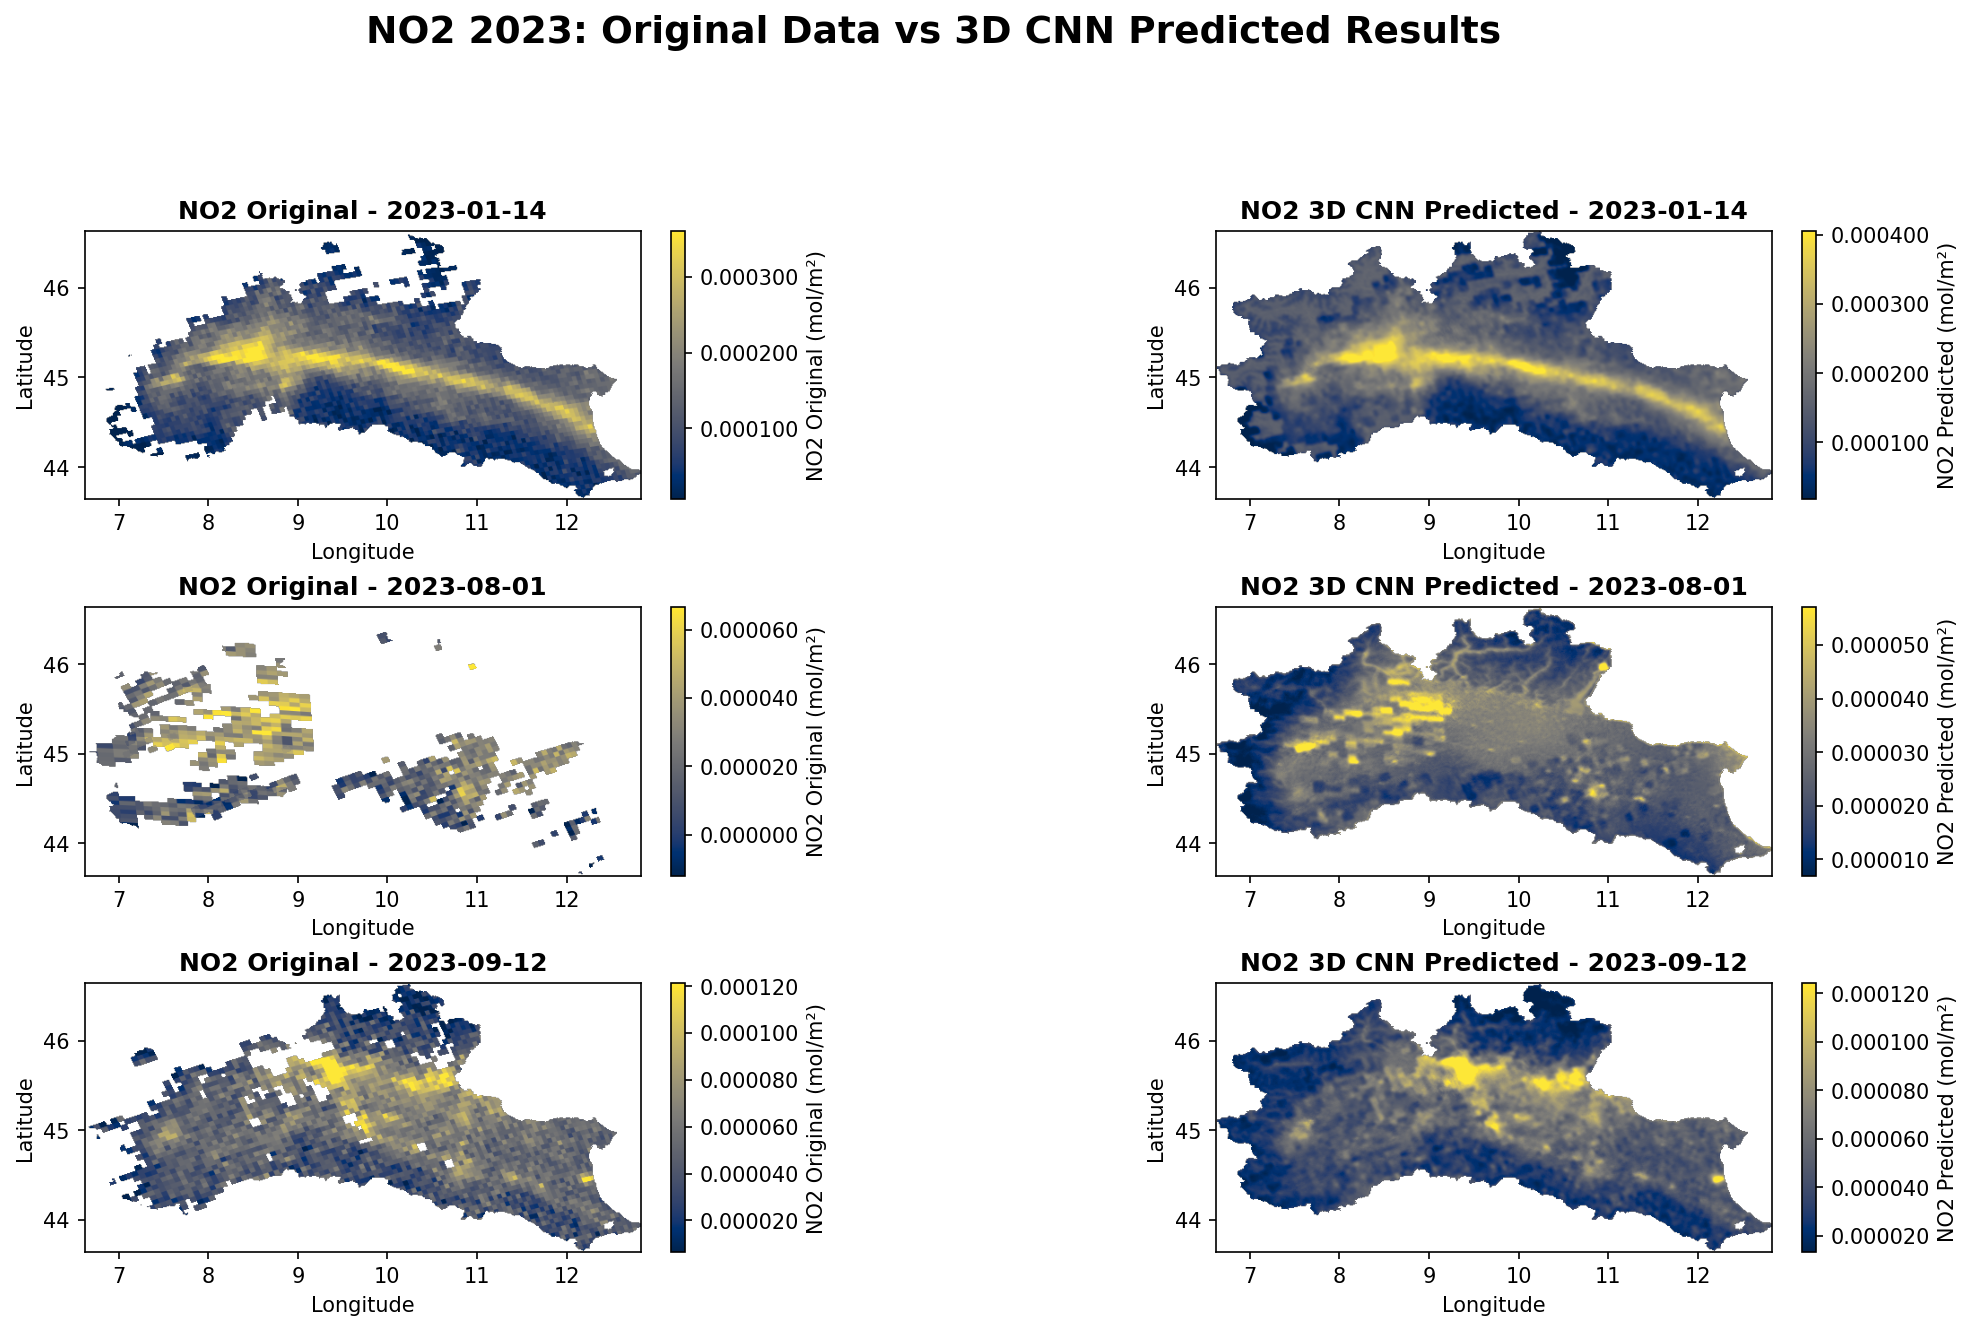


📊 Visualization completed!
Displayed days: [14, 213, 255]
Corresponding dates: [datetime.datetime(2023, 1, 14, 0, 0), datetime.datetime(2023, 8, 1, 0, 0), datetime.datetime(2023, 9, 12, 0, 0)]

📈 Additional statistics:
First 10 bands statistics:
  Min value: 0.00000500
  Max value: 0.00040539
  Mean value: 0.00004478
  Std deviation: 0.00002018
  Valid pixel ratio: 100.0%

🎉 NO2 3D CNN prediction results visualization completed!
💡 Perfect for paper display - 3 days comparison


In [14]:
# ========= NO2 3D CNN Prediction Results Visualization =========
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import geopandas as gpd
import random
from rasterio.mask import mask
from datetime import datetime, timedelta

# File paths
PRED_TIF = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/no2_pred_2023_stack_fixed.tif"
ORIG_TIF = "/content/drive/MyDrive/GEE_NO2/NO2_Daily_Multiband_2023.tif"  # 2023 original data
AOI_SHP = "/content/drive/MyDrive/AOI/delimitazione_distretto.shp"
NUM = 3  # Show 3 days comparison

print("🚀 NO2 3D CNN Prediction Results Visualization")
print("=" * 60)

# Load AOI
print("📁 Loading AOI boundaries...")
aoi = gpd.read_file(AOI_SHP)
print(f"✅ AOI loaded: {len(aoi)} regions")

# Load prediction data info
print("📊 Loading prediction data info...")
with rasterio.open(PRED_TIF) as ds:
    pred_total = ds.count
    pred_width, pred_height = ds.width, ds.height
    pred_crs = ds.crs
    pred_transform = ds.transform

    # Randomly select 3 days for visualization
    bands = sorted(random.sample(range(1, pred_total + 1), NUM))

    print(f"✅ NO2 prediction data info:")
    print(f"  Total bands: {pred_total}")
    print(f"  Spatial size: {pred_width} x {pred_height}")
    print(f"  CRS: {pred_crs}")
    print(f"  Randomly selected 3 days: {bands}")

# Check original data
print("📊 Checking original data...")
try:
    with rasterio.open(ORIG_TIF) as ds:
        orig_total = ds.count
        orig_width, orig_height = ds.width, ds.height
        orig_crs = ds.crs
        print(f"✅ NO2 original data info:")
        print(f"  Total bands: {orig_total}")
        print(f"  Spatial size: {orig_width} x {orig_height}")
        print(f"  CRS: {orig_crs}")
    has_original = True
except FileNotFoundError:
    print("⚠️ NO2 original data file not found, showing only predictions")
    has_original = False

# Create subplots (3 rows x 2 columns: each row shows original and predicted for the same day)
print("🎨 Creating visualization...")
ncols, nrows = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 9), dpi=150)

# Set font
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 2023 start date
start_date_2023 = datetime(2023, 1, 1)

# Reproject AOI to data CRS
aoi_reproj = aoi.to_crs(pred_crs)

print("🖼️ Generating visualization...")

for i, b in enumerate(bands):
    current_date = start_date_2023 + timedelta(days=b - 1)
    print(f"  Processing day {i+1}/{NUM}: {current_date.strftime('%Y-%m-%d')} (band {b})")

    # 1. Original data (left)
    ax_orig = axes[i, 0]

    if not has_original:
        # Show "no data" message
        ax_orig.set_title(f"NO2 Original - {current_date.strftime('%Y-%m-%d')}\n(No Data Available)",
                         fontsize=12, fontweight='bold')
        ax_orig.set_xlabel("Longitude", fontsize=10)
        ax_orig.set_ylabel("Latitude", fontsize=10)
        ax_orig.set_facecolor('lightgray')
        ax_orig.text(0.5, 0.5, 'No Original Data', ha='center', va='center',
                    transform=ax_orig.transAxes, fontsize=14, color='red')
    else:
        try:
            with rasterio.open(ORIG_TIF) as ds:
                clipped_orig, trans_orig = mask(
                    ds, aoi_reproj.geometry, crop=True,
                    nodata=np.nan, filled=True, indexes=b
                )

            arr_orig = np.squeeze(clipped_orig).astype(np.float32)
            valid_orig = np.isfinite(arr_orig)

            if valid_orig.sum() == 0:
                ax_orig.set_title(f"NO2 Original - {current_date.strftime('%Y-%m-%d')}\n(No Valid Data)",
                                 fontsize=12, fontweight='bold')
                ax_orig.set_xlabel("Longitude", fontsize=10)
                ax_orig.set_ylabel("Latitude", fontsize=10)
                ax_orig.set_facecolor('lightgray')
                ax_orig.text(0.5, 0.5, 'No Valid Data', ha='center', va='center',
                            transform=ax_orig.transAxes, fontsize=14, color='orange')
            else:
                h_orig, w_orig = arr_orig.shape
                left_orig, top_orig = trans_orig * (0, 0)
                right_orig, bottom_orig = trans_orig * (w_orig, h_orig)
                extent_orig = [left_orig, right_orig, bottom_orig, top_orig]

                # Calculate color range
                vmin_orig = float(np.percentile(arr_orig[valid_orig], 1))
                vmax_orig = float(np.percentile(arr_orig[valid_orig], 99))
                if vmax_orig <= vmin_orig:
                    vmax_orig = vmin_orig + 1e-12

                masked_arr_orig = np.ma.masked_where(~valid_orig, arr_orig)
                im_orig = ax_orig.imshow(masked_arr_orig, cmap="cividis", vmin=vmin_orig, vmax=vmax_orig,
                                        extent=extent_orig, origin="upper")
                ax_orig.set_title(f"NO2 Original - {current_date.strftime('%Y-%m-%d')}",
                                 fontsize=12, fontweight='bold')
                ax_orig.set_xlabel("Longitude", fontsize=10)
                ax_orig.set_ylabel("Latitude", fontsize=10)
                cbar_orig = fig.colorbar(im_orig, ax=ax_orig, fraction=0.046, pad=0.04, format='%.6f')
                cbar_orig.set_label("NO2 Original (mol/m²)", fontsize=10)

                # Statistics removed for cleaner visualization
        except Exception as e:
            ax_orig.set_title(f"NO2 Original - {current_date.strftime('%Y-%m-%d')}\n(Error: {str(e)[:30]}...)",
                             fontsize=12, fontweight='bold')
            ax_orig.set_xlabel("Longitude", fontsize=10)
            ax_orig.set_ylabel("Latitude", fontsize=10)
            ax_orig.set_facecolor('lightgray')
            ax_orig.text(0.5, 0.5, f'Error: {str(e)[:20]}...', ha='center', va='center',
                        transform=ax_orig.transAxes, fontsize=12, color='red')

    # 2. Predicted data (right)
    ax_pred = axes[i, 1]

    try:
        with rasterio.open(PRED_TIF) as ds:
            clipped_pred, trans_pred = mask(
                ds, aoi_reproj.geometry, crop=True,
                nodata=np.nan, filled=True, indexes=b
            )

        arr_pred = np.squeeze(clipped_pred).astype(np.float32)
        valid_pred = np.isfinite(arr_pred)

        h_pred, w_pred = arr_pred.shape
        left_pred, top_pred = trans_pred * (0, 0)
        right_pred, bottom_pred = trans_pred * (w_pred, h_pred)
        extent_pred = [left_pred, right_pred, bottom_pred, top_pred]

        # Calculate color range
        vmin_pred = float(np.percentile(arr_pred[valid_pred], 1))
        vmax_pred = float(np.percentile(arr_pred[valid_pred], 99))
        if vmax_pred <= vmin_pred:
            vmax_pred = vmin_pred + 1e-12

        masked_arr_pred = np.ma.masked_where(~valid_pred, arr_pred)
        im_pred = ax_pred.imshow(masked_arr_pred, cmap="cividis", vmin=vmin_pred, vmax=vmax_pred,
                                extent=extent_pred, origin="upper")
        ax_pred.set_title(f"NO2 3D CNN Predicted - {current_date.strftime('%Y-%m-%d')}",
                       fontsize=12, fontweight='bold')
        ax_pred.set_xlabel("Longitude", fontsize=10)
        ax_pred.set_ylabel("Latitude", fontsize=10)
        cbar_pred = fig.colorbar(im_pred, ax=ax_pred, fraction=0.046, pad=0.04, format='%.6f')
        cbar_pred.set_label("NO2 Predicted (mol/m²)", fontsize=10)

        # Statistics removed for cleaner visualization

    except Exception as e:
        ax_pred.set_title(f"NO2 Predicted - {current_date.strftime('%Y-%m-%d')}\n(Error: {str(e)[:30]}...)",
                         fontsize=12, fontweight='bold')
        ax_pred.set_xlabel("Longitude", fontsize=10)
        ax_pred.set_ylabel("Latitude", fontsize=10)
        ax_pred.set_facecolor('lightgray')
        ax_pred.text(0.5, 0.5, f'Error: {str(e)[:20]}...', ha='center', va='center',
                    transform=ax_pred.transAxes, fontsize=12, color='red')

# Set main title with more space
plt.suptitle("NO2 2023: Original Data vs 3D CNN Predicted Results",
             fontsize=18, fontweight='bold', y=0.98)

# Adjust layout with more spacing between main title and subplots
plt.tight_layout()
plt.subplots_adjust(top=0.82, wspace=0.5, hspace=0.4)

# Show plot
plt.show()

print("\n📊 Visualization completed!")
print(f"Displayed days: {bands}")
print(f"Corresponding dates: {[start_date_2023 + timedelta(days=b-1) for b in bands]}")

# Additional statistics
print("\n📈 Additional statistics:")
try:
    with rasterio.open(PRED_TIF) as ds:
        # Read all bands for statistics
        all_data = []
        for i in range(1, min(11, ds.count + 1)):  # Only read first 10 bands for statistics
            band_data = ds.read(i)
            all_data.append(band_data)

        all_data = np.stack(all_data, axis=0)
        print(f"First 10 bands statistics:")
        print(f"  Min value: {np.min(all_data):.8f}")
        print(f"  Max value: {np.max(all_data):.8f}")
        print(f"  Mean value: {np.mean(all_data):.8f}")
        print(f"  Std deviation: {np.std(all_data):.8f}")
        print(f"  Valid pixel ratio: {np.sum(np.isfinite(all_data)) / all_data.size * 100:.1f}%")

except Exception as e:
    print(f"Statistics retrieval failed: {e}")

print("\n🎉 NO2 3D CNN prediction results visualization completed!")
print("💡 Perfect for paper display - 3 days comparison")


In [15]:
# ===== SO2 3D CNN 最终修复版训练代码 =====
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 使用设备: {device}")

# ===== SO2 3D CNN配置参数 =====
SO2_3DCNN_CONFIG = {
    'data_path': '/content/drive/MyDrive/Feature_Stacks',
    'scaler_path': '/content/drive/MyDrive/3DCNN_Pipeline/artifacts/scalers/SO2/meanstd_global_2019_2021.npz',
    'time_window': 7,
    'batch_size': 8,
    'num_epochs': 3,
    'learning_rate': 1e-4,
    'patience': 5,
    'train_years': [2019, 2020, 2021],
    'val_year': 2022,
    'test_year': 2023,
    'max_grad_norm': 1.0,
    'use_amp': True,
    # Patch设置
    'patch_size': 64,
    'patch_gap_ratio': 0.2,
    'spatial_gap_ratio': 0.15,
    'min_valid_ratio': 0.1,
    # SO2目标值标准化参数 (根据实际数据统计)
    'mu_y': 4.658783e-05,  # SO2标签均值
    'std_y': 3.376913e-04,  # SO2标签标准差
}

print("📊 SO2 3D CNN 最终修复版配置:")
for key, value in SO2_3DCNN_CONFIG.items():
    print(f"  {key}: {value}")

# ===== SO2 3D CNN数据集类 =====
class SO2_3DCNN_Dataset(Dataset):
    def __init__(self, data_path, scaler_path, time_window=7,
                 train_years=[2019, 2020, 2021], val_year=2022, test_year=2023,
                 is_train=True, patch_size=64, patch_gap_ratio=0.2,
                 spatial_gap_ratio=0.15, min_valid_ratio=0.1):
        self.data_path = data_path
        self.time_window = time_window
        self.is_train = is_train
        self.H, self.W = 300, 621
        self.patch_size = patch_size
        self.patch_gap_ratio = patch_gap_ratio
        self.spatial_gap_ratio = spatial_gap_ratio
        self.min_valid_ratio = min_valid_ratio

        # 锁定特征名和通道数机制
        self.active_feature_names = None
        self.active_num_channels = None

        # 标准化缓存机制
        self._ms_cached_names = None
        self._ms_means = None
        self._ms_stds = None

        # 日志控制
        self._print_load_count = 0
        self._print_invalid_count = 0

        # 加载标准化器
        self._load_scaler(scaler_path)

        # 动态计算通道数
        self.num_channels = len(self.feature_order)

        # 获取文件列表
        self._get_file_lists(train_years, val_year, test_year)

        # 构建有效窗口
        self._build_valid_windows()

        print(f"📊 SO2 3D数据集初始化完成:")
        print(f"  训练文件: {len(self.train_files)}")
        print(f"  验证文件: {len(self.val_files)}")
        print(f"  测试文件: {len(self.test_files)}")
        print(f"  时间窗口: {time_window}天")
        print(f"  特征数: {len(self.feature_order)}")
        print(f"  有效窗口数: {len(self.valid_windows)}")

    def _load_scaler(self, scaler_path):
        """加载SO2标准化器 - 最终修复版"""
        try:
            with np.load(scaler_path, allow_pickle=True) as data:
                self.feature_order = data['channel_list'].tolist()
                self.mean_dict = data['mean'].item()
                self.std_dict = data['std'].item()
                print(f"✅ SO2标准化器加载成功: {len(self.feature_order)} 个特征")
                print(f"📊 特征顺序: {self.feature_order[:5]}...")

                # 验证scaler数据
                print(f"📊 SO2标准化器验证:")
                print(f"  mean字典键数: {len(self.mean_dict)}")
                print(f"  std字典键数: {len(self.std_dict)}")
                print(f"  前3个特征的统计信息:")
                for i, feat in enumerate(self.feature_order[:3]):
                    if feat in self.mean_dict and feat in self.std_dict:
                        mean_val = self.mean_dict[feat]
                        std_val = self.std_dict[feat]
                        print(f"    {feat}: mean={mean_val:.6f}, std={std_val:.6f}")
                    else:
                        print(f"    {feat}: 缺少统计信息")
        except Exception as e:
            print(f"⚠️ SO2标准化器加载失败: {e}")
            # 使用SO2默认特征
            self.feature_order = [
                'dem', 'slope', 'population', 'lulc_class_10', 'lulc_class_20', 'lulc_class_30',
                'lulc_class_40', 'lulc_class_50', 'lulc_class_60', 'lulc_class_70',
                'lulc_class_80', 'lulc_class_90', 'lulc_class_100', 'u10', 'v10', 'ws',
                'wd_sin', 'wd_cos', 'blh', 'tp', 't2m', 'sp', 'str', 'ssr_clear',
                'so2_lag1', 'so2_neighbor', 'so2_climate_prior', 'sin_doy', 'cos_doy', 'weekday_weight'
            ]
            self.mean_dict = {feat: 0.0 for feat in self.feature_order}
            self.std_dict = {feat: 1.0 for feat in self.feature_order}

    def _get_file_lists(self, train_years, val_year, test_year):
        """获取SO2文件列表"""
        self.train_files = []
        self.val_files = []
        self.test_files = []

        for year in train_years:
            year_dir = os.path.join(self.data_path, f'SO2_{year}')
            if os.path.exists(year_dir):
                files = sorted([f for f in os.listdir(year_dir) if f.startswith('SO2_stack_') and f.endswith('.npz')])
                self.train_files.extend([os.path.join(year_dir, f) for f in files])

        for year in [val_year, test_year]:
            year_dir = os.path.join(self.data_path, f'SO2_{year}')
            if os.path.exists(year_dir):
                files = sorted([f for f in os.listdir(year_dir) if f.startswith('SO2_stack_') and f.endswith('.npz')])
                if year == val_year:
                    self.val_files.extend([os.path.join(year_dir, f) for f in files])
                else:
                    self.test_files.extend([os.path.join(year_dir, f) for f in files])

    def _build_valid_windows(self):
        """构建有效的时间窗口"""
        self.valid_windows = []

        if self.is_train:
            file_list = self.train_files
        else:
            file_list = self.val_files if hasattr(self, 'val_files') and len(self.val_files) > 0 else self.test_files

        # 样本数量保护
        if len(file_list) < self.time_window:
            raise RuntimeError(f"可用文件不足:仅{len(file_list)} 个文件,但time_window={self.time_window}")

        # 简化：直接按索引构建窗口
        for i in range(len(file_list) - self.time_window + 1):
            self.valid_windows.append(i)

        print(f"📅 构建了 {len(self.valid_windows)} 个时间窗口")

    def _load_single_file(self, file_path):
        """加载单个SO2文件 - 最终修复版"""
        try:
            with np.load(file_path, allow_pickle=True) as data:
                # 检查必要数据
                if 'y' not in data or 'mask' not in data:
                    print(f"⚠️ 文件缺少必要数据: {os.path.basename(file_path)}")
                    return None

                y = data['y']  # SO2目标值
                mask = data['mask']  # SO2掩码

                # 数据清理
                if isinstance(y, np.ndarray) and y.dtype.kind in 'fi':
                    for s in (-9999, -32768):
                        y = np.where(y == s, np.nan, y)
                    y = np.where(np.abs(y) > 1e6, np.nan, y)

                # 检查空间尺寸
                if y.shape != (self.H, self.W):
                    print(f"⚠️ 空间尺寸不匹配: {y.shape} vs ({self.H}, {self.W})")
                    y_resized = np.full((self.H, self.W), np.nan, dtype=y.dtype)
                    mask_resized = np.zeros((self.H, self.W), dtype=bool)

                    min_h = min(y.shape[0], self.H)
                    min_w = min(y.shape[1], self.W)
                    y_resized[:min_h, :min_w] = y[:min_h, :min_w]
                    mask_resized[:min_h, :min_w] = mask[:min_h, :min_w]

                    y = y_resized
                    mask = mask_resized

                # 构建特征矩阵 - SO2特征映射
                X_features = []
                feature_names = []

                # SO2特征映射字典
                feature_mapping = {
                    'pop': 'population',
                    'ssr_clear': 'ssr_clear',
                    'so2_lag1': 'so2_lag1',
                    'so2_neighbor': 'so2_neighbor',
                    'so2_climate_prior': 'so2_climate_prior',
                    'lulc_class_10': 'lulc_class_10',
                    'lulc_class_20': 'lulc_class_20',
                    'lulc_class_30': 'lulc_class_30',
                    'lulc_class_40': 'lulc_class_40',
                    'lulc_class_50': 'lulc_class_50',
                    'lulc_class_60': 'lulc_class_60',
                    'lulc_class_70': 'lulc_class_70',
                    'lulc_class_80': 'lulc_class_80',
                    'lulc_class_90': 'lulc_class_90',
                    'lulc_class_100': 'lulc_class_100'
                }

                # 反向映射
                rev_map = {
                    'population': 'pop', 'ssr_clear': 'ssr_clear', 'so2_lag1': 'so2_lag1',
                    'so2_neighbor': 'so2_neighbor', 'so2_climate_prior': 'so2_climate_prior',
                    'lulc_class_10': 'lulc_class_10', 'lulc_class_20': 'lulc_class_20',
                    'lulc_class_30': 'lulc_class_30', 'lulc_class_40': 'lulc_class_40',
                    'lulc_class_50': 'lulc_class_50', 'lulc_class_60': 'lulc_class_60',
                    'lulc_class_70': 'lulc_class_70', 'lulc_class_80': 'lulc_class_80',
                    'lulc_class_90': 'lulc_class_90', 'lulc_class_100': 'lulc_class_100'
                }
                data_keys = set(k for k in data.keys() if k not in ['y', 'mask', 'feature_names', 'cont_idx', 'onehot_idx', 'noscale_idx', 'coverage', 'trainable', 'pollutant', 'season', 'date', 'doy', 'weekday', 'year_len', 'grid_height', 'grid_width', 'lag1_fill_ratio', 'neighbor_fill_ratio', 'file_version'])

                # 按scaler顺序加载特征
                for scaler_feat in self.feature_order:
                    candidate = scaler_feat if scaler_feat in data_keys else rev_map.get(scaler_feat, None)
                    if candidate in data_keys:
                        feat_data = data[candidate]

                        # 调整特征数据尺寸
                        if feat_data.shape != (self.H, self.W):
                            feat_resized = np.full((self.H, self.W), np.nan, dtype=feat_data.dtype)
                            min_h = min(feat_data.shape[0], self.H)
                            min_w = min(feat_data.shape[1], self.W)
                            feat_resized[:min_h, :min_w] = feat_data[:min_h, :min_w]
                            feat_data = feat_resized

                        X_features.append(feat_data)
                        feature_names.append(scaler_feat)
                    else:
                        X_features.append(np.full((self.H, self.W), np.nan, dtype=np.float32))
                        feature_names.append(scaler_feat)

                if not X_features:
                    return None

                X = np.stack(X_features, axis=0)  # (C, H, W)

                # 检查是否有有效数据
                valid_pixels = np.sum(mask)
                if valid_pixels == 0:
                    if self._print_invalid_count < 3:
                        print(f"⚠️ SO2文件没有有效数据: {os.path.basename(file_path)}")
                        self._print_invalid_count += 1
                    elif self._print_invalid_count == 3:
                        print(f"⚠️ SO2文件没有有效数据: ... (后续类似警告将不再显示)")
                        self._print_invalid_count += 1
                    return None

                if self._print_load_count < 5:
                    print(f"✅ 成功加载SO2文件: {os.path.basename(file_path)}, 有效像素: {valid_pixels}, 特征形状: {X.shape}")
                    self._print_load_count += 1
                return X, y, mask, feature_names

        except Exception as e:
            print(f"⚠️ SO2文件加载失败 {os.path.basename(file_path)}: {e}")
            return None

    def _vectorized_scaling(self, X_tensor, feature_names):
        """向量化标准化 - 兼容4D/5D张量"""
        # 使用scaler进行标准化
        if self._ms_cached_names is None or self._ms_means is None or self._ms_stds is None:
            self._ensure_ms(feature_names)

        # 应用标准化
        X_tensor = torch.nan_to_num(X_tensor, 0.0, 0.0, 0.0)

        # 使用缓存的均值和标准差，兼容4D/5D张量
        if self._ms_means is not None and self._ms_stds is not None:
            if X_tensor.dim() == 4:
                # 4D张量: (T, C, H, W)
                X_tensor = (X_tensor - self._ms_means) / self._ms_stds
            elif X_tensor.dim() == 5:
                # 5D张量: (B, T, C, H, W) - 添加batch维度
                X_tensor = (X_tensor - self._ms_means.unsqueeze(0)) / self._ms_stds.unsqueeze(0)

        return X_tensor

    def _ensure_ms(self, feature_names):
        """确保均值和标准差缓存"""
        if feature_names is None:
            feature_names = self.feature_order

        # 构建均值和标准差张量
        means = []
        stds = []

        for feat in feature_names:
            if feat in self.mean_dict and feat in self.std_dict:
                means.append(self.mean_dict[feat])
                stds.append(self.std_dict[feat])
            else:
                means.append(0.0)
                stds.append(1.0)

        # 正确广播形状: (1, C, 1, 1) 用于 (T, C, H, W)
        self._ms_means = torch.tensor(means, dtype=torch.float32).view(1, -1, 1, 1)
        self._ms_stds = torch.tensor(stds, dtype=torch.float32).view(1, -1, 1, 1)
        self._ms_cached_names = feature_names

        print(f"📊 缓存了 {len(feature_names)} 个特征的标准化参数")

    def __len__(self):
        return len(self.valid_windows)

    def __getitem__(self, idx):
        window_start = self.valid_windows[idx]

        if self.is_train:
            file_list = self.train_files
        else:
            file_list = self.val_files if hasattr(self, 'val_files') and len(self.val_files) > 0 else self.test_files

        # 加载时间窗口数据
        X_window = []
        y_window = []
        mask_window = []

        for i in range(self.time_window):
            file_path = file_list[window_start + i]
            data = self._load_single_file(file_path)

            if data is None:
                # 用NaN填充缺失数据
                X_nan = np.full((self.num_channels, self.H, self.W), np.nan, dtype=np.float32)
                y_nan = np.full((self.H, self.W), np.nan, dtype=np.float32)
                mask_nan = np.zeros((self.H, self.W), dtype=bool)
                X_window.append(X_nan)
                y_window.append(y_nan)
                mask_window.append(mask_nan)
            else:
                X, y, mask, feature_names = data
                X_window.append(X)
                y_window.append(y)
                mask_window.append(mask)

        # 堆叠时间维度
        X_window = np.stack(X_window, axis=0)  # (T, C, H, W)
        y_window = np.stack(y_window, axis=0)   # (T, H, W)
        mask_window = np.stack(mask_window, axis=0)  # (T, H, W)

        # 应用人工缺口（仅训练时）
        X_window, y_window, mask_window = self._apply_gaps(X_window, y_window, mask_window)

        # 提取空间patch
        X_patch, y_patch, mask_patch = self._extract_patch(X_window, y_window, mask_window)

        # 转换为tensor
        X_tensor = torch.from_numpy(X_patch).float()
        y_tensor = torch.from_numpy(y_patch).float()
        mask_tensor = torch.from_numpy(mask_patch).bool()

        # 向量化标准化
        X_tensor = self._vectorized_scaling(X_tensor, None)

        # 标准化目标值 - 先处理无效值，再标准化
        y_tensor[~mask_tensor] = 0.0  # 将无效值设为0而不是-999.0
        mu_y = SO2_3DCNN_CONFIG['mu_y']
        std_y = SO2_3DCNN_CONFIG['std_y']
        y_tensor = (y_tensor - mu_y) / std_y

        # 准备损失计算用的y
        y_for_loss = y_tensor.clone()
        y_for_loss[~mask_tensor] = -999.0

        return X_tensor, y_for_loss, mask_tensor

    def _extract_patch(self, X, y, mask):
        """提取空间patch"""
        retries, max_retries = 0, 20

        while True:
            if not self.is_train:
                center_h = self.H // 2
                center_w = self.W // 2
                start_h = max(0, center_h - self.patch_size // 2)
                start_w = max(0, center_w - self.patch_size // 2)
            else:
                max_h = max(1, self.H - self.patch_size)
                max_w = max(1, self.W - self.patch_size)
                start_h = np.random.randint(0, max_h + 1)
                start_w = np.random.randint(0, max_w + 1)

            end_h = min(self.H, start_h + self.patch_size)
            end_w = min(self.W, start_w + self.patch_size)

            X_patch = X[:, :, start_h:end_h, start_w:end_w]
            y_patch = y[:, start_h:end_h, start_w:end_w]
            mask_patch = mask[:, start_h:end_h, start_w:end_w]

            valid_ratio = np.sum(mask_patch[-1]) / mask_patch[-1].size
            if valid_ratio >= self.min_valid_ratio or not self.is_train:
                return X_patch, y_patch, mask_patch

            if not self.is_train:
                return X_patch, y_patch, mask_patch

            retries += 1
            if retries >= max_retries:
                return X_patch, y_patch, mask_patch

    def _apply_gaps(self, X, y, mask):
        """应用人工缺口"""
        if not self.is_train:
            return X, y, mask

        X_gapped = X.copy()
        y_gapped = y.copy()
        mask_gapped = mask.copy()

        # 时间缺口 - 不包含最后一帧
        time_steps = X.shape[0]
        last = time_steps - 1
        n_time_gaps = int(time_steps * self.patch_gap_ratio)
        if n_time_gaps > 0 and last > 0:
            pool = np.arange(0, last)  # 不包含最后一帧
            gap_indices = np.random.choice(pool, min(n_time_gaps, len(pool)), replace=False)
            X_gapped[gap_indices] = np.nan
            y_gapped[gap_indices] = np.nan
            mask_gapped[gap_indices] = False

        # 空间缺口 (不伤最后一帧) — 向量化版本
        H, W = X.shape[2], X.shape[3]
        n_spatial_gaps = int(H * W * self.spatial_gap_ratio)
        if n_spatial_gaps > 0:
            last = X.shape[0] - 1
            if last > 0:
                t_idx = np.random.randint(0, last, size=n_spatial_gaps)  # 0..last-1
                h_idx = np.random.randint(0, H, size=n_spatial_gaps)
                w_idx = np.random.randint(0, W, size=n_spatial_gaps)
                X_gapped[t_idx, :, h_idx, w_idx] = np.nan
                y_gapped[t_idx, h_idx, w_idx] = np.nan
                mask_gapped[t_idx, h_idx, w_idx] = False

        return X_gapped, y_gapped, mask_gapped

# ===== SO2 3D CNN模型 =====
class SO2_3DCNN_Model(nn.Module):
    def __init__(self, input_channels=30, out_in_01=False):
        super().__init__()
        self.out_in_01 = out_in_01
        ch = 32

        self.body = nn.Sequential(
            nn.Conv3d(input_channels, ch, 3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=ch),
            nn.ReLU(inplace=True),

            nn.Conv3d(ch, ch*2, 3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=ch*2),
            nn.ReLU(inplace=True),

            nn.Conv3d(ch*2, ch*4, 3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=ch*4),
            nn.ReLU(inplace=True),
        )

        self.head = nn.Conv3d(ch*4, 1, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)  # (B, C, T, H, W)
        x = self.body(x)
        x = self.head(x)

        # 不强制使用sigmoid，让模型学习原始范围
        if self.out_in_01:
            x = torch.sigmoid(x)

        return x

# ===== SO2损失函数 =====
class SO2_3DCNN_Loss(nn.Module):
    def __init__(self, supervise_last_frame_only=True, min_valid_ratio=0.01):
        super().__init__()
        self.supervise_last_frame_only = supervise_last_frame_only
        self.min_valid_ratio = min_valid_ratio
        self.zero_loss_count = 0
        self.total_batches = 0

    def forward(self, pred, target, mask):
        self.total_batches += 1
        pred = pred.squeeze(1)  # (B, T, H, W)

        if self.supervise_last_frame_only:
            pred_last = pred[:, -1]  # (B, H, W)
            target_last = target[:, -1]  # (B, H, W)
            mask_last = mask[:, -1]  # (B, H, W)

            valid = torch.isfinite(target_last) & (target_last != -999.0) & mask_last

            total_pixels = target_last.numel()
            valid_pixels = torch.sum(valid).item()
            valid_ratio = valid_pixels / total_pixels if total_pixels > 0 else 0

            if valid_ratio < self.min_valid_ratio:
                self.zero_loss_count += 1
                if self.zero_loss_count <= 5:
                    print(f"⚠️ 批次有效数据比例过低: {valid_ratio:.4f} < {self.min_valid_ratio}")
                return torch.tensor(1e-6, device=pred.device, requires_grad=True)

            if torch.sum(valid) == 0:
                return torch.tensor(1e-6, device=pred.device, requires_grad=True)
            mse_loss = F.mse_loss(pred_last[valid], target_last[valid])
        else:
            valid = torch.isfinite(target) & (target != -999.0) & mask

            total_pixels = target.numel()
            valid_pixels = torch.sum(valid).item()
            valid_ratio = valid_pixels / total_pixels if total_pixels > 0 else 0

            if valid_ratio < self.min_valid_ratio:
                self.zero_loss_count += 1
                if self.zero_loss_count <= 5:
                    print(f"⚠️ 批次有效数据比例过低: {valid_ratio:.4f} < {self.min_valid_ratio}")
                return torch.tensor(1e-6, device=pred.device, requires_grad=True)

            if torch.sum(valid) == 0:
                return torch.tensor(1e-6, device=pred.device, requires_grad=True)
            mse_loss = F.mse_loss(pred[valid], target[valid])

        return mse_loss

# ===== SO2训练器 =====
class SO2_3DCNN_Trainer:
    def __init__(self, model, train_loader, val_loader, device, learning_rate=1e-4, patience=3):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device

        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-6)
        self.criterion = SO2_3DCNN_Loss(supervise_last_frame_only=True, min_valid_ratio=SO2_3DCNN_CONFIG['min_valid_ratio'])
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', patience=2, factor=0.5)

        self.early_stopping = EarlyStopping(patience=patience)
        self.train_losses = []
        self.val_losses = []

        self.use_amp = SO2_3DCNN_CONFIG.get('use_amp', False) and (self.device.type == 'cuda')
        self.scaler = torch.cuda.amp.GradScaler(enabled=self.use_amp)
        self.best_val = float('inf')
        self.best_state = None

        print(f"✅ SO2训练器初始化完成(AMP={'ON' if self.use_amp else 'OFF'})")

    def train_one_epoch(self):
        """训练一个epoch"""
        self.model.train()
        total_loss = 0.0
        num_batches = 0
        skipped_batches = 0

        for batch_idx, (X, y, mask) in enumerate(self.train_loader):
            X, y, mask = X.to(self.device), y.to(self.device), mask.to(self.device)

            # 检查批次质量
            mask_last = mask[:, -1]
            target_last = y[:, -1]
            valid = torch.isfinite(target_last) & (target_last != -999.0) & mask_last
            valid_ratio = torch.sum(valid).item() / target_last.numel()

            if batch_idx == 0:
                print(f"🔍 SO2第一个批次诊断:")
                print(f"  X shape: {X.shape}, X range: [{X.min():.6f}, {X.max():.6f}]")
                print(f"  y shape: {y.shape}, y range: [{y.min():.6f}, {y.max():.6f}]")
                print(f"  mask shape: {mask.shape}, mask sum: {mask.sum()}")
                print(f"  y == -999.0: {(y == -999.0).sum()}")
                print(f"  valid positions: {((y != -999.0) & mask).sum()}")
                print(f"  最后一帧有效比例: {valid_ratio:.4f}")

            min_vr = SO2_3DCNN_CONFIG['min_valid_ratio']
            if valid_ratio < min_vr:
                skipped_batches += 1
                if skipped_batches <= 3:
                    print(f"  ⚠️ 跳过SO2批次 {batch_idx}: 有效数据比例过低 ({valid_ratio:.4f} < {min_vr})")
                continue

            self.optimizer.zero_grad()

            with torch.cuda.amp.autocast(enabled=self.use_amp):
                pred = self.model(X)

                if batch_idx == 0:
                    print(f"  pred shape: {pred.shape}, pred range: [{pred.min():.6f}, {pred.max():.6f}]")

                loss = self.criterion(pred, y, mask)

            if torch.isnan(loss) or torch.isinf(loss):
                print(f"⚠️ SO2批次 {batch_idx} 损失无效，跳过")
                continue

            self.scaler.scale(loss).backward()
            self.scaler.unscale_(self.optimizer)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), SO2_3DCNN_CONFIG.get('max_grad_norm', 1.0))
            self.scaler.step(self.optimizer)
            self.scaler.update()

            total_loss += loss.item()
            num_batches += 1

            if batch_idx % 5 == 0:
                print(f"  批次 {batch_idx}: 损失 = {loss.item():.6f}, 有效比例 = {valid_ratio:.4f}")

            if loss.item() == 0.0:
                print(f"  🚨 SO2批次 {batch_idx} 损失为0，详细诊断:")
                print(f"    有效像素数: {torch.sum(valid).item()}")
                print(f"    总像素数: {target_last.numel()}")
                print(f"    有效比例: {valid_ratio:.6f}")
                print(f"    目标值范围: [{target_last.min():.6f}, {target_last.max():.6f}]")
                print(f"    预测值范围: [{pred[:, -1].min():.6f}, {pred[:, -1].max():.6f}]")

        if skipped_batches > 0:
            print(f"  📊 跳过了 {skipped_batches} 个低质量SO2批次")

        return total_loss / max(num_batches, 1)

    def validate_one_epoch(self):
        """验证一个epoch"""
        self.model.eval()
        total_loss = 0.0
        num_batches = 0

        with torch.no_grad():
            for batch_idx, (X, y, mask) in enumerate(self.val_loader):
                X, y, mask = X.to(self.device), y.to(self.device), mask.to(self.device)

                pred = self.model(X)
                loss = self.criterion(pred, y, mask)

                if torch.isnan(loss) or torch.isinf(loss):
                    continue

                total_loss += loss.item()
                num_batches += 1

        return total_loss / max(num_batches, 1)

    def train(self, num_epochs):
        """完整训练过程"""
        print(f"🚀 开始SO2训练 {num_epochs} 个epoch...")

        for epoch in range(num_epochs):
            print(f"\n📊 SO2 Epoch {epoch+1}/{num_epochs}")

            train_loss = self.train_one_epoch()
            self.train_losses.append(train_loss)

            val_loss = self.validate_one_epoch()
            self.val_losses.append(val_loss)

            print(f"SO2训练损失: {train_loss:.6f}, SO2验证损失: {val_loss:.6f}, "
                  f"lr={self.optimizer.param_groups[0]['lr']:.2e}, "
                  f"zero_loss_batches={self.criterion.zero_loss_count}")

            if val_loss < self.best_val:
                self.best_val = val_loss
                self.best_state = {k: v.detach().cpu().clone() for k, v in self.model.state_dict().items()}
                print(f"🎯 新的最佳SO2验证损失: {val_loss:.6f}")

                # 保存最佳SO2模型到Google Drive
                import os
                os.makedirs("/content/drive/MyDrive/3DCNN_Pipeline/models", exist_ok=True)
                best_model_path = f"/content/drive/MyDrive/3DCNN_Pipeline/models/so2_3dcnn_best_model_epoch_{epoch+1}.pth"
                torch.save({
                    'model_state_dict': self.best_state,  # 用缓存的最佳权重
                    'epoch': epoch + 1,
                    'val_loss': val_loss,
                    'train_loss': train_loss,
                    'config': SO2_3DCNN_CONFIG
                }, best_model_path)
                print(f"💾 最佳SO2模型已保存到: {best_model_path}")

            self.scheduler.step(val_loss)

            if self.early_stopping(val_loss):
                print(f"🛑 SO2早停触发，在第 {epoch+1} 个epoch停止训练")
                break

        # 回滚到最优权重
        if self.best_state is not None:
            print(f"🔄 回滚到最优SO2权重 (验证损失: {self.best_val:.6f})")
            self.model.load_state_dict(self.best_state)

        # 保存最终SO2模型到Google Drive
        import os
        os.makedirs("/content/drive/MyDrive/3DCNN_Pipeline/models", exist_ok=True)
        model_save_path = "/content/drive/MyDrive/3DCNN_Pipeline/models/so2_3dcnn_model.pth"
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'best_val_loss': self.best_val,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'config': SO2_3DCNN_CONFIG
        }, model_save_path)
        print(f"💾 SO2模型已保存到: {model_save_path}")

        print("✅ SO2训练完成!")
        return self.train_losses, self.val_losses

# ===== 早停类 =====
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience

# ===== 主训练流程 =====
def main():
    print("🚀 SO2 3D CNN 最终修复版训练")
    print("=" * 60)

    # 创建SO2数据集
    print("📊 创建SO2 3D数据集...")
    train_dataset = SO2_3DCNN_Dataset(
        data_path=SO2_3DCNN_CONFIG['data_path'],
        scaler_path=SO2_3DCNN_CONFIG['scaler_path'],
        time_window=SO2_3DCNN_CONFIG['time_window'],
        train_years=SO2_3DCNN_CONFIG['train_years'],
        val_year=SO2_3DCNN_CONFIG['val_year'],
        test_year=SO2_3DCNN_CONFIG['test_year'],
        is_train=True,
        patch_size=SO2_3DCNN_CONFIG['patch_size'],
        patch_gap_ratio=SO2_3DCNN_CONFIG['patch_gap_ratio'],
        spatial_gap_ratio=SO2_3DCNN_CONFIG['spatial_gap_ratio'],
        min_valid_ratio=SO2_3DCNN_CONFIG['min_valid_ratio']
    )

    val_dataset = SO2_3DCNN_Dataset(
        data_path=SO2_3DCNN_CONFIG['data_path'],
        scaler_path=SO2_3DCNN_CONFIG['scaler_path'],
        time_window=SO2_3DCNN_CONFIG['time_window'],
        train_years=SO2_3DCNN_CONFIG['train_years'],
        val_year=SO2_3DCNN_CONFIG['val_year'],
        test_year=SO2_3DCNN_CONFIG['test_year'],
        is_train=False,
        patch_size=SO2_3DCNN_CONFIG['patch_size'],
        patch_gap_ratio=SO2_3DCNN_CONFIG['patch_gap_ratio'],
        spatial_gap_ratio=SO2_3DCNN_CONFIG['spatial_gap_ratio'],
        min_valid_ratio=SO2_3DCNN_CONFIG['min_valid_ratio']
    )

    # 创建数据加载器 (优化性能)
    train_loader = DataLoader(
        train_dataset,
        batch_size=SO2_3DCNN_CONFIG['batch_size'],
        shuffle=True,
        num_workers=4,  # 使用多进程加速数据加载
        pin_memory=(device.type == 'cuda'),
        persistent_workers=True  # 保持worker进程
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=SO2_3DCNN_CONFIG['batch_size'],
        shuffle=False,
        num_workers=4,  # 使用多进程加速数据加载
        pin_memory=(device.type == 'cuda'),
        persistent_workers=True  # 保持worker进程
    )

    print(f"✅ SO2 3D数据集创建完成")
    print(f"  训练样本: {len(train_dataset)}")
    print(f"  验证样本: {len(val_dataset)}")

    # 创建SO2模型(用训练集通道数)
    print("📊 创建SO2 3D CNN模型...")
    model = SO2_3DCNN_Model(
        input_channels=train_dataset.num_channels,  # 使用训练集的实际通道数
        out_in_01=False  # 不强制使用sigmoid
    )

    print(f"✅ SO2 3D CNN模型创建完成")
    print(f"  输入通道: {train_dataset.num_channels}")

    # 创建训练器
    print("📊 创建SO2训练器...")
    trainer = SO2_3DCNN_Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        learning_rate=SO2_3DCNN_CONFIG['learning_rate'],
        patience=SO2_3DCNN_CONFIG['patience']
    )

    # 开始训练
    print("🚀 开始SO2训练...")
    train_losses, val_losses = trainer.train(SO2_3DCNN_CONFIG['num_epochs'])

    print("🎉 SO2训练完成!")

    # 快速自检 (强烈建议在正式跑前做一次)
    print("\n🔍 执行快速自检...")
    try:
        # ---- 方式A: 直接可训练前向 + 反向 (最简单) ----
        xb, yb, mb = next(iter(train_loader))
        xb, yb, mb = xb.to(device), yb.to(device), mb.to(device)

        model.train()  # 确保有梯度
        out = model(xb)  # (B, 1, T, H, W)
        print("OUT:", out.shape)

        loss = trainer.criterion(out, yb, mb)
        loss.backward()  # 测试反向是否正常
        print("LOSS:", loss.item())
        print("✅ 快速自检通过!")

        # 可选:清空梯度,避免污染后续正式训练
        model.zero_grad(set_to_none=True)
    except Exception as e:
        print(f"❌ 快速自检失败: {e}")

    return model, trainer, None

# ===== 运行主函数 =====
if __name__ == "__main__":
    model, trainer, results = main()


🚀 使用设备: cuda
📊 SO2 3D CNN 最终修复版配置:
  data_path: /content/drive/MyDrive/Feature_Stacks
  scaler_path: /content/drive/MyDrive/3DCNN_Pipeline/artifacts/scalers/SO2/meanstd_global_2019_2021.npz
  time_window: 7
  batch_size: 8
  num_epochs: 3
  learning_rate: 0.0001
  patience: 5
  train_years: [2019, 2020, 2021]
  val_year: 2022
  test_year: 2023
  max_grad_norm: 1.0
  use_amp: True
  patch_size: 64
  patch_gap_ratio: 0.2
  spatial_gap_ratio: 0.15
  min_valid_ratio: 0.1
  mu_y: 4.658783e-05
  std_y: 0.0003376913
🚀 SO2 3D CNN 最终修复版训练
📊 创建SO2 3D数据集...
✅ SO2标准化器加载成功: 30 个特征
📊 特征顺序: ['dem', 'slope', 'population', 'lulc_01', 'lulc_02']...
📊 SO2标准化器验证:
  mean字典键数: 20
  std字典键数: 20
  前3个特征的统计信息:
    dem: mean=413.783081, std=524.850891
    slope: mean=10.554166, std=9.391439
    population: mean=173.623962, std=518.375061
📅 构建了 1090 个时间窗口
📊 SO2 3D数据集初始化完成:
  训练文件: 1096
  验证文件: 365
  测试文件: 365
  时间窗口: 7天
  特征数: 30
  有效窗口数: 1090
✅ SO2标准化器加载成功: 30 个特征
📊 特征顺序: ['dem', 'slope', 'population', 'lulc_01

In [19]:
# === 调试SO2数据文件特征结构 ===
import numpy as np
import os

# 配置路径
BASE_PATH = "/content/drive/MyDrive"
SO2_2023_DIR = f"{BASE_PATH}/Feature_Stacks/SO2_2023"
SCALER_PATH = f"{BASE_PATH}/3DCNN_Pipeline/artifacts/scalers/SO2/meanstd_global_2019_2021.npz"

print("🔍 调试SO2数据文件特征结构")
print("=" * 60)

# 1. 检查标准化器中的特征名称
print("📊 检查SO2标准化器特征名称...")
try:
    with np.load(SCALER_PATH, allow_pickle=True) as data:
        scaler_features = data['channel_list'].tolist()
        print(f"✅ 标准化器特征数量: {len(scaler_features)}")
        print(f"📋 标准化器特征列表:")
        for i, feat in enumerate(scaler_features):
            print(f"  {i+1:2d}. {feat}")
except Exception as e:
    print(f"❌ 标准化器加载失败: {e}")
    scaler_features = []

# 2. 检查SO2数据文件中的特征名称
print(f"\n📁 检查SO2数据文件特征名称...")
if os.path.exists(SO2_2023_DIR):
    files = sorted([f for f in os.listdir(SO2_2023_DIR) if f.startswith("SO2_stack_") and f.endswith('.npz')])
    print(f"📂 找到 {len(files)} 个SO2文件")

    if files:
        # 检查第一个文件
        sample_file = os.path.join(SO2_2023_DIR, files[0])
        print(f"🔍 检查样本文件: {files[0]}")

        try:
            data = np.load(sample_file, allow_pickle=True)
            print(f"📋 数据文件键名:")
            for key in data.keys():
                if hasattr(data[key], 'shape'):
                    print(f"  {key}: {data[key].shape}")
                else:
                    print(f"  {key}: {type(data[key])}")

            # 检查是否有feature_names
            if 'feature_names' in data:
                file_features = data['feature_names'].tolist()
                print(f"\n📋 数据文件特征名称 ({len(file_features)} 个):")
                for i, feat in enumerate(file_features):
                    print(f"  {i+1:2d}. {feat}")

                # 比较标准化器和数据文件的特征
                print(f"\n🔍 特征名称比较:")
                print(f"  标准化器特征数: {len(scaler_features)}")
                print(f"  数据文件特征数: {len(file_features)}")

                # 检查匹配情况
                missing_in_data = []
                missing_in_scaler = []

                for scaler_feat in scaler_features:
                    if scaler_feat not in file_features:
                        missing_in_data.append(scaler_feat)

                for file_feat in file_features:
                    if file_feat not in scaler_features:
                        missing_in_scaler.append(file_feat)

                if missing_in_data:
                    print(f"\n⚠️ 标准化器中有但数据文件中没有的特征:")
                    for feat in missing_in_data:
                        print(f"    {feat}")

                if missing_in_scaler:
                    print(f"\n⚠️ 数据文件中有但标准化器中没有的特征:")
                    for feat in missing_in_scaler:
                        print(f"    {feat}")

                # 检查X数组结构
                if 'X' in data:
                    X_shape = data['X'].shape
                    print(f"\n📊 X数组结构: {X_shape}")
                    print(f"  预期: (30, 300, 621)")
                    if len(X_shape) == 3 and X_shape[0] == 30:
                        print(f"  ✅ X数组结构正确")
                    else:
                        print(f"  ❌ X数组结构不正确")

        except Exception as e:
            print(f"❌ 读取数据文件失败: {e}")
    else:
        print("❌ 没有找到SO2文件")
else:
    print(f"❌ SO2目录不存在: {SO2_2023_DIR}")

print(f"\n🎯 建议的修复方案:")
print(f"1. 检查标准化器特征名称是否正确")
print(f"2. 检查数据文件特征名称是否正确")
print(f"3. 创建正确的特征映射")


🔍 调试SO2数据文件特征结构
📊 检查SO2标准化器特征名称...
✅ 标准化器特征数量: 30
📋 标准化器特征列表:
   1. dem
   2. slope
   3. population
   4. lulc_01
   5. lulc_02
   6. lulc_03
   7. lulc_04
   8. lulc_05
   9. lulc_06
  10. lulc_07
  11. lulc_08
  12. lulc_09
  13. lulc_10
  14. sin_doy
  15. cos_doy
  16. weekday_weight
  17. u10
  18. v10
  19. ws
  20. wd_sin
  21. wd_cos
  22. blh
  23. tp
  24. t2m
  25. sp
  26. str
  27. ssr
  28. lag1
  29. neighbor
  30. so2_climate_prior

📁 检查SO2数据文件特征名称...
📂 找到 365 个SO2文件
🔍 检查样本文件: SO2_stack_20230101.npz
📋 数据文件键名:
  X: (30, 300, 621)
  y: (300, 621)
  mask: (300, 621)
  feature_names: (30,)
  cont_idx: (20,)
  onehot_idx: (10,)
  noscale_idx: (0,)
  coverage: ()
  trainable: ()
  pollutant: ()
  season: ()
  date: ()
  doy: ()
  weekday: ()
  year_len: ()
  grid_height: ()
  grid_width: ()
  lag1_fill_ratio: ()
  neighbor_fill_ratio: ()
  file_version: ()

📋 数据文件特征名称 (30 个):
   1. dem
   2. slope
   3. population
   4. lulc_class_10
   5. lulc_class_20
   6. lulc_class_30
 

In [20]:
# === SO2 3D CNN 模型验证 (修复模型输出形状问题) ===
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import math
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ---- 路径配置 ----
BASE = "/content/drive/MyDrive/3DCNN_Pipeline"
CKPT = f"{BASE}/models/so2_3dcnn_model.pth"

# ---- 验证配置 ----
POLLUTANT = "SO2"
SPLIT = "test"  # 使用2023年测试集

# ---- SO2目标标准化参数 ----
mu_y  = 4.658783e-05
std_y = 3.376913e-04

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 使用设备: {device}")

# ---- 使用训练时的正确模型架构 ----
class SO2_3DCNN_Model(nn.Module):
    def __init__(self, input_channels=30, out_in_01=False):
        super().__init__()
        self.out_in_01 = out_in_01
        ch = 32

        self.body = nn.Sequential(
            nn.Conv3d(input_channels, ch, 3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=ch),
            nn.ReLU(inplace=True),

            nn.Conv3d(ch, ch*2, 3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=ch*2),
            nn.ReLU(inplace=True),

            nn.Conv3d(ch*2, ch*4, 3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=ch*4),
            nn.ReLU(inplace=True),
        )

        self.head = nn.Conv3d(ch*4, 1, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)
        x = self.body(x)
        x = self.head(x)

        if self.out_in_01:
            x = torch.sigmoid(x)

        return x

# ---- 创建数据集和加载器 ----
print("📊 创建SO2数据集...")

# 从训练代码复制SO2_3DCNN_Dataset类
class SO2_3DCNN_Dataset:
    def __init__(self, data_path, scaler_path, time_window=7, patch_size=64,
                 patch_gap_ratio=0.2, spatial_gap_ratio=0.15, min_valid_ratio=0.1,
                 train_years=[2019, 2020, 2021], val_year=2022, test_year=2023,
                 is_train=True, mu_y=None, std_y=None):

        self.data_path = data_path
        self.time_window = time_window
        self.patch_size = patch_size
        self.patch_gap_ratio = patch_gap_ratio
        self.spatial_gap_ratio = spatial_gap_ratio
        self.min_valid_ratio = min_valid_ratio
        self.is_train = is_train
        self.mu_y = mu_y
        self.std_y = std_y

        # 加载标准化器
        try:
            scaler_data = np.load(scaler_path, allow_pickle=True)
            self.feature_names = scaler_data['channel_list']
            self.means = scaler_data['mean'].item()
            self.stds = scaler_data['std'].item()
            print(f"✅ SO2标准化器加载成功: {len(self.feature_names)} 个特征")
        except Exception as e:
            print(f"⚠️ SO2标准化器加载失败: {e}")
            self.feature_names = [
                'dem', 'slope', 'population', 'lulc_01', 'lulc_02', 'lulc_03',
                'lulc_04', 'lulc_05', 'lulc_06', 'lulc_07',
                'lulc_08', 'lulc_09', 'lulc_10', 'sin_doy', 'cos_doy',
                'weekday_weight', 'u10', 'v10', 'blh', 'tp', 't2m', 'sp', 'str',
                'ssr', 'ws', 'wd_sin', 'wd_cos', 'lag1', 'neighbor', 'so2_climate_prior'
            ]
            self.means = {feat: 0.0 for feat in self.feature_names}
            self.stds = {feat: 1.0 for feat in self.feature_names}

        # 特征名映射 - 从标准化器名称映射到数据文件中的名称
        # 基于搜索结果，SO2标准化器使用lulc_01到lulc_10，但数据文件中是lulc_class_10到lulc_class_100
        self.rev_map = {
            'dem': 'dem',
            'slope': 'slope',
            'population': 'population',
            'lulc_01': 'lulc_class_10', 'lulc_02': 'lulc_class_20', 'lulc_03': 'lulc_class_30',
            'lulc_04': 'lulc_class_40', 'lulc_05': 'lulc_class_50', 'lulc_06': 'lulc_class_60',
            'lulc_07': 'lulc_class_70', 'lulc_08': 'lulc_class_80', 'lulc_09': 'lulc_class_90',
            'lulc_10': 'lulc_class_100', 'ssr': 'ssr_clear', 'lag1': 'so2_lag1',
            'neighbor': 'so2_neighbor', 'so2_climate_prior': 'so2_climate_prior',
            'u10': 'u10', 'v10': 'v10', 'blh': 'blh', 'tp': 'tp', 't2m': 't2m', 'sp': 'sp',
            'str': 'str', 'ws': 'ws', 'wd_sin': 'wd_sin', 'wd_cos': 'wd_cos',
            'sin_doy': 'sin_doy', 'cos_doy': 'cos_doy', 'weekday_weight': 'weekday_weight'
        }

        # 构建文件列表
        self._build_file_lists(train_years, val_year, test_year)

        # 构建时间窗口
        self._build_time_windows()

        print(f"📊 SO2 3D数据集初始化完成:")
        print(f"  时间窗口: {time_window}天")
        print(f"  特征数: {len(self.feature_names)}")
        print(f"  有效窗口数: {len(self.valid_windows)}")

    def _build_file_lists(self, train_years, val_year, test_year):
        self.train_files = []
        self.val_files = []
        self.test_files = []

        for year in train_years:
            year_path = os.path.join(self.data_path, f"SO2_{year}")
            if os.path.exists(year_path):
                files = sorted([f for f in os.listdir(year_path) if f.endswith('.npz')])
                self.train_files.extend([os.path.join(year_path, f) for f in files])

        val_path = os.path.join(self.data_path, f"SO2_{val_year}")
        if os.path.exists(val_path):
            files = sorted([f for f in os.listdir(val_path) if f.endswith('.npz')])
            self.val_files = [os.path.join(val_path, f) for f in files]

        test_path = os.path.join(self.data_path, f"SO2_{test_year}")
        if os.path.exists(test_path):
            files = sorted([f for f in os.listdir(test_path) if f.endswith('.npz')])
            self.test_files = [os.path.join(test_path, f) for f in files]

    def _build_time_windows(self):
        if SPLIT == "val":
            files = self.val_files
        else:
            files = self.test_files

        self.valid_windows = []
        for i in range(len(files) - self.time_window + 1):
            window_files = files[i:i + self.time_window]
            self.valid_windows.append(window_files)

    def __len__(self):
        return len(self.valid_windows)

    def __getitem__(self, idx):
        window_files = self.valid_windows[idx]

        # 加载时间窗口数据
        X_list = []
        y_list = []
        mask_list = []

        for file_path in window_files:
            data = self._load_single_file(file_path)
            if data is None:
                continue
            X, y, mask = data
            X_list.append(X)
            y_list.append(y)
            mask_list.append(mask)

        if len(X_list) == 0:
            return torch.zeros(self.time_window, len(self.feature_names), self.patch_size, self.patch_size), \
                   torch.zeros(self.time_window, self.patch_size, self.patch_size), \
                   torch.zeros(self.time_window, self.patch_size, self.patch_size, dtype=torch.bool)

        # 堆叠数据
        X = np.stack(X_list, axis=0)  # (T, C, H, W)
        y = np.stack(y_list, axis=0)  # (T, H, W)
        mask = np.stack(mask_list, axis=0)  # (T, H, W)

        # 应用patch
        X_patch, y_patch, mask_patch = self._extract_patch(X, y, mask)

        # 转换为张量
        X_tensor = torch.from_numpy(X_patch).float()
        y_tensor = torch.from_numpy(y_patch).float()
        mask_tensor = torch.from_numpy(mask_patch).bool()

        # 标准化目标值
        if self.mu_y is not None and self.std_y is not None:
            y_tensor[~mask_tensor] = 0.0
            y_tensor = (y_tensor - self.mu_y) / self.std_y
            y_tensor[~mask_tensor] = -999.0

        return X_tensor, y_tensor, mask_tensor

    def _load_single_file(self, file_path):
        try:
            data = np.load(file_path)

            y = data['y']  # SO2使用'y'而不是'no2_target'
            mask = data['mask']  # SO2使用'mask'而不是'no2_mask'

            if np.sum(mask) == 0:
                return None

            # SO2数据文件使用矩阵格式，所有特征在'X'数组中
            if 'X' in data:
                # 矩阵格式：X是(30, 300, 621)的数组
                X = data['X']  # (30, 300, 621)
                feature_names_in_file = data['feature_names']  # 获取实际的特征名称

                # 创建特征名称映射：标准化器名称 -> 数据文件名称
                feature_mapping = {
                    'lulc_01': 'lulc_class_10', 'lulc_02': 'lulc_class_20', 'lulc_03': 'lulc_class_30',
                    'lulc_04': 'lulc_class_40', 'lulc_05': 'lulc_class_50', 'lulc_06': 'lulc_class_60',
                    'lulc_07': 'lulc_class_70', 'lulc_08': 'lulc_class_80', 'lulc_09': 'lulc_class_90',
                    'lulc_10': 'lulc_class_100', 'ssr': 'ssr_clear', 'lag1': 'so2_lag1',
                    'neighbor': 'so2_neighbor'
                }

                # 重新排列特征以匹配标准化器的顺序
                X_reordered = []
                for name in self.feature_names:
                    # 首先尝试直接匹配
                    if name in feature_names_in_file:
                        idx = list(feature_names_in_file).index(name)
                        X_reordered.append(X[idx])
                    # 然后尝试通过映射匹配
                    elif name in feature_mapping and feature_mapping[name] in feature_names_in_file:
                        mapped_name = feature_mapping[name]
                        idx = list(feature_names_in_file).index(mapped_name)
                        X_reordered.append(X[idx])
                    else:
                        print(f"⚠️ 特征 '{name}' 不在文件中")
                        return None

                X = np.stack(X_reordered, axis=0)
            else:
                # 字典格式：逐个加载特征
                X = []
                for name in self.feature_names:
                    key = self.rev_map.get(name, name)
                    if key in data:
                        X.append(data[key])
                    else:
                        print(f"⚠️ 特征 '{name}' 不在文件中")
                        return None

                X = np.stack(X, axis=0)

            # 应用标准化
            for i, name in enumerate(self.feature_names):
                if name in self.means and name in self.stds:
                    X[i] = (X[i] - self.means[name]) / self.stds[name]

            return X, y, mask

        except Exception as e:
            print(f"❌ 加载文件失败: {file_path}, 错误: {e}")
            return None

    def _extract_patch(self, X, y, mask):
        H, W = X.shape[2], X.shape[3]
        start_h = (H - self.patch_size) // 2
        start_w = (W - self.patch_size) // 2
        end_h = start_h + self.patch_size
        end_w = start_w + self.patch_size

        X_patch = X[:, :, start_h:end_h, start_w:end_w]
        y_patch = y[:, start_h:end_h, start_w:end_w]
        mask_patch = mask[:, start_h:end_h, start_w:end_w]

        return X_patch, y_patch, mask_patch

# 创建数据集
dataset = SO2_3DCNN_Dataset(
    data_path="/content/drive/MyDrive/Feature_Stacks",
    scaler_path="/content/drive/MyDrive/3DCNN_Pipeline/artifacts/scalers/SO2/meanstd_global_2019_2021.npz",
    time_window=7,
    patch_size=64,
    is_train=False,
    mu_y=mu_y,
    std_y=std_y
)

# 创建数据加载器
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0
)

# ---- 加载模型 ----
print(f"📥 加载SO2最优模型: {CKPT}")
model = SO2_3DCNN_Model(input_channels=30).to(device)
checkpoint = torch.load(CKPT, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("✅ 最优模型加载完成")

# ---- 验证模型 ----
print("🔍 开始SO2模型验证 (2023年测试集)...")

# 修复：直接收集有效像素，避免维度不匹配
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_idx, (X, y, mask) in enumerate(loader):
        if batch_idx % 50 == 0:
            print(f"  处理批次 {batch_idx}")

        X = X.to(device)
        y = y.to(device)
        mask = mask.to(device)

        # 模型预测
        pred = model(X)  # pred形状: (B, 1, T, H, W)

        # 修复：正确选择最后一帧
        # pred形状是 (B, 1, T, H, W)，需要选择最后一帧
        pred_last = pred[:, 0, -1, :, :]  # (B, H, W) - 选择通道0，最后一帧
        y_last = y[:, -1, :, :]  # (B, H, W)
        mask_last = mask[:, -1, :, :]  # (B, H, W)

        # 反标准化到原始尺度
        y_original = y_last * std_y + mu_y
        pred_original = pred_last * std_y + mu_y

        # 只收集有效像素，避免维度问题
        valid_mask = mask_last.bool()  # (B, H, W)

        if valid_mask.sum() > 0:
            y_valid = y_original[valid_mask].cpu().numpy()
            pred_valid = pred_original[valid_mask].cpu().numpy()

            all_predictions.extend(pred_valid)
            all_targets.extend(y_valid)

# 转换为numpy数组
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# 计算指标
if len(all_predictions) > 0:
    mae = np.mean(np.abs(all_predictions - all_targets))
    rmse = np.sqrt(np.mean((all_predictions - all_targets)**2))
    r2 = 1 - np.sum((all_targets - all_predictions)**2) / np.sum((all_targets - np.mean(all_targets))**2)
    corr = np.corrcoef(all_predictions, all_targets)[0, 1]

    print(f"📊 SO2模型验证结果 (2023年测试集):")
    print(f"  MAE: {mae:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  R²: {r2:.6f}")
    print(f"  Correlation: {corr:.6f}")
    print(f"  有效像素数: {len(all_predictions)}")
    print(f"  预测范围: [{np.min(all_predictions):.6f}, {np.max(all_predictions):.6f}]")
    print(f"  目标范围: [{np.min(all_targets):.6f}, {np.max(all_targets):.6f}]")

    # 输出逐像素SO2浓度值
    print(f"\n🎯 逐像素SO2浓度值示例 (前10个):")
    for i in range(min(10, len(all_predictions))):
        print(f"  像素 {i+1}: 预测={all_predictions[i]:.6f}, 真实={all_targets[i]:.6f}")
else:
    print("❌ 没有有效的预测结果")


🚀 使用设备: cuda
📊 创建SO2数据集...
✅ SO2标准化器加载成功: 30 个特征
📊 SO2 3D数据集初始化完成:
  时间窗口: 7天
  特征数: 30
  有效窗口数: 359
📥 加载SO2最优模型: /content/drive/MyDrive/3DCNN_Pipeline/models/so2_3dcnn_model.pth
✅ 最优模型加载完成
🔍 开始SO2模型验证 (2023年测试集)...
  处理批次 0
  处理批次 50
  处理批次 100
  处理批次 150
  处理批次 200
  处理批次 250
  处理批次 300
  处理批次 350
📊 SO2模型验证结果 (2023年测试集):
  MAE: 0.000438
  RMSE: 0.000638
  R²: 0.041493
  Correlation: 0.284408
  有效像素数: 442687
  预测范围: [0.000340, 0.001070]
  目标范围: [0.000000, 0.010371]

🎯 逐像素SO2浓度值示例 (前10个):
  像素 1: 预测=0.000672, 真实=0.004427
  像素 2: 预测=0.000682, 真实=0.004427
  像素 3: 预测=0.000695, 真实=0.004427
  像素 4: 预测=0.000755, 真实=0.004427
  像素 5: 预测=0.000735, 真实=0.004427
  像素 6: 预测=0.000678, 真实=0.004427
  像素 7: 预测=0.000705, 真实=0.004427
  像素 8: 预测=0.000716, 真实=0.004427
  像素 9: 预测=0.000753, 真实=0.004427
  像素 10: 预测=0.000750, 真实=0.004427


In [21]:
# === 修复版SO2 3D CNN导出脚本 ===
import numpy as np
import torch
import rasterio
import os
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ---- 路径配置 ----
BASE = "/content/drive/MyDrive/3DCNN_Pipeline"
CKPT = f"{BASE}/models/so2_3dcnn_model.pth"
REF_TIF = "/content/drive/MyDrive/GEE_SO2/SO2_Daily_Multiband_2019.tif"  # 使用SO2参考文件
OUT_TIF = f"{BASE}/artifacts/so2_pred_2023_stack_fixed.tif"

# ---- SO2目标标准化参数 ----
mu_y = 4.658783e-05
std_y = 3.376913e-04
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"🚀 使用设备: {device}")

# ---- 使用训练时的正确模型架构 ----
class SO2_3DCNN_Model(torch.nn.Module):
    def __init__(self, input_channels=30, out_in_01=False):
        super().__init__()
        self.out_in_01 = out_in_01
        ch = 32

        self.body = torch.nn.Sequential(
            torch.nn.Conv3d(input_channels, ch, 3, padding=1),
            torch.nn.GroupNorm(num_groups=8, num_channels=ch),
            torch.nn.ReLU(inplace=True),

            torch.nn.Conv3d(ch, ch*2, 3, padding=1),
            torch.nn.GroupNorm(num_groups=8, num_channels=ch*2),
            torch.nn.ReLU(inplace=True),

            torch.nn.Conv3d(ch*2, ch*4, 3, padding=1),
            torch.nn.GroupNorm(num_groups=8, num_channels=ch*4),
            torch.nn.ReLU(inplace=True),
        )

        self.head = torch.nn.Conv3d(ch*4, 1, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)  # (B, C, T, H, W)
        x = self.body(x)
        x = self.head(x)

        if self.out_in_01:
            x = torch.sigmoid(x)

        return x

# ---- 加载模型 ----
print(f"📥 加载SO2最优模型: {CKPT}")
model = SO2_3DCNN_Model(input_channels=30).to(device)
checkpoint = torch.load(CKPT, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("✅ 最优模型加载完成")

# ---- 读取参考空间元数据 ----
print("📖 读取参考GeoTIFF元数据...")
with rasterio.open(REF_TIF) as src:
    height, width = src.height, src.width  # (300, 621)
    transform = src.transform
    crs = src.crs
    print(f"  参考尺寸: {height}x{width}")
    print(f"  坐标系统: {crs}")

# ---- 加载标准化器 ----
print("📊 加载标准化器...")
scaler_path = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/scalers/SO2/meanstd_global_2019_2021.npz"
scaler_data = np.load(scaler_path, allow_pickle=True)
feature_order = scaler_data['channel_list']
mean_dict = scaler_data['mean'].item()
std_dict = scaler_data['std'].item()

print(f"✅ 标准化器加载成功: {len(feature_order)} 个特征")

# ---- 获取文件列表 ----
print("📁 获取2022年和2023年文件列表...")
val_path = "/content/drive/MyDrive/Feature_Stacks/SO2_2022"
test_path = "/content/drive/MyDrive/Feature_Stacks/SO2_2023"

val_files = sorted([f for f in os.listdir(val_path) if f.endswith('.npz')])
test_files = sorted([f for f in os.listdir(test_path) if f.endswith('.npz')])

print(f"  2022年文件: {len(val_files)} 个")
print(f"  2023年文件: {len(test_files)} 个")

# ---- 关键修复：使用与训练时完全一致的数据预处理 ----
def load_and_preprocess_data_fixed(file_paths):
    """使用与训练时完全一致的数据预处理"""
    X_list = []

    for file_path in file_paths:
        if file_path is not None and os.path.exists(file_path):
            try:
                data = np.load(file_path)

                # SO2使用矩阵格式，所有特征在'X'数组中
                if 'X' in data:
                    # 矩阵格式：X是(30, 300, 621)的数组
                    X = data['X']  # (30, 300, 621)
                    feature_names_in_file = data['feature_names']  # 获取实际的特征名称

                    # 创建特征名称映射：标准化器名称 -> 数据文件名称
                    feature_mapping = {
                        'lulc_01': 'lulc_class_10', 'lulc_02': 'lulc_class_20', 'lulc_03': 'lulc_class_30',
                        'lulc_04': 'lulc_class_40', 'lulc_05': 'lulc_class_50', 'lulc_06': 'lulc_class_60',
                        'lulc_07': 'lulc_class_70', 'lulc_08': 'lulc_class_80', 'lulc_09': 'lulc_class_90',
                        'lulc_10': 'lulc_class_100', 'ssr': 'ssr_clear', 'lag1': 'so2_lag1',
                        'neighbor': 'so2_neighbor'
                    }

                    # 重新排列特征以匹配标准化器的顺序
                    X_reordered = []
                    for name in feature_order:
                        # 首先尝试直接匹配
                        if name in feature_names_in_file:
                            idx = list(feature_names_in_file).index(name)
                            X_reordered.append(X[idx])
                        # 然后尝试通过映射匹配
                        elif name in feature_mapping and feature_mapping[name] in feature_names_in_file:
                            mapped_name = feature_mapping[name]
                            idx = list(feature_names_in_file).index(mapped_name)
                            X_reordered.append(X[idx])
                        else:
                            # 如果特征不存在，用零填充
                            X_reordered.append(np.zeros((height, width), dtype=np.float32))

                    X = np.stack(X_reordered, axis=0)  # (C, H, W)
                else:
                    # 字典格式：逐个加载特征
                    X_features = []
                    for name in feature_order:
                        if name in data:
                            feat_data = data[name]

                            # 调整特征数据尺寸到目标尺寸
                            if feat_data.shape != (height, width):
                                feat_resized = np.full((height, width), np.nan, dtype=feat_data.dtype)
                                min_h = min(feat_data.shape[0], height)
                                min_w = min(feat_data.shape[1], width)
                                feat_resized[:min_h, :min_w] = feat_data[:min_h, :min_w]
                                feat_data = feat_resized

                            X_features.append(feat_data)
                        else:
                            # 如果特征不存在，用零填充
                            X_features.append(np.zeros((height, width), dtype=np.float32))

                    X = np.stack(X_features, axis=0)  # (C, H, W)

                # 关键修复：使用与训练时相同的标准化方式
                for i, feat_name in enumerate(feature_order):
                    if feat_name in mean_dict and feat_name in std_dict:
                        mean_val = mean_dict[feat_name]
                        std_val = std_dict[feat_name]

                        # 处理NaN值：先用0填充，然后标准化
                        X[i] = np.nan_to_num(X[i], nan=0.0)
                        X[i] = (X[i] - mean_val) / std_val
                    else:
                        # 如果没有统计信息，保持原值
                        X[i] = np.nan_to_num(X[i], nan=0.0)

                X_list.append(X)

            except Exception as e:
                print(f"❌ 加载文件失败: {file_path}: {e}")
                # 创建零填充数组
                X_list.append(np.zeros((len(feature_order), height, width)))
        else:
            # 对于缺失的数据，使用零填充
            X_list.append(np.zeros((len(feature_order), height, width)))

    return np.stack(X_list, axis=0)  # (T, C, H, W)

# ---- 开始预测 ----
print("🔍 开始生成SO2预测并导出GeoTIFF...")
pred_list = []

# 处理2023年的每一天
for day_idx in range(len(test_files)):
    if day_idx % 50 == 0:
        print(f"处理第 {day_idx+1}/{len(test_files)} 天")

    # 构建7天时间窗口
    file_paths = []
    for t in range(7):
        file_idx = day_idx - 6 + t  # 从6天前开始

        if file_idx < 0:
            # 如果索引为负，使用2022年的数据
            val_file_idx = len(val_files) + file_idx  # 从2022年末尾开始
            if 0 <= val_file_idx < len(val_files):
                file_paths.append(os.path.join(val_path, val_files[val_file_idx]))
            else:
                file_paths.append(None)
        elif file_idx < len(test_files):
            # 使用2023年的数据
            file_paths.append(os.path.join(test_path, test_files[file_idx]))
        else:
            file_paths.append(None)

    # 检查是否有足够的有效数据
    valid_files = [f for f in file_paths if f is not None and os.path.exists(f)]
    if len(valid_files) < 4:  # 至少需要4天的有效数据
        print(f"  跳过第 {day_idx+1} 天：有效数据不足 ({len(valid_files)}/7)")
        pred_list.append(np.zeros((height, width), dtype=np.float32))
        continue

    # 加载数据
    X_window = load_and_preprocess_data_fixed(file_paths)  # (T, C, H, W)

    # 转换为张量
    X_tensor = torch.from_numpy(X_window).float().unsqueeze(0).to(device)  # (1, T, C, H, W)

    # 模型预测
    with torch.no_grad():
        pred = model(X_tensor)  # (1, 1, T, H, W)
        pred_last = pred[:, 0, -1, :, :]  # (1, H, W)

        # 反标准化
        pred_original = pred_last * std_y + mu_y
        pred_np = pred_original.squeeze(0).detach().cpu().numpy()  # (H, W)

        # 检查预测值
        if np.any(np.isnan(pred_np)):
            print(f"  警告：第 {day_idx+1} 天预测包含NaN值")
            pred_np = np.nan_to_num(pred_np, nan=0.0)

        # 检查预测值范围
        pred_min, pred_max = np.min(pred_np), np.max(pred_np)
        if pred_min == pred_max == 0:
            print(f"  警告：第 {day_idx+1} 天预测全为0")
        else:
            print(f"  第 {day_idx+1} 天预测范围: [{pred_min:.6f}, {pred_max:.6f}]")

    pred_list.append(pred_np)

# 堆叠所有预测结果
pred_stack = np.stack(pred_list, axis=0).astype(np.float32)  # (T, H, W)

print(f"📊 预测结果统计:")
print(f"  时间步数: {pred_stack.shape[0]}")
print(f"  空间尺寸: {pred_stack.shape[1]}x{pred_stack.shape[2]}")
print(f"  预测范围: [{np.min(pred_stack):.6f}, {np.max(pred_stack):.6f}]")
print(f"  NaN值数量: {np.sum(np.isnan(pred_stack))}")
print(f"  零值数量: {np.sum(pred_stack == 0)}")
print(f"  非零值数量: {np.sum(pred_stack != 0)}")

# ---- 写入多波段GeoTIFF ----
print("💾 写入多波段GeoTIFF...")

# 确保输出目录存在
os.makedirs(os.path.dirname(OUT_TIF), exist_ok=True)

# 设置GeoTIFF参数
profile = {
    "driver": "GTiff",
    "height": height,
    "width": width,
    "count": pred_stack.shape[0],
    "dtype": "float32",
    "crs": crs,
    "transform": transform,
    "compress": "deflate",
    "predictor": 3,
    "tiled": True,
    "blockxsize": 256,
    "blockysize": 256,
}

# 写入GeoTIFF
with rasterio.open(OUT_TIF, "w", **profile) as dst:
    for i in range(pred_stack.shape[0]):
        dst.write(pred_stack[i], i + 1)
        if (i + 1) % 50 == 0:
            print(f"  已写入 {i + 1}/{pred_stack.shape[0]} 个波段")

print(f"✅ 成功保存: {OUT_TIF}")
print(f"📊 输出文件信息:")
print(f"  波段数: {pred_stack.shape[0]}")
print(f"  尺寸: {height}x{width}")
print(f"  坐标系统: {crs}")
print(f"  数据类型: float32")
print(f"  压缩: deflate")

# 生成日期信息
start_date = datetime(2023, 1, 1)
print(f"\n📅 日期信息:")
print(f"开始日期: {start_date.strftime('%Y-%m-%d')}")
print(f"结束日期: {(start_date + timedelta(days=pred_stack.shape[0]-1)).strftime('%Y-%m-%d')}")
print(f"总天数: {pred_stack.shape[0]}")

# 统计信息
valid_pixels = np.sum(~np.isnan(pred_stack), axis=(1, 2))
print(f"\n📊 统计信息:")
print(f"平均有效像素数: {np.mean(valid_pixels):.0f}")
print(f"最小有效像素数: {np.min(valid_pixels)}")
print(f"最大有效像素数: {np.max(valid_pixels)}")

print("\n🎉 SO2 3D CNN GeoTIFF export completed!")
print("💡 这个修复版本应该能生成包含真实SO2浓度预测的GeoTIFF文件!")


🚀 使用设备: cuda
📥 加载SO2最优模型: /content/drive/MyDrive/3DCNN_Pipeline/models/so2_3dcnn_model.pth
✅ 最优模型加载完成
📖 读取参考GeoTIFF元数据...
  参考尺寸: 300x621
  坐标系统: EPSG:4326
📊 加载标准化器...
✅ 标准化器加载成功: 30 个特征
📁 获取2022年和2023年文件列表...
  2022年文件: 365 个
  2023年文件: 365 个
🔍 开始生成SO2预测并导出GeoTIFF...
处理第 1/365 天
  第 1 天预测范围: [0.000440, 0.000651]
  第 2 天预测范围: [0.000433, 0.000652]
  第 3 天预测范围: [0.000428, 0.000654]
  第 4 天预测范围: [0.000430, 0.000654]
  第 5 天预测范围: [0.000428, 0.000654]
  第 6 天预测范围: [0.000428, 0.000654]
  第 7 天预测范围: [0.000434, 0.000658]
  第 8 天预测范围: [0.000439, 0.000677]
  第 9 天预测范围: [0.000430, 0.000667]
  第 10 天预测范围: [0.000424, 0.000666]
  第 11 天预测范围: [0.000428, 0.000664]
  第 12 天预测范围: [0.000428, 0.000657]
  第 13 天预测范围: [0.000428, 0.000671]
  第 14 天预测范围: [0.000433, 0.000655]
  第 15 天预测范围: [0.000436, 0.000659]
  第 16 天预测范围: [0.000429, 0.000669]
  第 17 天预测范围: [0.000424, 0.000660]
  第 18 天预测范围: [0.000428, 0.000691]
  第 19 天预测范围: [0.000429, 0.000667]
  第 20 天预测范围: [0.000431, 0.000672]
  第 21 天预测范围: [0.000438, 0.0

🚀 SO2 3D CNN Prediction Results Visualization
📁 Loading AOI boundaries...
✅ AOI loaded: 1 regions
📊 Loading prediction data info...
✅ SO2 prediction data info:
  Total bands: 365
  Spatial size: 621 x 300
  CRS: EPSG:4326
  Randomly selected 3 days: [154, 257, 313]
📊 Checking original data...
✅ SO2 original data info:
  Total bands: 365
  Spatial size: 621 x 300
  CRS: EPSG:4326
🎨 Creating visualization...
🖼️ Generating visualization...
  Processing day 1/3: 2023-06-03 (band 154)
  Processing day 2/3: 2023-09-14 (band 257)
  Processing day 3/3: 2023-11-09 (band 313)


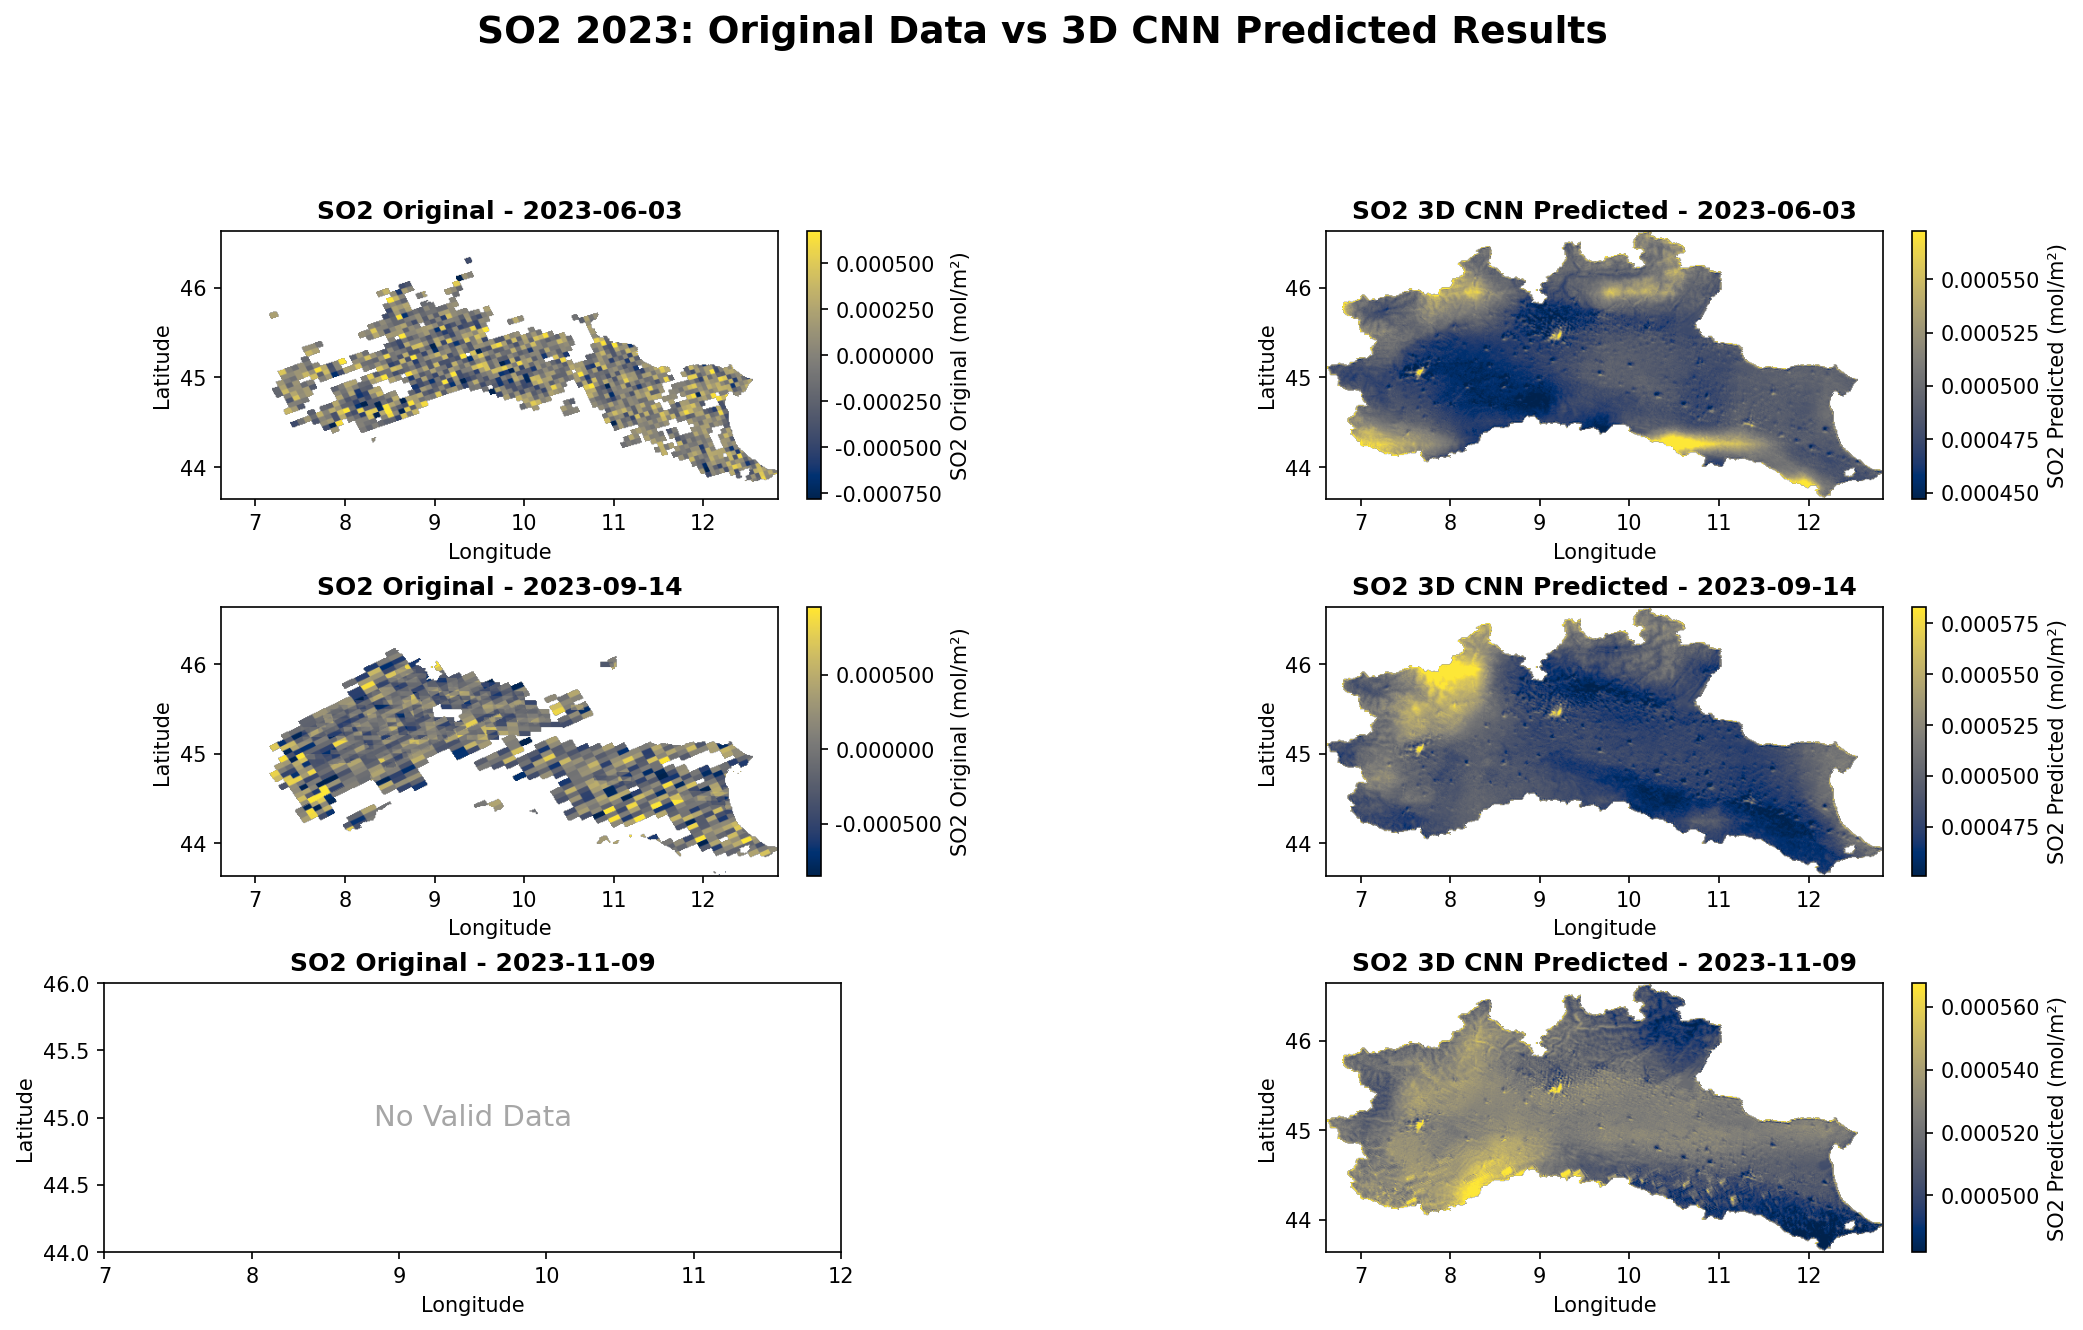


📊 Visualization completed!
Displayed days: [154, 257, 313]
Corresponding dates: [datetime.datetime(2023, 6, 3, 0, 0), datetime.datetime(2023, 9, 14, 0, 0), datetime.datetime(2023, 11, 9, 0, 0)]

📈 Additional statistics:
First 10 bands statistics:
  Min value: 0.00042432
  Max value: 0.00067665
  Mean value: 0.00055777
  Std deviation: 0.00003590
  Valid pixel ratio: 100.0%

🎉 SO2 3D CNN prediction results visualization completed!
💡 Perfect for paper display - 3 days comparison


In [26]:
# ========= SO2 3D CNN Prediction Results Visualization =========
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import geopandas as gpd
import random
from rasterio.mask import mask
from datetime import datetime, timedelta

# File paths
PRED_TIF = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/so2_pred_2023_stack_fixed.tif"
ORIG_TIF = "/content/drive/MyDrive/GEE_SO2/SO2_Daily_Multiband_2023.tif"  # 2023 original SO2 data
AOI_SHP = "/content/drive/MyDrive/AOI/delimitazione_distretto.shp"
NUM = 3  # Show 3 days comparison

print("🚀 SO2 3D CNN Prediction Results Visualization")
print("=" * 60)

# Load AOI
print("📁 Loading AOI boundaries...")
aoi = gpd.read_file(AOI_SHP)
print(f"✅ AOI loaded: {len(aoi)} regions")

# Load prediction data info
print("📊 Loading prediction data info...")
with rasterio.open(PRED_TIF) as ds:
    pred_total = ds.count
    pred_width, pred_height = ds.width, ds.height
    pred_crs = ds.crs
    pred_transform = ds.transform

    # Randomly select 3 days for visualization
    bands = sorted(random.sample(range(1, pred_total + 1), NUM))

    print(f"✅ SO2 prediction data info:")
    print(f"  Total bands: {pred_total}")
    print(f"  Spatial size: {pred_width} x {pred_height}")
    print(f"  CRS: {pred_crs}")
    print(f"  Randomly selected 3 days: {bands}")

# Check original data
print("📊 Checking original data...")
try:
    with rasterio.open(ORIG_TIF) as ds:
        orig_total = ds.count
        orig_width, orig_height = ds.width, ds.height
        orig_crs = ds.crs
        print(f"✅ SO2 original data info:")
        print(f"  Total bands: {orig_total}")
        print(f"  Spatial size: {orig_width} x {orig_height}")
        print(f"  CRS: {orig_crs}")
    has_original = True
except FileNotFoundError:
    print("⚠️ SO2 original data file not found, showing only predictions")
    has_original = False

# Create subplots (3 rows x 2 columns: each row shows original and predicted for the same day)
print("🎨 Creating visualization...")
ncols, nrows = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 9), dpi=150)

# Set font
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 2023 start date
start_date_2023 = datetime(2023, 1, 1)

# Reproject AOI to data CRS
aoi_reproj = aoi.to_crs(pred_crs)

print("🖼️ Generating visualization...")

for i, b in enumerate(bands):
    current_date = start_date_2023 + timedelta(days=b - 1)
    print(f"  Processing day {i+1}/{NUM}: {current_date.strftime('%Y-%m-%d')} (band {b})")

    # 1. Original data (left)
    ax_orig = axes[i, 0]

    if not has_original:
        # Show blank plot with "No Valid Data" message
        ax_orig.set_title(f"SO2 Original - {current_date.strftime('%Y-%m-%d')}",
                         fontsize=12, fontweight='bold')
        ax_orig.set_xlabel("Longitude", fontsize=10)
        ax_orig.set_ylabel("Latitude", fontsize=10)
        ax_orig.set_facecolor('white')
        # Set coordinate ranges to match predicted data
        ax_orig.set_xlim(7, 12)
        ax_orig.set_ylim(44, 46)
        # Add "No Valid Data" text
        ax_orig.text(0.5, 0.5, 'No Valid Data', ha='center', va='center',
                    transform=ax_orig.transAxes, fontsize=14, color='gray', alpha=0.7)
    else:
        try:
            with rasterio.open(ORIG_TIF) as ds:
                clipped_orig, trans_orig = mask(
                    ds, aoi_reproj.geometry, crop=True,
                    nodata=np.nan, filled=True, indexes=b
                )

            arr_orig = np.squeeze(clipped_orig).astype(np.float32)
            valid_orig = np.isfinite(arr_orig)

            if valid_orig.sum() == 0:
                ax_orig.set_title(f"SO2 Original - {current_date.strftime('%Y-%m-%d')}",
                                 fontsize=12, fontweight='bold')
                ax_orig.set_xlabel("Longitude", fontsize=10)
                ax_orig.set_ylabel("Latitude", fontsize=10)
                ax_orig.set_facecolor('white')
                # Set coordinate ranges to match predicted data
                ax_orig.set_xlim(7, 12)
                ax_orig.set_ylim(44, 46)
                # Add "No Valid Data" text
                ax_orig.text(0.5, 0.5, 'No Valid Data', ha='center', va='center',
                            transform=ax_orig.transAxes, fontsize=14, color='gray', alpha=0.7)
            else:
                h_orig, w_orig = arr_orig.shape
                left_orig, top_orig = trans_orig * (0, 0)
                right_orig, bottom_orig = trans_orig * (w_orig, h_orig)
                extent_orig = [left_orig, right_orig, bottom_orig, top_orig]

                # Calculate color range
                vmin_orig = float(np.percentile(arr_orig[valid_orig], 1))
                vmax_orig = float(np.percentile(arr_orig[valid_orig], 99))
                if vmax_orig <= vmin_orig:
                    vmax_orig = vmin_orig + 1e-12

                masked_arr_orig = np.ma.masked_where(~valid_orig, arr_orig)
                im_orig = ax_orig.imshow(masked_arr_orig, cmap="cividis", vmin=vmin_orig, vmax=vmax_orig,
                                        extent=extent_orig, origin="upper")
                ax_orig.set_title(f"SO2 Original - {current_date.strftime('%Y-%m-%d')}",
                                 fontsize=12, fontweight='bold')
                ax_orig.set_xlabel("Longitude", fontsize=10)
                ax_orig.set_ylabel("Latitude", fontsize=10)
                cbar_orig = fig.colorbar(im_orig, ax=ax_orig, fraction=0.046, pad=0.04, format='%.6f')
                cbar_orig.set_label("SO2 Original (mol/m²)", fontsize=10)

                # Statistics removed for cleaner visualization
        except Exception as e:
            ax_orig.set_title(f"SO2 Original - {current_date.strftime('%Y-%m-%d')}",
                             fontsize=12, fontweight='bold')
            ax_orig.set_xlabel("Longitude", fontsize=10)
            ax_orig.set_ylabel("Latitude", fontsize=10)
            ax_orig.set_facecolor('white')
            # Set coordinate ranges to match predicted data
            ax_orig.set_xlim(7, 12)
            ax_orig.set_ylim(44, 46)
            # Add "No Valid Data" text
            ax_orig.text(0.5, 0.5, 'No Valid Data', ha='center', va='center',
                        transform=ax_orig.transAxes, fontsize=14, color='gray', alpha=0.7)

    # 2. Predicted data (right)
    ax_pred = axes[i, 1]

    try:
        with rasterio.open(PRED_TIF) as ds:
            clipped_pred, trans_pred = mask(
                ds, aoi_reproj.geometry, crop=True,
                nodata=np.nan, filled=True, indexes=b
            )

        arr_pred = np.squeeze(clipped_pred).astype(np.float32)
        valid_pred = np.isfinite(arr_pred)

        h_pred, w_pred = arr_pred.shape
        left_pred, top_pred = trans_pred * (0, 0)
        right_pred, bottom_pred = trans_pred * (w_pred, h_pred)
        extent_pred = [left_pred, right_pred, bottom_pred, top_pred]

        # Calculate color range
        vmin_pred = float(np.percentile(arr_pred[valid_pred], 1))
        vmax_pred = float(np.percentile(arr_pred[valid_pred], 99))
        if vmax_pred <= vmin_pred:
            vmax_pred = vmin_pred + 1e-12

        masked_arr_pred = np.ma.masked_where(~valid_pred, arr_pred)
        im_pred = ax_pred.imshow(masked_arr_pred, cmap="cividis", vmin=vmin_pred, vmax=vmax_pred,
                                extent=extent_pred, origin="upper")
        ax_pred.set_title(f"SO2 3D CNN Predicted - {current_date.strftime('%Y-%m-%d')}",
                       fontsize=12, fontweight='bold')
        ax_pred.set_xlabel("Longitude", fontsize=10)
        ax_pred.set_ylabel("Latitude", fontsize=10)
        cbar_pred = fig.colorbar(im_pred, ax=ax_pred, fraction=0.046, pad=0.04, format='%.6f')
        cbar_pred.set_label("SO2 Predicted (mol/m²)", fontsize=10)

        # Statistics removed for cleaner visualization

    except Exception as e:
        ax_pred.set_title(f"SO2 Predicted - {current_date.strftime('%Y-%m-%d')}\n(Error: {str(e)[:30]}...)",
                         fontsize=12, fontweight='bold')
        ax_pred.set_xlabel("Longitude", fontsize=10)
        ax_pred.set_ylabel("Latitude", fontsize=10)
        ax_pred.set_facecolor('lightgray')
        ax_pred.text(0.5, 0.5, f'Error: {str(e)[:20]}...', ha='center', va='center',
                    transform=ax_pred.transAxes, fontsize=12, color='red')

# Set main title with more space
plt.suptitle("SO2 2023: Original Data vs 3D CNN Predicted Results",
             fontsize=18, fontweight='bold', y=0.98)

# Adjust layout with more spacing between main title and subplots
plt.tight_layout()
plt.subplots_adjust(top=0.82, wspace=0.5, hspace=0.4)

# Show plot
plt.show()

print("\n📊 Visualization completed!")
print(f"Displayed days: {bands}")
print(f"Corresponding dates: {[start_date_2023 + timedelta(days=b-1) for b in bands]}")

# Additional statistics
print("\n📈 Additional statistics:")
try:
    with rasterio.open(PRED_TIF) as ds:
        # Read all bands for statistics
        all_data = []
        for i in range(1, min(11, ds.count + 1)):  # Only read first 10 bands for statistics
            band_data = ds.read(i)
            all_data.append(band_data)

        all_data = np.stack(all_data, axis=0)
        print(f"First 10 bands statistics:")
        print(f"  Min value: {np.min(all_data):.8f}")
        print(f"  Max value: {np.max(all_data):.8f}")
        print(f"  Mean value: {np.mean(all_data):.8f}")
        print(f"  Std deviation: {np.std(all_data):.8f}")
        print(f"  Valid pixel ratio: {np.sum(np.isfinite(all_data)) / all_data.size * 100:.1f}%")

except Exception as e:
    print(f"Statistics retrieval failed: {e}")

print("\n🎉 SO2 3D CNN prediction results visualization completed!")
print("💡 Perfect for paper display - 3 days comparison")

In [30]:
# ========= NO2 Multi-Model Comparison: Original Data vs 3D CNN vs 2D CNN vs LightGBM =========
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import geopandas as gpd
import random
from rasterio.mask import mask
from datetime import datetime, timedelta

# File paths
NO2_3DCNN_TIF = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/no2_pred_2023_stack_fixed.tif"  # 3D CNN
NO2_2DCNN_TIF = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/no2_pred_2023_stack01.tif"  # 2D CNN
NO2_LIGHTGBM_TIF = "/content/drive/MyDrive/Models/NO2_LightGBM_GapFilling/no2_pred_2023_gapfilled.tif"  # LightGBM

# Original data
NO2_ORIG_TIF = "/content/drive/MyDrive/GEE_NO2/NO2_Daily_Multiband_2023.tif"

AOI_SHP = "/content/drive/MyDrive/AOI/delimitazione_distretto.shp"
NUM = 3  # Show 3 days comparison

print("🚀 NO2 Multi-Model Comparison: Original Data vs 3D CNN vs 2D CNN vs LightGBM")
print("=" * 80)

# Load AOI
print("📁 Loading AOI boundaries...")
aoi = gpd.read_file(AOI_SHP)
print(f"✅ AOI loaded: {len(aoi)} regions")

# Load prediction data info
print("📊 Loading prediction data info...")
with rasterio.open(NO2_3DCNN_TIF) as ds:
    pred_total = ds.count
    pred_width, pred_height = ds.width, ds.height
    pred_crs = ds.crs

    # Randomly select 3 days for visualization
    bands = sorted(random.sample(range(1, pred_total + 1), NUM))

    print(f"✅ NO2 3D CNN prediction data info:")
    print(f"  Total bands: {pred_total}")
    print(f"  Spatial size: {pred_width} x {pred_height}")
    print(f"  CRS: {pred_crs}")
    print(f"  Randomly selected 3 days: {bands}")

# Check original data availability
print("📊 Checking original data availability...")
has_no2_orig = True

try:
    with rasterio.open(NO2_ORIG_TIF) as ds:
        print(f"✅ NO2 original data available: {ds.count} bands")
except FileNotFoundError:
    print("⚠️ NO2 original data not found")
    has_no2_orig = False

# Create subplots (3 rows x 4 columns: Original, NO2 3D CNN, NO2 2D CNN, LightGBM)
print("🎨 Creating NO2 visualization...")
ncols, nrows = 4, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 12), dpi=150)

# Set font
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 2023 start date
start_date_2023 = datetime(2023, 1, 1)

# Reproject AOI to data CRS
aoi_reproj = aoi.to_crs(pred_crs)

print("🖼️ Generating NO2 visualization...")

for i, b in enumerate(bands):
    current_date = start_date_2023 + timedelta(days=b - 1)
    print(f"  Processing day {i+1}/{NUM}: {current_date.strftime('%Y-%m-%d')} (band {b})")

    # 1. Original NO2 data (leftmost)
    ax_orig = axes[i, 0]

    if not has_no2_orig:
        ax_orig.set_title(f"NO2 Original - {current_date.strftime('%Y-%m-%d')}",
                         fontsize=12, fontweight='bold')
        ax_orig.set_xlabel("Longitude", fontsize=10)
        ax_orig.set_ylabel("Latitude", fontsize=10)
        ax_orig.set_facecolor('white')
        ax_orig.set_xlim(7, 12)
        ax_orig.set_ylim(44, 46)
        ax_orig.text(0.5, 0.5, 'No Valid Data', ha='center', va='center',
                    transform=ax_orig.transAxes, fontsize=14, color='gray', alpha=0.7)
    else:
        try:
            with rasterio.open(NO2_ORIG_TIF) as ds:
                clipped_orig, trans_orig = mask(
                    ds, aoi_reproj.geometry, crop=True,
                    nodata=np.nan, filled=True, indexes=b
                )

            arr_orig = np.squeeze(clipped_orig).astype(np.float32)
            valid_orig = np.isfinite(arr_orig)

            if valid_orig.sum() == 0:
                ax_orig.set_title(f"NO2 Original - {current_date.strftime('%Y-%m-%d')}",
                                 fontsize=12, fontweight='bold')
                ax_orig.set_xlabel("Longitude", fontsize=10)
                ax_orig.set_ylabel("Latitude", fontsize=10)
                ax_orig.set_facecolor('white')
                ax_orig.set_xlim(7, 12)
                ax_orig.set_ylim(44, 46)
                ax_orig.text(0.5, 0.5, 'No Valid Data', ha='center', va='center',
                            transform=ax_orig.transAxes, fontsize=14, color='gray', alpha=0.7)
            else:
                h_orig, w_orig = arr_orig.shape
                left_orig, top_orig = trans_orig * (0, 0)
                right_orig, bottom_orig = trans_orig * (w_orig, h_orig)
                extent_orig = [left_orig, right_orig, bottom_orig, top_orig]

                vmin_orig = float(np.percentile(arr_orig[valid_orig], 1))
                vmax_orig = float(np.percentile(arr_orig[valid_orig], 99))
                if vmax_orig <= vmin_orig:
                    vmax_orig = vmin_orig + 1e-12

                masked_arr_orig = np.ma.masked_where(~valid_orig, arr_orig)
                im_orig = ax_orig.imshow(masked_arr_orig, cmap="cividis", vmin=vmin_orig, vmax=vmax_orig,
                                        extent=extent_orig, origin="upper")
                ax_orig.set_title(f"NO2 Original - {current_date.strftime('%Y-%m-%d')}",
                                 fontsize=12, fontweight='bold')
                ax_orig.set_xlabel("Longitude", fontsize=10)
                ax_orig.set_ylabel("Latitude", fontsize=10)
                cbar_orig = fig.colorbar(im_orig, ax=ax_orig, fraction=0.046, pad=0.08, format='%.6f')
                cbar_orig.set_label("NO2 Original (mol/m²)", fontsize=10)
        except Exception as e:
            ax_orig.set_title(f"NO2 Original - {current_date.strftime('%Y-%m-%d')}",
                             fontsize=12, fontweight='bold')
            ax_orig.set_xlabel("Longitude", fontsize=10)
            ax_orig.set_ylabel("Latitude", fontsize=10)
            ax_orig.set_facecolor('white')
            ax_orig.set_xlim(7, 12)
            ax_orig.set_ylim(44, 46)
            ax_orig.text(0.5, 0.5, 'No Valid Data', ha='center', va='center',
                        transform=ax_orig.transAxes, fontsize=14, color='gray', alpha=0.7)

    # 2. NO2 3D CNN prediction
    ax_no2_3dcnn = axes[i, 1]
    try:
        with rasterio.open(NO2_3DCNN_TIF) as ds:
            clipped_pred, trans_pred = mask(
                ds, aoi_reproj.geometry, crop=True,
                nodata=np.nan, filled=True, indexes=b
            )

        arr_pred = np.squeeze(clipped_pred).astype(np.float32)
        valid_pred = np.isfinite(arr_pred)

        h_pred, w_pred = arr_pred.shape
        left_pred, top_pred = trans_pred * (0, 0)
        right_pred, bottom_pred = trans_pred * (w_pred, h_pred)
        extent_pred = [left_pred, right_pred, bottom_pred, top_pred]

        vmin_pred = float(np.percentile(arr_pred[valid_pred], 1))
        vmax_pred = float(np.percentile(arr_pred[valid_pred], 99))
        if vmax_pred <= vmin_pred:
            vmax_pred = vmin_pred + 1e-12

        masked_arr_pred = np.ma.masked_where(~valid_pred, arr_pred)
        im_pred = ax_no2_3dcnn.imshow(masked_arr_pred, cmap="cividis", vmin=vmin_pred, vmax=vmax_pred,
                                     extent=extent_pred, origin="upper")
        ax_no2_3dcnn.set_title(f"NO2 3D CNN - {current_date.strftime('%Y-%m-%d')}",
                              fontsize=12, fontweight='bold')
        ax_no2_3dcnn.set_xlabel("Longitude", fontsize=10)
        ax_no2_3dcnn.set_ylabel("Latitude", fontsize=10)
        cbar_pred = fig.colorbar(im_pred, ax=ax_no2_3dcnn, fraction=0.046, pad=0.08, format='%.6f')
        cbar_pred.set_label("NO2 3D CNN (mol/m²)", fontsize=10)
    except Exception as e:
        ax_no2_3dcnn.set_title(f"NO2 3D CNN - {current_date.strftime('%Y-%m-%d')}\n(Error)",
                              fontsize=12, fontweight='bold')
        ax_no2_3dcnn.set_xlabel("Longitude", fontsize=10)
        ax_no2_3dcnn.set_ylabel("Latitude", fontsize=10)
        ax_no2_3dcnn.set_facecolor('lightgray')
        ax_no2_3dcnn.text(0.5, 0.5, f'Error: {str(e)[:20]}...', ha='center', va='center',
                         transform=ax_no2_3dcnn.transAxes, fontsize=12, color='red')

    # 3. NO2 2D CNN prediction
    ax_no2_2dcnn = axes[i, 2]
    try:
        with rasterio.open(NO2_2DCNN_TIF) as ds:
            clipped_pred, trans_pred = mask(
                ds, aoi_reproj.geometry, crop=True,
                nodata=np.nan, filled=True, indexes=b
            )

        arr_pred = np.squeeze(clipped_pred).astype(np.float32)
        valid_pred = np.isfinite(arr_pred)

        h_pred, w_pred = arr_pred.shape
        left_pred, top_pred = trans_pred * (0, 0)
        right_pred, bottom_pred = trans_pred * (w_pred, h_pred)
        extent_pred = [left_pred, right_pred, bottom_pred, top_pred]

        vmin_pred = float(np.percentile(arr_pred[valid_pred], 1))
        vmax_pred = float(np.percentile(arr_pred[valid_pred], 99))
        if vmax_pred <= vmin_pred:
            vmax_pred = vmin_pred + 1e-12

        masked_arr_pred = np.ma.masked_where(~valid_pred, arr_pred)
        im_pred = ax_no2_2dcnn.imshow(masked_arr_pred, cmap="cividis", vmin=vmin_pred, vmax=vmax_pred,
                                     extent=extent_pred, origin="upper")
        ax_no2_2dcnn.set_title(f"NO2 2D CNN - {current_date.strftime('%Y-%m-%d')}",
                              fontsize=12, fontweight='bold')
        ax_no2_2dcnn.set_xlabel("Longitude", fontsize=10)
        ax_no2_2dcnn.set_ylabel("Latitude", fontsize=10)
        cbar_pred = fig.colorbar(im_pred, ax=ax_no2_2dcnn, fraction=0.046, pad=0.08, format='%.6f')
        cbar_pred.set_label("NO2 2D CNN (mol/m²)", fontsize=10)
    except Exception as e:
        ax_no2_2dcnn.set_title(f"NO2 2D CNN - {current_date.strftime('%Y-%m-%d')}\n(Error)",
                              fontsize=12, fontweight='bold')
        ax_no2_2dcnn.set_xlabel("Longitude", fontsize=10)
        ax_no2_2dcnn.set_ylabel("Latitude", fontsize=10)
        ax_no2_2dcnn.set_facecolor('lightgray')
        ax_no2_2dcnn.text(0.5, 0.5, f'Error: {str(e)[:20]}...', ha='center', va='center',
                         transform=ax_no2_2dcnn.transAxes, fontsize=12, color='red')

    # 4. NO2 LightGBM prediction
    ax_lightgbm = axes[i, 3]
    try:
        with rasterio.open(NO2_LIGHTGBM_TIF) as ds:
            clipped_pred, trans_pred = mask(
                ds, aoi_reproj.geometry, crop=True,
                nodata=np.nan, filled=True, indexes=b
            )

        arr_pred = np.squeeze(clipped_pred).astype(np.float32)
        valid_pred = np.isfinite(arr_pred)

        h_pred, w_pred = arr_pred.shape
        left_pred, top_pred = trans_pred * (0, 0)
        right_pred, bottom_pred = trans_pred * (w_pred, h_pred)
        extent_pred = [left_pred, right_pred, bottom_pred, top_pred]

        vmin_pred = float(np.percentile(arr_pred[valid_pred], 1))
        vmax_pred = float(np.percentile(arr_pred[valid_pred], 99))
        if vmax_pred <= vmin_pred:
            vmax_pred = vmin_pred + 1e-12

        masked_arr_pred = np.ma.masked_where(~valid_pred, arr_pred)
        im_pred = ax_lightgbm.imshow(masked_arr_pred, cmap="cividis", vmin=vmin_pred, vmax=vmax_pred,
                                    extent=extent_pred, origin="upper")
        ax_lightgbm.set_title(f"NO2 LightGBM - {current_date.strftime('%Y-%m-%d')}",
                             fontsize=12, fontweight='bold')
        ax_lightgbm.set_xlabel("Longitude", fontsize=10)
        ax_lightgbm.set_ylabel("Latitude", fontsize=10)
        cbar_pred = fig.colorbar(im_pred, ax=ax_lightgbm, fraction=0.046, pad=0.08, format='%.6f')
        cbar_pred.set_label("NO2 LightGBM (mol/m²)", fontsize=10)
    except Exception as e:
        ax_lightgbm.set_title(f"NO2 LightGBM - {current_date.strftime('%Y-%m-%d')}\n(Error)",
                             fontsize=12, fontweight='bold')
        ax_lightgbm.set_xlabel("Longitude", fontsize=10)
        ax_lightgbm.set_ylabel("Latitude", fontsize=10)
        ax_lightgbm.set_facecolor('lightgray')
        ax_lightgbm.text(0.5, 0.5, f'Error: {str(e)[:20]}...', ha='center', va='center',
                        transform=ax_lightgbm.transAxes, fontsize=12, color='red')

# Set main title
plt.suptitle("NO2 Multi-Model Comparison: Original Data vs 3D CNN vs 2D CNN vs LightGBM",
             fontsize=18, fontweight='bold', y=0.98)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.4, hspace=0.4)

# Show plot
plt.show()

print("\n📊 NO2 visualization completed!")
print(f"Displayed days: {bands}")
print(f"Corresponding dates: {[start_date_2023 + timedelta(days=b-1) for b in bands]}")

print("\n🎉 NO2 multi-model comparison visualization completed!")
print("💡 Perfect for comparing different NO2 model approaches!")


🚀 NO2 Multi-Model Comparison: Original Data vs 3D CNN vs 2D CNN vs LightGBM
📁 Loading AOI boundaries...
✅ AOI loaded: 1 regions
📊 Loading prediction data info...
✅ NO2 3D CNN prediction data info:
  Total bands: 365
  Spatial size: 621 x 300
  CRS: EPSG:4326
  Randomly selected 3 days: [35, 197, 363]
📊 Checking original data availability...
✅ NO2 original data available: 365 bands
🎨 Creating NO2 visualization...
🖼️ Generating NO2 visualization...
  Processing day 1/3: 2023-02-04 (band 35)
  Processing day 2/3: 2023-07-16 (band 197)
  Processing day 3/3: 2023-12-29 (band 363)



📊 NO2 visualization completed!
Displayed days: [35, 197, 363]
Corresponding dates: [datetime.datetime(2023, 2, 4, 0, 0), datetime.datetime(2023, 7, 16, 0, 0), datetime.datetime(2023, 12, 29, 0, 0)]

🎉 NO2 multi-model comparison visualization completed!
💡 Perfect for comparing different NO2 model approaches!


🚀 SO2 Multi-Model Comparison: Original Data vs 3D CNN vs 2D CNN vs LightGBM
📁 Loading AOI boundaries...
✅ AOI loaded: 1 regions
📊 Loading prediction data info...
✅ SO2 3D CNN prediction data info:
  Total bands: 365
  Spatial size: 621 x 300
  CRS: EPSG:4326
  Randomly selected 3 days: [92, 223, 296]
📊 Checking original data availability...
✅ SO2 original data available: 365 bands
🎨 Creating SO2 visualization...
🖼️ Generating SO2 visualization...
  Processing day 1/3: 2023-04-02 (band 92)
  Processing day 2/3: 2023-08-11 (band 223)
  Processing day 3/3: 2023-10-23 (band 296)


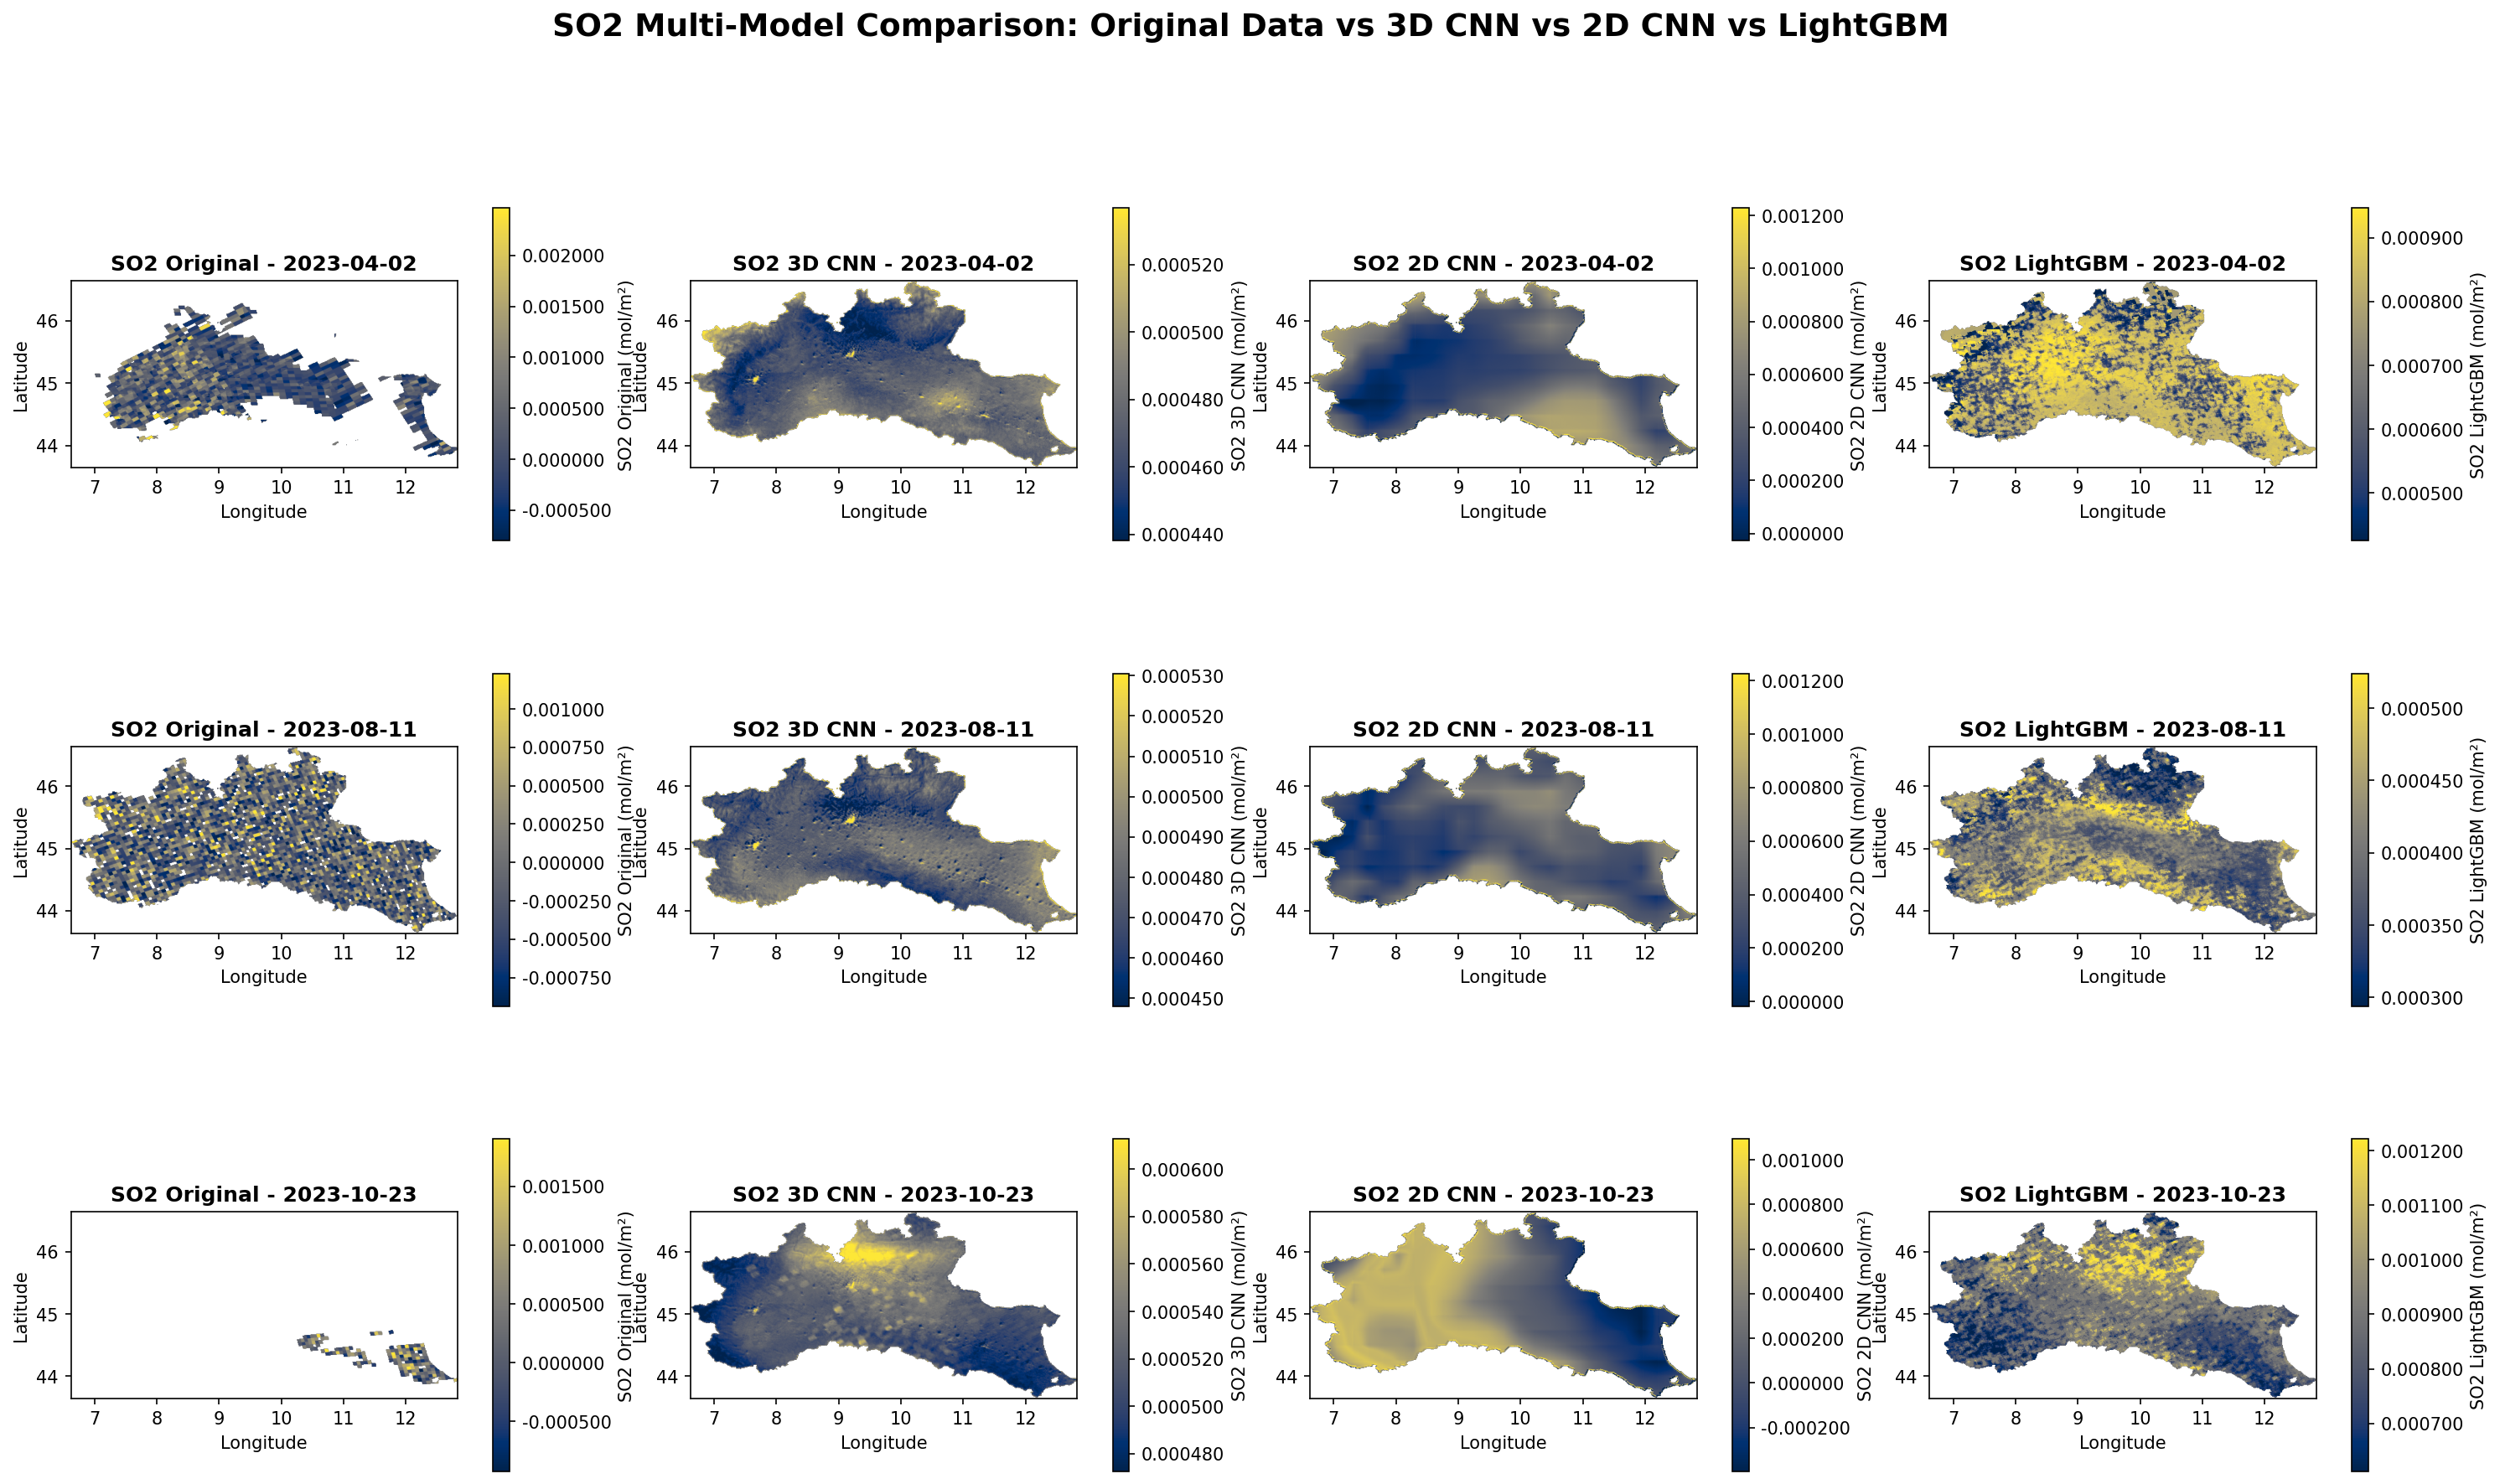


📊 SO2 visualization completed!
Displayed days: [92, 223, 296]
Corresponding dates: [datetime.datetime(2023, 4, 2, 0, 0), datetime.datetime(2023, 8, 11, 0, 0), datetime.datetime(2023, 10, 23, 0, 0)]

🎉 SO2 multi-model comparison visualization completed!
💡 Perfect for comparing different SO2 model approaches!


In [32]:
# ========= SO2 Multi-Model Comparison: Original Data vs 3D CNN vs 2D CNN vs LightGBM =========
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import geopandas as gpd
import random
from rasterio.mask import mask
from datetime import datetime, timedelta

# File paths
SO2_3DCNN_TIF = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/so2_pred_2023_stack_fixed.tif"  # 3D CNN
SO2_2DCNN_TIF = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/so2_pred_2023_stack01.tif"  # 2D CNN
SO2_LIGHTGBM_TIF = "/content/drive/MyDrive/Models/SO2_LightGBM_GapFilling/so2_pred_2023_gapfilled.tif"  # LightGBM

# Original data
SO2_ORIG_TIF = "/content/drive/MyDrive/GEE_SO2/SO2_Daily_Multiband_2023.tif"

AOI_SHP = "/content/drive/MyDrive/AOI/delimitazione_distretto.shp"
NUM = 3  # Show 3 days comparison

print("🚀 SO2 Multi-Model Comparison: Original Data vs 3D CNN vs 2D CNN vs LightGBM")
print("=" * 80)

# Load AOI
print("📁 Loading AOI boundaries...")
aoi = gpd.read_file(AOI_SHP)
print(f"✅ AOI loaded: {len(aoi)} regions")

# Load prediction data info
print("📊 Loading prediction data info...")
with rasterio.open(SO2_3DCNN_TIF) as ds:
    pred_total = ds.count
    pred_width, pred_height = ds.width, ds.height
    pred_crs = ds.crs

    # Randomly select 3 days for visualization
    bands = sorted(random.sample(range(1, pred_total + 1), NUM))

    print(f"✅ SO2 3D CNN prediction data info:")
    print(f"  Total bands: {pred_total}")
    print(f"  Spatial size: {pred_width} x {pred_height}")
    print(f"  CRS: {pred_crs}")
    print(f"  Randomly selected 3 days: {bands}")

# Check original data availability
print("📊 Checking original data availability...")
has_so2_orig = True

try:
    with rasterio.open(SO2_ORIG_TIF) as ds:
        print(f"✅ SO2 original data available: {ds.count} bands")
except FileNotFoundError:
    print("⚠️ SO2 original data not found")
    has_so2_orig = False

# Create subplots (3 rows x 4 columns: Original, SO2 3D CNN, SO2 2D CNN, LightGBM)
print("🎨 Creating SO2 visualization...")
ncols, nrows = 4, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 12), dpi=150)

# Set font
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 2023 start date
start_date_2023 = datetime(2023, 1, 1)

# Reproject AOI to data CRS
aoi_reproj = aoi.to_crs(pred_crs)

print("🖼️ Generating SO2 visualization...")

for i, b in enumerate(bands):
    current_date = start_date_2023 + timedelta(days=b - 1)
    print(f"  Processing day {i+1}/{NUM}: {current_date.strftime('%Y-%m-%d')} (band {b})")

    # 1. Original SO2 data (leftmost)
    ax_orig = axes[i, 0]

    if not has_so2_orig:
        ax_orig.set_title(f"SO2 Original - {current_date.strftime('%Y-%m-%d')}",
                         fontsize=12, fontweight='bold')
        ax_orig.set_xlabel("Longitude", fontsize=10)
        ax_orig.set_ylabel("Latitude", fontsize=10)
        ax_orig.set_facecolor('white')
        ax_orig.set_xlim(7, 12)
        ax_orig.set_ylim(44, 46)
        ax_orig.text(0.5, 0.5, 'No Valid Data', ha='center', va='center',
                    transform=ax_orig.transAxes, fontsize=14, color='gray', alpha=0.7)
    else:
        try:
            with rasterio.open(SO2_ORIG_TIF) as ds:
                clipped_orig, trans_orig = mask(
                    ds, aoi_reproj.geometry, crop=True,
                    nodata=np.nan, filled=True, indexes=b
                )

            arr_orig = np.squeeze(clipped_orig).astype(np.float32)
            valid_orig = np.isfinite(arr_orig)

            if valid_orig.sum() == 0:
                ax_orig.set_title(f"SO2 Original - {current_date.strftime('%Y-%m-%d')}",
                                 fontsize=12, fontweight='bold')
                ax_orig.set_xlabel("Longitude", fontsize=10)
                ax_orig.set_ylabel("Latitude", fontsize=10)
                ax_orig.set_facecolor('white')
                ax_orig.set_xlim(7, 12)
                ax_orig.set_ylim(44, 46)
                ax_orig.text(0.5, 0.5, 'No Valid Data', ha='center', va='center',
                            transform=ax_orig.transAxes, fontsize=14, color='gray', alpha=0.7)
            else:
                h_orig, w_orig = arr_orig.shape
                left_orig, top_orig = trans_orig * (0, 0)
                right_orig, bottom_orig = trans_orig * (w_orig, h_orig)
                extent_orig = [left_orig, right_orig, bottom_orig, top_orig]

                vmin_orig = float(np.percentile(arr_orig[valid_orig], 1))
                vmax_orig = float(np.percentile(arr_orig[valid_orig], 99))
                if vmax_orig <= vmin_orig:
                    vmax_orig = vmin_orig + 1e-12

                masked_arr_orig = np.ma.masked_where(~valid_orig, arr_orig)
                im_orig = ax_orig.imshow(masked_arr_orig, cmap="cividis", vmin=vmin_orig, vmax=vmax_orig,
                                        extent=extent_orig, origin="upper")
                ax_orig.set_title(f"SO2 Original - {current_date.strftime('%Y-%m-%d')}",
                                 fontsize=12, fontweight='bold')
                ax_orig.set_xlabel("Longitude", fontsize=10)
                ax_orig.set_ylabel("Latitude", fontsize=10)
                cbar_orig = fig.colorbar(im_orig, ax=ax_orig, fraction=0.046, pad=0.08, format='%.6f')
                cbar_orig.set_label("SO2 Original (mol/m²)", fontsize=10)
        except Exception as e:
            ax_orig.set_title(f"SO2 Original - {current_date.strftime('%Y-%m-%d')}",
                             fontsize=12, fontweight='bold')
            ax_orig.set_xlabel("Longitude", fontsize=10)
            ax_orig.set_ylabel("Latitude", fontsize=10)
            ax_orig.set_facecolor('white')
            ax_orig.set_xlim(7, 12)
            ax_orig.set_ylim(44, 46)
            ax_orig.text(0.5, 0.5, 'No Valid Data', ha='center', va='center',
                        transform=ax_orig.transAxes, fontsize=14, color='gray', alpha=0.7)

    # 2. SO2 3D CNN prediction
    ax_so2_3dcnn = axes[i, 1]
    try:
        with rasterio.open(SO2_3DCNN_TIF) as ds:
            clipped_pred, trans_pred = mask(
                ds, aoi_reproj.geometry, crop=True,
                nodata=np.nan, filled=True, indexes=b
            )

        arr_pred = np.squeeze(clipped_pred).astype(np.float32)
        valid_pred = np.isfinite(arr_pred)

        h_pred, w_pred = arr_pred.shape
        left_pred, top_pred = trans_pred * (0, 0)
        right_pred, bottom_pred = trans_pred * (w_pred, h_pred)
        extent_pred = [left_pred, right_pred, bottom_pred, top_pred]

        vmin_pred = float(np.percentile(arr_pred[valid_pred], 1))
        vmax_pred = float(np.percentile(arr_pred[valid_pred], 99))
        if vmax_pred <= vmin_pred:
            vmax_pred = vmin_pred + 1e-12

        masked_arr_pred = np.ma.masked_where(~valid_pred, arr_pred)
        im_pred = ax_so2_3dcnn.imshow(masked_arr_pred, cmap="cividis", vmin=vmin_pred, vmax=vmax_pred,
                                     extent=extent_pred, origin="upper")
        ax_so2_3dcnn.set_title(f"SO2 3D CNN - {current_date.strftime('%Y-%m-%d')}",
                              fontsize=12, fontweight='bold')
        ax_so2_3dcnn.set_xlabel("Longitude", fontsize=10)
        ax_so2_3dcnn.set_ylabel("Latitude", fontsize=10)
        cbar_pred = fig.colorbar(im_pred, ax=ax_so2_3dcnn, fraction=0.046, pad=0.08, format='%.6f')
        cbar_pred.set_label("SO2 3D CNN (mol/m²)", fontsize=10)
    except Exception as e:
        ax_so2_3dcnn.set_title(f"SO2 3D CNN - {current_date.strftime('%Y-%m-%d')}\n(Error)",
                              fontsize=12, fontweight='bold')
        ax_so2_3dcnn.set_xlabel("Longitude", fontsize=10)
        ax_so2_3dcnn.set_ylabel("Latitude", fontsize=10)
        ax_so2_3dcnn.set_facecolor('lightgray')
        ax_so2_3dcnn.text(0.5, 0.5, f'Error: {str(e)[:20]}...', ha='center', va='center',
                         transform=ax_so2_3dcnn.transAxes, fontsize=12, color='red')

    # 3. SO2 2D CNN prediction
    ax_so2_2dcnn = axes[i, 2]
    try:
        with rasterio.open(SO2_2DCNN_TIF) as ds:
            clipped_pred, trans_pred = mask(
                ds, aoi_reproj.geometry, crop=True,
                nodata=np.nan, filled=True, indexes=b
            )

        arr_pred = np.squeeze(clipped_pred).astype(np.float32)
        valid_pred = np.isfinite(arr_pred)

        h_pred, w_pred = arr_pred.shape
        left_pred, top_pred = trans_pred * (0, 0)
        right_pred, bottom_pred = trans_pred * (w_pred, h_pred)
        extent_pred = [left_pred, right_pred, bottom_pred, top_pred]

        vmin_pred = float(np.percentile(arr_pred[valid_pred], 1))
        vmax_pred = float(np.percentile(arr_pred[valid_pred], 99))
        if vmax_pred <= vmin_pred:
            vmax_pred = vmin_pred + 1e-12

        masked_arr_pred = np.ma.masked_where(~valid_pred, arr_pred)
        im_pred = ax_so2_2dcnn.imshow(masked_arr_pred, cmap="cividis", vmin=vmin_pred, vmax=vmax_pred,
                                     extent=extent_pred, origin="upper")
        ax_so2_2dcnn.set_title(f"SO2 2D CNN - {current_date.strftime('%Y-%m-%d')}",
                              fontsize=12, fontweight='bold')
        ax_so2_2dcnn.set_xlabel("Longitude", fontsize=10)
        ax_so2_2dcnn.set_ylabel("Latitude", fontsize=10)
        cbar_pred = fig.colorbar(im_pred, ax=ax_so2_2dcnn, fraction=0.046, pad=0.08, format='%.6f')
        cbar_pred.set_label("SO2 2D CNN (mol/m²)", fontsize=10)
    except Exception as e:
        ax_so2_2dcnn.set_title(f"SO2 2D CNN - {current_date.strftime('%Y-%m-%d')}\n(Error)",
                              fontsize=12, fontweight='bold')
        ax_so2_2dcnn.set_xlabel("Longitude", fontsize=10)
        ax_so2_2dcnn.set_ylabel("Latitude", fontsize=10)
        ax_so2_2dcnn.set_facecolor('lightgray')
        ax_so2_2dcnn.text(0.5, 0.5, f'Error: {str(e)[:20]}...', ha='center', va='center',
                         transform=ax_so2_2dcnn.transAxes, fontsize=12, color='red')

    # 4. SO2 LightGBM prediction
    ax_lightgbm = axes[i, 3]
    try:
        with rasterio.open(SO2_LIGHTGBM_TIF) as ds:
            clipped_pred, trans_pred = mask(
                ds, aoi_reproj.geometry, crop=True,
                nodata=np.nan, filled=True, indexes=b
            )

        arr_pred = np.squeeze(clipped_pred).astype(np.float32)
        valid_pred = np.isfinite(arr_pred)

        h_pred, w_pred = arr_pred.shape
        left_pred, top_pred = trans_pred * (0, 0)
        right_pred, bottom_pred = trans_pred * (w_pred, h_pred)
        extent_pred = [left_pred, right_pred, bottom_pred, top_pred]

        vmin_pred = float(np.percentile(arr_pred[valid_pred], 1))
        vmax_pred = float(np.percentile(arr_pred[valid_pred], 99))
        if vmax_pred <= vmin_pred:
            vmax_pred = vmin_pred + 1e-12

        masked_arr_pred = np.ma.masked_where(~valid_pred, arr_pred)
        im_pred = ax_lightgbm.imshow(masked_arr_pred, cmap="cividis", vmin=vmin_pred, vmax=vmax_pred,
                                    extent=extent_pred, origin="upper")
        ax_lightgbm.set_title(f"SO2 LightGBM - {current_date.strftime('%Y-%m-%d')}",
                             fontsize=12, fontweight='bold')
        ax_lightgbm.set_xlabel("Longitude", fontsize=10)
        ax_lightgbm.set_ylabel("Latitude", fontsize=10)
        cbar_pred = fig.colorbar(im_pred, ax=ax_lightgbm, fraction=0.046, pad=0.08, format='%.6f')
        cbar_pred.set_label("SO2 LightGBM (mol/m²)", fontsize=10)
    except Exception as e:
        ax_lightgbm.set_title(f"SO2 LightGBM - {current_date.strftime('%Y-%m-%d')}\n(Error)",
                             fontsize=12, fontweight='bold')
        ax_lightgbm.set_xlabel("Longitude", fontsize=10)
        ax_lightgbm.set_ylabel("Latitude", fontsize=10)
        ax_lightgbm.set_facecolor('lightgray')
        ax_lightgbm.text(0.5, 0.5, f'Error: {str(e)[:20]}...', ha='center', va='center',
                        transform=ax_lightgbm.transAxes, fontsize=12, color='red')

# Set main title
plt.suptitle("SO2 Multi-Model Comparison: Original Data vs 3D CNN vs 2D CNN vs LightGBM",
             fontsize=18, fontweight='bold', y=0.98)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.4, hspace=0.4)

# Show plot
plt.show()

print("\n📊 SO2 visualization completed!")
print(f"Displayed days: {bands}")
print(f"Corresponding dates: {[start_date_2023 + timedelta(days=b-1) for b in bands]}")

print("\n🎉 SO2 multi-model comparison visualization completed!")
print("💡 Perfect for comparing different SO2 model approaches!")


In [35]:
# ========= SO2 Multi-Model Comparison: Original Data vs 3D CNN vs 2D CNN vs LightGBM =========
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import geopandas as gpd
import random
from rasterio.mask import mask
from datetime import datetime, timedelta

# File paths
SO2_3DCNN_TIF = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/so2_pred_2023_stack_fixed.tif"  # 3D CNN
SO2_2DCNN_TIF = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/so2_pred_2023_stack01.tif"  # 2D CNN
SO2_LIGHTGBM_TIF = "/content/drive/MyDrive/Models/SO2_LightGBM_GapFilling/so2_pred_2023_gapfilled.tif"  # LightGBM

# Original data
SO2_ORIG_TIF = "/content/drive/MyDrive/GEE_SO2/SO2_Daily_Multiband_2023.tif"

AOI_SHP = "/content/drive/MyDrive/AOI/delimitazione_distretto.shp"
NUM = 3  # Show 3 days comparison

print("🚀 SO2 Multi-Model Comparison: Original Data vs 3D CNN vs 2D CNN vs LightGBM")
print("=" * 80)

# Load AOI
print("📁 Loading AOI boundaries...")
aoi = gpd.read_file(AOI_SHP)
print(f"✅ AOI loaded: {len(aoi)} regions")

# Load prediction data info
print("📊 Loading prediction data info...")
with rasterio.open(SO2_3DCNN_TIF) as ds:
    pred_total = ds.count
    pred_width, pred_height = ds.width, ds.height
    pred_crs = ds.crs

    # Randomly select 3 days for visualization
    bands = sorted(random.sample(range(1, pred_total + 1), NUM))

    print(f"✅ SO2 3D CNN prediction data info:")
    print(f"  Total bands: {pred_total}")
    print(f"  Spatial size: {pred_width} x {pred_height}")
    print(f"  CRS: {pred_crs}")
    print(f"  Randomly selected 3 days: {bands}")

# Check original data availability
print("📊 Checking original data availability...")
has_so2_orig = True

try:
    with rasterio.open(SO2_ORIG_TIF) as ds:
        print(f"✅ SO2 original data available: {ds.count} bands")
except FileNotFoundError:
    print("⚠️ SO2 original data not found")
    has_so2_orig = False

# Create subplots (3 rows x 4 columns: Original, SO2 3D CNN, SO2 2D CNN, LightGBM)
print("🎨 Creating SO2 visualization...")
ncols, nrows = 4, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 12), dpi=150)

# Set font
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 2023 start date
start_date_2023 = datetime(2023, 1, 1)

# Reproject AOI to data CRS
aoi_reproj = aoi.to_crs(pred_crs)

print("🖼️ Generating SO2 visualization...")

for i, b in enumerate(bands):
    current_date = start_date_2023 + timedelta(days=b - 1)
    print(f"  Processing day {i+1}/{NUM}: {current_date.strftime('%Y-%m-%d')} (band {b})")

    # 1. Original SO2 data (leftmost)
    ax_orig = axes[i, 0]

    if not has_so2_orig:
        ax_orig.set_title(f"SO2 Original - {current_date.strftime('%Y-%m-%d')}",
                         fontsize=12, fontweight='bold')
        ax_orig.set_xlabel("Longitude", fontsize=10)
        ax_orig.set_ylabel("Latitude", fontsize=10)
        ax_orig.set_facecolor('white')
        ax_orig.set_xlim(7, 12)
        ax_orig.set_ylim(44, 46)
        ax_orig.text(0.5, 0.5, 'No Valid Data', ha='center', va='center',
                    transform=ax_orig.transAxes, fontsize=14, color='gray', alpha=0.7)
    else:
        try:
            with rasterio.open(SO2_ORIG_TIF) as ds:
                clipped_orig, trans_orig = mask(
                    ds, aoi_reproj.geometry, crop=True,
                    nodata=np.nan, filled=True, indexes=b
                )

            arr_orig = np.squeeze(clipped_orig).astype(np.float32)
            valid_orig = np.isfinite(arr_orig)

            if valid_orig.sum() == 0:
                ax_orig.set_title(f"SO2 Original - {current_date.strftime('%Y-%m-%d')}",
                                 fontsize=12, fontweight='bold')
                ax_orig.set_xlabel("Longitude", fontsize=10)
                ax_orig.set_ylabel("Latitude", fontsize=10)
                ax_orig.set_facecolor('white')
                ax_orig.set_xlim(7, 12)
                ax_orig.set_ylim(44, 46)
                ax_orig.text(0.5, 0.5, 'No Valid Data', ha='center', va='center',
                            transform=ax_orig.transAxes, fontsize=14, color='gray', alpha=0.7)
            else:
                h_orig, w_orig = arr_orig.shape
                left_orig, top_orig = trans_orig * (0, 0)
                right_orig, bottom_orig = trans_orig * (w_orig, h_orig)
                extent_orig = [left_orig, right_orig, bottom_orig, top_orig]

                vmin_orig = float(np.percentile(arr_orig[valid_orig], 1))
                vmax_orig = float(np.percentile(arr_orig[valid_orig], 99))
                if vmax_orig <= vmin_orig:
                    vmax_orig = vmin_orig + 1e-12

                masked_arr_orig = np.ma.masked_where(~valid_orig, arr_orig)
                im_orig = ax_orig.imshow(masked_arr_orig, cmap="cividis", vmin=vmin_orig, vmax=vmax_orig,
                                        extent=extent_orig, origin="upper")
                ax_orig.set_title(f"SO2 Original - {current_date.strftime('%Y-%m-%d')}",
                                 fontsize=12, fontweight='bold')
                ax_orig.set_xlabel("Longitude", fontsize=10)
                ax_orig.set_ylabel("Latitude", fontsize=10)
                cbar_orig = fig.colorbar(im_orig, ax=ax_orig, fraction=0.046, pad=0.08, format='%.6f')
                cbar_orig.set_label("SO2 Original (mol/m²)", fontsize=10)
        except Exception as e:
            ax_orig.set_title(f"SO2 Original - {current_date.strftime('%Y-%m-%d')}",
                             fontsize=12, fontweight='bold')
            ax_orig.set_xlabel("Longitude", fontsize=10)
            ax_orig.set_ylabel("Latitude", fontsize=10)
            ax_orig.set_facecolor('white')
            ax_orig.set_xlim(7, 12)
            ax_orig.set_ylim(44, 46)
            ax_orig.text(0.5, 0.5, 'No Valid Data', ha='center', va='center',
                        transform=ax_orig.transAxes, fontsize=14, color='gray', alpha=0.7)

    # 2. SO2 3D CNN prediction
    ax_so2_3dcnn = axes[i, 1]
    try:
        with rasterio.open(SO2_3DCNN_TIF) as ds:
            clipped_pred, trans_pred = mask(
                ds, aoi_reproj.geometry, crop=True,
                nodata=np.nan, filled=True, indexes=b
            )

        arr_pred = np.squeeze(clipped_pred).astype(np.float32)
        valid_pred = np.isfinite(arr_pred)

        h_pred, w_pred = arr_pred.shape
        left_pred, top_pred = trans_pred * (0, 0)
        right_pred, bottom_pred = trans_pred * (w_pred, h_pred)
        extent_pred = [left_pred, right_pred, bottom_pred, top_pred]

        vmin_pred = float(np.percentile(arr_pred[valid_pred], 1))
        vmax_pred = float(np.percentile(arr_pred[valid_pred], 99))
        if vmax_pred <= vmin_pred:
            vmax_pred = vmin_pred + 1e-12

        masked_arr_pred = np.ma.masked_where(~valid_pred, arr_pred)
        im_pred = ax_so2_3dcnn.imshow(masked_arr_pred, cmap="cividis", vmin=vmin_pred, vmax=vmax_pred,
                                     extent=extent_pred, origin="upper")
        ax_so2_3dcnn.set_title(f"SO2 3D CNN - {current_date.strftime('%Y-%m-%d')}",
                              fontsize=12, fontweight='bold')
        ax_so2_3dcnn.set_xlabel("Longitude", fontsize=10)
        ax_so2_3dcnn.set_ylabel("Latitude", fontsize=10)
        cbar_pred = fig.colorbar(im_pred, ax=ax_so2_3dcnn, fraction=0.046, pad=0.08, format='%.6f')
        cbar_pred.set_label("SO2 3D CNN (mol/m²)", fontsize=10)
    except Exception as e:
        ax_so2_3dcnn.set_title(f"SO2 3D CNN - {current_date.strftime('%Y-%m-%d')}\n(Error)",
                              fontsize=12, fontweight='bold')
        ax_so2_3dcnn.set_xlabel("Longitude", fontsize=10)
        ax_so2_3dcnn.set_ylabel("Latitude", fontsize=10)
        ax_so2_3dcnn.set_facecolor('lightgray')
        ax_so2_3dcnn.text(0.5, 0.5, f'Error: {str(e)[:20]}...', ha='center', va='center',
                         transform=ax_so2_3dcnn.transAxes, fontsize=12, color='red')

    # 3. SO2 2D CNN prediction
    ax_so2_2dcnn = axes[i, 2]
    try:
        with rasterio.open(SO2_2DCNN_TIF) as ds:
            clipped_pred, trans_pred = mask(
                ds, aoi_reproj.geometry, crop=True,
                nodata=np.nan, filled=True, indexes=b
            )

        arr_pred = np.squeeze(clipped_pred).astype(np.float32)
        valid_pred = np.isfinite(arr_pred)

        h_pred, w_pred = arr_pred.shape
        left_pred, top_pred = trans_pred * (0, 0)
        right_pred, bottom_pred = trans_pred * (w_pred, h_pred)
        extent_pred = [left_pred, right_pred, bottom_pred, top_pred]

        vmin_pred = float(np.percentile(arr_pred[valid_pred], 1))
        vmax_pred = float(np.percentile(arr_pred[valid_pred], 99))
        if vmax_pred <= vmin_pred:
            vmax_pred = vmin_pred + 1e-12

        masked_arr_pred = np.ma.masked_where(~valid_pred, arr_pred)
        im_pred = ax_so2_2dcnn.imshow(masked_arr_pred, cmap="cividis", vmin=vmin_pred, vmax=vmax_pred,
                                     extent=extent_pred, origin="upper")
        ax_so2_2dcnn.set_title(f"SO2 2D CNN - {current_date.strftime('%Y-%m-%d')}",
                              fontsize=12, fontweight='bold')
        ax_so2_2dcnn.set_xlabel("Longitude", fontsize=10)
        ax_so2_2dcnn.set_ylabel("Latitude", fontsize=10)
        cbar_pred = fig.colorbar(im_pred, ax=ax_so2_2dcnn, fraction=0.046, pad=0.08, format='%.6f')
        cbar_pred.set_label("SO2 2D CNN (mol/m²)", fontsize=10)
    except Exception as e:
        ax_so2_2dcnn.set_title(f"SO2 2D CNN - {current_date.strftime('%Y-%m-%d')}\n(Error)",
                              fontsize=12, fontweight='bold')
        ax_so2_2dcnn.set_xlabel("Longitude", fontsize=10)
        ax_so2_2dcnn.set_ylabel("Latitude", fontsize=10)
        ax_so2_2dcnn.set_facecolor('lightgray')
        ax_so2_2dcnn.text(0.5, 0.5, f'Error: {str(e)[:20]}...', ha='center', va='center',
                         transform=ax_so2_2dcnn.transAxes, fontsize=12, color='red')

    # 4. SO2 LightGBM prediction
    ax_lightgbm = axes[i, 3]
    try:
        with rasterio.open(SO2_LIGHTGBM_TIF) as ds:
            clipped_pred, trans_pred = mask(
                ds, aoi_reproj.geometry, crop=True,
                nodata=np.nan, filled=True, indexes=b
            )

        arr_pred = np.squeeze(clipped_pred).astype(np.float32)
        valid_pred = np.isfinite(arr_pred)

        h_pred, w_pred = arr_pred.shape
        left_pred, top_pred = trans_pred * (0, 0)
        right_pred, bottom_pred = trans_pred * (w_pred, h_pred)
        extent_pred = [left_pred, right_pred, bottom_pred, top_pred]

        vmin_pred = float(np.percentile(arr_pred[valid_pred], 1))
        vmax_pred = float(np.percentile(arr_pred[valid_pred], 99))
        if vmax_pred <= vmin_pred:
            vmax_pred = vmin_pred + 1e-12

        masked_arr_pred = np.ma.masked_where(~valid_pred, arr_pred)
        im_pred = ax_lightgbm.imshow(masked_arr_pred, cmap="cividis", vmin=vmin_pred, vmax=vmax_pred,
                                    extent=extent_pred, origin="upper")
        ax_lightgbm.set_title(f"SO2 LightGBM - {current_date.strftime('%Y-%m-%d')}",
                             fontsize=12, fontweight='bold')
        ax_lightgbm.set_xlabel("Longitude", fontsize=10)
        ax_lightgbm.set_ylabel("Latitude", fontsize=10)
        cbar_pred = fig.colorbar(im_pred, ax=ax_lightgbm, fraction=0.046, pad=0.08, format='%.6f')
        cbar_pred.set_label("SO2 LightGBM (mol/m²)", fontsize=10)
    except Exception as e:
        ax_lightgbm.set_title(f"SO2 LightGBM - {current_date.strftime('%Y-%m-%d')}\n(Error)",
                             fontsize=12, fontweight='bold')
        ax_lightgbm.set_xlabel("Longitude", fontsize=10)
        ax_lightgbm.set_ylabel("Latitude", fontsize=10)
        ax_lightgbm.set_facecolor('lightgray')
        ax_lightgbm.text(0.5, 0.5, f'Error: {str(e)[:20]}...', ha='center', va='center',
                        transform=ax_lightgbm.transAxes, fontsize=12, color='red')

# Set main title
plt.suptitle("SO2 Multi-Model Comparison: Original Data vs 3D CNN vs 2D CNN vs LightGBM",
             fontsize=18, fontweight='bold', y=0.98)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.4, hspace=0.4)

# Show plot
plt.show()

print("\n📊 SO2 visualization completed!")
print(f"Displayed days: {bands}")
print(f"Corresponding dates: {[start_date_2023 + timedelta(days=b-1) for b in bands]}")

print("\n🎉 SO2 multi-model comparison visualization completed!")
print("💡 Perfect for comparing different SO2 model approaches!")


🚀 SO2 Multi-Model Comparison: Original Data vs 3D CNN vs 2D CNN vs LightGBM
📁 Loading AOI boundaries...
✅ AOI loaded: 1 regions
📊 Loading prediction data info...
✅ SO2 3D CNN prediction data info:
  Total bands: 365
  Spatial size: 621 x 300
  CRS: EPSG:4326
  Randomly selected 3 days: [27, 122, 348]
📊 Checking original data availability...
✅ SO2 original data available: 365 bands
🎨 Creating SO2 visualization...
🖼️ Generating SO2 visualization...
  Processing day 1/3: 2023-01-27 (band 27)
  Processing day 2/3: 2023-05-02 (band 122)
  Processing day 3/3: 2023-12-14 (band 348)



📊 SO2 visualization completed!
Displayed days: [27, 122, 348]
Corresponding dates: [datetime.datetime(2023, 1, 27, 0, 0), datetime.datetime(2023, 5, 2, 0, 0), datetime.datetime(2023, 12, 14, 0, 0)]

🎉 SO2 multi-model comparison visualization completed!
💡 Perfect for comparing different SO2 model approaches!
